In [1]:
import numpy as np
import os
from oe_acute import trial_utils as tu
from oe_acute import MNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob

import sys
#from oe_acute import pyMNE

In [2]:
os.nice(1)

1

### Load dsets

In [3]:
stim_spec = np.load('/mnt/cube/Rabona/output_transformer/enc_test_512.npy')
stim_resp = np.load('/mnt/cube/Rabona/output_transformer/resp_test_512.npy')

In [4]:
np.shape(stim_spec), np.shape(stim_resp)

((5706, 512), (5706, 214, 32))

In [5]:
def prepare_MNE_dset(stim_spec, stim_resp, nsegbins=512, concat=True):
    '''
    Create the dataset for fitting MNE model
    '''
    stim_mne = []
    resp_mne = []
    for s, r in zip(stim_spec, stim_resp):
        #nfreq, ntime = s.shape
        #s_segs = np.stack([s[:, n:(n+nsegbins)] for n in range(ntime - nsegbins)], axis=0)
        s_segs = s
        r_segs = np.sum(r, axis=1)
        stim_mne.append(s_segs)
        resp_mne.append(r_segs)
    if concat:
        return np.vstack(stim_mne), np.vstack(resp_mne)
    else:
        return stim_mne, resp_mne

In [6]:
nsegbins = 512

In [7]:
stim_mne = []
resp_mne = []
stim_mne, resp_mne = prepare_MNE_dset(stim_spec, stim_resp, nsegbins=nsegbins)

In [8]:
np.shape(stim_mne), np.shape(resp_mne)

((5706, 512), (5706, 214))

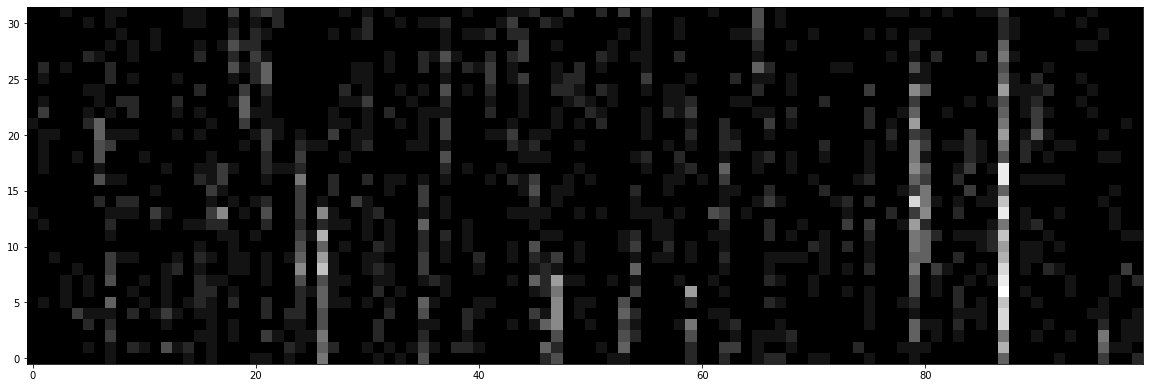

In [9]:
ax = plt.subplots(figsize=(20,8))
plt.imshow(np.transpose(stim_resp[:100, 100, :]), origin='lower', cmap='gray')

### Split into train test sets

In [10]:
len_units = np.shape(resp_mne)[1]

In [11]:
units_to_process = list(np.load('/mnt/cube/srrudrar/temporal_model/units_to_process_B1240.npy'))

In [12]:
exp_path = '/mnt/cube/srrudrar/transformer_model/B1240/32x32/stim_resp_32x32_512/test_set_mne/'

In [13]:
# obtain all preprocessed datas

%matplotlib inline
sdim = 512
n_jackknives = 4

test_output_path = os.path.join(exp_path, 'MNE_test_dset')
os.makedirs(test_output_path, exist_ok=True)
n_eigvec_to_display = 6 # Number of most positive and most negative eigenvectors to display

pfinals = {}
for unit in units_to_process:
    i = units_to_process.index(unit)
    stims_train, resps_train, stims_test, resps_test = MNE.prepare_MNE_train_test_set(stim_mne, resp_mne[:,i][:,np.newaxis], train_pct=0.8, zscore=True, kz_norm_resp=True)
    
    # Save test dataset
    test_dict = {'stims_test':stims_test, 'resps_test':resps_test}
    out_fname = 'unit-{}_MNE.pkl'.format(unit)
    out_f = os.path.join(test_output_path, out_fname)
    with open(out_f, 'wb') as f:
        pickle.dump(test_dict, f)

    # Run MNE
    pfinal = MNE.fit_MNE(stims_train, resps_train, order=2)
    #MNE.plot_MNE(pfinal, unit, figure_output_path)
    pfinals[unit] = pfinal

Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.170802
    2       0    0.161566
    3       0    0.165754
    4       1    0.161816
    5       2    0.166762
    6       3    0.171408
    7       4    0.162371
    8       5    0.167407
    9       6    0.166619
   10       7    0.160946
   11       0    0.163223
   12       1    0.161856
   13       2    0.169189
   14       3    0.171691
   15       4    0.161380
   16       5    0.161371
   17       6    0.156979
   18       0    0.158372
   19       1    0.159709
   20       2    0.157413
   21       3    0.161451
   22       4    0.162512
   23       5    0.157753
   24       6    0.157077
   25       7    0.159453
   26       8    0.157343
   27       9    0.156257
   28       0    0.159189
   29       1    0.158892
   30       2    0.163159
   31       3    0.166350
   32       4    0.160914
   33       5    0.158975
   34       6    0.160417
   35       7    0.159726
   36       8    0.160348
   37       9    0.158464
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn

    1       0    0.159133
    2       0    0.158459
    3       0    0.156742
    4       0    0.157875
    5       1    0.160866
    6       2    0.161317
    7       3    0.161533
    8       4    0.161627
    9       5    0.160466
   10       6    0.157481
   11       7    0.157037
   12       8    0.156048
   13       0    0.154833
   14       0    0.153012
   15       0    0.152771
   16       0    0.152513
   17       0    0.152304
   18       0    0.151923
   19       0    0.152297
   20       1    0.152642
   21       2    0.153246
   22       3    0.152883
   23       4    0.151806
   24       0    0.151397
   25       0    0.151496
   26       1    0.151551
   27       2    0.151716
   28       3    0.152244
   29       4    0.152894
   30       5    0.152915
   31       6    0.152713
   32       7    0.152425
   33       8    0.151389
   34       0    0.151197
   35       0    0.151328
   36       1    0.151054
   37       0    0.150742
   38       0    0.150689
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.152069
    2       0    0.152520
    3       0    0.149950
    4       0    0.147928
    5       0    0.150132
    6       1    0.149997
    7       2    0.152383
    8       3    0.152021
    9       4    0.151643
   10       5    0.150096
   11       6    0.148552
   12       7    0.147154
   13       0    0.146017
   14       0    0.145588
   15       0    0.143801
   16       0    0.142525
   17       0    0.142749
   18       1    0.143047
   19       2    0.142598
   20       3    0.142905
   21       4    0.143645
   22       5    0.143719
   23       6    0.144158
   24       7    0.144313
   25       8    0.145151
   26       9    0.145920
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn

    1       0    0.156521
    2       0    0.154536
    3       0    0.156977
    4       1    0.156759
    5       2    0.154879
    6       3    0.153677
    7       0    0.154540
    8       1    0.154051
    9       2    0.155384
   10       3    0.154191
   11       4    0.153556
   12       0    0.152749
   13       0    0.153251
   14       1    0.153056
   15       2    0.152114
   16       0    0.150879
   17       0    0.150436
   18       0    0.150966
   19       1    0.149885
   20       0    0.150064
   21       1    0.148960
   22       0    0.148841
   23       0    0.147951
   24       0    0.148094
   25       1    0.147998
   26       2    0.148750
   27       3    0.148520
   28       4    0.148388
   29       5    0.147744
   30       0    0.147310
   31       0    0.147449
   32       1    0.147743
   33       2    0.147643
   34       3    0.148107
   35       4    0.148167
   36       5    0.148690
   37       6    0.148515
   38       7    0.148209
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.149482
    2       0    0.149738
    3       0    0.137338
    4       0    0.145822
    5       1    0.133583
    6       0    0.134069
    7       1    0.132855
    8       0    0.134003
    9       1    0.134122
   10       2    0.130662
   11       0    0.131859
   12       1    0.131399
   13       2    0.131414
   14       3    0.128953
   15       0    0.128928
   16       0    0.128692
   17       0    0.129551
   18       1    0.129846
   19       2    0.129782
   20       3    0.130173
   21       4    0.130462
   22       5    0.129100
   23       6    0.128535
   24       0    0.128321
   25       0    0.128159
   26       0    0.128868
   27       1    0.129183
   28       2    0.129338
   29       3    0.129718
   30       4    0.130188
   31       5    0.130299
   32       6    0.130768
   33       7    0.131270
   34       8    0.132455
   35       9    0.131862
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.166021
    2       0    0.161541
    3       0    0.161392
    4       0    0.160070
    5       0    0.158860
    6       0    0.157758
    7       0    0.156426
    8       0    0.156928
    9       1    0.156824
   10       2    0.155776
   11       0    0.154671
   12       0    0.154313
   13       0    0.153861
   14       0    0.155059
   15       1    0.154640
   16       2    0.155138
   17       3    0.155412
   18       4    0.154308
   19       5    0.156082
   20       6    0.153132
   21       0    0.151713
   22       0    0.151989
   23       1    0.152964
   24       2    0.152309
   25       3    0.152111
   26       4    0.155180
   27       5    0.154694
   28       6    0.153542
   29       7    0.153656
   30       8    0.154293
   31       9    0.152691
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.151305
    2       0    0.150713
    3       0    0.146747
    4       0    0.147025
    5       1    0.144918
    6       0    0.144439
    7       0    0.143919
    8       0    0.144426
    9       1    0.143048
   10       0    0.141591
   11       0    0.141012
   12       0    0.140618
   13       0    0.140335
   14       0    0.140013
   15       0    0.138821
   16       0    0.137905
   17       0    0.138397
   18       1    0.137734
   19       0    0.136869
   20       0    0.136771
   21       0    0.137043
   22       1    0.136863
   23       2    0.135461
   24       0    0.135350
   25       0    0.136109
   26       1    0.136301
   27       2    0.136604
   28       3    0.136287
   29       4    0.134758
   30       0    0.134400
   31       0    0.134480
   32       1    0.134596
   33       2    0.135082
   34       3    0.134800
   35       4    0.134431
   36       5    0.134192
   37       0    0.134079
   38       0    0.134381
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.150988
    2       0    0.149078
    3       0    0.146210
    4       0    0.144814
    5       0    0.144553
    6       0    0.144563
    7       1    0.143036
    8       0    0.144627
    9       1    0.144720
   10       2    0.143229
   11       3    0.143112
   12       4    0.143284
   13       5    0.142874
   14       0    0.141814
   15       0    0.141927
   16       1    0.140955
   17       0    0.139750
   18       0    0.140336
   19       1    0.140495
   20       2    0.140680
   21       3    0.139506
   22       0    0.140533
   23       1    0.139933
   24       2    0.138022
   25       0    0.138768
   26       1    0.138214
   27       2    0.138193
   28       3    0.138264
   29       4    0.138340
   30       5    0.138455
   31       6    0.139734
   32       7    0.139851
   33       8    0.140115
   34       9    0.140905
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.112907
    2       0    0.110624
    3       0    0.110479
    4       0    0.110355
    5       0    0.109842
    6       0    0.110182
    7       1    0.110789
    8       2    0.110548
    9       3    0.110407
   10       4    0.110065
   11       5    0.109495
   12       0    0.109253
   13       0    0.109110
   14       0    0.108309
   15       0    0.108373
   16       1    0.107993
   17       0    0.107626
   18       0    0.108174
   19       1    0.108292
   20       2    0.107563
   21       0    0.107548
   22       0    0.107685
   23       1    0.107536
   24       0    0.107381
   25       0    0.107905
   26       1    0.107675
   27       2    0.107756
   28       3    0.107747
   29       4    0.107379
   30       0    0.107261
   31       0    0.107420
   32       1    0.107168
   33       0    0.107160
   34       0    0.107041
   35       0    0.107016
   36       0    0.107281
   37       1    0.107330
   38       2    0.107689
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.109262
    2       0    0.108714
    3       0    0.108168
    4       0    0.106276
    5       0    0.105702
    6       0    0.105056
    7       0    0.104405
    8       0    0.104427
    9       1    0.104197
   10       0    0.104040
   11       0    0.105103
   12       1    0.104175
   13       2    0.103380
   14       0    0.103097
   15       0    0.102613
   16       0    0.102803
   17       1    0.102812
   18       2    0.102871
   19       3    0.102972
   20       4    0.102797
   21       5    0.102619
   22       6    0.102266
   23       0    0.102441
   24       1    0.102898
   25       2    0.103267
   26       3    0.103166
   27       4    0.103036
   28       5    0.102933
   29       6    0.102908
   30       7    0.102815
   31       8    0.102879
   32       9    0.102886
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.108427
    2       0    0.107712
    3       0    0.106325
    4       0    0.105229
    5       0    0.104443
    6       0    0.104443
    7       0    0.103849
    8       0    0.103034
    9       0    0.102599
   10       0    0.101980
   11       0    0.102069
   12       1    0.103053
   13       2    0.103505
   14       3    0.102820
   15       4    0.102397
   16       5    0.101798
   17       0    0.101969
   18       1    0.102050
   19       2    0.101737
   20       0    0.101621
   21       0    0.101631
   22       1    0.101601
   23       0    0.101491
   24       0    0.101446
   25       0    0.101250
   26       0    0.101564
   27       1    0.101590
   28       2    0.101314
   29       3    0.101248
   30       0    0.101247
   31       0    0.101432
   32       1    0.101334
   33       2    0.101285
   34       3    0.101268
   35       4    0.101170
   36       0    0.101159
   37       0    0.101126
   38       0    0.101088
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.123011
    2       0    0.122102
    3       0    0.121951
    4       0    0.121243
    5       0    0.119557
    6       0    0.118019
    7       0    0.118573
    8       1    0.119127
    9       2    0.118586
   10       3    0.118319
   11       4    0.117449
   12       0    0.117186
   13       0    0.117581
   14       1    0.117626
   15       2    0.118514
   16       3    0.117867
   17       4    0.117419
   18       5    0.117239
   19       6    0.117314
   20       7    0.117467
   21       8    0.117212
   22       9    0.117108
   23       0    0.117502
   24       1    0.117164
   25       2    0.117230
   26       3    0.117273
   27       4    0.117963
   28       5    0.117781
   29       6    0.118046
   30       7    0.118290
   31       8    0.118545
   32       9    0.117859
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.105539
    2       0    0.104479
    3       0    0.102949
    4       0    0.102161
    5       0    0.101976
    6       0    0.100816
    7       0    0.100915
    8       1    0.100430
    9       0    0.099876
   10       0    0.099957
   11       1    0.099133
   12       0    0.098841
   13       0    0.099467
   14       1    0.099516
   15       2    0.098524
   16       0    0.098325
   17       0    0.098339
   18       1    0.098220
   19       0    0.098084
   20       0    0.098165
   21       1    0.098131
   22       2    0.098053
   23       0    0.098137
   24       1    0.098405
   25       2    0.098122
   26       3    0.098676
   27       4    0.098831
   28       5    0.098572
   29       6    0.097650
   30       0    0.097560
   31       0    0.097746
   32       1    0.097706
   33       2    0.097490
   34       0    0.097765
   35       1    0.097886
   36       2    0.097683
   37       3    0.097530
   38       4    0.097467
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.107213
    2       0    0.105194
    3       0    0.104223
    4       0    0.102991
    5       0    0.103139
    6       1    0.103488
    7       2    0.102285
    8       0    0.101347
    9       0    0.100531
   10       0    0.100165
   11       0    0.099917
   12       0    0.099817
   13       0    0.099919
   14       1    0.099862
   15       2    0.099531
   16       0    0.099266
   17       0    0.099007
   18       0    0.098966
   19       0    0.099048
   20       1    0.099059
   21       2    0.099130
   22       3    0.098336
   23       0    0.098341
   24       1    0.098162
   25       0    0.098159
   26       0    0.097857
   27       0    0.097890
   28       1    0.097892
   29       2    0.097981
   30       3    0.098043
   31       4    0.097809
   32       0    0.097702
   33       0    0.097634
   34       0    0.097769
   35       1    0.097702
   36       2    0.097661
   37       3    0.097575
   38       0    0.097571
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.101640
    2       0    0.100108
    3       0    0.099104
    4       0    0.098294
    5       0    0.097910
    6       0    0.097376
    7       0    0.096975
    8       0    0.096894
    9       0    0.096456
   10       0    0.096363
   11       0    0.095864
   12       0    0.095751
   13       0    0.095188
   14       0    0.095261
   15       1    0.095108
   16       0    0.094945
   17       0    0.094848
   18       0    0.094673
   19       0    0.095048
   20       1    0.094970
   21       2    0.095261
   22       3    0.095411
   23       4    0.094947
   24       5    0.094438
   25       0    0.094522
   26       1    0.094309
   27       0    0.094083
   28       0    0.093923
   29       0    0.093907
   30       0    0.093979
   31       1    0.093974
   32       2    0.093832
   33       0    0.093910
   34       1    0.094255
   35       2    0.094523
   36       3    0.094431
   37       4    0.094133
   38       5    0.093981
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.098960
    2       0    0.096093
    3       0    0.095813
    4       0    0.094097
    5       0    0.093765
    6       0    0.093422
    7       0    0.093189
    8       0    0.093072
    9       0    0.093962
   10       1    0.092497
   11       0    0.091584
   12       0    0.091640
   13       1    0.091122
   14       0    0.091161
   15       1    0.090797
   16       0    0.090970
   17       1    0.090724
   18       0    0.091346
   19       1    0.091392
   20       2    0.090832
   21       3    0.090488
   22       0    0.090306
   23       0    0.090858
   24       1    0.090780
   25       2    0.090164
   26       0    0.090194
   27       1    0.090059
   28       0    0.090185
   29       1    0.090001
   30       0    0.090059
   31       1    0.090117
   32       2    0.090389
   33       3    0.089807
   34       0    0.089635
   35       0    0.089527
   36       0    0.089513
   37       0    0.089573
   38       1    0.089461
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.188309
    2       0    0.187098
    3       0    0.185458
    4       0    0.184718
    5       0    0.185779
    6       1    0.183978
    7       0    0.183135
    8       0    0.182489
    9       0    0.181825
   10       0    0.182479
   11       1    0.181188
   12       0    0.180802
   13       0    0.180330
   14       0    0.181356
   15       1    0.181770
   16       2    0.180867
   17       3    0.180091
   18       0    0.180320
   19       1    0.180270
   20       2    0.179858
   21       0    0.179957
   22       1    0.179831
   23       0    0.179557
   24       0    0.179562
   25       1    0.179702
   26       2    0.179675
   27       3    0.179305
   28       0    0.179838
   29       1    0.180087
   30       2    0.181021
   31       3    0.181720
   32       4    0.181507
   33       5    0.180854
   34       6    0.180753
   35       7    0.180732
   36       8    0.180765
   37       9    0.180223
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.196094
    2       0    0.193811
    3       0    0.193793
    4       0    0.192717
    5       0    0.191171
    6       0    0.189960
    7       0    0.189724
    8       0    0.187522
    9       0    0.187438
   10       0    0.186057
   11       0    0.185409
   12       0    0.184793
   13       0    0.184594
   14       0    0.184212
   15       0    0.185350
   16       1    0.185042
   17       2    0.184469
   18       3    0.184811
   19       4    0.183732
   20       0    0.183004
   21       0    0.182635
   22       0    0.182686
   23       1    0.182514
   24       0    0.182580
   25       1    0.182413
   26       0    0.182332
   27       0    0.182283
   28       0    0.182276
   29       0    0.182114
   30       0    0.182388
   31       1    0.182552
   32       2    0.182774
   33       3    0.183140
   34       4    0.182675
   35       5    0.182661
   36       6    0.183129
   37       7    0.183330
   38       8    0.183276
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.207384
    2       0    0.205785
    3       0    0.205650
    4       0    0.205638
    5       0    0.204087
    6       0    0.203262
    7       0    0.203053
    8       0    0.202103
    9       0    0.201916
   10       0    0.201970
   11       1    0.201767
   12       0    0.201504
   13       0    0.200244
   14       0    0.199983
   15       0    0.201198
   16       1    0.201962
   17       2    0.200921
   18       3    0.200267
   19       4    0.200265
   20       5    0.200159
   21       6    0.199725
   22       0    0.199684
   23       0    0.199658
   24       0    0.200060
   25       1    0.200376
   26       2    0.201081
   27       3    0.200960
   28       4    0.201243
   29       5    0.201195
   30       6    0.200360
   31       7    0.199798
   32       8    0.199805
   33       9    0.200110
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.209131
    2       0    0.209458
    3       0    0.205562
    4       0    0.204159
    5       0    0.203996
    6       0    0.202975
    7       0    0.202883
    8       0    0.201998
    9       0    0.201973
   10       0    0.201990
   11       1    0.201076
   12       0    0.203772
   13       1    0.204393
   14       2    0.202129
   15       3    0.200903
   16       0    0.200688
   17       0    0.200489
   18       0    0.200241
   19       0    0.200167
   20       0    0.199762
   21       0    0.199088
   22       0    0.199051
   23       0    0.198357
   24       0    0.199683
   25       1    0.199591
   26       2    0.198461
   27       3    0.198648
   28       4    0.198587
   29       5    0.199522
   30       6    0.199747
   31       7    0.198857
   32       8    0.198810
   33       9    0.198771
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.076226
    2       0    0.075819
    3       0    0.073434
    4       0    0.072424
    5       0    0.071212
    6       0    0.070031
    7       0    0.071151
    8       1    0.071463
    9       2    0.070162
   10       3    0.069821
   11       0    0.069782
   12       0    0.069819
   13       1    0.069347
   14       0    0.069567
   15       1    0.069268
   16       0    0.069735
   17       1    0.069200
   18       0    0.069570
   19       1    0.070077
   20       2    0.069972
   21       3    0.069262
   22       4    0.069378
   23       5    0.069339
   24       6    0.069293
   25       7    0.068915
   26       0    0.068991
   27       1    0.069095
   28       2    0.069232
   29       3    0.069053
   30       4    0.068819
   31       0    0.068925
   32       1    0.068745
   33       0    0.069040
   34       1    0.068546
   35       0    0.069651
   36       1    0.070176
   37       2    0.069525
   38       3    0.068992
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.071332
    2       0    0.070179
    3       0    0.069717
    4       0    0.068878
    5       0    0.067861
    6       0    0.067319
    7       0    0.067157
    8       0    0.066965
    9       0    0.066349
   10       0    0.065665
   11       0    0.065821
   12       1    0.065395
   13       0    0.065079
   14       0    0.065153
   15       1    0.065090
   16       2    0.065398
   17       3    0.065874
   18       4    0.065447
   19       5    0.065364
   20       6    0.064915
   21       0    0.064589
   22       0    0.064905
   23       1    0.064896
   24       2    0.064592
   25       3    0.064750
   26       4    0.064894
   27       5    0.064949
   28       6    0.064668
   29       7    0.064583
   30       0    0.064982
   31       1    0.064989
   32       2    0.065600
   33       3    0.065501
   34       4    0.065383
   35       5    0.065282
   36       6    0.065078
   37       7    0.065456
   38       8    0.065403
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.075372
    2       0    0.073442
    3       0    0.072278
    4       0    0.071900
    5       0    0.071100
    6       0    0.070445
    7       0    0.070454
    8       1    0.069888
    9       0    0.069666
   10       0    0.069384
   11       0    0.069016
   12       0    0.068962
   13       0    0.069370
   14       1    0.069788
   15       2    0.069348
   16       3    0.068583
   17       0    0.068336
   18       0    0.068097
   19       0    0.068289
   20       1    0.068361
   21       2    0.068490
   22       3    0.068516
   23       4    0.067950
   24       0    0.067711
   25       0    0.067695
   26       0    0.067898
   27       1    0.067949
   28       2    0.068220
   29       3    0.068626
   30       4    0.070330
   31       5    0.070356
   32       6    0.070008
   33       7    0.069562
   34       8    0.069227
   35       9    0.069362
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.073792
    2       0    0.072667
    3       0    0.069396
    4       0    0.068151
    5       0    0.068557
    6       1    0.067743
    7       0    0.067346
    8       0    0.067132
    9       0    0.066542
   10       0    0.065933
   11       0    0.065961
   12       1    0.065436
   13       0    0.065666
   14       1    0.066128
   15       2    0.065806
   16       3    0.065154
   17       0    0.065017
   18       0    0.065385
   19       1    0.065596
   20       2    0.064982
   21       0    0.065359
   22       1    0.065165
   23       2    0.064463
   24       0    0.064716
   25       1    0.065179
   26       2    0.064820
   27       3    0.064200
   28       0    0.064912
   29       1    0.065110
   30       2    0.064917
   31       3    0.064685
   32       4    0.064530
   33       5    0.064498
   34       6    0.064633
   35       7    0.064532
   36       8    0.064519
   37       9    0.064869
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.103773
    2       0    0.102462
    3       0    0.101200
    4       0    0.099911
    5       0    0.100169
    6       1    0.099146
    7       0    0.099436
    8       1    0.099180
    9       2    0.098663
   10       0    0.099097
   11       1    0.099229
   12       2    0.098732
   13       3    0.098722
   14       4    0.098562
   15       0    0.098054
   16       0    0.098121
   17       1    0.097685
   18       0    0.097359
   19       0    0.097537
   20       1    0.097283
   21       0    0.097244
   22       0    0.097257
   23       1    0.096713
   24       0    0.096681
   25       0    0.097081
   26       1    0.097120
   27       2    0.096414
   28       0    0.096336
   29       0    0.096572
   30       1    0.096542
   31       2    0.096617
   32       3    0.096562
   33       4    0.096549
   34       5    0.096189
   35       0    0.096315
   36       1    0.096324
   37       2    0.096170
   38       0    0.096175
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.103407
    2       0    0.103255
    3       0    0.103725
    4       1    0.103669
    5       2    0.103985
    6       3    0.104200
    7       4    0.104034
    8       5    0.102628
    9       0    0.101980
   10       0    0.102082
   11       1    0.101995
   12       2    0.101227
   13       0    0.101243
   14       1    0.101457
   15       2    0.101695
   16       3    0.101481
   17       4    0.102052
   18       5    0.102010
   19       6    0.101128
   20       0    0.101191
   21       1    0.101338
   22       2    0.101091
   23       0    0.100806
   24       0    0.100604
   25       0    0.100936
   26       1    0.101409
   27       2    0.101490
   28       3    0.101208
   29       4    0.101308
   30       5    0.100941
   31       6    0.100926
   32       7    0.101091
   33       8    0.100956
   34       9    0.100778
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.091483
    2       0    0.089531
    3       0    0.088585
    4       0    0.088818
    5       1    0.088344
    6       0    0.088116
    7       0    0.087657
    8       0    0.087532
    9       0    0.087702
   10       1    0.087210
   11       0    0.086861
   12       0    0.087452
   13       1    0.088064
   14       2    0.086629
   15       0    0.086502
   16       0    0.086552
   17       1    0.086425
   18       0    0.086315
   19       0    0.086275
   20       0    0.086256
   21       0    0.085935
   22       0    0.086438
   23       1    0.086814
   24       2    0.086441
   25       3    0.085794
   26       0    0.085992
   27       1    0.085979
   28       2    0.085795
   29       3    0.085878
   30       4    0.085820
   31       5    0.086215
   32       6    0.086669
   33       7    0.086273
   34       8    0.086159
   35       9    0.085803
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.106516
    2       0    0.105358
    3       0    0.105700
    4       1    0.105950
    5       2    0.107211
    6       3    0.107556
    7       4    0.107876
    8       5    0.106160
    9       6    0.105701
   10       7    0.104129
   11       0    0.103565
   12       0    0.103893
   13       1    0.103344
   14       0    0.102768
   15       0    0.103143
   16       1    0.103302
   17       2    0.104117
   18       3    0.103192
   19       4    0.102201
   20       0    0.102469
   21       1    0.102323
   22       2    0.101810
   23       0    0.101946
   24       1    0.101592
   25       0    0.101950
   26       1    0.103170
   27       2    0.102650
   28       3    0.101966
   29       4    0.103003
   30       5    0.102675
   31       6    0.102389
   32       7    0.102757
   33       8    0.102325
   34       9    0.102271
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.128395
    2       0    0.127691
    3       0    0.127200
    4       0    0.125498
    5       0    0.124135
    6       0    0.122956
    7       0    0.122936
    8       0    0.123642
    9       1    0.122640
   10       0    0.121278
   11       0    0.121198
   12       0    0.120547
   13       0    0.120495
   14       0    0.120910
   15       1    0.120401
   16       0    0.120423
   17       1    0.120770
   18       2    0.120476
   19       3    0.119995
   20       0    0.119516
   21       0    0.120278
   22       1    0.119567
   23       2    0.120125
   24       3    0.120000
   25       4    0.121127
   26       5    0.120162
   27       6    0.119111
   28       0    0.119640
   29       1    0.119530
   30       2    0.119298
   31       3    0.120331
   32       4    0.120161
   33       5    0.119523
   34       6    0.120350
   35       7    0.120146
   36       8    0.120773
   37       9    0.120966
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.117754
    2       0    0.116255
    3       0    0.115271
    4       0    0.115605
    5       1    0.115317
    6       2    0.114138
    7       0    0.113272
    8       0    0.112969
    9       0    0.112663
   10       0    0.112588
   11       0    0.112519
   12       0    0.112339
   13       0    0.113429
   14       1    0.114080
   15       2    0.112611
   16       3    0.112076
   17       0    0.111236
   18       0    0.110699
   19       0    0.110759
   20       1    0.110694
   21       0    0.110835
   22       1    0.110952
   23       2    0.112468
   24       3    0.112822
   25       4    0.112076
   26       5    0.111429
   27       6    0.111078
   28       7    0.110863
   29       8    0.110889
   30       9    0.110836
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.135051
    2       0    0.134619
    3       0    0.129958
    4       0    0.126537
    5       0    0.125074
    6       0    0.123178
    7       0    0.122896
    8       0    0.123880
    9       1    0.124015
   10       2    0.123148
   11       3    0.122506
   12       0    0.122071
   13       0    0.121795
   14       0    0.121670
   15       0    0.121162
   16       0    0.121946
   17       1    0.121143
   18       0    0.120165
   19       0    0.120468
   20       1    0.120189
   21       2    0.119552
   22       0    0.119592
   23       1    0.119730
   24       2    0.119546
   25       0    0.119453
   26       0    0.119652
   27       1    0.119391
   28       0    0.119430
   29       1    0.119249
   30       0    0.119115
   31       0    0.120397
   32       1    0.120665
   33       2    0.119778
   34       3    0.119213
   35       4    0.119201
   36       5    0.118933
   37       0    0.118886
   38       0    0.119051
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.129062
    2       0    0.125966
    3       0    0.123914
    4       0    0.120939
    5       0    0.121362
    6       1    0.119191
    7       0    0.117159
    8       0    0.118041
    9       1    0.116384
   10       0    0.116192
   11       0    0.116953
   12       1    0.115913
   13       0    0.116922
   14       1    0.116322
   15       2    0.116823
   16       3    0.116138
   17       4    0.115745
   18       0    0.116407
   19       1    0.116454
   20       2    0.115396
   21       0    0.115404
   22       1    0.115088
   23       0    0.114615
   24       0    0.114555
   25       0    0.115025
   26       1    0.114985
   27       2    0.114482
   28       0    0.114271
   29       0    0.114504
   30       1    0.114289
   31       2    0.113887
   32       0    0.114095
   33       1    0.115223
   34       2    0.115075
   35       3    0.113421
   36       0    0.113251
   37       0    0.114364
   38       1    0.114473
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.132368
    2       0    0.128503
    3       0    0.124129
    4       0    0.125388
    5       1    0.125000
    6       2    0.124608
    7       3    0.123691
    8       0    0.122302
    9       0    0.121634
   10       0    0.121432
   11       0    0.121668
   12       1    0.121895
   13       2    0.121979
   14       3    0.121576
   15       4    0.121296
   16       0    0.121157
   17       0    0.120907
   18       0    0.121504
   19       1    0.122265
   20       2    0.121914
   21       3    0.122051
   22       4    0.121640
   23       5    0.121862
   24       6    0.122113
   25       7    0.122271
   26       8    0.122047
   27       9    0.121777
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.138015
    2       0    0.132526
    3       0    0.127645
    4       0    0.128208
    5       1    0.126584
    6       0    0.127121
    7       1    0.125765
    8       0    0.125614
    9       0    0.125502
   10       0    0.124257
   11       0    0.127091
   12       1    0.126648
   13       2    0.125064
   14       3    0.126166
   15       4    0.127349
   16       5    0.126622
   17       6    0.125200
   18       7    0.125362
   19       8    0.126081
   20       9    0.125964
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.130057
    2       0    0.128203
    3       0    0.127524
    4       0    0.129511
    5       1    0.128660
    6       2    0.128115
    7       3    0.126838
    8       0    0.124065
    9       0    0.122839
   10       0    0.121023
   11       0    0.121063
   12       1    0.121087
   13       2    0.121527
   14       3    0.121291
   15       4    0.121584
   16       5    0.121546
   17       6    0.120467
   18       0    0.120263
   19       0    0.120149
   20       0    0.119698
   21       0    0.118805
   22       0    0.117539
   23       0    0.116706
   24       0    0.117020
   25       1    0.116847
   26       2    0.117159
   27       3    0.117669
   28       4    0.117545
   29       5    0.117226
   30       6    0.117098
   31       7    0.116875
   32       8    0.116919
   33       9    0.116964
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.130509
    2       0    0.128997
    3       0    0.128224
    4       0    0.125960
    5       0    0.124988
    6       0    0.125085
    7       1    0.125282
    8       2    0.123615
    9       0    0.122992
   10       0    0.122256
   11       0    0.121960
   12       0    0.121365
   13       0    0.120142
   14       0    0.119504
   15       0    0.119130
   16       0    0.119191
   17       1    0.119286
   18       2    0.118842
   19       0    0.118833
   20       0    0.119033
   21       1    0.118881
   22       2    0.119029
   23       3    0.118577
   24       0    0.118312
   25       0    0.118016
   26       0    0.118049
   27       1    0.118141
   28       2    0.117906
   29       0    0.117837
   30       0    0.117851
   31       1    0.117812
   32       0    0.117802
   33       0    0.117854
   34       1    0.118314
   35       2    0.118190
   36       3    0.117911
   37       4    0.118227
   38       5    0.118462
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.165979
    2       0    0.164605
    3       0    0.162553
    4       0    0.160793
    5       0    0.160688
    6       0    0.160293
    7       0    0.159533
    8       0    0.158655
    9       0    0.158018
   10       0    0.157403
   11       0    0.157007
   12       0    0.156747
   13       0    0.155827
   14       0    0.155460
   15       0    0.155316
   16       0    0.155437
   17       1    0.155168
   18       0    0.154837
   19       0    0.154627
   20       0    0.154403
   21       0    0.154473
   22       1    0.154579
   23       2    0.154439
   24       3    0.154221
   25       0    0.153855
   26       0    0.153914
   27       1    0.154627
   28       2    0.154189
   29       3    0.153737
   30       0    0.153739
   31       1    0.153800
   32       2    0.153834
   33       3    0.153548
   34       0    0.153553
   35       1    0.153589
   36       2    0.153516
   37       0    0.153663
   38       1    0.153731
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.153892
    2       0    0.153835
    3       0    0.151654
    4       0    0.150839
    5       0    0.151719
    6       1    0.151963
    7       2    0.152392
    8       3    0.151647
    9       4    0.149843
   10       0    0.149798
   11       0    0.149716
   12       0    0.149418
   13       0    0.149437
   14       1    0.149127
   15       0    0.148544
   16       0    0.149172
   17       1    0.148275
   18       0    0.148208
   19       0    0.148968
   20       1    0.148812
   21       2    0.148078
   22       0    0.148459
   23       1    0.148862
   24       2    0.148501
   25       3    0.148641
   26       4    0.149457
   27       5    0.149300
   28       6    0.149070
   29       7    0.148943
   30       8    0.148660
   31       9    0.148659
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.163774
    2       0    0.160627
    3       0    0.159354
    4       0    0.156342
    5       0    0.155913
    6       0    0.155954
    7       1    0.156147
    8       2    0.154776
    9       0    0.154427
   10       0    0.154757
   11       1    0.153898
   12       0    0.151901
   13       0    0.152032
   14       1    0.152266
   15       2    0.150644
   16       0    0.151377
   17       1    0.151242
   18       2    0.151156
   19       3    0.150495
   20       0    0.150725
   21       1    0.151276
   22       2    0.151649
   23       3    0.151933
   24       4    0.150980
   25       5    0.150485
   26       0    0.150274
   27       0    0.150458
   28       1    0.150779
   29       2    0.150708
   30       3    0.150440
   31       4    0.149866
   32       0    0.150045
   33       1    0.150316
   34       2    0.150146
   35       3    0.149720
   36       0    0.149898
   37       1    0.150127
   38       2    0.150264
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.165845
    2       0    0.163741
    3       0    0.163357
    4       0    0.164213
    5       1    0.164195
    6       2    0.162421
    7       0    0.161505
    8       0    0.160549
    9       0    0.160133
   10       0    0.160537
   11       1    0.159595
   12       0    0.160641
   13       1    0.160740
   14       2    0.161329
   15       3    0.161377
   16       4    0.161437
   17       5    0.159540
   18       0    0.159296
   19       0    0.159506
   20       1    0.160160
   21       2    0.160098
   22       3    0.160432
   23       4    0.161219
   24       5    0.160039
   25       6    0.159500
   26       7    0.159235
   27       0    0.158919
   28       0    0.159236
   29       1    0.159143
   30       2    0.158669
   31       0    0.158550
   32       0    0.159100
   33       1    0.159668
   34       2    0.159292
   35       3    0.159141
   36       4    0.159230
   37       5    0.159466
   38       6    0.159544
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.312910
    2       0    0.309184
    3       0    0.308128
    4       0    0.305363
    5       0    0.304257
    6       0    0.301576
    7       0    0.299965
    8       0    0.299113
    9       0    0.296829
   10       0    0.296282
   11       0    0.295740
   12       0    0.296656
   13       1    0.296861
   14       2    0.295698
   15       0    0.295206
   16       0    0.294650
   17       0    0.294378
   18       0    0.294512
   19       1    0.295050
   20       2    0.295017
   21       3    0.294892
   22       4    0.294372
   23       0    0.294101
   24       0    0.293924
   25       0    0.293441
   26       0    0.293371
   27       0    0.293558
   28       1    0.294197
   29       2    0.296216
   30       3    0.297327
   31       4    0.296924
   32       5    0.296185
   33       6    0.296905
   34       7    0.296510
   35       8    0.296124
   36       9    0.295475
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.292753
    2       0    0.289832
    3       0    0.287829
    4       0    0.285696
    5       0    0.285900
    6       1    0.285676
    7       0    0.283121
    8       0    0.282522
    9       0    0.282100
   10       0    0.281505
   11       0    0.280746
   12       0    0.279968
   13       0    0.279719
   14       0    0.278754
   15       0    0.278846
   16       1    0.278479
   17       0    0.277329
   18       0    0.276902
   19       0    0.276616
   20       0    0.276408
   21       0    0.276580
   22       1    0.276753
   23       2    0.276253
   24       0    0.275603
   25       0    0.276038
   26       1    0.277573
   27       2    0.276101
   28       3    0.275969
   29       4    0.276111
   30       5    0.275612
   31       6    0.276066
   32       7    0.276295
   33       8    0.275870
   34       9    0.275814
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.315765
    2       0    0.310006
    3       0    0.306454
    4       0    0.306805
    5       1    0.304271
    6       0    0.301927
    7       0    0.302818
    8       1    0.302772
    9       2    0.304451
   10       3    0.303204
   11       4    0.301120
   12       0    0.301134
   13       1    0.299609
   14       0    0.301864
   15       1    0.300275
   16       2    0.300388
   17       3    0.300542
   18       4    0.298393
   19       0    0.297842
   20       0    0.298222
   21       1    0.297269
   22       0    0.296574
   23       0    0.297280
   24       1    0.296981
   25       2    0.295367
   26       0    0.293346
   27       0    0.293516
   28       1    0.292985
   29       0    0.293395
   30       1    0.294244
   31       2    0.294635
   32       3    0.295473
   33       4    0.294815
   34       5    0.295676
   35       6    0.296336
   36       7    0.295285
   37       8    0.295881
   38       9    0.295646
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.301213
    2       0    0.299813
    3       0    0.294346
    4       0    0.293672
    5       0    0.293040
    6       0    0.290100
    7       0    0.287196
    8       0    0.287124
    9       0    0.286116
   10       0    0.285771
   11       0    0.285344
   12       0    0.285019
   13       0    0.284790
   14       0    0.284195
   15       0    0.283734
   16       0    0.283441
   17       0    0.283264
   18       0    0.283711
   19       1    0.284143
   20       2    0.283237
   21       0    0.282693
   22       0    0.282169
   23       0    0.281429
   24       0    0.281552
   25       1    0.281773
   26       2    0.281351
   27       0    0.281325
   28       0    0.281875
   29       1    0.281759
   30       2    0.282531
   31       3    0.282303
   32       4    0.281578
   33       5    0.280800
   34       0    0.280635
   35       0    0.280846
   36       1    0.280605
   37       0    0.280404
   38       0    0.280259
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.115524
    2       0    0.115334
    3       0    0.112961
    4       0    0.110223
    5       0    0.111843
    6       1    0.110500
    7       2    0.108940
    8       0    0.110006
    9       1    0.108345
   10       0    0.109014
   11       1    0.109491
   12       2    0.112344
   13       3    0.112057
   14       4    0.110257
   15       5    0.110424
   16       6    0.110355
   17       7    0.110580
   18       8    0.110676
   19       9    0.112747
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.114463
    2       0    0.111434
    3       0    0.110361
    4       0    0.109584
    5       0    0.109165
    6       0    0.107804
    7       0    0.106926
    8       0    0.106429
    9       0    0.106148
   10       0    0.106495
   11       1    0.105555
   12       0    0.105281
   13       0    0.105394
   14       1    0.105388
   15       2    0.105195
   16       0    0.104924
   17       0    0.104628
   18       0    0.104378
   19       0    0.104564
   20       1    0.104655
   21       2    0.103788
   22       0    0.104247
   23       1    0.104729
   24       2    0.104801
   25       3    0.105201
   26       4    0.105378
   27       5    0.105174
   28       6    0.105116
   29       7    0.105046
   30       8    0.105170
   31       9    0.105178
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.115561
    2       0    0.114719
    3       0    0.111497
    4       0    0.111694
    5       1    0.111740
    6       2    0.109129
    7       0    0.110160
    8       1    0.110084
    9       2    0.108272
   10       0    0.107845
   11       0    0.107955
   12       1    0.106597
   13       0    0.107585
   14       1    0.108050
   15       2    0.106076
   16       0    0.105941
   17       0    0.106977
   18       1    0.106807
   19       2    0.105027
   20       0    0.105454
   21       1    0.105318
   22       2    0.105693
   23       3    0.105212
   24       4    0.104853
   25       0    0.105357
   26       1    0.105647
   27       2    0.104838
   28       0    0.104605
   29       0    0.104818
   30       1    0.108567
   31       2    0.108432
   32       3    0.108272
   33       4    0.107457
   34       5    0.107586
   35       6    0.107383
   36       7    0.107110
   37       8    0.107608
   38       9    0.107751
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.110850
    2       0    0.109649
    3       0    0.112961
    4       1    0.110405
    5       2    0.110445
    6       3    0.112853
    7       4    0.109721
    8       5    0.107249
    9       0    0.107711
   10       1    0.108311
   11       2    0.107464
   12       3    0.107153
   13       0    0.107943
   14       1    0.107129
   15       0    0.107150
   16       1    0.107218
   17       2    0.106351
   18       0    0.107038
   19       1    0.106701
   20       2    0.106078
   21       0    0.106340
   22       1    0.106593
   23       2    0.106644
   24       3    0.107251
   25       4    0.106725
   26       5    0.107214
   27       6    0.107301
   28       7    0.108106
   29       8    0.107807
   30       9    0.107580
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.041150
    2       0    0.040613
    3       0    0.039050
    4       0    0.038632
    5       0    0.038602
    6       0    0.038288
    7       0    0.038182
    8       0    0.038118
    9       0    0.037695
   10       0    0.037591
   11       0    0.037438
   12       0    0.037766
   13       1    0.037804
   14       2    0.037994
   15       3    0.037465
   16       4    0.037369
   17       0    0.037440
   18       1    0.037525
   19       2    0.037377
   20       3    0.037316
   21       0    0.037400
   22       1    0.037209
   23       0    0.037476
   24       1    0.037330
   25       2    0.037439
   26       3    0.037606
   27       4    0.037274
   28       5    0.037163
   29       0    0.037355
   30       1    0.037207
   31       2    0.037515
   32       3    0.037452
   33       4    0.037500
   34       5    0.037426
   35       6    0.037369
   36       7    0.037470
   37       8    0.037414
   38       9    0.037466
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.044392
    2       0    0.042267
    3       0    0.041849
    4       0    0.042280
    5       1    0.042474
    6       2    0.042690
    7       3    0.043850
    8       4    0.043655
    9       5    0.043109
   10       6    0.042809
   11       7    0.041968
   12       8    0.042089
   13       9    0.042336
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.039768
    2       0    0.039091
    3       0    0.038914
    4       0    0.038842
    5       0    0.038515
    6       0    0.038407
    7       0    0.038574
    8       1    0.038557
    9       2    0.038285
   10       0    0.038336
   11       1    0.038185
   12       0    0.037969
   13       0    0.038040
   14       1    0.038024
   15       2    0.038060
   16       3    0.037955
   17       0    0.037977
   18       1    0.038014
   19       2    0.037959
   20       3    0.037911
   21       0    0.038030
   22       1    0.038157
   23       2    0.038362
   24       3    0.038231
   25       4    0.038203
   26       5    0.038311
   27       6    0.038282
   28       7    0.038293
   29       8    0.038477
   30       9    0.038551
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.043233
    2       0    0.040573
    3       0    0.038850
    4       0    0.039354
    5       1    0.038957
    6       2    0.038549
    7       0    0.038949
    8       1    0.039062
    9       2    0.038814
   10       3    0.038846
   11       4    0.038725
   12       5    0.039020
   13       6    0.039279
   14       7    0.039023
   15       8    0.039029
   16       9    0.039047
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.176099
    2       0    0.174132
    3       0    0.175206
    4       1    0.175108
    5       2    0.172346
    6       0    0.171902
    7       0    0.171207
    8       0    0.170877
    9       0    0.171660
   10       1    0.169318
   11       0    0.170073
   12       1    0.169902
   13       2    0.168694
   14       0    0.169252
   15       1    0.168713
   16       2    0.169122
   17       3    0.168615
   18       0    0.169470
   19       1    0.169562
   20       2    0.169319
   21       3    0.168912
   22       4    0.169327
   23       5    0.168712
   24       6    0.168578
   25       0    0.167781
   26       0    0.168016
   27       1    0.168542
   28       2    0.168364
   29       3    0.167849
   30       4    0.168197
   31       5    0.168215
   32       6    0.167817
   33       7    0.168331
   34       8    0.168378
   35       9    0.168047
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.170626
    2       0    0.169117
    3       0    0.168840
    4       0    0.166663
    5       0    0.166370
    6       0    0.165965
    7       0    0.165891
    8       0    0.164675
    9       0    0.164669
   10       0    0.164755
   11       1    0.164271
   12       0    0.164127
   13       0    0.164121
   14       0    0.163106
   15       0    0.162960
   16       0    0.162350
   17       0    0.162840
   18       1    0.162659
   19       2    0.162241
   20       0    0.161955
   21       0    0.162370
   22       1    0.162525
   23       2    0.161949
   24       0    0.161815
   25       0    0.161579
   26       0    0.161519
   27       0    0.161308
   28       0    0.161374
   29       1    0.161558
   30       2    0.161283
   31       0    0.161041
   32       0    0.161266
   33       1    0.161513
   34       2    0.161630
   35       3    0.161863
   36       4    0.161713
   37       5    0.161393
   38       6    0.161350
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.176324
    2       0    0.176074
    3       0    0.174600
    4       0    0.173734
    5       0    0.173937
    6       1    0.174452
    7       2    0.173722
    8       0    0.173267
    9       0    0.173690
   10       1    0.174448
   11       2    0.174003
   12       3    0.172941
   13       0    0.172679
   14       0    0.173014
   15       1    0.172335
   16       0    0.172776
   17       1    0.174345
   18       2    0.174570
   19       3    0.173369
   20       4    0.172826
   21       5    0.174030
   22       6    0.173327
   23       7    0.173056
   24       8    0.171840
   25       0    0.171789
   26       0    0.172134
   27       1    0.172269
   28       2    0.171523
   29       0    0.170884
   30       0    0.171508
   31       1    0.172156
   32       2    0.171306
   33       3    0.171097
   34       4    0.171342
   35       5    0.171465
   36       6    0.172279
   37       7    0.171985
   38       8    0.171481
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.166520
    2       0    0.164657
    3       0    0.165154
    4       1    0.165131
    5       2    0.164019
    6       0    0.163265
    7       0    0.162745
    8       0    0.161532
    9       0    0.161326
   10       0    0.161070
   11       0    0.161180
   12       1    0.161267
   13       2    0.160452
   14       0    0.160204
   15       0    0.160085
   16       0    0.160517
   17       1    0.160732
   18       2    0.161722
   19       3    0.161366
   20       4    0.160729
   21       5    0.160483
   22       6    0.159972
   23       0    0.159634
   24       0    0.159079
   25       0    0.159424
   26       1    0.159392
   27       2    0.159509
   28       3    0.159501
   29       4    0.159153
   30       5    0.158931
   31       0    0.158897
   32       0    0.159194
   33       1    0.159277
   34       2    0.159050
   35       3    0.158910
   36       4    0.158971
   37       5    0.159205
   38       6    0.159933
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.639514
    2       0    0.635465
    3       0    0.634111
    4       0    0.632357
    5       0    0.630075
    6       0    0.628846
    7       0    0.628921
    8       1    0.628417
    9       0    0.627928
   10       0    0.625376
   11       0    0.624381
   12       0    0.624670
   13       1    0.624636
   14       2    0.624956
   15       3    0.623880
   16       0    0.624071
   17       1    0.623618
   18       0    0.625150
   19       1    0.624124
   20       2    0.625598
   21       3    0.625936
   22       4    0.624018
   23       5    0.623526
   24       0    0.622396
   25       0    0.621527
   26       0    0.621830
   27       1    0.621621
   28       2    0.621239
   29       0    0.621555
   30       1    0.621704
   31       2    0.621278
   32       3    0.621423
   33       4    0.621997
   34       5    0.620903
   35       0    0.620919
   36       1    0.621837
   37       2    0.621329
   38       3    0.620779
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.632656
    2       0    0.629096
    3       0    0.625666
    4       0    0.623920
    5       0    0.622449
    6       0    0.623167
    7       1    0.620124
    8       0    0.620669
    9       1    0.620228
   10       2    0.619348
   11       0    0.619510
   12       1    0.618994
   13       0    0.617969
   14       0    0.617832
   15       0    0.617403
   16       0    0.617991
   17       1    0.617922
   18       2    0.618955
   19       3    0.619331
   20       4    0.618681
   21       5    0.618641
   22       6    0.618429
   23       7    0.618893
   24       8    0.618783
   25       9    0.618504
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.626784
    2       0    0.623555
    3       0    0.621082
    4       0    0.618396
    5       0    0.616450
    6       0    0.616375
    7       0    0.615108
    8       0    0.615678
    9       1    0.615375
   10       2    0.615687
   11       3    0.614646
   12       0    0.613824
   13       0    0.614950
   14       1    0.615904
   15       2    0.614056
   16       3    0.613631
   17       0    0.613652
   18       1    0.612747
   19       0    0.612916
   20       1    0.612686
   21       0    0.613254
   22       1    0.613174
   23       2    0.613877
   24       3    0.613457
   25       4    0.612544
   26       0    0.612972
   27       1    0.612560
   28       2    0.612188
   29       0    0.612181
   30       0    0.612126
   31       0    0.612717
   32       1    0.613169
   33       2    0.613523
   34       3    0.613048
   35       4    0.614221
   36       5    0.614851
   37       6    0.614282
   38       7    0.615210
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.630661
    2       0    0.626904
    3       0    0.625264
    4       0    0.623812
    5       0    0.622143
    6       0    0.621603
    7       0    0.621900
    8       1    0.620267
    9       0    0.619931
   10       0    0.619401
   11       0    0.619101
   12       0    0.618594
   13       0    0.618249
   14       0    0.617977
   15       0    0.617812
   16       0    0.617519
   17       0    0.617737
   18       1    0.616808
   19       0    0.616354
   20       0    0.616137
   21       0    0.615827
   22       0    0.615859
   23       1    0.615848
   24       2    0.616255
   25       3    0.616221
   26       4    0.616691
   27       5    0.616620
   28       6    0.616097
   29       7    0.615117
   30       0    0.615148
   31       1    0.614753
   32       0    0.615115
   33       1    0.615524
   34       2    0.615320
   35       3    0.615837
   36       4    0.615804
   37       5    0.616386
   38       6    0.616559
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.638107
    2       0    0.628072
    3       0    0.623805
    4       0    0.621227
    5       0    0.618038
    6       0    0.617032
    7       0    0.615722
    8       0    0.615392
    9       0    0.614643
   10       0    0.614472
   11       0    0.613885
   12       0    0.612968
   13       0    0.611785
   14       0    0.611832
   15       1    0.611005
   16       0    0.609876
   17       0    0.609829
   18       0    0.609795
   19       0    0.609685
   20       0    0.609353
   21       0    0.609751
   22       1    0.609106
   23       0    0.607780
   24       0    0.607641
   25       0    0.606842
   26       0    0.607136
   27       1    0.607153
   28       2    0.606988
   29       3    0.606940
   30       4    0.607072
   31       5    0.608121
   32       6    0.608874
   33       7    0.608997
   34       8    0.608908
   35       9    0.608639
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.639742
    2       0    0.628339
    3       0    0.622984
    4       0    0.621499
    5       0    0.618690
    6       0    0.619440
    7       1    0.618823
    8       2    0.615097
    9       0    0.614817
   10       0    0.613617
   11       0    0.613277
   12       0    0.613046
   13       0    0.612291
   14       0    0.611748
   15       0    0.611931
   16       1    0.611703
   17       0    0.611258
   18       0    0.611496
   19       1    0.610899
   20       0    0.610470
   21       0    0.611437
   22       1    0.613994
   23       2    0.611558
   24       3    0.613834
   25       4    0.613166
   26       5    0.614388
   27       6    0.613681
   28       7    0.614265
   29       8    0.613185
   30       9    0.613997
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.642419
    2       0    0.632927
    3       0    0.632428
    4       0    0.629633
    5       0    0.628152
    6       0    0.626811
    7       0    0.622832
    8       0    0.621978
    9       0    0.621191
   10       0    0.620625
   11       0    0.619141
   12       0    0.619068
   13       0    0.618015
   14       0    0.617484
   15       0    0.617922
   16       1    0.618588
   17       2    0.618270
   18       3    0.616871
   19       0    0.617165
   20       1    0.618061
   21       2    0.617566
   22       3    0.616289
   23       0    0.616472
   24       1    0.616374
   25       2    0.615878
   26       0    0.616127
   27       1    0.616683
   28       2    0.615966
   29       3    0.616163
   30       4    0.615980
   31       5    0.617975
   32       6    0.618436
   33       7    0.616640
   34       8    0.616589
   35       9    0.616592
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.645551
    2       0    0.635225
    3       0    0.634863
    4       0    0.634049
    5       0    0.632123
    6       0    0.630550
    7       0    0.629048
    8       0    0.627876
    9       0    0.626206
   10       0    0.623373
   11       0    0.622797
   12       0    0.622795
   13       0    0.621394
   14       0    0.621435
   15       1    0.620769
   16       0    0.621171
   17       1    0.620927
   18       2    0.620812
   19       3    0.619428
   20       0    0.619484
   21       1    0.618814
   22       0    0.617995
   23       0    0.617418
   24       0    0.617732
   25       1    0.618485
   26       2    0.618142
   27       3    0.617938
   28       4    0.618139
   29       5    0.617467
   30       6    0.617601
   31       7    0.618370
   32       8    0.617943
   33       9    0.616930
   34       0    0.617625
   35       1    0.617733
   36       2    0.616761
   37       0    0.616884
   38       1    0.617315
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.136828
    2       0    0.135320
    3       0    0.134648
    4       0    0.130161
    5       0    0.128792
    6       0    0.127632
    7       0    0.127409
    8       0    0.127161
    9       0    0.126127
   10       0    0.126575
   11       1    0.126433
   12       2    0.126001
   13       0    0.126229
   14       1    0.126077
   15       2    0.126411
   16       3    0.126619
   17       4    0.126190
   18       5    0.126269
   19       6    0.126449
   20       7    0.126812
   21       8    0.126808
   22       9    0.126698
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.134695
    2       0    0.133831
    3       0    0.132412
    4       0    0.129996
    5       0    0.129195
    6       0    0.127821
    7       0    0.126401
    8       0    0.126301
    9       0    0.126130
   10       0    0.125337
   11       0    0.125108
   12       0    0.125100
   13       0    0.125165
   14       1    0.125025
   15       0    0.124333
   16       0    0.124299
   17       0    0.124255
   18       0    0.124321
   19       1    0.124148
   20       0    0.123865
   21       0    0.123765
   22       0    0.124033
   23       1    0.124113
   24       2    0.123513
   25       0    0.123527
   26       1    0.123648
   27       2    0.123968
   28       3    0.123628
   29       4    0.123852
   30       5    0.123966
   31       6    0.123625
   32       7    0.124105
   33       8    0.124271
   34       9    0.124225
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.161420
    2       0    0.155193
    3       0    0.151824
    4       0    0.150222
    5       0    0.149892
    6       0    0.149983
    7       1    0.148243
    8       0    0.146134
    9       0    0.144945
   10       0    0.144585
   11       0    0.143093
   12       0    0.143303
   13       1    0.143115
   14       2    0.141944
   15       0    0.143447
   16       1    0.142386
   17       2    0.141380
   18       0    0.140647
   19       0    0.141183
   20       1    0.141037
   21       2    0.140583
   22       0    0.140570
   23       0    0.140316
   24       0    0.140212
   25       0    0.139936
   26       0    0.139864
   27       0    0.139908
   28       1    0.141008
   29       2    0.140995
   30       3    0.139914
   31       4    0.139889
   32       5    0.140370
   33       6    0.140668
   34       7    0.140284
   35       8    0.139950
   36       9    0.140103
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.154105
    2       0    0.149910
    3       0    0.143695
    4       0    0.142085
    5       0    0.142741
    6       1    0.141040
    7       0    0.140806
    8       0    0.138853
    9       0    0.137765
   10       0    0.138930
   11       1    0.138712
   12       2    0.137109
   13       0    0.136325
   14       0    0.135994
   15       0    0.136118
   16       1    0.135902
   17       0    0.135939
   18       1    0.136345
   19       2    0.138287
   20       3    0.136369
   21       4    0.136594
   22       5    0.136712
   23       6    0.136617
   24       7    0.136488
   25       8    0.135922
   26       9    0.135743
   27       0    0.135941
   28       1    0.136006
   29       2    0.136160
   30       3    0.136045
   31       4    0.135730
   32       0    0.135799
   33       1    0.135988
   34       2    0.136410
   35       3    0.136178
   36       4    0.136056
   37       5    0.135713
   38       0    0.135709
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.314908
    2       0    0.311988
    3       0    0.306125
    4       0    0.302209
    5       0    0.301172
    6       0    0.302250
    7       1    0.300701
    8       0    0.301195
    9       1    0.299823
   10       0    0.298384
   11       0    0.298667
   12       1    0.296676
   13       0    0.296582
   14       0    0.296283
   15       0    0.298390
   16       1    0.297732
   17       2    0.295160
   18       0    0.295886
   19       1    0.295449
   20       2    0.294650
   21       0    0.295204
   22       1    0.296366
   23       2    0.298000
   24       3    0.299925
   25       4    0.299237
   26       5    0.298849
   27       6    0.301131
   28       7    0.299870
   29       8    0.298240
   30       9    0.297844
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.320120
    2       0    0.316121
    3       0    0.314967
    4       0    0.313189
    5       0    0.311828
    6       0    0.312134
    7       1    0.310868
    8       0    0.310075
    9       0    0.309884
   10       0    0.309682
   11       0    0.308955
   12       0    0.308630
   13       0    0.309094
   14       1    0.308141
   15       0    0.308348
   16       1    0.307064
   17       0    0.308360
   18       1    0.308023
   19       2    0.308411
   20       3    0.309281
   21       4    0.308798
   22       5    0.309224
   23       6    0.311089
   24       7    0.310961
   25       8    0.310128
   26       9    0.309185
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.321524
    2       0    0.318427
    3       0    0.315817
    4       0    0.313085
    5       0    0.312294
    6       0    0.311750
    7       0    0.307876
    8       0    0.307863
    9       0    0.307495
   10       0    0.306521
   11       0    0.305399
   12       0    0.305431
   13       1    0.305603
   14       2    0.304871
   15       0    0.304385
   16       0    0.304380
   17       0    0.304027
   18       0    0.303457
   19       0    0.303329
   20       0    0.303090
   21       0    0.303413
   22       1    0.304363
   23       2    0.304383
   24       3    0.304362
   25       4    0.305685
   26       5    0.306765
   27       6    0.306014
   28       7    0.305189
   29       8    0.304830
   30       9    0.305424
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.320743
    2       0    0.318185
    3       0    0.314784
    4       0    0.312812
    5       0    0.312640
    6       0    0.310200
    7       0    0.310069
    8       0    0.309439
    9       0    0.306507
   10       0    0.305889
   11       0    0.305818
   12       0    0.306721
   13       1    0.307291
   14       2    0.305827
   15       3    0.305776
   16       0    0.305708
   17       0    0.306740
   18       1    0.306076
   19       2    0.306498
   20       3    0.306304
   21       4    0.305799
   22       5    0.304205
   23       0    0.303665
   24       0    0.303306
   25       0    0.302973
   26       0    0.303257
   27       1    0.303249
   28       2    0.303051
   29       3    0.302814
   30       0    0.302818
   31       1    0.302359
   32       0    0.302700
   33       1    0.301690
   34       0    0.301705
   35       1    0.301659
   36       0    0.302181
   37       1    0.301506
   38       0    0.301269
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.448872
    2       0    0.447004
    3       0    0.443383
    4       0    0.440503
    5       0    0.440124
    6       0    0.439408
    7       0    0.439027
    8       0    0.439703
    9       1    0.439299
   10       2    0.435892
   11       0    0.435593
   12       0    0.435004
   13       0    0.434606
   14       0    0.433935
   15       0    0.431125
   16       0    0.430369
   17       0    0.430456
   18       1    0.430393
   19       2    0.430725
   20       3    0.431501
   21       4    0.432021
   22       5    0.431818
   23       6    0.430970
   24       7    0.430260
   25       0    0.430500
   26       1    0.431257
   27       2    0.430425
   28       3    0.429590
   29       0    0.429572
   30       0    0.429250
   31       0    0.429011
   32       0    0.429490
   33       1    0.429825
   34       2    0.429486
   35       3    0.429307
   36       4    0.429217
   37       5    0.429197
   38       6    0.429077
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.448846
    2       0    0.448228
    3       0    0.443932
    4       0    0.444007
    5       1    0.443468
    6       0    0.441709
    7       0    0.439048
    8       0    0.438096
    9       0    0.438726
   10       1    0.438080
   11       0    0.437277
   12       0    0.437381
   13       1    0.436566
   14       0    0.435725
   15       0    0.436003
   16       1    0.436968
   17       2    0.436165
   18       3    0.436211
   19       4    0.435782
   20       5    0.436176
   21       6    0.436145
   22       7    0.435766
   23       8    0.436299
   24       9    0.436831
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.453537
    2       0    0.451474
    3       0    0.448817
    4       0    0.448173
    5       0    0.446233
    6       0    0.445167
    7       0    0.443907
    8       0    0.442179
    9       0    0.440917
   10       0    0.440281
   11       0    0.439966
   12       0    0.439530
   13       0    0.439661
   14       1    0.438419
   15       0    0.439159
   16       1    0.438782
   17       2    0.437555
   18       0    0.437468
   19       0    0.437938
   20       1    0.437635
   21       2    0.438201
   22       3    0.437860
   23       4    0.439037
   24       5    0.439297
   25       6    0.440625
   26       7    0.441831
   27       8    0.441000
   28       9    0.440102
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.451031
    2       0    0.448925
    3       0    0.447677
    4       0    0.445708
    5       0    0.445863
    6       1    0.445941
    7       2    0.446523
    8       3    0.445314
    9       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.251763
    2       0    0.249003
    3       0    0.245860
    4       0    0.242776
    5       0    0.241955
    6       0    0.241747
    7       0    0.240788
    8       0    0.240268
    9       0    0.239926
   10       0    0.239357
   11       0    0.238920
   12       0    0.238572
   13       0    0.238972
   14       1    0.238938
   15       2    0.238185
   16       0    0.238152
   17       0    0.237630
   18       0    0.237569
   19       0    0.237364
   20       0    0.237046
   21       0    0.237460
   22       1    0.237785
   23       2    0.237896
   24       3    0.237416
   25       4    0.237384
   26       5    0.237304
   27       6    0.237209
   28       7    0.236988
   29       0    0.236924
   30       0    0.237312
   31       1    0.237316
   32       2    0.237212
   33       3    0.237399
   34       4    0.237488
   35       5    0.237714
   36       6    0.237652
   37       7    0.237697
   38       8    0.237613
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.262721
    2       0    0.258395
    3       0    0.255648
    4       0    0.253888
    5       0    0.252037
    6       0    0.250250
    7       0    0.248150
    8       0    0.247427
    9       0    0.246774
   10       0    0.246072
   11       0    0.245570
   12       0    0.245396
   13       0    0.245163
   14       0    0.245151
   15       0    0.245874
   16       1    0.244913
   17       0    0.244216
   18       0    0.243740
   19       0    0.243376
   20       0    0.243359
   21       0    0.243498
   22       1    0.243117
   23       0    0.242897
   24       0    0.242493
   25       0    0.242683
   26       1    0.242744
   27       2    0.242780
   28       3    0.242929
   29       4    0.243113
   30       5    0.243470
   31       6    0.243523
   32       7    0.243305
   33       8    0.243148
   34       9    0.243140
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.250769
    2       0    0.248589
    3       0    0.241814
    4       0    0.240377
    5       0    0.240422
    6       1    0.242130
    7       2    0.241255
    8       3    0.237242
    9       0    0.236114
   10       0    0.236538
   11       1    0.236247
   12       2    0.235361
   13       0    0.235688
   14       1    0.235163
   15       0    0.234177
   16       0    0.234539
   17       1    0.234799
   18       2    0.234544
   19       3    0.234382
   20       4    0.234818
   21       5    0.234640
   22       6    0.233938
   23       0    0.234800
   24       1    0.234437
   25       2    0.234477
   26       3    0.234267
   27       4    0.234317
   28       5    0.234034
   29       6    0.233996
   30       7    0.234048
   31       8    0.234206
   32       9    0.233969
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.236000
    2       0    0.233288
    3       0    0.231044
    4       0    0.229648
    5       0    0.229589
    6       0    0.229904
    7       1    0.227956
    8       0    0.227803
    9       0    0.226575
   10       0    0.226077
   11       0    0.226253
   12       1    0.226204
   13       2    0.225355
   14       0    0.225875
   15       1    0.227124
   16       2    0.225348
   17       0    0.224676
   18       0    0.224803
   19       1    0.224605
   20       0    0.225125
   21       1    0.225308
   22       2    0.224656
   23       3    0.224618
   24       4    0.224718
   25       5    0.225101
   26       6    0.224762
   27       7    0.224371
   28       0    0.224611
   29       1    0.224896
   30       2    0.224752
   31       3    0.224804
   32       4    0.224835
   33       5    0.224895
   34       6    0.224740
   35       7    0.224666
   36       8    0.224886
   37       9    0.224827
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.135892
    2       0    0.135181
    3       0    0.135805
    4       1    0.135099
    5       0    0.134684
    6       0    0.135703
    7       1    0.135089
    8       2    0.135432
    9       3    0.134432
   10       0    0.133927
   11       0    0.133786
   12       0    0.133808
   13       1    0.132569
   14       0    0.132253
   15       0    0.132739
   16       1    0.132848
   17       2    0.133640
   18       3    0.133555
   19       4    0.134620
   20       5    0.134675
   21       6    0.133565
   22       7    0.133779
   23       8    0.133313
   24       9    0.133510
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.152671
    2       0    0.150900
    3       0    0.150142
    4       0    0.148452
    5       0    0.150467
    6       1    0.148157
    7       0    0.146698
    8       0    0.147244
    9       1    0.146565
   10       0    0.145808
   11       0    0.147031
   12       1    0.147836
   13       2    0.148347
   14       3    0.147153
   15       4    0.146340
   16       5    0.146692
   17       6    0.146383
   18       7    0.147273
   19       8    0.147859
   20       9    0.148279
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.141922
    2       0    0.142286
    3       0    0.142374
    4       1    0.139361
    5       0    0.138648
    6       0    0.138260
    7       0    0.138289
    8       1    0.138377
    9       2    0.137750
   10       0    0.136988
   11       0    0.136912
   12       0    0.137252
   13       1    0.136598
   14       0    0.135802
   15       0    0.135930
   16       1    0.135584
   17       0    0.135575
   18       0    0.135676
   19       1    0.135659
   20       2    0.135742
   21       3    0.136151
   22       4    0.136002
   23       5    0.135925
   24       6    0.135752
   25       7    0.135243
   26       0    0.134884
   27       0    0.134885
   28       1    0.134697
   29       0    0.134631
   30       0    0.134771
   31       1    0.134896
   32       2    0.135071
   33       3    0.135943
   34       4    0.135803
   35       5    0.134641
   36       6    0.134287
   37       0    0.134256
   38       0    0.134464
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.135051
    2       0    0.132944
    3       0    0.132829
    4       0    0.131974
    5       0    0.130763
    6       0    0.130445
    7       0    0.130772
    8       1    0.131101
    9       2    0.130327
   10       0    0.129404
   11       0    0.129340
   12       0    0.129256
   13       0    0.129274
   14       1    0.129614
   15       2    0.129717
   16       3    0.130282
   17       4    0.130086
   18       5    0.128778
   19       0    0.128360
   20       0    0.128311
   21       0    0.128291
   22       0    0.128282
   23       0    0.128408
   24       1    0.128231
   25       0    0.128381
   26       1    0.128420
   27       2    0.128232
   28       3    0.128337
   29       4    0.128200
   30       0    0.128195
   31       0    0.128180
   32       0    0.128320
   33       1    0.128686
   34       2    0.128989
   35       3    0.129346
   36       4    0.129907
   37       5    0.129396
   38       6    0.129266
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.062504
    2       0    0.064260
    3       0    0.061693
    4       0    0.062225
    5       1    0.064761
    6       2    0.066750
    7       3    0.068051
    8       4    0.067172
    9       5    0.067333
   10       6    0.067787
   11       7    0.067034
   12       8    0.067436
   13       9    0.067360
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.085256
    2       0    0.091246
    3       0    0.089631
    4       0    0.085961
    5       0    0.097719
    6       1    0.102766
    7       2    0.092238
    8       3    0.088372
    9       4    0.090189
   10       5    0.094175
   11       6    0.096101
   12       7    0.092608
   13       8    0.089709
   14       9    0.089394
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.060871
    2       0    0.061869
    3       0    0.065838
    4       1    0.063800
    5       2    0.070861
    6       3    0.075238
    7       4    0.076612
    8       5    0.080776
    9       6    0.083464
   10       7    0.086398
   11       8    0.084956
   12       9    0.083953
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.063129
    2       0    0.060421
    3       0    0.060554
    4       1    0.064371
    5       2    0.064505
    6       3    0.063703
    7       4    0.063091
    8       5    0.062697
    9       6    0.063915
   10       7    0.064394
   11       8    0.063164
   12       9    0.062788
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.115376
    2       0    0.113649
    3       0    0.111050
    4       0    0.112290
    5       1    0.112368
    6       2    0.109571
    7       0    0.108215
    8       0    0.108018
    9       0    0.107991
   10       0    0.107531
   11       0    0.107709
   12       1    0.107314
   13       0    0.108222
   14       1    0.108479
   15       2    0.107059
   16       0    0.107272
   17       1    0.106646
   18       0    0.106720
   19       1    0.106542
   20       0    0.106593
   21       1    0.106794
   22       2    0.106466
   23       0    0.106720
   24       1    0.107616
   25       2    0.107710
   26       3    0.107914
   27       4    0.107452
   28       5    0.107480
   29       6    0.107486
   30       7    0.107033
   31       8    0.106801
   32       9    0.106883
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.105360
    2       0    0.104948
    3       0    0.104113
    4       0    0.102581
    5       0    0.101105
    6       0    0.100900
    7       0    0.100724
    8       0    0.100383
    9       0    0.100359
   10       0    0.100094
   11       0    0.100122
   12       1    0.099783
   13       0    0.100160
   14       1    0.100188
   15       2    0.099795
   16       3    0.099552
   17       0    0.099530
   18       0    0.099582
   19       1    0.099950
   20       2    0.100086
   21       3    0.101057
   22       4    0.101505
   23       5    0.101336
   24       6    0.100953
   25       7    0.100662
   26       8    0.100656
   27       9    0.100693
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.103732
    2       0    0.103368
    3       0    0.104651
    4       1    0.104182
    5       2    0.101275
    6       0    0.099485
    7       0    0.098674
    8       0    0.098507
    9       0    0.097587
   10       0    0.097552
   11       0    0.097232
   12       0    0.096954
   13       0    0.096876
   14       0    0.096937
   15       1    0.096575
   16       0    0.096739
   17       1    0.096675
   18       2    0.096160
   19       0    0.096368
   20       1    0.096125
   21       0    0.096072
   22       0    0.096271
   23       1    0.096290
   24       2    0.096149
   25       3    0.096124
   26       4    0.095817
   27       0    0.095782
   28       0    0.096135
   29       1    0.096192
   30       2    0.096005
   31       3    0.096420
   32       4    0.096707
   33       5    0.096208
   34       6    0.096110
   35       7    0.096090
   36       8    0.096071
   37       9    0.096121
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.109481
    2       0    0.109180
    3       0    0.100440
    4       0    0.095767
    5       0    0.092683
    6       0    0.092251
    7       0    0.092378
    8       1    0.091282
    9       0    0.092415
   10       1    0.093597
   11       2    0.092045
   12       3    0.092332
   13       4    0.091270
   14       0    0.092308
   15       1    0.091531
   16       2    0.092265
   17       3    0.093230
   18       4    0.092834
   19       5    0.092724
   20       6    0.092682
   21       7    0.092941
   22       8    0.093293
   23       9    0.092459
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.602843
    2       0    0.600378
    3       0    0.589942
    4       0    0.585781
    5       0    0.584540
    6       0    0.584427
    7       0    0.582634
    8       0    0.581777
    9       0    0.583719
   10       1    0.578237
   11       0    0.576764
   12       0    0.575872
   13       0    0.575558
   14       0    0.574513
   15       0    0.574063
   16       0    0.573817
   17       0    0.574678
   18       1    0.574700
   19       2    0.573043
   20       0    0.571020
   21       0    0.570818
   22       0    0.570813
   23       0    0.570764
   24       0    0.570215
   25       0    0.570678
   26       1    0.570572
   27       2    0.569816
   28       0    0.568925
   29       0    0.568798
   30       0    0.569018
   31       1    0.568922
   32       2    0.569471
   33       3    0.569460
   34       4    0.568878
   35       5    0.568718
   36       0    0.568367
   37       0    0.568436
   38       1    0.568086
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.600812
    2       0    0.593688
    3       0    0.590515
    4       0    0.587755
    5       0    0.588349
    6       1    0.586312
    7       0    0.583166
    8       0    0.583154
    9       0    0.580123
   10       0    0.580237
   11       1    0.577850
   12       0    0.575913
   13       0    0.575061
   14       0    0.575109
   15       1    0.574416
   16       0    0.574429
   17       1    0.574087
   18       0    0.574063
   19       0    0.573313
   20       0    0.573195
   21       0    0.572012
   22       0    0.572592
   23       1    0.572958
   24       2    0.571896
   25       0    0.571269
   26       0    0.571526
   27       1    0.571260
   28       0    0.570960
   29       0    0.570736
   30       0    0.570358
   31       0    0.570255
   32       0    0.570358
   33       1    0.570064
   34       0    0.569779
   35       0    0.570026
   36       1    0.570192
   37       2    0.570097
   38       3    0.570608
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.620067
    2       0    0.608811
    3       0    0.601759
    4       0    0.601101
    5       0    0.598851
    6       0    0.596043
    7       0    0.595326
    8       0    0.595818
    9       1    0.594607
   10       0    0.590623
   11       0    0.590270
   12       0    0.588217
   13       0    0.586602
   14       0    0.586202
   15       0    0.586649
   16       1    0.586020
   17       0    0.585138
   18       0    0.586279
   19       1    0.586964
   20       2    0.585115
   21       0    0.584249
   22       0    0.584661
   23       1    0.583364
   24       0    0.583754
   25       1    0.584375
   26       2    0.582890
   27       0    0.582599
   28       0    0.583484
   29       1    0.583324
   30       2    0.583417
   31       3    0.583143
   32       4    0.583717
   33       5    0.583300
   34       6    0.583922
   35       7    0.583739
   36       8    0.584002
   37       9    0.583205
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.606104
    2       0    0.603215
    3       0    0.597455
    4       0    0.595768
    5       0    0.592572
    6       0    0.588827
    7       0    0.586628
    8       0    0.584160
    9       0    0.582808
   10       0    0.582020
   11       0    0.580848
   12       0    0.579822
   13       0    0.579475
   14       0    0.578774
   15       0    0.579138
   16       1    0.579372
   17       2    0.577794
   18       0    0.576862
   19       0    0.576910
   20       1    0.576148
   21       0    0.575874
   22       0    0.576004
   23       1    0.575139
   24       0    0.574927
   25       0    0.575359
   26       1    0.574848
   27       0    0.575543
   28       1    0.575033
   29       2    0.574874
   30       3    0.575368
   31       4    0.575209
   32       5    0.575269
   33       6    0.574814
   34       0    0.575258
   35       1    0.575935
   36       2    0.577267
   37       3    0.577612
   38       4    0.579517
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.151060
    2       0    0.148576
    3       0    0.149187
    4       1    0.148168
    5       0    0.146750
    6       0    0.146040
    7       0    0.145644
    8       0    0.145943
    9       1    0.145222
   10       0    0.145095
   11       0    0.145235
   12       1    0.144786
   13       0    0.144385
   14       0    0.144391
   15       1    0.144682
   16       2    0.144810
   17       3    0.144339
   18       0    0.145029
   19       1    0.145472
   20       2    0.144760
   21       3    0.144254
   22       0    0.144197
   23       0    0.143957
   24       0    0.143839
   25       0    0.143726
   26       0    0.143802
   27       1    0.144571
   28       2    0.144654
   29       3    0.144399
   30       4    0.144177
   31       5    0.144127
   32       6    0.143962
   33       7    0.144083
   34       8    0.144163
   35       9    0.144093
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.166848
    2       0    0.164250
    3       0    0.162272
    4       0    0.161282
    5       0    0.158458
    6       0    0.157806
    7       0    0.157505
    8       0    0.156520
    9       0    0.156103
   10       0    0.155592
   11       0    0.155103
   12       0    0.157060
   13       1    0.157674
   14       2    0.157172
   15       3    0.157891
   16       4    0.157500
   17       5    0.155891
   18       6    0.155860
   19       7    0.155761
   20       8    0.155827
   21       9    0.155685
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.140792
    2       0    0.139589
    3       0    0.138414
    4       0    0.137860
    5       0    0.137279
    6       0    0.136597
    7       0    0.135834
    8       0    0.135537
    9       0    0.135745
   10       1    0.135050
   11       0    0.134802
   12       0    0.135323
   13       1    0.136238
   14       2    0.135928
   15       3    0.135396
   16       4    0.134851
   17       5    0.134399
   18       0    0.134104
   19       0    0.134214
   20       1    0.134064
   21       0    0.133640
   22       0    0.133662
   23       1    0.133712
   24       2    0.133539
   25       0    0.133590
   26       1    0.133607
   27       2    0.133715
   28       3    0.133516
   29       0    0.133249
   30       0    0.134222
   31       1    0.134751
   32       2    0.135288
   33       3    0.135406
   34       4    0.135102
   35       5    0.135142
   36       6    0.134901
   37       7    0.134937
   38       8    0.134946
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.152966
    2       0    0.151264
    3       0    0.149002
    4       0    0.148446
    5       0    0.148693
    6       1    0.147720
    7       0    0.146249
    8       0    0.145446
    9       0    0.145138
   10       0    0.145023
   11       0    0.144601
   12       0    0.145331
   13       1    0.145768
   14       2    0.145258
   15       3    0.144425
   16       0    0.144237
   17       0    0.144157
   18       0    0.144181
   19       1    0.144476
   20       2    0.144726
   21       3    0.145167
   22       4    0.144308
   23       5    0.144694
   24       6    0.144463
   25       7    0.144311
   26       8    0.144394
   27       9    0.144188
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.059429
    2       0    0.055955
    3       0    0.054135
    4       0    0.054599
    5       1    0.053530
    6       0    0.052010
    7       0    0.051367
    8       0    0.052098
    9       1    0.052831
   10       2    0.053310
   11       3    0.054368
   12       4    0.053417
   13       5    0.052386
   14       6    0.053242
   15       7    0.053185
   16       8    0.052886
   17       9    0.052678
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.054662
    2       0    0.053851
    3       0    0.054332
    4       1    0.055187
    5       2    0.054219
    6       3    0.054060
    7       4    0.053498
    8       0    0.053765
    9       1    0.053303
   10       0    0.052950
   11       0    0.053101
   12       1    0.052835
   13       0    0.053103
   14       1    0.052915
   15       2    0.052626
   16       0    0.053106
   17       1    0.052839
   18       2    0.053227
   19       3    0.053117
   20       4    0.053336
   21       5    0.053714
   22       6    0.053601
   23       7    0.053939
   24       8    0.053888
   25       9    0.053616
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.055129
    2       0    0.053745
    3       0    0.052599
    4       0    0.052390
    5       0    0.049805
    6       0    0.050695
    7       1    0.048665
    8       0    0.048560
    9       0    0.048449
   10       0    0.048425
   11       0    0.048553
   12       1    0.048518
   13       2    0.048508
   14       3    0.048200
   15       0    0.048285
   16       1    0.048109
   17       0    0.048139
   18       1    0.048215
   19       2    0.048654
   20       3    0.049248
   21       4    0.048632
   22       5    0.049002
   23       6    0.048550
   24       7    0.048569
   25       8    0.048752
   26       9    0.048646
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.054298
    2       0    0.052352
    3       0    0.053946
    4       1    0.053896
    5       2    0.051803
    6       0    0.051253
    7       0    0.049977
    8       0    0.049374
    9       0    0.050500
   10       1    0.048708
   11       0    0.049068
   12       1    0.048939
   13       2    0.048889
   14       3    0.049350
   15       4    0.048136
   16       0    0.048263
   17       1    0.049505
   18       2    0.048842
   19       3    0.048025
   20       0    0.048448
   21       1    0.048846
   22       2    0.048135
   23       3    0.048489
   24       4    0.048958
   25       5    0.048406
   26       6    0.048791
   27       7    0.049768
   28       8    0.049827
   29       9    0.048871
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.303685
    2       0    0.302199
    3       0    0.296191
    4       0    0.293757
    5       0    0.292115
    6       0    0.290213
    7       0    0.289840
    8       0    0.291084
    9       1    0.285760
   10       0    0.285987
   11       1    0.284769
   12       0    0.284457
   13       0    0.284954
   14       1    0.284438
   15       0    0.284112
   16       0    0.283071
   17       0    0.282733
   18       0    0.282481
   19       0    0.282386
   20       0    0.281831
   21       0    0.281372
   22       0    0.281505
   23       1    0.281423
   24       2    0.281732
   25       3    0.281737
   26       4    0.282299
   27       5    0.282559
   28       6    0.281870
   29       7    0.281813
   30       8    0.281435
   31       9    0.282025
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.334969
    2       0    0.328511
    3       0    0.321129
    4       0    0.322019
    5       1    0.318587
    6       0    0.315462
    7       0    0.319552
    8       1    0.320265
    9       2    0.312851
   10       0    0.311489
   11       0    0.311951
   12       1    0.310024
   13       0    0.309806
   14       0    0.308671
   15       0    0.307433
   16       0    0.307878
   17       1    0.308931
   18       2    0.309603
   19       3    0.308746
   20       4    0.307987
   21       5    0.307224
   22       0    0.308116
   23       1    0.307400
   24       2    0.307818
   25       3    0.311786
   26       4    0.312602
   27       5    0.309874
   28       6    0.309092
   29       7    0.309229
   30       8    0.309292
   31       9    0.308740
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.317436
    2       0    0.314715
    3       0    0.309705
    4       0    0.306942
    5       0    0.305468
    6       0    0.300802
    7       0    0.299593
    8       0    0.297350
    9       0    0.295563
   10       0    0.294949
   11       0    0.294105
   12       0    0.294068
   13       0    0.294226
   14       1    0.293187
   15       0    0.292361
   16       0    0.292274
   17       0    0.292120
   18       0    0.292089
   19       0    0.291982
   20       0    0.291989
   21       1    0.292305
   22       2    0.292240
   23       3    0.292626
   24       4    0.292461
   25       5    0.291612
   26       0    0.291234
   27       0    0.291231
   28       0    0.290848
   29       0    0.290633
   30       0    0.290570
   31       0    0.290653
   32       1    0.290523
   33       0    0.290511
   34       0    0.290655
   35       1    0.290885
   36       2    0.291795
   37       3    0.292546
   38       4    0.292712
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.308016
    2       0    0.302864
    3       0    0.299609
    4       0    0.298599
    5       0    0.296886
    6       0    0.293056
    7       0    0.292633
    8       0    0.292583
    9       0    0.293227
   10       1    0.293381
   11       2    0.290940
   12       0    0.290979
   13       1    0.291165
   14       2    0.291188
   15       3    0.290062
   16       0    0.289954
   17       0    0.290879
   18       1    0.290535
   19       2    0.289058
   20       0    0.288998
   21       0    0.289623
   22       1    0.289117
   23       2    0.289446
   24       3    0.289810
   25       4    0.288953
   26       0    0.288712
   27       0    0.289315
   28       1    0.289620
   29       2    0.288867
   30       3    0.288872
   31       4    0.290056
   32       5    0.291028
   33       6    0.290454
   34       7    0.289833
   35       8    0.289552
   36       9    0.289604
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.046935
    2       0    0.046708
    3       0    0.048878
    4       1    0.049839
    5       2    0.049272
    6       3    0.048984
    7       4    0.047354
    8       5    0.047545
    9       6    0.047358
   10       7    0.047156
   11       8    0.047431
   12       9    0.047377
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.048010
    2       0    0.047047
    3       0    0.045668
    4       0    0.045938
    5       1    0.046128
    6       2    0.046034
    7       3    0.045825
    8       4    0.045749
    9       5    0.045717
   10       6    0.045570
   11       0    0.045584
   12       1    0.045747
   13       2    0.045779
   14       3    0.045688
   15       4    0.045438
   16       0    0.045383
   17       0    0.045380
   18       0    0.045311
   19       0    0.045329
   20       1    0.045352
   21       2    0.045279
   22       0    0.045178
   23       0    0.045360
   24       1    0.045470
   25       2    0.045722
   26       3    0.045931
   27       4    0.045975
   28       5    0.045983
   29       6    0.045967
   30       7    0.046010
   31       8    0.045961
   32       9    0.046067
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.052571
    2       0    0.051144
    3       0    0.050995
    4       0    0.050426
    5       0    0.050125
    6       0    0.051279
    7       1    0.051979
    8       2    0.053074
    9       3    0.053215
   10       4    0.052326
   11       5    0.051754
   12       6    0.051836
   13       7    0.052099
   14       8    0.052432
   15       9    0.052315
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.068595
    2       0    0.065736
    3       0    0.069024
    4       1    0.073280
    5       2    0.070725
    6       3    0.069386
    7       4    0.067136
    8       5    0.066065
    9       6    0.067455
   10       7    0.067616
   11       8    0.065942
   12       9    0.065492
   13       0    0.066102
   14       1    0.065838
   15       2    0.067677
   16       3    0.073254
   17       4    0.071532
   18       5    0.067680
   19       6    0.067254
   20       7    0.067533
   21       8    0.067199
   22       9    0.067466
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.264123
    2       0    0.257516
    3       0    0.254875
    4       0    0.258348
    5       1    0.258764
    6       2    0.254333
    7       0    0.251944
    8       0    0.251061
    9       0    0.252254
   10       1    0.252778
   11       2    0.250707
   12       0    0.250731
   13       1    0.248214
   14       0    0.248532
   15       1    0.248964
   16       2    0.249382
   17       3    0.249113
   18       4    0.250452
   19       5    0.248289
   20       6    0.248243
   21       7    0.247882
   22       0    0.247473
   23       0    0.247498
   24       1    0.246705
   25       0    0.246191
   26       0    0.246481
   27       1    0.247399
   28       2    0.246526
   29       3    0.246337
   30       4    0.246099
   31       0    0.246065
   32       0    0.246773
   33       1    0.246311
   34       2    0.245039
   35       0    0.245384
   36       1    0.246329
   37       2    0.247083
   38       3    0.246298
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.247787
    2       0    0.245396
    3       0    0.244017
    4       0    0.242473
    5       0    0.241518
    6       0    0.241145
    7       0    0.239453
    8       0    0.238792
    9       0    0.238886
   10       1    0.238207
   11       0    0.237187
   12       0    0.237226
   13       1    0.236615
   14       0    0.235963
   15       0    0.235462
   16       0    0.235126
   17       0    0.234979
   18       0    0.234779
   19       0    0.234859
   20       1    0.234871
   21       2    0.234531
   22       0    0.234595
   23       1    0.234547
   24       2    0.234311
   25       0    0.234277
   26       0    0.234679
   27       1    0.234654
   28       2    0.234740
   29       3    0.235097
   30       4    0.235520
   31       5    0.235317
   32       6    0.234995
   33       7    0.234952
   34       8    0.234948
   35       9    0.234800
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.257224
    2       0    0.255276
    3       0    0.252896
    4       0    0.250971
    5       0    0.249421
    6       0    0.249488
    7       1    0.249343
    8       0    0.248604
    9       0    0.246508
   10       0    0.245840
   11       0    0.244812
   12       0    0.244607
   13       0    0.244652
   14       1    0.244714
   15       2    0.243919
   16       0    0.243667
   17       0    0.243500
   18       0    0.243295
   19       0    0.243695
   20       1    0.244495
   21       2    0.242517
   22       0    0.241711
   23       0    0.241625
   24       0    0.241366
   25       0    0.241244
   26       0    0.241312
   27       1    0.241358
   28       2    0.241464
   29       3    0.241230
   30       0    0.241383
   31       1    0.241153
   32       0    0.241100
   33       0    0.241126
   34       1    0.241437
   35       2    0.243980
   36       3    0.243991
   37       4    0.242949
   38       5    0.242938
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.258714
    2       0    0.258016
    3       0    0.256401
    4       0    0.254735
    5       0    0.253545
    6       0    0.253145
    7       0    0.253289
    8       1    0.253576
    9       2    0.252274
   10       0    0.250850
   11       0    0.250473
   12       0    0.250516
   13       1    0.250572
   14       2    0.249605
   15       0    0.248809
   16       0    0.247536
   17       0    0.246892
   18       0    0.246969
   19       1    0.246604
   20       0    0.246631
   21       1    0.246389
   22       0    0.246219
   23       0    0.246123
   24       0    0.245950
   25       0    0.245511
   26       0    0.245128
   27       0    0.245124
   28       0    0.245428
   29       1    0.246078
   30       2    0.245543
   31       3    0.245428
   32       4    0.245134
   33       5    0.244651
   34       0    0.244465
   35       0    0.244084
   36       0    0.244044
   37       0    0.244073
   38       1    0.243962
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.445954
    2       0    0.440496
    3       0    0.437169
    4       0    0.435348
    5       0    0.435187
    6       0    0.430907
    7       0    0.428286
    8       0    0.426904
    9       0    0.425247
   10       0    0.423671
   11       0    0.420177
   12       0    0.419468
   13       0    0.418668
   14       0    0.418402
   15       0    0.418597
   16       1    0.418781
   17       2    0.417958
   18       0    0.416826
   19       0    0.416835
   20       1    0.417190
   21       2    0.416007
   22       0    0.415813
   23       0    0.416528
   24       1    0.418265
   25       2    0.421485
   26       3    0.419022
   27       4    0.417293
   28       5    0.416030
   29       6    0.415550
   30       0    0.415348
   31       0    0.414904
   32       0    0.414132
   33       0    0.414270
   34       1    0.414193
   35       2    0.414868
   36       3    0.414728
   37       4    0.414074
   38       0    0.414154
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.430445
    2       0    0.429026
    3       0    0.422707
    4       0    0.418207
    5       0    0.418013
    6       0    0.417310
    7       0    0.412192
    8       0    0.411136
    9       0    0.409692
   10       0    0.408085
   11       0    0.405954
   12       0    0.405155
   13       0    0.403038
   14       0    0.402135
   15       0    0.402221
   16       1    0.401774
   17       0    0.402091
   18       1    0.402792
   19       2    0.402306
   20       3    0.402433
   21       4    0.400948
   22       0    0.401064
   23       1    0.400349
   24       0    0.400760
   25       1    0.401990
   26       2    0.401521
   27       3    0.401141
   28       4    0.401005
   29       5    0.400392
   30       6    0.400079
   31       0    0.399826
   32       0    0.400595
   33       1    0.400454
   34       2    0.400335
   35       3    0.399711
   36       0    0.400112
   37       1    0.399816
   38       2    0.399565
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.439898
    2       0    0.437989
    3       0    0.433955
    4       0    0.431019
    5       0    0.431210
    6       1    0.427936
    7       0    0.426499
    8       0    0.424466
    9       0    0.422929
   10       0    0.422353
   11       0    0.421473
   12       0    0.420686
   13       0    0.420628
   14       0    0.421156
   15       1    0.419434
   16       0    0.418870
   17       0    0.418417
   18       0    0.418546
   19       1    0.419302
   20       2    0.419883
   21       3    0.419162
   22       4    0.418225
   23       0    0.417989
   24       0    0.417547
   25       0    0.417529
   26       0    0.417524
   27       0    0.417799
   28       1    0.417460
   29       0    0.416982
   30       0    0.416732
   31       0    0.416840
   32       1    0.416947
   33       2    0.416877
   34       3    0.416807
   35       4    0.417186
   36       5    0.417545
   37       6    0.418315
   38       7    0.418335
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.441885
    2       0    0.435704
    3       0    0.427948
    4       0    0.426717
    5       0    0.423240
    6       0    0.420623
    7       0    0.420031
    8       0    0.418250
    9       0    0.416659
   10       0    0.416919
   11       1    0.415978
   12       0    0.412383
   13       0    0.414140
   14       1    0.414297
   15       2    0.411207
   16       0    0.410778
   17       0    0.410885
   18       1    0.410650
   19       0    0.410408
   20       0    0.407785
   21       0    0.407836
   22       1    0.408032
   23       2    0.407409
   24       0    0.407722
   25       1    0.407687
   26       2    0.407470
   27       3    0.407235
   28       0    0.406982
   29       0    0.406718
   30       0    0.406852
   31       1    0.406769
   32       2    0.407032
   33       3    0.406770
   34       4    0.406319
   35       0    0.406024
   36       0    0.406207
   37       1    0.406273
   38       2    0.406278
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.076070
    2       0    0.072363
    3       0    0.069657
    4       0    0.068935
    5       0    0.066938
    6       0    0.066409
    7       0    0.066632
    8       1    0.067445
    9       2    0.066970
   10       3    0.066485
   11       4    0.065696
   12       0    0.064164
   13       0    0.063205
   14       0    0.063094
   15       0    0.062871
   16       0    0.063685
   17       1    0.064353
   18       2    0.063833
   19       3    0.063263
   20       4    0.062859
   21       0    0.062504
   22       0    0.063174
   23       1    0.063231
   24       2    0.063841
   25       3    0.062878
   26       4    0.062776
   27       5    0.062204
   28       0    0.062513
   29       1    0.063059
   30       2    0.063083
   31       3    0.063791
   32       4    0.063912
   33       5    0.063419
   34       6    0.063307
   35       7    0.063203
   36       8    0.063763
   37       9    0.064072
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.080953
    2       0    0.080717
    3       0    0.079061
    4       0    0.077026
    5       0    0.076386
    6       0    0.076568
    7       1    0.075955
    8       0    0.076005
    9       1    0.074263
   10       0    0.074769
   11       1    0.074301
   12       2    0.073717
   13       0    0.074037
   14       1    0.074835
   15       2    0.074456
   16       3    0.073895
   17       4    0.074085
   18       5    0.073946
   19       6    0.074379
   20       7    0.073807
   21       8    0.074297
   22       9    0.075246
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.086170
    2       0    0.084534
    3       0    0.084796
    4       1    0.084729
    5       2    0.082094
    6       0    0.081627
    7       0    0.081727
    8       1    0.080861
    9       0    0.079557
   10       0    0.078671
   11       0    0.077740
   12       0    0.077365
   13       0    0.077522
   14       1    0.077359
   15       0    0.076954
   16       0    0.076950
   17       0    0.076938
   18       0    0.076795
   19       0    0.076758
   20       0    0.076843
   21       1    0.076583
   22       0    0.076372
   23       0    0.076380
   24       1    0.076330
   25       0    0.076315
   26       0    0.076142
   27       0    0.075948
   28       0    0.075937
   29       0    0.075872
   30       0    0.075694
   31       0    0.075677
   32       0    0.075800
   33       1    0.076094
   34       2    0.076065
   35       3    0.075981
   36       4    0.075952
   37       5    0.075991
   38       6    0.075843
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.083424
    2       0    0.079910
    3       0    0.077070
    4       0    0.076232
    5       0    0.076571
    6       1    0.075763
    7       0    0.077055
    8       1    0.076337
    9       2    0.075330
   10       0    0.074561
   11       0    0.073921
   12       0    0.073459
   13       0    0.073248
   14       0    0.073353
   15       1    0.073188
   16       0    0.072992
   17       0    0.072706
   18       0    0.073078
   19       1    0.073348
   20       2    0.073143
   21       3    0.073104
   22       4    0.072854
   23       5    0.072761
   24       6    0.072771
   25       7    0.072537
   26       0    0.072441
   27       0    0.072608
   28       1    0.072714
   29       2    0.072760
   30       3    0.072631
   31       4    0.072331
   32       0    0.072283
   33       0    0.072418
   34       1    0.072593
   35       2    0.072448
   36       3    0.072306
   37       4    0.072148
   38       0    0.072200
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.111146
    2       0    0.110144
    3       0    0.109557
    4       0    0.109350
    5       0    0.109365
    6       1    0.109109
    7       0    0.108443
    8       0    0.107263
    9       0    0.107372
   10       1    0.107451
   11       2    0.107297
   12       3    0.107196
   13       0    0.106997
   14       0    0.106957
   15       0    0.106869
   16       0    0.106734
   17       0    0.107074
   18       1    0.107205
   19       2    0.106940
   20       3    0.107020
   21       4    0.106976
   22       5    0.107490
   23       6    0.107368
   24       7    0.107242
   25       8    0.107344
   26       9    0.107202
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.096845
    2       0    0.096034
    3       0    0.095340
    4       0    0.094969
    5       0    0.094378
    6       0    0.094079
    7       0    0.093991
    8       0    0.094937
    9       1    0.094498
   10       2    0.094319
   11       3    0.093778
   12       0    0.093446
   13       0    0.093549
   14       1    0.093398
   15       0    0.093440
   16       1    0.093309
   17       0    0.092954
   18       0    0.092930
   19       0    0.092980
   20       1    0.093001
   21       2    0.093089
   22       3    0.093004
   23       4    0.092774
   24       0    0.092869
   25       1    0.093016
   26       2    0.093362
   27       3    0.093673
   28       4    0.093260
   29       5    0.093263
   30       6    0.093185
   31       7    0.093258
   32       8    0.093464
   33       9    0.093434
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.120046
    2       0    0.119310
    3       0    0.116672
    4       0    0.115861
    5       0    0.116594
    6       1    0.116539
    7       2    0.114469
    8       0    0.114619
    9       1    0.114330
   10       0    0.114278
   11       0    0.113857
   12       0    0.113676
   13       0    0.114196
   14       1    0.113736
   15       2    0.113245
   16       0    0.112981
   17       0    0.112896
   18       0    0.115334
   19       1    0.115640
   20       2    0.115454
   21       3    0.114867
   22       4    0.114294
   23       5    0.114085
   24       6    0.114592
   25       7    0.114633
   26       8    0.114154
   27       9    0.114088
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.109183
    2       0    0.108286
    3       0    0.107083
    4       0    0.106603
    5       0    0.106754
    6       1    0.106639
    7       2    0.107684
    8       3    0.110398
    9       4    0.110537
   10       5    0.110370
   11       6    0.109814
   12       7    0.108648
   13       8    0.107469
   14       9    0.107976
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.125851
    2       0    0.122158
    3       0    0.120097
    4       0    0.122439
    5       1    0.122519
    6       2    0.120506
    7       3    0.119061
    8       0    0.118371
    9       0    0.117265
   10       0    0.117622
   11       1    0.117705
   12       2    0.117865
   13       3    0.117401
   14       4    0.118038
   15       5    0.118199
   16       6    0.117782
   17       7    0.118606
   18       8    0.118699
   19       9    0.117774
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.122792
    2       0    0.125510
    3       0    0.126701
    4       1    0.127297
    5       2    0.128049
    6       3    0.125192
    7       0    0.124035
    8       0    0.123593
    9       0    0.121873
   10       0    0.121365
   11       0    0.121706
   12       1    0.120825
   13       0    0.120594
   14       0    0.119569
   15       0    0.120451
   16       1    0.118887
   17       0    0.118465
   18       0    0.118970
   19       1    0.118880
   20       2    0.121505
   21       3    0.122147
   22       4    0.119767
   23       5    0.119846
   24       6    0.118889
   25       7    0.119136
   26       8    0.119226
   27       9    0.119329
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.127205
    2       0    0.126149
    3       0    0.132941
    4       1    0.134376
    5       2    0.131838
    6       3    0.129452
    7       4    0.126293
    8       5    0.125392
    9       0    0.123821
   10       0    0.122504
   11       0    0.123015
   12       1    0.122537
   13       2    0.122522
   14       3    0.124176
   15       4    0.125738
   16       5    0.126489
   17       6    0.125319
   18       7    0.123561
   19       8    0.122358
   20       0    0.122911
   21       1    0.123982
   22       2    0.123523
   23       3    0.123314
   24       4    0.124041
   25       5    0.123949
   26       6    0.124067
   27       7    0.124673
   28       8    0.124035
   29       9    0.124623
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.126213
    2       0    0.126112
    3       0    0.126622
    4       1    0.124403
    5       0    0.124257
    6       0    0.122218
    7       0    0.122177
    8       0    0.122138
    9       0    0.121420
   10       0    0.121331
   11       0    0.121095
   12       0    0.120875
   13       0    0.120652
   14       0    0.120741
   15       1    0.121127
   16       2    0.121020
   17       3    0.120737
   18       4    0.120451
   19       0    0.120418
   20       0    0.120615
   21       1    0.120852
   22       2    0.121253
   23       3    0.120939
   24       4    0.120741
   25       5    0.120745
   26       6    0.120556
   27       7    0.120529
   28       8    0.120828
   29       9    0.120885
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.116412
    2       0    0.115492
    3       0    0.116537
    4       1    0.117643
    5       2    0.116575
    6       3    0.116532
    7       4    0.114573
    8       0    0.113776
    9       0    0.113603
   10       0    0.114102
   11       1    0.114029
   12       2    0.112519
   13       0    0.112501
   14       0    0.112283
   15       0    0.112585
   16       1    0.113424
   17       2    0.112681
   18       3    0.112043
   19       0    0.112762
   20       1    0.112855
   21       2    0.111982
   22       0    0.111755
   23       0    0.111998
   24       1    0.112028
   25       2    0.112887
   26       3    0.111732
   27       0    0.111572
   28       0    0.112506
   29       1    0.111968
   30       2    0.111922
   31       3    0.112421
   32       4    0.112695
   33       5    0.112885
   34       6    0.112727
   35       7    0.112729
   36       8    0.113400
   37       9    0.113586
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.118066
    2       0    0.117293
    3       0    0.116436
    4       0    0.117563
    5       1    0.118955
    6       2    0.116874
    7       3    0.116180
    8       0    0.117278
    9       1    0.117530
   10       2    0.117444
   11       3    0.119202
   12       4    0.117169
   13       5    0.115368
   14       0    0.114786
   15       0    0.115123
   16       1    0.115712
   17       2    0.115412
   18       3    0.115189
   19       4    0.114787
   20       5    0.114513
   21       0    0.115066
   22       1    0.114799
   23       2    0.113994
   24       0    0.114176
   25       1    0.114173
   26       2    0.113482
   27       0    0.113989
   28       1    0.114366
   29       2    0.114272
   30       3    0.114598
   31       4    0.114784
   32       5    0.115471
   33       6    0.115450
   34       7    0.115034
   35       8    0.115231
   36       9    0.116031
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.133713
    2       0    0.134758
    3       0    0.133196
    4       0    0.134328
    5       1    0.132116
    6       0    0.133843
    7       1    0.130988
    8       0    0.128772
    9       0    0.128128
   10       0    0.126603
   11       0    0.126847
   12       1    0.126875
   13       2    0.126559
   14       0    0.126872
   15       1    0.127844
   16       2    0.129492
   17       3    0.130177
   18       4    0.128773
   19       5    0.126873
   20       6    0.127166
   21       7    0.127587
   22       8    0.127387
   23       9    0.128039
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.114648
    2       0    0.113321
    3       0    0.110837
    4       0    0.110068
    5       0    0.109093
    6       0    0.106237
    7       0    0.106668
    8       1    0.105692
    9       0    0.105573
   10       0    0.104823
   11       0    0.103309
   12       0    0.103204
   13       0    0.102417
   14       0    0.103681
   15       1    0.104457
   16       2    0.103260
   17       3    0.102831
   18       4    0.103261
   19       5    0.103430
   20       6    0.104032
   21       7    0.104045
   22       8    0.103306
   23       9    0.103390
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.261217
    2       0    0.254988
    3       0    0.251727
    4       0    0.250496
    5       0    0.245791
    6       0    0.245213
    7       0    0.244162
    8       0    0.243619
    9       0    0.242354
   10       0    0.241675
   11       0    0.241381
   12       0    0.241035
   13       0    0.240676
   14       0    0.241719
   15       1    0.239719
   16       0    0.239880
   17       1    0.240569
   18       2    0.239780
   19       3    0.239836
   20       4    0.240690
   21       5    0.240845
   22       6    0.240775
   23       7    0.241136
   24       8    0.241308
   25       9    0.242193
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.258317
    2       0    0.254014
    3       0    0.251175
    4       0    0.249504
    5       0    0.248043
    6       0    0.246092
    7       0    0.245541
    8       0    0.244512
    9       0    0.241439
   10       0    0.241113
   11       0    0.240809
   12       0    0.240465
   13       0    0.240041
   14       0    0.240555
   15       1    0.239462
   16       0    0.238577
   17       0    0.238069
   18       0    0.237199
   19       0    0.236803
   20       0    0.236771
   21       0    0.236860
   22       1    0.236703
   23       0    0.236607
   24       0    0.236609
   25       1    0.237657
   26       2    0.238928
   27       3    0.238177
   28       4    0.237796
   29       5    0.236719
   30       6    0.236084
   31       0    0.235957
   32       0    0.235449
   33       0    0.235359
   34       0    0.235708
   35       1    0.235511
   36       2    0.235350
   37       0    0.235757
   38       1    0.236541
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.251336
    2       0    0.242808
    3       0    0.240281
    4       0    0.239136
    5       0    0.235621
    6       0    0.232376
    7       0    0.230513
    8       0    0.227976
    9       0    0.227724
   10       0    0.227372
   11       0    0.226894
   12       0    0.226858
   13       0    0.227605
   14       1    0.225331
   15       0    0.225548
   16       1    0.226354
   17       2    0.225809
   18       3    0.225113
   19       0    0.224585
   20       0    0.225015
   21       1    0.225793
   22       2    0.224343
   23       0    0.224920
   24       1    0.224845
   25       2    0.224524
   26       3    0.223999
   27       0    0.223892
   28       0    0.224185
   29       1    0.223876
   30       0    0.224361
   31       1    0.225716
   32       2    0.224380
   33       3    0.223870
   34       0    0.223791
   35       0    0.224153
   36       1    0.223873
   37       2    0.223678
   38       0    0.223677
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.253736
    2       0    0.247601
    3       0    0.244917
    4       0    0.243627
    5       0    0.241814
    6       0    0.237576
    7       0    0.237977
    8       1    0.235199
    9       0    0.233506
   10       0    0.232790
   11       0    0.232524
   12       0    0.233040
   13       1    0.231544
   14       0    0.230417
   15       0    0.229880
   16       0    0.230137
   17       1    0.229676
   18       0    0.229414
   19       0    0.229502
   20       1    0.228414
   21       0    0.228199
   22       0    0.228660
   23       1    0.228336
   24       2    0.228323
   25       3    0.228865
   26       4    0.229010
   27       5    0.229559
   28       6    0.228966
   29       7    0.227745
   30       0    0.227408
   31       0    0.227848
   32       1    0.227779
   33       2    0.226966
   34       0    0.226917
   35       0    0.227191
   36       1    0.227431
   37       2    0.226916
   38       0    0.226428
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.606907
    2       0    0.601341
    3       0    0.600520
    4       0    0.597687
    5       0    0.594683
    6       0    0.592807
    7       0    0.592507
    8       0    0.590433
    9       0    0.589115
   10       0    0.587808
   11       0    0.587399
   12       0    0.587339
   13       0    0.587189
   14       0    0.586968
   15       0    0.586355
   16       0    0.586062
   17       0    0.585996
   18       0    0.586989
   19       1    0.587000
   20       2    0.586703
   21       3    0.586973
   22       4    0.586102
   23       5    0.585748
   24       0    0.585925
   25       1    0.585747
   26       0    0.585380
   27       0    0.585750
   28       1    0.586360
   29       2    0.585516
   30       3    0.585901
   31       4    0.586505
   32       5    0.588202
   33       6    0.587786
   34       7    0.586457
   35       8    0.587181
   36       9    0.587265
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.604843
    2       0    0.601392
    3       0    0.597658
    4       0    0.595320
    5       0    0.594744
    6       0    0.590438
    7       0    0.588385
    8       0    0.586874
    9       0    0.586945
   10       1    0.585752
   11       0    0.585080
   12       0    0.585074
   13       0    0.585248
   14       1    0.585207
   15       2    0.582777
   16       0    0.581238
   17       0    0.580824
   18       0    0.579947
   19       0    0.580154
   20       1    0.579941
   21       0    0.579641
   22       0    0.579953
   23       1    0.580210
   24       2    0.579485
   25       0    0.579400
   26       0    0.579386
   27       0    0.581261
   28       1    0.580326
   29       2    0.581062
   30       3    0.580845
   31       4    0.580041
   32       5    0.580149
   33       6    0.579678
   34       7    0.580367
   35       8    0.580293
   36       9    0.579320
   37       0    0.578975
   38       0    0.579186
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.604759
    2       0    0.600580
    3       0    0.597438
    4       0    0.597063
    5       0    0.593468
    6       0    0.592732
    7       0    0.591711
    8       0    0.590435
    9       0    0.590101
   10       0    0.589618
   11       0    0.589285
   12       0    0.588028
   13       0    0.584985
   14       0    0.584135
   15       0    0.584435
   16       1    0.584079
   17       0    0.583644
   18       0    0.583788
   19       1    0.583772
   20       2    0.583167
   21       0    0.582601
   22       0    0.581752
   23       0    0.581594
   24       0    0.581235
   25       0    0.582014
   26       1    0.581947
   27       2    0.581208
   28       0    0.581028
   29       0    0.581305
   30       1    0.581259
   31       2    0.582029
   32       3    0.582111
   33       4    0.583832
   34       5    0.584250
   35       6    0.584332
   36       7    0.583645
   37       8    0.583023
   38       9    0.583021
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.611149
    2       0    0.605281
    3       0    0.603586
    4       0    0.601129
    5       0    0.596378
    6       0    0.594259
    7       0    0.594186
    8       0    0.593729
    9       0    0.591191
   10       0    0.589501
   11       0    0.590079
   12       1    0.589859
   13       2    0.591097
   14       3    0.590391
   15       4    0.588950
   16       0    0.589126
   17       1    0.589639
   18       2    0.588847
   19       0    0.587911
   20       0    0.588359
   21       1    0.588045
   22       2    0.587077
   23       0    0.586311
   24       0    0.586771
   25       1    0.586507
   26       2    0.587496
   27       3    0.587499
   28       4    0.586502
   29       5    0.586698
   30       6    0.587132
   31       7    0.586714
   32       8    0.586117
   33       0    0.586307
   34       1    0.586399
   35       2    0.586184
   36       3    0.586324
   37       4    0.587373
   38       5    0.588278
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.199317
    2       0    0.196543
    3       0    0.195515
    4       0    0.195793
    5       1    0.195860
    6       2    0.194055
    7       0    0.194166
    8       1    0.193969
    9       0    0.193193
   10       0    0.193125
   11       0    0.192229
   12       0    0.192268
   13       1    0.192339
   14       2    0.192021
   15       0    0.192938
   16       1    0.192763
   17       2    0.192215
   18       3    0.192175
   19       4    0.191860
   20       0    0.191612
   21       0    0.191497
   22       0    0.191422
   23       0    0.190940
   24       0    0.190861
   25       0    0.190527
   26       0    0.190492
   27       0    0.190505
   28       1    0.190538
   29       2    0.190423
   30       0    0.189840
   31       0    0.189510
   32       0    0.189534
   33       1    0.189563
   34       2    0.189929
   35       3    0.189849
   36       4    0.189761
   37       5    0.189630
   38       6    0.189671
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.209798
    2       0    0.207355
    3       0    0.207662
    4       1    0.206709
    5       0    0.205283
    6       0    0.204509
    7       0    0.204691
    8       1    0.204074
    9       0    0.204565
   10       1    0.204568
   11       2    0.202562
   12       0    0.202448
   13       0    0.201952
   14       0    0.202123
   15       1    0.202042
   16       2    0.201573
   17       0    0.201146
   18       0    0.201270
   19       1    0.201062
   20       0    0.201146
   21       1    0.200448
   22       0    0.200099
   23       0    0.200081
   24       0    0.199923
   25       0    0.200032
   26       1    0.199754
   27       0    0.199628
   28       0    0.199835
   29       1    0.199466
   30       0    0.199236
   31       0    0.198820
   32       0    0.198654
   33       0    0.198717
   34       1    0.198691
   35       2    0.198622
   36       0    0.198744
   37       1    0.198884
   38       2    0.198757
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.208899
    2       0    0.207232
    3       0    0.205115
    4       0    0.203956
    5       0    0.203808
    6       0    0.203477
    7       0    0.203122
    8       0    0.203026
    9       0    0.203120
   10       1    0.203294
   11       2    0.202782
   12       0    0.202119
   13       0    0.202050
   14       0    0.201763
   15       0    0.201352
   16       0    0.201258
   17       0    0.200654
   18       0    0.201008
   19       1    0.201133
   20       2    0.200886
   21       3    0.200448
   22       0    0.199727
   23       0    0.199633
   24       0    0.199674
   25       1    0.199513
   26       0    0.199227
   27       0    0.199089
   28       0    0.198928
   29       0    0.198889
   30       0    0.199223
   31       1    0.199182
   32       2    0.199001
   33       3    0.199059
   34       4    0.199142
   35       5    0.198597
   36       0    0.198640
   37       1    0.199837
   38       2    0.200962
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.201903
    2       0    0.200616
    3       0    0.200251
    4       0    0.198848
    5       0    0.199722
    6       1    0.198928
    7       2    0.197661
    8       0    0.197290
    9       0    0.196976
   10       0    0.196657
   11       0    0.196297
   12       0    0.195478
   13       0    0.195209
   14       0    0.194736
   15       0    0.194919
   16       1    0.194706
   17       0    0.194569
   18       0    0.194017
   19       0    0.193974
   20       0    0.194149
   21       1    0.194227
   22       2    0.194472
   23       3    0.195233
   24       4    0.195310
   25       5    0.195009
   26       6    0.194170
   27       7    0.193884
   28       0    0.193602
   29       0    0.193350
   30       0    0.193297
   31       0    0.193054
   32       0    0.192813
   33       0    0.192795
   34       0    0.192822
   35       1    0.192937
   36       2    0.193069
   37       3    0.193012
   38       4    0.192633
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.179197
    2       0    0.172886
    3       0    0.169329
    4       0    0.167679
    5       0    0.167028
    6       0    0.165357
    7       0    0.162770
    8       0    0.163546
    9       1    0.164273
   10       2    0.163723
   11       3    0.162599
   12       0    0.160467
   13       0    0.159793
   14       0    0.159699
   15       0    0.159501
   16       0    0.159142
   17       0    0.159351
   18       1    0.159525
   19       2    0.158667
   20       0    0.158740
   21       1    0.158684
   22       2    0.158606
   23       0    0.158534
   24       0    0.158349
   25       0    0.158318
   26       0    0.158619
   27       1    0.158444
   28       2    0.158015
   29       0    0.157858
   30       0    0.157729
   31       0    0.157841
   32       1    0.157856
   33       2    0.157828
   34       3    0.158185
   35       4    0.158877
   36       5    0.159374
   37       6    0.159478
   38       7    0.159576
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.172878
    2       0    0.169698
    3       0    0.165461
    4       0    0.163549
    5       0    0.163349
    6       0    0.162538
    7       0    0.161225
    8       0    0.159860
    9       0    0.159245
   10       0    0.158622
   11       0    0.158716
   12       1    0.158439
   13       0    0.157458
   14       0    0.157181
   15       0    0.157468
   16       1    0.157416
   17       2    0.156749
   18       0    0.156684
   19       0    0.157068
   20       1    0.157133
   21       2    0.156770
   22       3    0.156276
   23       0    0.156381
   24       1    0.156969
   25       2    0.156950
   26       3    0.156045
   27       0    0.156057
   28       1    0.155769
   29       0    0.156749
   30       1    0.157353
   31       2    0.157536
   32       3    0.157764
   33       4    0.156887
   34       5    0.156688
   35       6    0.156262
   36       7    0.156130
   37       8    0.156217
   38       9    0.156047
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.162601
    2       0    0.158563
    3       0    0.156790
    4       0    0.154524
    5       0    0.154539
    6       1    0.154142
    7       0    0.153075
    8       0    0.151941
    9       0    0.152275
   10       1    0.152466
   11       2    0.150950
   12       0    0.150255
   13       0    0.150372
   14       1    0.150766
   15       2    0.151079
   16       3    0.152041
   17       4    0.153049
   18       5    0.153053
   19       6    0.152459
   20       7    0.151085
   21       8    0.150170
   22       0    0.150093
   23       0    0.150267
   24       1    0.150184
   25       2    0.150468
   26       3    0.150472
   27       4    0.150281
   28       5    0.150234
   29       6    0.150449
   30       7    0.150370
   31       8    0.150221
   32       9    0.150282
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.166140
    2       0    0.162956
    3       0    0.162300
    4       0    0.160058
    5       0    0.158053
    6       0    0.155703
    7       0    0.154981
    8       0    0.156560
    9       1    0.158012
   10       2    0.156530
   11       3    0.156617
   12       4    0.154957
   13       0    0.153499
   14       0    0.153598
   15       1    0.153430
   16       0    0.153001
   17       0    0.153360
   18       1    0.152895
   19       0    0.153044
   20       1    0.152750
   21       0    0.153874
   22       1    0.154757
   23       2    0.153094
   24       3    0.152737
   25       0    0.152222
   26       0    0.152291
   27       1    0.151978
   28       0    0.151816
   29       0    0.151524
   30       0    0.151519
   31       0    0.151807
   32       1    0.151779
   33       2    0.151704
   34       3    0.151840
   35       4    0.151488
   36       0    0.151899
   37       1    0.152016
   38       2    0.152213
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.671334
    2       0    0.666758
    3       0    0.665428
    4       0    0.665142
    5       0    0.663210
    6       0    0.662540
    7       0    0.661284
    8       0    0.660971
    9       0    0.660837
   10       0    0.660333
   11       0    0.659386
   12       0    0.659390
   13       1    0.659047
   14       0    0.658394
   15       0    0.658524
   16       1    0.657754
   17       0    0.657596
   18       0    0.657746
   19       1    0.657525
   20       0    0.657376
   21       0    0.657241
   22       0    0.657223
   23       0    0.657092
   24       0    0.657401
   25       1    0.657211
   26       2    0.657343
   27       3    0.657418
   28       4    0.657316
   29       5    0.657467
   30       6    0.657144
   31       7    0.656926
   32       0    0.657094
   33       1    0.657211
   34       2    0.656834
   35       0    0.656653
   36       0    0.656837
   37       1    0.656781
   38       2    0.656613
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.670413
    2       0    0.666749
    3       0    0.665592
    4       0    0.664014
    5       0    0.662647
    6       0    0.662563
    7       0    0.661366
    8       0    0.661153
    9       0    0.660126
   10       0    0.659090
   11       0    0.657752
   12       0    0.657432
   13       0    0.657260
   14       0    0.656393
   15       0    0.655792
   16       0    0.655981
   17       1    0.656452
   18       2    0.656220
   19       3    0.656502
   20       4    0.656201
   21       5    0.655549
   22       0    0.655143
   23       0    0.655100
   24       0    0.655191
   25       1    0.655039
   26       0    0.654883
   27       0    0.654965
   28       1    0.654870
   29       0    0.654619
   30       0    0.654421
   31       0    0.654454
   32       1    0.654395
   33       0    0.654277
   34       0    0.654313
   35       1    0.654475
   36       2    0.654651
   37       3    0.654582
   38       4    0.654589
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.673181
    2       0    0.670323
    3       0    0.665587
    4       0    0.665382
    5       0    0.665046
    6       0    0.664048
    7       0    0.663126
    8       0    0.663279
    9       1    0.661914
   10       0    0.661052
   11       0    0.662002
   12       1    0.662161
   13       2    0.659574
   14       0    0.659281
   15       0    0.660115
   16       1    0.661047
   17       2    0.659911
   18       3    0.660177
   19       4    0.661100
   20       5    0.660412
   21       6    0.659914
   22       7    0.660126
   23       8    0.659499
   24       9    0.659017
   25       0    0.659328
   26       1    0.659675
   27       2    0.659070
   28       3    0.658058
   29       0    0.658296
   30       1    0.658403
   31       2    0.658238
   32       3    0.658528
   33       4    0.658034
   34       0    0.657912
   35       0    0.657277
   36       0    0.657452
   37       1    0.657635
   38       2    0.657144
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.671204
    2       0    0.665767
    3       0    0.663198
    4       0    0.662649
    5       0    0.660568
    6       0    0.660198
    7       0    0.658591
    8       0    0.658635
    9       1    0.658097
   10       0    0.657509
   11       0    0.657409
   12       0    0.657086
   13       0    0.656417
   14       0    0.656166
   15       0    0.656181
   16       1    0.655642
   17       0    0.656263
   18       1    0.655954
   19       2    0.655139
   20       0    0.655079
   21       0    0.655410
   22       1    0.655765
   23       2    0.655502
   24       3    0.655633
   25       4    0.656141
   26       5    0.655998
   27       6    0.656384
   28       7    0.656473
   29       8    0.655677
   30       9    0.655506
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.157314
    2       0    0.154783
    3       0    0.155787
    4       1    0.155492
    5       2    0.151891
    6       0    0.154872
    7       1    0.155095
    8       2    0.150121
    9       0    0.149200
   10       0    0.148630
   11       0    0.146827
   12       0    0.145349
   13       0    0.145945
   14       1    0.145772
   15       2    0.145948
   16       3    0.147339
   17       4    0.146478
   18       5    0.146976
   19       6    0.147261
   20       7    0.146352
   21       8    0.146316
   22       9    0.146217
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.164059
    2       0    0.161277
    3       0    0.160491
    4       0    0.159774
    5       0    0.156970
    6       0    0.155190
    7       0    0.154434
    8       0    0.153760
    9       0    0.153206
   10       0    0.152753
   11       0    0.151789
   12       0    0.151216
   13       0    0.151211
   14       0    0.151244
   15       1    0.151664
   16       2    0.151906
   17       3    0.151658
   18       4    0.151371
   19       5    0.151556
   20       6    0.151798
   21       7    0.152092
   22       8    0.152591
   23       9    0.152524
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.161833
    2       0    0.157985
    3       0    0.158856
    4       1    0.158078
    5       2    0.153743
    6       0    0.152044
    7       0    0.151173
    8       0    0.151082
    9       0    0.151994
   10       1    0.150797
   11       0    0.150053
   12       0    0.148881
   13       0    0.148911
   14       1    0.148831
   15       0    0.148392
   16       0    0.148709
   17       1    0.148062
   18       0    0.147565
   19       0    0.147988
   20       1    0.147404
   21       0    0.146967
   22       0    0.146818
   23       0    0.146830
   24       1    0.146591
   25       0    0.146548
   26       0    0.146416
   27       0    0.146591
   28       1    0.146468
   29       2    0.146230
   30       0    0.146200
   31       0    0.146163
   32       0    0.146152
   33       0    0.146353
   34       1    0.146718
   35       2    0.146422
   36       3    0.146246
   37       4    0.146188
   38       5    0.146144
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.148131
    2       0    0.144459
    3       0    0.142697
    4       0    0.141797
    5       0    0.139843
    6       0    0.139398
    7       0    0.139831
    8       1    0.137830
    9       0    0.137977
   10       1    0.137819
   11       0    0.136720
   12       0    0.135931
   13       0    0.135800
   14       0    0.136394
   15       1    0.134866
   16       0    0.134602
   17       0    0.134397
   18       0    0.134457
   19       1    0.134363
   20       0    0.134874
   21       1    0.135584
   22       2    0.135319
   23       3    0.134733
   24       4    0.134810
   25       5    0.134995
   26       6    0.134658
   27       7    0.133935
   28       0    0.133998
   29       1    0.134470
   30       2    0.135185
   31       3    0.135228
   32       4    0.134224
   33       5    0.134065
   34       6    0.134303
   35       7    0.134579
   36       8    0.134302
   37       9    0.134122
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.624174
    2       0    0.618673
    3       0    0.616651
    4       0    0.614365
    5       0    0.613852
    6       0    0.613277
    7       0    0.610581
    8       0    0.610710
    9       1    0.612956
   10       2    0.614829
   11       3    0.613058
   12       4    0.609972
   13       0    0.609323
   14       0    0.608900
   15       0    0.608154
   16       0    0.607211
   17       0    0.606149
   18       0    0.605498
   19       0    0.605474
   20       0    0.604582
   21       0    0.603398
   22       0    0.603760
   23       1    0.602566
   24       0    0.601945
   25       0    0.602025
   26       1    0.602091
   27       2    0.601465
   28       0    0.603662
   29       1    0.604410
   30       2    0.605225
   31       3    0.604143
   32       4    0.603609
   33       5    0.603417
   34       6    0.602426
   35       7    0.602826
   36       8    0.603536
   37       9    0.603817
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.621479
    2       0    0.616955
    3       0    0.613800
    4       0    0.608245
    5       0    0.606316
    6       0    0.605911
    7       0    0.604572
    8       0    0.603273
    9       0    0.603046
   10       0    0.602237
   11       0    0.601243
   12       0    0.600154
   13       0    0.599921
   14       0    0.599434
   15       0    0.597270
   16       0    0.596896
   17       0    0.597750
   18       1    0.598189
   19       2    0.597852
   20       3    0.597937
   21       4    0.599462
   22       5    0.600610
   23       6    0.600644
   24       7    0.599670
   25       8    0.599317
   26       9    0.598715
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.609746
    2       0    0.602823
    3       0    0.600759
    4       0    0.598883
    5       0    0.596323
    6       0    0.596451
    7       1    0.595887
    8       0    0.592442
    9       0    0.592134
   10       0    0.590799
   11       0    0.587442
   12       0    0.587527
   13       1    0.587014
   14       0    0.586500
   15       0    0.586624
   16       1    0.586071
   17       0    0.584914
   18       0    0.585468
   19       1    0.586273
   20       2    0.583917
   21       0    0.583592
   22       0    0.584826
   23       1    0.583337
   24       0    0.583663
   25       1    0.584672
   26       2    0.584596
   27       3    0.583309
   28       0    0.583252
   29       0    0.583469
   30       1    0.581962
   31       0    0.582233
   32       1    0.582693
   33       2    0.581811
   34       0    0.583421
   35       1    0.583723
   36       2    0.582872
   37       3    0.582297
   38       4    0.581928
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.626806
    2       0    0.622053
    3       0    0.619198
    4       0    0.612413
    5       0    0.609204
    6       0    0.608763
    7       0    0.604201
    8       0    0.603705
    9       0    0.602750
   10       0    0.601377
   11       0    0.601568
   12       1    0.601388
   13       2    0.602004
   14       3    0.600323
   15       0    0.599860
   16       0    0.598968
   17       0    0.597936
   18       0    0.598172
   19       1    0.597950
   20       2    0.597651
   21       0    0.597804
   22       1    0.597697
   23       2    0.597388
   24       0    0.597422
   25       1    0.597272
   26       0    0.596975
   27       0    0.596967
   28       0    0.596800
   29       0    0.596586
   30       0    0.596765
   31       1    0.596693
   32       2    0.596466
   33       0    0.596513
   34       1    0.596662
   35       2    0.596516
   36       3    0.596397
   37       0    0.596843
   38       1    0.597521
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.212264
    2       0    0.210332
    3       0    0.204055
    4       0    0.204255
    5       1    0.202530
    6       0    0.202833
    7       1    0.202660
    8       2    0.201045
    9       0    0.199903
   10       0    0.198471
   11       0    0.197755
   12       0    0.197863
   13       1    0.198541
   14       2    0.199243
   15       3    0.198831
   16       4    0.198241
   17       5    0.197941
   18       6    0.197560
   19       0    0.197741
   20       1    0.197963
   21       2    0.198520
   22       3    0.197616
   23       4    0.197601
   24       5    0.198288
   25       6    0.197928
   26       7    0.197803
   27       8    0.197134
   28       0    0.196913
   29       0    0.196836
   30       0    0.197052
   31       1    0.198438
   32       2    0.200335
   33       3    0.198433
   34       4    0.198900
   35       5    0.199321
   36       6    0.200361
   37       7    0.199739
   38       8    0.199827
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.206615
    2       0    0.207278
    3       0    0.205619
    4       0    0.198383
    5       0    0.196502
    6       0    0.198191
    7       1    0.198492
    8       2    0.195270
    9       0    0.194334
   10       0    0.194542
   11       1    0.193658
   12       0    0.193699
   13       1    0.192764
   14       0    0.191325
   15       0    0.194774
   16       1    0.196426
   17       2    0.192846
   18       3    0.193229
   19       4    0.193326
   20       5    0.192719
   21       6    0.191861
   22       7    0.192283
   23       8    0.191333
   24       9    0.191762
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.207844
    2       0    0.211039
    3       0    0.210854
    4       0    0.201590
    5       0    0.197543
    6       0    0.197032
    7       0    0.196362
    8       0    0.195032
    9       0    0.195303
   10       1    0.195044
   11       2    0.195078
   12       3    0.193859
   13       0    0.194461
   14       1    0.192776
   15       0    0.192877
   16       1    0.190898
   17       0    0.190929
   18       1    0.191403
   19       2    0.191410
   20       3    0.192321
   21       4    0.192865
   22       5    0.191910
   23       6    0.191274
   24       7    0.191129
   25       8    0.190973
   26       9    0.191054
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.213658
    2       0    0.207087
    3       0    0.204412
    4       0    0.201483
    5       0    0.199386
    6       0    0.197127
    7       0    0.195489
    8       0    0.194106
    9       0    0.194156
   10       1    0.194864
   11       2    0.194428
   12       3    0.195820
   13       4    0.194751
   14       5    0.192916
   15       0    0.192609
   16       0    0.192326
   17       0    0.191671
   18       0    0.191531
   19       0    0.192328
   20       1    0.192037
   21       2    0.191322
   22       0    0.191160
   23       0    0.191021
   24       0    0.190837
   25       0    0.191338
   26       1    0.191677
   27       2    0.191933
   28       3    0.193527
   29       4    0.193232
   30       5    0.192766
   31       6    0.192371
   32       7    0.192388
   33       8    0.192683
   34       9    0.192384
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.155527
    2       0    0.152950
    3       0    0.153255
    4       1    0.153478
    5       2    0.152592
    6       0    0.150136
    7       0    0.151623
    8       1    0.150006
    9       0    0.150321
   10       1    0.149933
   11       0    0.149595
   12       0    0.149133
   13       0    0.148537
   14       0    0.148449
   15       0    0.148817
   16       1    0.149414
   17       2    0.149593
   18       3    0.149512
   19       4    0.149827
   20       5    0.149533
   21       6    0.149758
   22       7    0.150453
   23       8    0.150379
   24       9    0.149585
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.148078
    2       0    0.144686
    3       0    0.144743
    4       1    0.145629
    5       2    0.143885
    6       0    0.144062
    7       1    0.142931
    8       0    0.141316
    9       0    0.141414
   10       1    0.141780
   11       2    0.141729
   12       3    0.141397
   13       4    0.140876
   14       0    0.140990
   15       1    0.140130
   16       0    0.139955
   17       0    0.139976
   18       1    0.139906
   19       0    0.140906
   20       1    0.140878
   21       2    0.140146
   22       3    0.139655
   23       0    0.139762
   24       1    0.139346
   25       0    0.139191
   26       0    0.139057
   27       0    0.138637
   28       0    0.138391
   29       0    0.138162
   30       0    0.138237
   31       1    0.138157
   32       0    0.138032
   33       0    0.138007
   34       0    0.137736
   35       0    0.137887
   36       1    0.138142
   37       2    0.138452
   38       3    0.137952
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.162941
    2       0    0.161373
    3       0    0.162252
    4       1    0.163304
    5       2    0.158886
    6       0    0.157706
    7       0    0.157830
    8       1    0.157165
    9       0    0.156553
   10       0    0.156771
   11       1    0.156362
   12       0    0.154359
   13       0    0.153583
   14       0    0.153179
   15       0    0.153256
   16       1    0.153651
   17       2    0.154097
   18       3    0.154184
   19       4    0.154105
   20       5    0.153489
   21       6    0.152722
   22       0    0.152035
   23       0    0.151655
   24       0    0.152907
   25       1    0.153516
   26       2    0.152783
   27       3    0.152208
   28       4    0.152041
   29       5    0.152065
   30       6    0.151789
   31       7    0.150935
   32       0    0.150653
   33       0    0.151048
   34       1    0.151672
   35       2    0.152767
   36       3    0.152903
   37       4    0.152111
   38       5    0.150795
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.153650
    2       0    0.151458
    3       0    0.149775
    4       0    0.149303
    5       0    0.148961
    6       0    0.148200
    7       0    0.147280
    8       0    0.146860
    9       0    0.146025
   10       0    0.145812
   11       0    0.145501
   12       0    0.145125
   13       0    0.145364
   14       1    0.145038
   15       0    0.144872
   16       0    0.144937
   17       1    0.144098
   18       0    0.144685
   19       1    0.144392
   20       2    0.145083
   21       3    0.145197
   22       4    0.144675
   23       5    0.144814
   24       6    0.144955
   25       7    0.144594
   26       8    0.144540
   27       9    0.144310
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.197129
    2       0    0.194910
    3       0    0.191926
    4       0    0.193014
    5       1    0.191719
    6       0    0.189278
    7       0    0.189662
    8       1    0.189363
    9       2    0.189374
   10       3    0.188615
   11       0    0.187714
   12       0    0.188297
   13       1    0.186854
   14       0    0.187442
   15       1    0.186197
   16       0    0.187339
   17       1    0.188216
   18       2    0.185980
   19       0    0.186284
   20       1    0.185859
   21       0    0.185449
   22       0    0.185841
   23       1    0.185967
   24       2    0.186409
   25       3    0.185511
   26       4    0.185676
   27       5    0.185041
   28       0    0.184644
   29       0    0.185238
   30       1    0.185184
   31       2    0.184651
   32       3    0.184740
   33       4    0.184636
   34       0    0.184900
   35       1    0.184577
   36       0    0.185171
   37       1    0.186236
   38       2    0.185589
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.192101
    2       0    0.192051
    3       0    0.188866
    4       0    0.186681
    5       0    0.185791
    6       0    0.185149
    7       0    0.185030
    8       0    0.185492
    9       1    0.186440
   10       2    0.185341
   11       3    0.183838
   12       0    0.184000
   13       1    0.183785
   14       0    0.183428
   15       0    0.183377
   16       0    0.182705
   17       0    0.183014
   18       1    0.182918
   19       2    0.184302
   20       3    0.184732
   21       4    0.184848
   22       5    0.184202
   23       6    0.183737
   24       7    0.183780
   25       8    0.183513
   26       9    0.183228
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.184004
    2       0    0.181522
    3       0    0.180288
    4       0    0.181543
    5       1    0.182109
    6       2    0.179676
    7       0    0.178803
    8       0    0.179158
    9       1    0.178928
   10       2    0.177683
   11       0    0.177214
   12       0    0.176716
   13       0    0.177054
   14       1    0.177500
   15       2    0.176552
   16       0    0.176097
   17       0    0.176517
   18       1    0.176515
   19       2    0.175817
   20       0    0.175599
   21       0    0.175517
   22       0    0.175701
   23       1    0.175474
   24       0    0.176596
   25       1    0.176036
   26       2    0.174964
   27       0    0.174493
   28       0    0.174358
   29       0    0.174305
   30       0    0.174292
   31       0    0.174211
   32       0    0.173879
   33       0    0.173766
   34       0    0.173124
   35       0    0.173318
   36       1    0.173631
   37       2    0.173942
   38       3    0.173503
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.199694
    2       0    0.199063
    3       0    0.197033
    4       0    0.194680
    5       0    0.194723
    6       1    0.195019
    7       2    0.193972
    8       0    0.194809
    9       1    0.194552
   10       2    0.192574
   11       0    0.192858
   12       1    0.192434
   13       0    0.191609
   14       0    0.191211
   15       0    0.190669
   16       0    0.191906
   17       1    0.192383
   18       2    0.190367
   19       0    0.189949
   20       0    0.189293
   21       0    0.189199
   22       0    0.188380
   23       0    0.188679
   24       1    0.189415
   25       2    0.188519
   26       3    0.189056
   27       4    0.188880
   28       5    0.188704
   29       6    0.189081
   30       7    0.189413
   31       8    0.188978
   32       9    0.188607
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.158869
    2       0    0.156848
    3       0    0.155010
    4       0    0.154395
    5       0    0.154161
    6       0    0.153009
    7       0    0.153619
    8       1    0.153222
    9       2    0.152352
   10       0    0.152653
   11       1    0.152472
   12       2    0.151883
   13       0    0.151633
   14       0    0.151355
   15       0    0.151600
   16       1    0.152982
   17       2    0.151740
   18       3    0.151085
   19       0    0.151518
   20       1    0.151583
   21       2    0.151435
   22       3    0.151203
   23       4    0.150903
   24       0    0.150728
   25       0    0.150649
   26       0    0.150642
   27       0    0.150454
   28       0    0.150054
   29       0    0.149849
   30       0    0.149945
   31       1    0.150525
   32       2    0.150570
   33       3    0.150620
   34       4    0.150501
   35       5    0.150430
   36       6    0.150366
   37       7    0.150330
   38       8    0.150330
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.149864
    2       0    0.153957
    3       0    0.157488
    4       1    0.148946
    5       0    0.146975
    6       0    0.145398
    7       0    0.142937
    8       0    0.145306
    9       1    0.145044
   10       2    0.144929
   11       3    0.147797
   12       4    0.147082
   13       5    0.145432
   14       6    0.146625
   15       7    0.145761
   16       8    0.144791
   17       9    0.144946
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.137455
    2       0    0.134873
    3       0    0.134715
    4       0    0.135158
    5       1    0.135135
    6       2    0.134759
    7       3    0.134434
    8       0    0.133086
    9       0    0.131630
   10       0    0.131099
   11       0    0.130393
   12       0    0.130554
   13       1    0.130563
   14       2    0.130808
   15       3    0.131179
   16       4    0.131834
   17       5    0.131408
   18       6    0.130487
   19       7    0.130117
   20       0    0.129699
   21       0    0.129187
   22       0    0.129247
   23       1    0.130363
   24       2    0.130212
   25       3    0.130487
   26       4    0.130156
   27       5    0.129770
   28       6    0.129303
   29       7    0.128976
   30       0    0.128652
   31       0    0.128480
   32       0    0.128610
   33       1    0.128641
   34       2    0.128345
   35       0    0.128279
   36       0    0.128230
   37       0    0.128294
   38       1    0.128471
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.158894
    2       0    0.156346
    3       0    0.153033
    4       0    0.153183
    5       1    0.151665
    6       0    0.151999
    7       1    0.151714
    8       2    0.150969
    9       0    0.149749
   10       0    0.149862
   11       1    0.149748
   12       0    0.149213
   13       0    0.148682
   14       0    0.148311
   15       0    0.148059
   16       0    0.149337
   17       1    0.147378
   18       0    0.146281
   19       0    0.146930
   20       1    0.146325
   21       2    0.146320
   22       3    0.146190
   23       0    0.146229
   24       1    0.146244
   25       2    0.146342
   26       3    0.146865
   27       4    0.146961
   28       5    0.146709
   29       6    0.146712
   30       7    0.146608
   31       8    0.145822
   32       0    0.146204
   33       1    0.146190
   34       2    0.147358
   35       3    0.147461
   36       4    0.146313
   37       5    0.146129
   38       6    0.146223
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.480840
    2       0    0.475964
    3       0    0.472806
    4       0    0.473006
    5       1    0.470654
    6       0    0.469945
    7       0    0.469350
    8       0    0.469173
    9       0    0.467908
   10       0    0.467635
   11       0    0.467066
   12       0    0.465326
   13       0    0.463990
   14       0    0.464023
   15       1    0.463180
   16       0    0.463252
   17       1    0.463498
   18       2    0.463241
   19       3    0.462762
   20       0    0.462075
   21       0    0.461862
   22       0    0.461761
   23       0    0.462240
   24       1    0.461903
   25       2    0.461307
   26       0    0.461024
   27       0    0.461071
   28       1    0.461142
   29       2    0.461076
   30       3    0.461138
   31       4    0.460791
   32       0    0.461301
   33       1    0.461451
   34       2    0.461621
   35       3    0.461199
   36       4    0.461210
   37       5    0.460888
   38       6    0.462235
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.476541
    2       0    0.473017
    3       0    0.470144
    4       0    0.467987
    5       0    0.467870
    6       0    0.463785
    7       0    0.463573
    8       0    0.462599
    9       0    0.462709
   10       1    0.461486
   11       0    0.461621
   12       1    0.461710
   13       2    0.461042
   14       0    0.461129
   15       1    0.461059
   16       2    0.459643
   17       0    0.459629
   18       0    0.459623
   19       0    0.459567
   20       0    0.459190
   21       0    0.458742
   22       0    0.458835
   23       1    0.458429
   24       0    0.458332
   25       0    0.458118
   26       0    0.458112
   27       0    0.457502
   28       0    0.457668
   29       1    0.458280
   30       2    0.458446
   31       3    0.457447
   32       0    0.457146
   33       0    0.457173
   34       1    0.457489
   35       2    0.457206
   36       3    0.457089
   37       0    0.457118
   38       1    0.458371
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.477542
    2       0    0.474854
    3       0    0.472585
    4       0    0.473668
    5       1    0.470407
    6       0    0.469180
    7       0    0.468367
    8       0    0.467874
    9       0    0.468013
   10       1    0.466078
   11       0    0.466343
   12       1    0.465540
   13       0    0.464958
   14       0    0.465441
   15       1    0.465656
   16       2    0.464352
   17       0    0.463829
   18       0    0.464098
   19       1    0.462481
   20       0    0.462387
   21       0    0.462112
   22       0    0.462838
   23       1    0.462266
   24       2    0.461714
   25       0    0.462090
   26       1    0.462319
   27       2    0.462785
   28       3    0.462547
   29       4    0.462884
   30       5    0.462530
   31       6    0.461850
   32       7    0.461611
   33       0    0.461715
   34       1    0.461751
   35       2    0.461524
   36       0    0.461366
   37       0    0.461716
   38       1    0.461924
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.466000
    2       0    0.462917
    3       0    0.457807
    4       0    0.458631
    5       1    0.458127
    6       2    0.455977
    7       0    0.455383
    8       0    0.454343
    9       0    0.453099
   10       0    0.452867
   11       0    0.450335
   12       0    0.450262
   13       0    0.448975
   14       0    0.449300
   15       1    0.449206
   16       2    0.450211
   17       3    0.448689
   18       0    0.448998
   19       1    0.449044
   20       2    0.448284
   21       0    0.448320
   22       1    0.447934
   23       0    0.447662
   24       0    0.447702
   25       1    0.446821
   26       0    0.446973
   27       1    0.446746
   28       0    0.446090
   29       0    0.446796
   30       1    0.446316
   31       2    0.446800
   32       3    0.446951
   33       4    0.446660
   34       5    0.446183
   35       6    0.446492
   36       7    0.447371
   37       8    0.446643
   38       9    0.446713
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.471509
    2       0    0.469086
    3       0    0.459609
    4       0    0.457730
    5       0    0.457210
    6       0    0.456070
    7       0    0.455961
    8       0    0.456078
    9       1    0.454821
   10       0    0.453118
   11       0    0.453182
   12       1    0.452625
   13       0    0.450368
   14       0    0.449809
   15       0    0.449342
   16       0    0.449630
   17       1    0.449046
   18       0    0.448975
   19       0    0.447756
   20       0    0.446788
   21       0    0.449281
   22       1    0.449141
   23       2    0.447299
   24       3    0.446831
   25       4    0.445498
   26       0    0.445077
   27       0    0.445284
   28       1    0.444722
   29       0    0.443626
   30       0    0.443722
   31       1    0.443305
   32       0    0.443715
   33       1    0.444054
   34       2    0.443967
   35       3    0.443388
   36       4    0.443337
   37       5    0.443478
   38       6    0.443276
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.465992
    2       0    0.464033
    3       0    0.461519
    4       0    0.459618
    5       0    0.459016
    6       0    0.456445
    7       0    0.455661
    8       0    0.454071
    9       0    0.454166
   10       1    0.453536
   11       0    0.453154
   12       0    0.452067
   13       0    0.451572
   14       0    0.451499
   15       0    0.451163
   16       0    0.451217
   17       1    0.450957
   18       0    0.450923
   19       0    0.450583
   20       0    0.450417
   21       0    0.449929
   22       0    0.449014
   23       0    0.448899
   24       0    0.448715
   25       0    0.448234
   26       0    0.448109
   27       0    0.447623
   28       0    0.448782
   29       1    0.449124
   30       2    0.448755
   31       3    0.448304
   32       4    0.448193
   33       5    0.448154
   34       6    0.448321
   35       7    0.448094
   36       8    0.447724
   37       9    0.447010
   38       0    0.447029
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.451927
    2       0    0.450429
    3       0    0.450282
    4       0    0.444985
    5       0    0.443394
    6       0    0.441016
    7       0    0.440375
    8       0    0.440712
    9       1    0.437356
   10       0    0.437218
   11       0    0.438593
   12       1    0.439798
   13       2    0.437949
   14       3    0.437439
   15       4    0.437837
   16       5    0.436675
   17       0    0.435830
   18       0    0.435228
   19       0    0.434943
   20       0    0.434889
   21       0    0.434725
   22       0    0.435301
   23       1    0.435650
   24       2    0.435359
   25       3    0.434686
   26       0    0.434314
   27       0    0.434049
   28       0    0.434353
   29       1    0.434868
   30       2    0.434205
   31       3    0.433931
   32       0    0.434110
   33       1    0.434004
   34       2    0.434141
   35       3    0.433906
   36       0    0.434759
   37       1    0.434485
   38       2    0.434195
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.472751
    2       0    0.470586
    3       0    0.462252
    4       0    0.461421
    5       0    0.460613
    6       0    0.460255
    7       0    0.459102
    8       0    0.457367
    9       0    0.456137
   10       0    0.455068
   11       0    0.454390
   12       0    0.454243
   13       0    0.453498
   14       0    0.454550
   15       1    0.455365
   16       2    0.453393
   17       0    0.452071
   18       0    0.451326
   19       0    0.451143
   20       0    0.451132
   21       0    0.450729
   22       0    0.450954
   23       1    0.451484
   24       2    0.452725
   25       3    0.452324
   26       4    0.450477
   27       0    0.450507
   28       1    0.450598
   29       2    0.451374
   30       3    0.450842
   31       4    0.450143
   32       0    0.450078
   33       0    0.450016
   34       0    0.449892
   35       0    0.449449
   36       0    0.449566
   37       1    0.449619
   38       2    0.450125
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.658292
    2       0    0.652169
    3       0    0.649387
    4       0    0.647692
    5       0    0.647087
    6       0    0.645325
    7       0    0.643319
    8       0    0.642888
    9       0    0.642241
   10       0    0.642463
   11       1    0.641412
   12       0    0.640464
   13       0    0.639866
   14       0    0.639577
   15       0    0.639255
   16       0    0.639041
   17       0    0.638998
   18       0    0.639130
   19       1    0.638745
   20       0    0.638467
   21       0    0.638316
   22       0    0.638420
   23       1    0.638444
   24       2    0.638846
   25       3    0.636614
   26       0    0.636471
   27       0    0.636372
   28       0    0.636400
   29       1    0.636326
   30       0    0.636141
   31       0    0.635969
   32       0    0.636653
   33       1    0.636837
   34       2    0.636474
   35       3    0.636684
   36       4    0.637099
   37       5    0.636266
   38       6    0.636169
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.659140
    2       0    0.654472
    3       0    0.651919
    4       0    0.649939
    5       0    0.648794
    6       0    0.646647
    7       0    0.647085
    8       1    0.644529
    9       0    0.645023
   10       1    0.643700
   11       0    0.643856
   12       1    0.643320
   13       0    0.641511
   14       0    0.640359
   15       0    0.640398
   16       1    0.639662
   17       0    0.640631
   18       1    0.640769
   19       2    0.639340
   20       0    0.638941
   21       0    0.639199
   22       1    0.638993
   23       2    0.638335
   24       0    0.638397
   25       1    0.638987
   26       2    0.639315
   27       3    0.638876
   28       4    0.638082
   29       0    0.637892
   30       0    0.638343
   31       1    0.638349
   32       2    0.638612
   33       3    0.638754
   34       4    0.637976
   35       5    0.637750
   36       0    0.638435
   37       1    0.638482
   38       2    0.637663
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.653641
    2       0    0.647716
    3       0    0.644190
    4       0    0.644134
    5       0    0.641173
    6       0    0.640942
    7       0    0.638781
    8       0    0.637986
    9       0    0.637401
   10       0    0.635919
   11       0    0.635246
   12       0    0.634019
   13       0    0.634562
   14       1    0.634080
   15       2    0.632548
   16       0    0.632328
   17       0    0.632436
   18       1    0.632382
   19       2    0.632179
   20       0    0.631993
   21       0    0.631724
   22       0    0.631451
   23       0    0.631391
   24       0    0.631444
   25       1    0.631516
   26       2    0.631344
   27       0    0.631534
   28       1    0.631712
   29       2    0.631888
   30       3    0.632972
   31       4    0.633421
   32       5    0.633310
   33       6    0.633996
   34       7    0.634236
   35       8    0.634189
   36       9    0.633999
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.652318
    2       0    0.649572
    3       0    0.646361
    4       0    0.644236
    5       0    0.645796
    6       1    0.647375
    7       2    0.642150
    8       0    0.639708
    9       0    0.639438
   10       0    0.641341
   11       1    0.642414
   12       2    0.639325
   13       0    0.638902
   14       0    0.638887
   15       0    0.637289
   16       0    0.640500
   17       1    0.642547
   18       2    0.638110
   19       3    0.637782
   20       4    0.639117
   21       5    0.638406
   22       6    0.638313
   23       7    0.639943
   24       8    0.639981
   25       9    0.640605
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.183036
    2       0    0.178341
    3       0    0.175049
    4       0    0.174412
    5       0    0.172713
    6       0    0.168541
    7       0    0.168764
    8       1    0.167636
    9       0    0.166528
   10       0    0.166918
   11       1    0.166517
   12       0    0.166299
   13       0    0.165673
   14       0    0.165720
   15       1    0.166283
   16       2    0.165706
   17       3    0.165213
   18       0    0.165142
   19       0    0.164944
   20       0    0.165116
   21       1    0.165122
   22       2    0.164841
   23       0    0.164645
   24       0    0.164941
   25       1    0.164840
   26       2    0.164962
   27       3    0.164700
   28       4    0.164617
   29       0    0.164494
   30       0    0.164701
   31       1    0.164772
   32       2    0.164485
   33       0    0.164573
   34       1    0.164742
   35       2    0.164563
   36       3    0.164670
   37       4    0.165063
   38       5    0.165145
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.170804
    2       0    0.167628
    3       0    0.164951
    4       0    0.164216
    5       0    0.163487
    6       0    0.162640
    7       0    0.162424
    8       0    0.161607
    9       0    0.160798
   10       0    0.160269
   11       0    0.160240
   12       0    0.159878
   13       0    0.159898
   14       1    0.159809
   15       0    0.159159
   16       0    0.159798
   17       1    0.161093
   18       2    0.163129
   19       3    0.162147
   20       4    0.161411
   21       5    0.161529
   22       6    0.161102
   23       7    0.161006
   24       8    0.160084
   25       9    0.159886
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.165353
    2       0    0.163820
    3       0    0.162501
    4       0    0.161103
    5       0    0.159827
    6       0    0.158982
    7       0    0.158454
    8       0    0.157953
    9       0    0.157805
   10       0    0.158803
   11       1    0.158430
   12       2    0.156345
   13       0    0.155955
   14       0    0.155849
   15       0    0.155374
   16       0    0.155201
   17       0    0.155243
   18       1    0.154903
   19       0    0.154552
   20       0    0.154413
   21       0    0.154381
   22       0    0.154259
   23       0    0.153862
   24       0    0.153740
   25       0    0.153827
   26       1    0.153839
   27       2    0.154058
   28       3    0.154130
   29       4    0.153426
   30       0    0.153167
   31       0    0.153097
   32       0    0.153063
   33       0    0.153025
   34       0    0.152918
   35       0    0.152922
   36       1    0.153063
   37       2    0.153050
   38       3    0.152981
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.170525
    2       0    0.169096
    3       0    0.163949
    4       0    0.161397
    5       0    0.160354
    6       0    0.159475
    7       0    0.158851
    8       0    0.157859
    9       0    0.157662
   10       0    0.156807
   11       0    0.156412
   12       0    0.156175
   13       0    0.155528
   14       0    0.155719
   15       1    0.155589
   16       2    0.155397
   17       0    0.155423
   18       1    0.155772
   19       2    0.155802
   20       3    0.155777
   21       4    0.154754
   22       0    0.154438
   23       0    0.154315
   24       0    0.154547
   25       1    0.154944
   26       2    0.156906
   27       3    0.156734
   28       4    0.156070
   29       5    0.156351
   30       6    0.156450
   31       7    0.156037
   32       8    0.156100
   33       9    0.156531
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.543425
    2       0    0.542571
    3       0    0.540471
    4       0    0.532043
    5       0    0.531694
    6       0    0.530017
    7       0    0.528447
    8       0    0.527223
    9       0    0.527453
   10       1    0.524462
   11       0    0.523842
   12       0    0.522316
   13       0    0.521761
   14       0    0.521670
   15       0    0.520119
   16       0    0.520344
   17       1    0.519865
   18       0    0.519410
   19       0    0.518542
   20       0    0.518535
   21       0    0.518474
   22       0    0.518349
   23       0    0.518181
   24       0    0.518269
   25       1    0.518897
   26       2    0.518519
   27       3    0.517858
   28       0    0.517473
   29       0    0.517796
   30       1    0.518236
   31       2    0.518283
   32       3    0.517861
   33       4    0.518009
   34       5    0.517670
   35       6    0.517491
   36       7    0.517507
   37       8    0.517083
   38       0    0.517067
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.550317
    2       0    0.547080
    3       0    0.545310
    4       0    0.541830
    5       0    0.540799
    6       0    0.537428
    7       0    0.536410
    8       0    0.533776
    9       0    0.531823
   10       0    0.531045
   11       0    0.529997
   12       0    0.528112
   13       0    0.527240
   14       0    0.527124
   15       0    0.526875
   16       0    0.526560
   17       0    0.526926
   18       1    0.526716
   19       2    0.526178
   20       0    0.525301
   21       0    0.524203
   22       0    0.523840
   23       0    0.523045
   24       0    0.522654
   25       0    0.522837
   26       1    0.522825
   27       2    0.522633
   28       0    0.523116
   29       1    0.523108
   30       2    0.523210
   31       3    0.522933
   32       4    0.523393
   33       5    0.523339
   34       6    0.522787
   35       7    0.522790
   36       8    0.522863
   37       9    0.523780
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.541116
    2       0    0.538987
    3       0    0.537099
    4       0    0.531760
    5       0    0.529344
    6       0    0.527932
    7       0    0.524487
    8       0    0.521692
    9       0    0.520494
   10       0    0.518128
   11       0    0.517754
   12       0    0.517291
   13       0    0.516366
   14       0    0.515808
   15       0    0.515007
   16       0    0.514968
   17       0    0.514928
   18       0    0.515137
   19       1    0.514550
   20       0    0.513084
   21       0    0.512594
   22       0    0.512550
   23       0    0.512155
   24       0    0.511838
   25       0    0.511533
   26       0    0.511370
   27       0    0.511374
   28       1    0.510973
   29       0    0.510915
   30       0    0.510748
   31       0    0.510487
   32       0    0.510450
   33       0    0.510290
   34       0    0.510208
   35       0    0.510196
   36       0    0.510037
   37       0    0.509941
   38       0    0.510019
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.545860
    2       0    0.539843
    3       0    0.539174
    4       0    0.534300
    5       0    0.533512
    6       0    0.528548
    7       0    0.527428
    8       0    0.525313
    9       0    0.524157
   10       0    0.522521
   11       0    0.522431
   12       0    0.522298
   13       0    0.521510
   14       0    0.520401
   15       0    0.519822
   16       0    0.519511
   17       0    0.519384
   18       0    0.520598
   19       1    0.521951
   20       2    0.523715
   21       3    0.522011
   22       4    0.522190
   23       5    0.520874
   24       6    0.521889
   25       7    0.521678
   26       8    0.521469
   27       9    0.521093
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.415031
    2       0    0.412832
    3       0    0.407487
    4       0    0.407076
    5       0    0.405802
    6       0    0.404048
    7       0    0.403716
    8       0    0.401715
    9       0    0.400568
   10       0    0.397948
   11       0    0.397199
   12       0    0.395430
   13       0    0.395281
   14       0    0.394399
   15       0    0.394256
   16       0    0.393315
   17       0    0.393042
   18       0    0.393497
   19       1    0.392430
   20       0    0.391936
   21       0    0.391895
   22       0    0.391405
   23       0    0.391213
   24       0    0.391173
   25       0    0.391714
   26       1    0.392344
   27       2    0.391978
   28       3    0.391928
   29       4    0.392546
   30       5    0.391771
   31       6    0.391113
   32       0    0.390956
   33       0    0.390672
   34       0    0.390669
   35       0    0.390840
   36       1    0.390911
   37       2    0.391042
   38       3    0.390942
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.420937
    2       0    0.416796
    3       0    0.415875
    4       0    0.414210
    5       0    0.410043
    6       0    0.407993
    7       0    0.407774
    8       0    0.407015
    9       0    0.406836
   10       0    0.406121
   11       0    0.403598
   12       0    0.402794
   13       0    0.401946
   14       0    0.403075
   15       1    0.403469
   16       2    0.402143
   17       3    0.400793
   18       0    0.400419
   19       0    0.400392
   20       0    0.400430
   21       1    0.400515
   22       2    0.400123
   23       0    0.399972
   24       0    0.399509
   25       0    0.399099
   26       0    0.399181
   27       1    0.400211
   28       2    0.400706
   29       3    0.399478
   30       4    0.398323
   31       0    0.398190
   32       0    0.398244
   33       1    0.399084
   34       2    0.399607
   35       3    0.398977
   36       4    0.398629
   37       5    0.399002
   38       6    0.399439
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.416417
    2       0    0.413635
    3       0    0.408338
    4       0    0.409559
    5       1    0.409367
    6       2    0.405281
    7       0    0.404406
    8       0    0.402791
    9       0    0.401012
   10       0    0.399760
   11       0    0.401436
   12       1    0.399940
   13       2    0.401050
   14       3    0.399194
   15       0    0.398180
   16       0    0.396791
   17       0    0.396866
   18       1    0.396642
   19       0    0.397909
   20       1    0.397950
   21       2    0.396072
   22       0    0.395645
   23       0    0.395907
   24       1    0.396069
   25       2    0.396149
   26       3    0.395877
   27       4    0.395479
   28       0    0.395217
   29       0    0.395214
   30       0    0.395438
   31       1    0.395321
   32       2    0.395445
   33       3    0.394901
   34       0    0.395071
   35       1    0.395323
   36       2    0.395044
   37       3    0.394851
   38       0    0.394757
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.417352
    2       0    0.411664
    3       0    0.409260
    4       0    0.409754
    5       1    0.404567
    6       0    0.404233
    7       0    0.401243
    8       0    0.400242
    9       0    0.400252
   10       1    0.398845
   11       0    0.397463
   12       0    0.397189
   13       0    0.396554
   14       0    0.397088
   15       1    0.396478
   16       0    0.395523
   17       0    0.394833
   18       0    0.394154
   19       0    0.394742
   20       1    0.395004
   21       2    0.394311
   22       3    0.394165
   23       4    0.394174
   24       5    0.394019
   25       0    0.394276
   26       1    0.394991
   27       2    0.395546
   28       3    0.394851
   29       4    0.394076
   30       5    0.393392
   31       0    0.393415
   32       1    0.393620
   33       2    0.393547
   34       3    0.393739
   35       4    0.393721
   36       5    0.393678
   37       6    0.393737
   38       7    0.393694
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.142888
    2       0    0.143359
    3       0    0.142203
    4       0    0.143132
    5       1    0.138850
    6       0    0.134374
    7       0    0.137080
    8       1    0.133766
    9       0    0.133730
   10       0    0.130069
   11       0    0.133254
   12       1    0.135577
   13       2    0.132805
   14       3    0.135180
   15       4    0.133565
   16       5    0.134264
   17       6    0.131810
   18       7    0.133099
   19       8    0.132585
   20       9    0.130608
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.139269
    2       0    0.133712
    3       0    0.131545
    4       0    0.129679
    5       0    0.128192
    6       0    0.127324
    7       0    0.126115
    8       0    0.125510
    9       0    0.125882
   10       1    0.126460
   11       2    0.127287
   12       3    0.126226
   13       4    0.125495
   14       0    0.125386
   15       0    0.125334
   16       0    0.125664
   17       1    0.124999
   18       0    0.124637
   19       0    0.124213
   20       0    0.124046
   21       0    0.124347
   22       1    0.124085
   23       2    0.123750
   24       0    0.124014
   25       1    0.123971
   26       2    0.123640
   27       0    0.123808
   28       1    0.123930
   29       2    0.123234
   30       0    0.123527
   31       1    0.123530
   32       2    0.123612
   33       3    0.123966
   34       4    0.124008
   35       5    0.123784
   36       6    0.123684
   37       7    0.123632
   38       8    0.123712
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.134628
    2       0    0.131458
    3       0    0.129004
    4       0    0.124328
    5       0    0.125122
    6       1    0.125568
    7       2    0.122256
    8       0    0.123283
    9       1    0.122542
   10       2    0.121667
   11       0    0.121641
   12       0    0.121158
   13       0    0.120477
   14       0    0.120039
   15       0    0.121270
   16       1    0.122058
   17       2    0.122837
   18       3    0.122763
   19       4    0.121807
   20       5    0.121224
   21       6    0.121362
   22       7    0.121050
   23       8    0.120940
   24       9    0.120798
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.137083
    2       0    0.131974
    3       0    0.130349
    4       0    0.128074
    5       0    0.126732
    6       0    0.124823
    7       0    0.124035
    8       0    0.122236
    9       0    0.121380
   10       0    0.120356
   11       0    0.119912
   12       0    0.119946
   13       1    0.119288
   14       0    0.119439
   15       1    0.118994
   16       0    0.118347
   17       0    0.117548
   18       0    0.117922
   19       1    0.118788
   20       2    0.118416
   21       3    0.117342
   22       0    0.117803
   23       1    0.117876
   24       2    0.117115
   25       0    0.116926
   26       0    0.116706
   27       0    0.116757
   28       1    0.116898
   29       2    0.117085
   30       3    0.116958
   31       4    0.116845
   32       5    0.116723
   33       6    0.116859
   34       7    0.116754
   35       8    0.116483
   36       0    0.116478
   37       0    0.116524
   38       1    0.116750
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.041038
    2       0    0.038724
    3       0    0.038503
    4       0    0.038216
    5       0    0.038260
    6       1    0.038262
    7       2    0.038260
    8       3    0.036676
    9       0    0.036476
   10       0    0.036987
   11       1    0.036626
   12       2    0.037058
   13       3    0.036977
   14       4    0.037575
   15       5    0.037362
   16       6    0.036409
   17       0    0.036338
   18       0    0.036110
   19       0    0.036011
   20       0    0.036265
   21       1    0.036294
   22       2    0.036126
   23       3    0.036351
   24       4    0.036091
   25       5    0.035657
   26       0    0.036047
   27       1    0.036476
   28       2    0.036357
   29       3    0.036163
   30       4    0.036037
   31       5    0.035619
   32       0    0.035630
   33       1    0.036228
   34       2    0.036263
   35       3    0.036199
   36       4    0.036063
   37       5    0.035879
   38       6    0.036069
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.047829
    2       0    0.047085
    3       0    0.046018
    4       0    0.047156
    5       1    0.046430
    6       2    0.046966
    7       3    0.048341
    8       4    0.046977
    9       5    0.046127
   10       6    0.046726
   11       7    0.045701
   12       0    0.045076
   13       0    0.045516
   14       1    0.045077
   15       2    0.045421
   16       3    0.044331
   17       0    0.044306
   18       0    0.045201
   19       1    0.044831
   20       2    0.044381
   21       3    0.044663
   22       4    0.044915
   23       5    0.044319
   24       6    0.044502
   25       7    0.045524
   26       8    0.045340
   27       9    0.045031
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.037692
    2       0    0.037322
    3       0    0.036215
    4       0    0.034893
    5       0    0.034533
    6       0    0.034556
    7       1    0.034289
    8       0    0.034064
    9       0    0.034017
   10       0    0.034058
   11       1    0.034248
   12       2    0.034290
   13       3    0.034246
   14       4    0.034057
   15       5    0.034035
   16       6    0.034015
   17       0    0.033611
   18       0    0.033600
   19       0    0.033697
   20       1    0.033797
   21       2    0.033781
   22       3    0.033902
   23       4    0.033739
   24       5    0.033619
   25       6    0.033609
   26       7    0.033502
   27       0    0.033531
   28       1    0.033716
   29       2    0.033795
   30       3    0.033921
   31       4    0.033996
   32       5    0.034072
   33       6    0.034150
   34       7    0.034033
   35       8    0.033981
   36       9    0.034022
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.048243
    2       0    0.049318
    3       0    0.047688
    4       0    0.045233
    5       0    0.044464
    6       0    0.044301
    7       0    0.044447
    8       1    0.044050
    9       0    0.043331
   10       0    0.042930
   11       0    0.043438
   12       1    0.043262
   13       2    0.042877
   14       0    0.042904
   15       1    0.042499
   16       0    0.042470
   17       0    0.042722
   18       1    0.042795
   19       2    0.042440
   20       0    0.042171
   21       0    0.042298
   22       1    0.042560
   23       2    0.042619
   24       3    0.042175
   25       4    0.042052
   26       0    0.042596
   27       1    0.042692
   28       2    0.042574
   29       3    0.042442
   30       4    0.042478
   31       5    0.042552
   32       6    0.042736
   33       7    0.042711
   34       8    0.042418
   35       9    0.042359
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.182437
    2       0    0.180617
    3       0    0.177786
    4       0    0.176296
    5       0    0.176814
    6       1    0.175561
    7       0    0.173896
    8       0    0.173411
    9       0    0.172529
   10       0    0.171771
   11       0    0.171436
   12       0    0.171494
   13       1    0.171211
   14       0    0.170946
   15       0    0.170587
   16       0    0.170623
   17       1    0.170631
   18       2    0.170401
   19       0    0.170442
   20       1    0.170761
   21       2    0.171212
   22       3    0.170492
   23       4    0.170089
   24       0    0.170187
   25       1    0.170483
   26       2    0.170134
   27       3    0.169926
   28       0    0.169981
   29       1    0.170187
   30       2    0.170142
   31       3    0.169958
   32       4    0.170106
   33       5    0.170218
   34       6    0.170089
   35       7    0.170133
   36       8    0.170236
   37       9    0.170199
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.187350
    2       0    0.184284
    3       0    0.186058
    4       1    0.187401
    5       2    0.184752
    6       3    0.182944
    7       0    0.180689
    8       0    0.180957
    9       1    0.181869
   10       2    0.182428
   11       3    0.181697
   12       4    0.180787
   13       5    0.181145
   14       6    0.181029
   15       7    0.181115
   16       8    0.180699
   17       9    0.180682
   18       0    0.180284
   19       0    0.180072
   20       0    0.179847
   21       0    0.179964
   22       1    0.179997
   23       2    0.179592
   24       0    0.179568
   25       0    0.180952
   26       1    0.181413
   27       2    0.181946
   28       3    0.181871
   29       4    0.181538
   30       5    0.181090
   31       6    0.181252
   32       7    0.181167
   33       8    0.181520
   34       9    0.181585
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.198979
    2       0    0.194573
    3       0    0.193342
    4       0    0.192048
    5       0    0.192626
    6       1    0.192095
    7       2    0.190731
    8       0    0.190712
    9       0    0.189778
   10       0    0.190094
   11       1    0.190836
   12       2    0.190195
   13       3    0.189183
   14       0    0.188834
   15       0    0.189413
   16       1    0.189248
   17       2    0.188607
   18       0    0.189029
   19       1    0.191188
   20       2    0.191143
   21       3    0.191028
   22       4    0.192247
   23       5    0.192159
   24       6    0.190821
   25       7    0.191908
   26       8    0.192518
   27       9    0.191387
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.213766
    2       0    0.212340
    3       0    0.212295
    4       0    0.211292
    5       0    0.208318
    6       0    0.207380
    7       0    0.207797
    8       1    0.207596
    9       2    0.206185
   10       0    0.204974
   11       0    0.204100
   12       0    0.204238
   13       1    0.207959
   14       2    0.208254
   15       3    0.206133
   16       4    0.205121
   17       5    0.205299
   18       6    0.206316
   19       7    0.205490
   20       8    0.203625
   21       0    0.202529
   22       0    0.202744
   23       1    0.203139
   24       2    0.203238
   25       3    0.203255
   26       4    0.203067
   27       5    0.202596
   28       6    0.201584
   29       0    0.202251
   30       1    0.202675
   31       2    0.203039
   32       3    0.202190
   33       4    0.202212
   34       5    0.203153
   35       6    0.203635
   36       7    0.203281
   37       8    0.202891
   38       9    0.202700
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.493567
    2       0    0.492180
    3       0    0.485865
    4       0    0.483118
    5       0    0.484249
    6       1    0.478013
    7       0    0.477038
    8       0    0.477994
    9       1    0.477228
   10       2    0.475628
   11       0    0.475729
   12       1    0.475120
   13       0    0.474466
   14       0    0.473340
   15       0    0.474576
   16       1    0.475171
   17       2    0.473283
   18       0    0.472488
   19       0    0.472847
   20       1    0.471834
   21       0    0.471528
   22       0    0.470131
   23       0    0.469930
   24       0    0.469787
   25       0    0.469571
   26       0    0.469610
   27       1    0.469579
   28       2    0.469197
   29       0    0.468688
   30       0    0.468419
   31       0    0.468836
   32       1    0.468795
   33       2    0.468618
   34       3    0.468172
   35       0    0.468505
   36       1    0.468849
   37       2    0.469537
   38       3    0.468582
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.497369
    2       0    0.491833
    3       0    0.486104
    4       0    0.484434
    5       0    0.483891
    6       0    0.481403
    7       0    0.480848
    8       0    0.479816
    9       0    0.475238
   10       0    0.474755
   11       0    0.474196
   12       0    0.473981
   13       0    0.473126
   14       0    0.472939
   15       0    0.472319
   16       0    0.472507
   17       1    0.473350
   18       2    0.472193
   19       0    0.471322
   20       0    0.470590
   21       0    0.470337
   22       0    0.470456
   23       1    0.470276
   24       0    0.470160
   25       0    0.470384
   26       1    0.471200
   27       2    0.470816
   28       3    0.471454
   29       4    0.472108
   30       5    0.472408
   31       6    0.473440
   32       7    0.473324
   33       8    0.473784
   34       9    0.473468
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.496454
    2       0    0.493521
    3       0    0.487406
    4       0    0.484413
    5       0    0.482755
    6       0    0.481454
    7       0    0.478860
    8       0    0.477363
    9       0    0.475607
   10       0    0.475611
   11       1    0.474882
   12       0    0.474370
   13       0    0.473225
   14       0    0.472201
   15       0    0.471880
   16       0    0.470971
   17       0    0.470547
   18       0    0.470816
   19       1    0.470870
   20       2    0.470740
   21       3    0.471508
   22       4    0.471990
   23       5    0.473095
   24       6    0.474438
   25       7    0.475010
   26       8    0.475280
   27       9    0.473881
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.501647
    2       0    0.497636
    3       0    0.492062
    4       0    0.489961
    5       0    0.488361
    6       0    0.479917
    7       0    0.478671
    8       0    0.475230
    9       0    0.472938
   10       0    0.472259
   11       0    0.471361
   12       0    0.470100
   13       0    0.470891
   14       1    0.470016
   15       0    0.468054
   16       0    0.467789
   17       0    0.467152
   18       0    0.466515
   19       0    0.466302
   20       0    0.466001
   21       0    0.466081
   22       1    0.466171
   23       2    0.466336
   24       3    0.467516
   25       4    0.467862
   26       5    0.467815
   27       6    0.468250
   28       7    0.468492
   29       8    0.468964
   30       9    0.469010
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.339367
    2       0    0.338903
    3       0    0.339177
    4       1    0.332990
    5       0    0.331223
    6       0    0.329017
    7       0    0.327920
    8       0    0.327600
    9       0    0.325879
   10       0    0.325931
   11       1    0.325541
   12       0    0.324990
   13       0    0.323590
   14       0    0.323471
   15       0    0.323791
   16       1    0.323923
   17       2    0.322952
   18       0    0.322959
   19       1    0.322744
   20       0    0.321868
   21       0    0.321579
   22       0    0.322400
   23       1    0.322348
   24       2    0.321438
   25       0    0.320748
   26       0    0.320771
   27       1    0.320852
   28       2    0.320907
   29       3    0.320558
   30       0    0.320776
   31       1    0.321212
   32       2    0.320995
   33       3    0.320954
   34       4    0.320952
   35       5    0.320493
   36       0    0.320997
   37       1    0.321357
   38       2    0.321508
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.340424
    2       0    0.338545
    3       0    0.335012
    4       0    0.333341
    5       0    0.330990
    6       0    0.330129
    7       0    0.327770
    8       0    0.327760
    9       0    0.327027
   10       0    0.327206
   11       1    0.326413
   12       0    0.325305
   13       0    0.324571
   14       0    0.323748
   15       0    0.323731
   16       0    0.322155
   17       0    0.322235
   18       1    0.322149
   19       0    0.322280
   20       1    0.321721
   21       0    0.322019
   22       1    0.321369
   23       0    0.321158
   24       0    0.321342
   25       1    0.321054
   26       0    0.321585
   27       1    0.321402
   28       2    0.321018
   29       0    0.320988
   30       0    0.321064
   31       1    0.320975
   32       0    0.321112
   33       1    0.320793
   34       0    0.320883
   35       1    0.320714
   36       0    0.320942
   37       1    0.321208
   38       2    0.321235
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.342375
    2       0    0.340111
    3       0    0.338762
    4       0    0.334943
    5       0    0.333514
    6       0    0.329370
    7       0    0.327582
    8       0    0.326888
    9       0    0.325750
   10       0    0.325119
   11       0    0.325469
   12       1    0.325051
   13       0    0.325088
   14       1    0.324614
   15       0    0.325249
   16       1    0.324891
   17       2    0.324022
   18       0    0.324635
   19       1    0.324413
   20       2    0.323517
   21       0    0.323417
   22       0    0.323269
   23       0    0.323693
   24       1    0.323642
   25       2    0.323780
   26       3    0.324425
   27       4    0.323864
   28       5    0.322866
   29       0    0.322775
   30       0    0.322881
   31       1    0.323471
   32       2    0.323634
   33       3    0.323317
   34       4    0.323452
   35       5    0.323748
   36       6    0.324899
   37       7    0.325001
   38       8    0.326417
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.338174
    2       0    0.333873
    3       0    0.330649
    4       0    0.328062
    5       0    0.324640
    6       0    0.323643
    7       0    0.324002
    8       1    0.321179
    9       0    0.320506
   10       0    0.318678
   11       0    0.318443
   12       0    0.317749
   13       0    0.317199
   14       0    0.317384
   15       1    0.317559
   16       2    0.316605
   17       0    0.316017
   18       0    0.315595
   19       0    0.314854
   20       0    0.314590
   21       0    0.314465
   22       0    0.314405
   23       0    0.314264
   24       0    0.314061
   25       0    0.313864
   26       0    0.313744
   27       0    0.313929
   28       1    0.313537
   29       0    0.312867
   30       0    0.312788
   31       0    0.312714
   32       0    0.312624
   33       0    0.312619
   34       0    0.312498
   35       0    0.312432
   36       0    0.312276
   37       0    0.312211
   38       0    0.312279
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.350815
    2       0    0.348729
    3       0    0.345063
    4       0    0.343980
    5       0    0.342923
    6       0    0.342262
    7       0    0.341435
    8       0    0.341103
    9       0    0.340312
   10       0    0.339228
   11       0    0.338825
   12       0    0.338691
   13       0    0.339074
   14       1    0.339258
   15       2    0.339891
   16       3    0.340275
   17       4    0.338500
   18       0    0.338067
   19       0    0.337006
   20       0    0.336951
   21       0    0.336727
   22       0    0.336487
   23       0    0.336486
   24       0    0.336362
   25       0    0.336105
   26       0    0.335597
   27       0    0.335564
   28       0    0.335520
   29       0    0.335527
   30       1    0.335544
   31       2    0.335597
   32       3    0.335656
   33       4    0.337100
   34       5    0.338260
   35       6    0.337518
   36       7    0.336292
   37       8    0.336219
   38       9    0.335993
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.366507
    2       0    0.366082
    3       0    0.359938
    4       0    0.357803
    5       0    0.356768
    6       0    0.354871
    7       0    0.355344
    8       1    0.355379
    9       2    0.352973
   10       0    0.353102
   11       1    0.350949
   12       0    0.350840
   13       0    0.350986
   14       1    0.351098
   15       2    0.350967
   16       3    0.350472
   17       0    0.350766
   18       1    0.349622
   19       0    0.349442
   20       0    0.350314
   21       1    0.353240
   22       2    0.353991
   23       3    0.353276
   24       4    0.352658
   25       5    0.351371
   26       6    0.349851
   27       7    0.348932
   28       0    0.348628
   29       0    0.349177
   30       1    0.349137
   31       2    0.349521
   32       3    0.349183
   33       4    0.349094
   34       5    0.348854
   35       6    0.348886
   36       7    0.348968
   37       8    0.348633
   38       9    0.348983
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.379992
    2       0    0.376105
    3       0    0.370835
    4       0    0.370559
    5       0    0.364709
    6       0    0.363077
    7       0    0.362016
    8       0    0.362242
    9       1    0.361760
   10       0    0.360475
   11       0    0.358544
   12       0    0.357907
   13       0    0.357391
   14       0    0.356621
   15       0    0.356449
   16       0    0.357059
   17       1    0.357592
   18       2    0.356454
   19       3    0.354957
   20       0    0.352909
   21       0    0.352946
   22       1    0.352874
   23       0    0.353150
   24       1    0.353038
   25       2    0.352639
   26       0    0.352046
   27       0    0.351887
   28       0    0.351800
   29       0    0.352125
   30       1    0.351559
   31       0    0.351210
   32       0    0.350960
   33       0    0.350852
   34       0    0.350547
   35       0    0.350871
   36       1    0.351504
   37       2    0.351691
   38       3    0.350611
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.375898
    2       0    0.371375
    3       0    0.365294
    4       0    0.365808
    5       1    0.365077
    6       0    0.361726
    7       0    0.360310
    8       0    0.360718
    9       1    0.360811
   10       2    0.360293
   11       0    0.360121
   12       0    0.359341
   13       0    0.357452
   14       0    0.357265
   15       0    0.358230
   16       1    0.357646
   17       2    0.356833
   18       0    0.356709
   19       0    0.356134
   20       0    0.355764
   21       0    0.356554
   22       1    0.357364
   23       2    0.357986
   24       3    0.357928
   25       4    0.356649
   26       5    0.356252
   27       6    0.356550
   28       7    0.356080
   29       8    0.355632
   30       0    0.355713
   31       1    0.355726
   32       2    0.355256
   33       0    0.355340
   34       1    0.355369
   35       2    0.355817
   36       3    0.355852
   37       4    0.356201
   38       5    0.355763
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.679298
    2       0    0.677611
    3       0    0.674319
    4       0    0.673648
    5       0    0.671486
    6       0    0.671623
    7       1    0.670845
    8       0    0.669745
    9       0    0.668855
   10       0    0.667996
   11       0    0.667069
   12       0    0.667104
   13       1    0.667181
   14       2    0.666496
   15       0    0.666659
   16       1    0.667981
   17       2    0.668090
   18       3    0.668185
   19       4    0.668423
   20       5    0.668525
   21       6    0.669129
   22       7    0.669041
   23       8    0.669128
   24       9    0.669476
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.677432
    2       0    0.676672
    3       0    0.670588
    4       0    0.670165
    5       0    0.667588
    6       0    0.668087
    7       1    0.667130
    8       0    0.666449
    9       0    0.664664
   10       0    0.665079
   11       1    0.666128
   12       2    0.663198
   13       0    0.662437
   14       0    0.662195
   15       0    0.661791
   16       0    0.661441
   17       0    0.660842
   18       0    0.660835
   19       0    0.661161
   20       1    0.661169
   21       2    0.660891
   22       3    0.660711
   23       0    0.660884
   24       1    0.660735
   25       2    0.661279
   26       3    0.660973
   27       4    0.660057
   28       0    0.660009
   29       0    0.660137
   30       1    0.659701
   31       0    0.659800
   32       1    0.660099
   33       2    0.660915
   34       3    0.661698
   35       4    0.660989
   36       5    0.660353
   37       6    0.659822
   38       7    0.659989
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.687427
    2       0    0.682536
    3       0    0.677489
    4       0    0.675712
    5       0    0.673490
    6       0    0.670817
    7       0    0.670717
    8       0    0.667601
    9       0    0.665961
   10       0    0.667868
   11       1    0.667106
   12       2    0.665896
   13       0    0.665495
   14       0    0.665547
   15       1    0.664506
   16       0    0.664175
   17       0    0.663648
   18       0    0.663869
   19       1    0.663802
   20       2    0.663538
   21       0    0.663374
   22       0    0.663508
   23       1    0.663402
   24       2    0.663613
   25       3    0.664130
   26       4    0.663845
   27       5    0.663467
   28       6    0.663396
   29       7    0.663466
   30       8    0.663324
   31       0    0.663164
   32       0    0.663057
   33       0    0.662793
   34       0    0.662762
   35       0    0.662914
   36       1    0.662833
   37       2    0.663740
   38       3    0.664326
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.683239
    2       0    0.680564
    3       0    0.675323
    4       0    0.674651
    5       0    0.672287
    6       0    0.671673
    7       0    0.672417
    8       1    0.674837
    9       2    0.672938
   10       3    0.670665
   11       0    0.669723
   12       0    0.667988
   13       0    0.667212
   14       0    0.666928
   15       0    0.666442
   16       0    0.666141
   17       0    0.665714
   18       0    0.665735
   19       1    0.665830
   20       2    0.666008
   21       3    0.667004
   22       4    0.668299
   23       5    0.667356
   24       6    0.666877
   25       7    0.665223
   26       0    0.664995
   27       0    0.664876
   28       0    0.664894
   29       1    0.664982
   30       2    0.664922
   31       3    0.664942
   32       4    0.665168
   33       5    0.665113
   34       6    0.665008
   35       7    0.665251
   36       8    0.665207
   37       9    0.665216
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.178304
    2       0    0.175359
    3       0    0.174579
    4       0    0.171886
    5       0    0.171963
    6       1    0.170283
    7       0    0.169714
    8       0    0.169916
    9       1    0.170139
   10       2    0.169430
   11       0    0.169612
   12       1    0.169952
   13       2    0.169290
   14       0    0.169153
   15       0    0.169060
   16       0    0.169142
   17       1    0.169648
   18       2    0.169759
   19       3    0.169542
   20       4    0.169428
   21       5    0.169415
   22       6    0.170009
   23       7    0.170064
   24       8    0.169540
   25       9    0.169490
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.165621
    2       0    0.163942
    3       0    0.159196
    4       0    0.160162
    5       1    0.160034
    6       2    0.160127
    7       3    0.159977
    8       4    0.157640
    9       0    0.157473
   10       0    0.157167
   11       0    0.157065
   12       0    0.157928
   13       1    0.157291
   14       2    0.156398
   15       0    0.155589
   16       0    0.154992
   17       0    0.154649
   18       0    0.154576
   19       0    0.154615
   20       1    0.154927
   21       2    0.154688
   22       3    0.155444
   23       4    0.155058
   24       5    0.156033
   25       6    0.155455
   26       7    0.155725
   27       8    0.155715
   28       9    0.156428
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.179260
    2       0    0.175919
    3       0    0.169381
    4       0    0.165635
    5       0    0.163404
    6       0    0.162957
    7       0    0.161942
    8       0    0.163303
    9       1    0.163807
   10       2    0.161882
   11       0    0.160994
   12       0    0.161440
   13       1    0.160112
   14       0    0.159548
   15       0    0.165115
   16       1    0.165070
   17       2    0.161582
   18       3    0.161097
   19       4    0.159933
   20       5    0.160010
   21       6    0.159865
   22       7    0.160216
   23       8    0.159626
   24       9    0.159695
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.155661
    2       0    0.152585
    3       0    0.149841
    4       0    0.149103
    5       0    0.148046
    6       0    0.147537
    7       0    0.146670
    8       0    0.145873
    9       0    0.145359
   10       0    0.145744
   11       1    0.145784
   12       2    0.144908
   13       0    0.144763
   14       0    0.144719
   15       0    0.144597
   16       0    0.144601
   17       1    0.144427
   18       0    0.144415
   19       0    0.144837
   20       1    0.145118
   21       2    0.144975
   22       3    0.145229
   23       4    0.146627
   24       5    0.146920
   25       6    0.146440
   26       7    0.146157
   27       8    0.145754
   28       9    0.145647
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.451790
    2       0    0.448594
    3       0    0.445940
    4       0    0.442246
    5       0    0.441727
    6       0    0.441075
    7       0    0.440413
    8       0    0.440318
    9       0    0.439626
   10       0    0.439697
   11       1    0.439066
   12       0    0.438427
   13       0    0.437937
   14       0    0.437294
   15       0    0.437161
   16       0    0.437021
   17       0    0.436939
   18       0    0.437011
   19       1    0.436913
   20       0    0.437508
   21       1    0.437311
   22       2    0.436918
   23       3    0.436980
   24       4    0.436680
   25       0    0.436505
   26       0    0.436538
   27       1    0.436575
   28       2    0.436379
   29       0    0.436248
   30       0    0.435914
   31       0    0.435805
   32       0    0.435913
   33       1    0.436476
   34       2    0.436442
   35       3    0.436129
   36       4    0.435969
   37       5    0.436484
   38       6    0.436714
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.448622
    2       0    0.449507
    3       0    0.449660
    4       1    0.446097
    5       0    0.444975
    6       0    0.445073
    7       1    0.444999
    8       2    0.443796
    9       0    0.442795
   10       0    0.442675
   11       0    0.442424
   12       0    0.442070
   13       0    0.442371
   14       1    0.444551
   15       2    0.444208
   16       3    0.442263
   17       4    0.442454
   18       5    0.441879
   19       0    0.440898
   20       0    0.440389
   21       0    0.439707
   22       0    0.439671
   23       0    0.439732
   24       1    0.439961
   25       2    0.439702
   26       3    0.439382
   27       0    0.439460
   28       1    0.439739
   29       2    0.439794
   30       3    0.439649
   31       4    0.438817
   32       0    0.438716
   33       0    0.438922
   34       1    0.438855
   35       2    0.438412
   36       0    0.438365
   37       0    0.438567
   38       1    0.439692
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.449913
    2       0    0.447195
    3       0    0.444168
    4       0    0.443981
    5       0    0.443329
    6       0    0.444063
    7       1    0.444905
    8       2    0.443101
    9       0    0.443379
   10       1    0.443444
   11       2    0.441491
   12       0    0.440392
   13       0    0.439132
   14       0    0.438468
   15       0    0.438250
   16       0    0.438192
   17       0    0.438125
   18       0    0.436942
   19       0    0.437031
   20       1    0.436884
   21       0    0.436490
   22       0    0.436547
   23       1    0.436417
   24       0    0.436279
   25       0    0.436402
   26       1    0.436651
   27       2    0.436670
   28       3    0.437274
   29       4    0.440239
   30       5    0.441238
   31       6    0.441715
   32       7    0.440682
   33       8    0.440044
   34       9    0.440085
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.462413
    2       0    0.455816
    3       0    0.451890
    4       0    0.452167
    5       1    0.451681
    6       0    0.452118
    7       1    0.451334
    8       0    0.449912
    9       0    0.450365
   10       1    0.449788
   11       0    0.448049
   12       0    0.448092
   13       1    0.448546
   14       2    0.447657
   15       0    0.447970
   16       1    0.448277
   17       2    0.447314
   18       0    0.446006
   19       0    0.445878
   20       0    0.445096
   21       0    0.445072
   22       0    0.445436
   23       1    0.445148
   24       2    0.445426
   25       3    0.444869
   26       0    0.444762
   27       0    0.444327
   28       0    0.445965
   29       1    0.447014
   30       2    0.446244
   31       3    0.446779
   32       4    0.446458
   33       5    0.445383
   34       6    0.445764
   35       7    0.445758
   36       8    0.445314
   37       9    0.445138
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.240989
    2       0    0.238121
    3       0    0.235568
    4       0    0.233766
    5       0    0.234073
    6       1    0.232664
    7       0    0.232765
    8       1    0.230318
    9       0    0.229496
   10       0    0.229591
   11       1    0.227958
   12       0    0.228185
   13       1    0.228883
   14       2    0.229734
   15       3    0.229032
   16       4    0.227216
   17       0    0.227153
   18       0    0.227360
   19       1    0.226665
   20       0    0.226438
   21       0    0.225942
   22       0    0.225923
   23       0    0.226286
   24       1    0.225107
   25       0    0.225376
   26       1    0.225508
   27       2    0.225777
   28       3    0.227000
   29       4    0.226527
   30       5    0.225832
   31       6    0.225250
   32       7    0.225027
   33       0    0.225009
   34       0    0.224498
   35       0    0.224994
   36       1    0.225412
   37       2    0.225000
   38       3    0.224697
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.228646
    2       0    0.227101
    3       0    0.226156
    4       0    0.225647
    5       0    0.224134
    6       0    0.224217
    7       1    0.224081
    8       0    0.224052
    9       0    0.222022
   10       0    0.222557
   11       1    0.222805
   12       2    0.221684
   13       0    0.220580
   14       0    0.221172
   15       1    0.221678
   16       2    0.222099
   17       3    0.221061
   18       4    0.221008
   19       5    0.222140
   20       6    0.222372
   21       7    0.221458
   22       8    0.221022
   23       9    0.222127
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.231840
    2       0    0.230222
    3       0    0.229439
    4       0    0.228829
    5       0    0.226795
    6       0    0.227705
    7       1    0.227021
    8       2    0.227020
    9       3    0.225820
   10       0    0.226442
   11       1    0.226447
   12       2    0.225905
   13       3    0.225456
   14       0    0.223918
   15       0    0.223852
   16       0    0.224637
   17       1    0.224563
   18       2    0.224567
   19       3    0.224257
   20       4    0.223344
   21       0    0.224050
   22       1    0.224765
   23       2    0.224772
   24       3    0.225326
   25       4    0.225918
   26       5    0.225424
   27       6    0.224590
   28       7    0.223814
   29       8    0.224087
   30       9    0.224533
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.233234
    2       0    0.232770
    3       0    0.229037
    4       0    0.229853
    5       1    0.226040
    6       0    0.227225
    7       1    0.226220
    8       2    0.227654
    9       3    0.225983
   10       0    0.222887
   11       0    0.224010
   12       1    0.223209
   13       2    0.222466
   14       0    0.224281
   15       1    0.225077
   16       2    0.222994
   17       3    0.222734
   18       4    0.223239
   19       5    0.222908
   20       6    0.223628
   21       7    0.222289
   22       0    0.223409
   23       1    0.221764
   24       0    0.224243
   25       1    0.224715
   26       2    0.223363
   27       3    0.223588
   28       4    0.222999
   29       5    0.224063
   30       6    0.223587
   31       7    0.223110
   32       8    0.223778
   33       9    0.223486
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.222613
    2       0    0.221474
    3       0    0.215262
    4       0    0.216368
    5       1    0.216510
    6       2    0.216723
    7       3    0.217250
    8       4    0.211956
    9       0    0.211478
   10       0    0.212044
   11       1    0.209876
   12       0    0.210521
   13       1    0.211695
   14       2    0.209711
   15       0    0.209685
   16       0    0.208093
   17       0    0.209317
   18       1    0.207784
   19       0    0.205968
   20       0    0.206942
   21       1    0.206871
   22       2    0.206287
   23       3    0.206799
   24       4    0.207214
   25       5    0.206122
   26       6    0.205430
   27       0    0.207797
   28       1    0.206618
   29       2    0.206189
   30       3    0.207553
   31       4    0.207676
   32       5    0.206400
   33       6    0.207042
   34       7    0.205908
   35       8    0.205378
   36       0    0.206172
   37       1    0.206452
   38       2    0.206739
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.220619
    2       0    0.217625
    3       0    0.213665
    4       0    0.211419
    5       0    0.209904
    6       0    0.207355
    7       0    0.206401
    8       0    0.204780
    9       0    0.204077
   10       0    0.203122
   11       0    0.202154
   12       0    0.201934
   13       0    0.201318
   14       0    0.200544
   15       0    0.200261
   16       0    0.201727
   17       1    0.201153
   18       2    0.199669
   19       0    0.198721
   20       0    0.202631
   21       1    0.202486
   22       2    0.201009
   23       3    0.199370
   24       4    0.200023
   25       5    0.200331
   26       6    0.199702
   27       7    0.199108
   28       8    0.198725
   29       9    0.199927
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.235270
    2       0    0.230441
    3       0    0.229270
    4       0    0.228788
    5       0    0.225576
    6       0    0.223577
    7       0    0.223016
    8       0    0.223023
    9       1    0.219854
   10       0    0.219086
   11       0    0.218463
   12       0    0.218100
   13       0    0.217372
   14       0    0.217131
   15       0    0.216295
   16       0    0.216382
   17       1    0.216242
   18       0    0.215859
   19       0    0.215480
   20       0    0.215001
   21       0    0.214148
   22       0    0.214094
   23       0    0.214240
   24       1    0.213809
   25       0    0.213343
   26       0    0.213245
   27       0    0.214186
   28       1    0.213991
   29       2    0.214908
   30       3    0.214949
   31       4    0.213798
   32       5    0.213940
   33       6    0.214120
   34       7    0.214632
   35       8    0.214789
   36       9    0.214997
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.240813
    2       0    0.238981
    3       0    0.234108
    4       0    0.234124
    5       1    0.232829
    6       0    0.232086
    7       0    0.231439
    8       0    0.230140
    9       0    0.228368
   10       0    0.228698
   11       1    0.227840
   12       0    0.228448
   13       1    0.227719
   14       0    0.227196
   15       0    0.225722
   16       0    0.225921
   17       1    0.225402
   18       0    0.223703
   19       0    0.223329
   20       0    0.223737
   21       1    0.223929
   22       2    0.223171
   23       0    0.223215
   24       1    0.222572
   25       0    0.222047
   26       0    0.222182
   27       1    0.221924
   28       0    0.221466
   29       0    0.221505
   30       1    0.221568
   31       2    0.220985
   32       0    0.220618
   33       0    0.220389
   34       0    0.220597
   35       1    0.220433
   36       2    0.219957
   37       0    0.219800
   38       0    0.219968
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.494125
    2       0    0.493263
    3       0    0.488490
    4       0    0.485323
    5       0    0.484228
    6       0    0.484241
    7       1    0.481240
    8       0    0.480954
    9       0    0.477762
   10       0    0.477851
   11       1    0.477372
   12       0    0.475081
   13       0    0.474653
   14       0    0.474190
   15       0    0.473772
   16       0    0.473301
   17       0    0.473350
   18       1    0.472979
   19       0    0.471256
   20       0    0.470969
   21       0    0.470703
   22       0    0.470771
   23       1    0.470796
   24       2    0.471174
   25       3    0.472269
   26       4    0.473203
   27       5    0.474652
   28       6    0.474957
   29       7    0.474415
   30       8    0.474430
   31       9    0.474149
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.505994
    2       0    0.498692
    3       0    0.500239
    4       1    0.493802
    5       0    0.489948
    6       0    0.489566
    7       0    0.486266
    8       0    0.484704
    9       0    0.484814
   10       1    0.484088
   11       0    0.484672
   12       1    0.484943
   13       2    0.483372
   14       0    0.482294
   15       0    0.481368
   16       0    0.481185
   17       0    0.481759
   18       1    0.484697
   19       2    0.484873
   20       3    0.482080
   21       4    0.481070
   22       0    0.480591
   23       0    0.480673
   24       1    0.480719
   25       2    0.480415
   26       0    0.480274
   27       0    0.480743
   28       1    0.481316
   29       2    0.480807
   30       3    0.480940
   31       4    0.480403
   32       5    0.479961
   33       0    0.479973
   34       1    0.479810
   35       0    0.479349
   36       0    0.479345
   37       0    0.479578
   38       1    0.479541
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.494488
    2       0    0.489633
    3       0    0.484405
    4       0    0.481691
    5       0    0.478738
    6       0    0.478522
    7       0    0.478538
    8       1    0.478146
    9       0    0.474734
   10       0    0.473096
   11       0    0.472356
   12       0    0.472773
   13       1    0.473100
   14       2    0.471891
   15       0    0.471037
   16       0    0.470587
   17       0    0.470967
   18       1    0.470858
   19       2    0.469703
   20       0    0.469919
   21       1    0.469509
   22       0    0.471522
   23       1    0.471865
   24       2    0.470666
   25       3    0.470613
   26       4    0.470374
   27       5    0.471055
   28       6    0.470805
   29       7    0.470321
   30       8    0.469709
   31       9    0.470158
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.498377
    2       0    0.495079
    3       0    0.491411
    4       0    0.490801
    5       0    0.488657
    6       0    0.487989
    7       0    0.486009
    8       0    0.483449
    9       0    0.483906
   10       1    0.481068
   11       0    0.480764
   12       0    0.479586
   13       0    0.479126
   14       0    0.479670
   15       1    0.477167
   16       0    0.476535
   17       0    0.477182
   18       1    0.476372
   19       0    0.476086
   20       0    0.476492
   21       1    0.475597
   22       0    0.475048
   23       0    0.475449
   24       1    0.475823
   25       2    0.475638
   26       3    0.476006
   27       4    0.475914
   28       5    0.475328
   29       6    0.475350
   30       7    0.475498
   31       8    0.476038
   32       9    0.475116
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.088775
    2       0    0.087305
    3       0    0.086061
    4       0    0.085775
    5       0    0.085694
    6       0    0.085427
    7       0    0.084493
    8       0    0.084435
    9       0    0.084672
   10       1    0.084132
   11       0    0.083883
   12       0    0.083923
   13       1    0.083948
   14       2    0.083434
   15       0    0.083115
   16       0    0.082977
   17       0    0.082771
   18       0    0.082781
   19       1    0.082851
   20       2    0.082965
   21       3    0.082950
   22       4    0.082867
   23       5    0.082691
   24       0    0.082496
   25       0    0.082432
   26       0    0.082475
   27       1    0.082535
   28       2    0.082439
   29       3    0.082485
   30       4    0.082752
   31       5    0.082792
   32       6    0.082981
   33       7    0.082985
   34       8    0.082987
   35       9    0.082909
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.080554
    2       0    0.079939
    3       0    0.079193
    4       0    0.079190
    5       0    0.078655
    6       0    0.079092
    7       1    0.079686
    8       2    0.078829
    9       3    0.078285
   10       0    0.077745
   11       0    0.077885
   12       1    0.077642
   13       0    0.077452
   14       0    0.077256
   15       0    0.077023
   16       0    0.076972
   17       0    0.077057
   18       1    0.077014
   19       2    0.076853
   20       0    0.076730
   21       0    0.077136
   22       1    0.077752
   23       2    0.077376
   24       3    0.076935
   25       4    0.076965
   26       5    0.077102
   27       6    0.076991
   28       7    0.076878
   29       8    0.076836
   30       9    0.076945
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.079691
    2       0    0.079197
    3       0    0.078478
    4       0    0.078824
    5       1    0.078679
    6       2    0.078192
    7       0    0.077877
    8       0    0.077097
    9       0    0.076852
   10       0    0.076999
   11       1    0.076606
   12       0    0.076530
   13       0    0.076618
   14       1    0.076346
   15       0    0.076282
   16       0    0.076812
   17       1    0.076705
   18       2    0.076383
   19       3    0.076362
   20       4    0.076524
   21       5    0.076339
   22       6    0.076139
   23       0    0.076286
   24       1    0.076124
   25       0    0.077252
   26       1    0.077724
   27       2    0.077139
   28       3    0.076684
   29       4    0.076871
   30       5    0.076674
   31       6    0.076564
   32       7    0.076709
   33       8    0.076627
   34       9    0.076857
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.089571
    2       0    0.088313
    3       0    0.086894
    4       0    0.087197
    5       1    0.087089
    6       2    0.089647
    7       3    0.087797
    8       4    0.087979
    9       5    0.088018
   10       6    0.086626
   11       0    0.087181
   12       1    0.087175
   13       2    0.086154
   14       0    0.085197
   15       0    0.085456
   16       1    0.085450
   17       2    0.085049
   18       0    0.085264
   19       1    0.084954
   20       0    0.084619
   21       0    0.083749
   22       0    0.084578
   23       1    0.084933
   24       2    0.084046
   25       3    0.083874
   26       4    0.083668
   27       0    0.084174
   28       1    0.084293
   29       2    0.083931
   30       3    0.083871
   31       4    0.084001
   32       5    0.083773
   33       6    0.083784
   34       7    0.084113
   35       8    0.084253
   36       9    0.083942
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.558991
    2       0    0.553803
    3       0    0.552027
    4       0    0.549163
    5       0    0.546233
    6       0    0.544813
    7       0    0.543988
    8       0    0.542589
    9       0    0.540582
   10       0    0.539721
   11       0    0.539475
   12       0    0.538976
   13       0    0.538077
   14       0    0.537604
   15       0    0.537448
   16       0    0.537772
   17       1    0.537148
   18       0    0.536898
   19       0    0.536727
   20       0    0.536929
   21       1    0.536643
   22       0    0.536048
   23       0    0.535813
   24       0    0.535457
   25       0    0.535601
   26       1    0.535700
   27       2    0.535729
   28       3    0.535771
   29       4    0.535930
   30       5    0.536209
   31       6    0.536592
   32       7    0.536696
   33       8    0.536811
   34       9    0.536808
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.564695
    2       0    0.561490
    3       0    0.558964
    4       0    0.555068
    5       0    0.554605
    6       0    0.553166
    7       0    0.551163
    8       0    0.550170
    9       0    0.548768
   10       0    0.548780
   11       1    0.546914
   12       0    0.547528
   13       1    0.546266
   14       0    0.546606
   15       1    0.546377
   16       2    0.546261
   17       0    0.545473
   18       0    0.545716
   19       1    0.545514
   20       2    0.544644
   21       0    0.544710
   22       1    0.544649
   23       2    0.544492
   24       0    0.544836
   25       1    0.545001
   26       2    0.544458
   27       0    0.545109
   28       1    0.546414
   29       2    0.545297
   30       3    0.545985
   31       4    0.545540
   32       5    0.544920
   33       6    0.544678
   34       7    0.544911
   35       8    0.544312
   36       0    0.544762
   37       1    0.544326
   38       2    0.544725
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.564189
    2       0    0.558930
    3       0    0.555686
    4       0    0.552106
    5       0    0.549829
    6       0    0.547598
    7       0    0.547605
    8       1    0.546829
    9       0    0.545451
   10       0    0.545024
   11       0    0.544131
   12       0    0.543603
   13       0    0.543161
   14       0    0.543075
   15       0    0.542632
   16       0    0.543088
   17       1    0.542774
   18       2    0.541738
   19       0    0.541767
   20       1    0.542448
   21       2    0.541684
   22       0    0.541516
   23       0    0.541062
   24       0    0.540844
   25       0    0.540644
   26       0    0.540593
   27       0    0.540095
   28       0    0.540110
   29       1    0.540318
   30       2    0.539865
   31       0    0.539702
   32       0    0.539774
   33       1    0.539601
   34       0    0.539553
   35       0    0.539562
   36       1    0.539650
   37       2    0.539535
   38       0    0.539466
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.559796
    2       0    0.554822
    3       0    0.551846
    4       0    0.549476
    5       0    0.546117
    6       0    0.545443
    7       0    0.545052
    8       0    0.543903
    9       0    0.542852
   10       0    0.542248
   11       0    0.542779
   12       1    0.542027
   13       0    0.541271
   14       0    0.541066
   15       0    0.539840
   16       0    0.538700
   17       0    0.538454
   18       0    0.538591
   19       1    0.538803
   20       2    0.538178
   21       0    0.538091
   22       0    0.537805
   23       0    0.537931
   24       1    0.538497
   25       2    0.538876
   26       3    0.537906
   27       4    0.537467
   28       0    0.537163
   29       0    0.537174
   30       1    0.537217
   31       2    0.537281
   32       3    0.536966
   33       0    0.536913
   34       0    0.536864
   35       0    0.536777
   36       0    0.536759
   37       0    0.536760
   38       1    0.536956
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.677041
    2       0    0.674100
    3       0    0.671102
    4       0    0.669549
    5       0    0.667091
    6       0    0.664941
    7       0    0.661550
    8       0    0.661088
    9       0    0.660891
   10       0    0.659783
   11       0    0.659455
   12       0    0.657405
   13       0    0.658334
   14       1    0.658382
   15       2    0.654894
   16       0    0.655317
   17       1    0.654441
   18       0    0.653899
   19       0    0.654382
   20       1    0.654025
   21       2    0.653596
   22       0    0.653998
   23       1    0.653233
   24       0    0.652491
   25       0    0.651938
   26       0    0.651453
   27       0    0.651938
   28       1    0.652256
   29       2    0.651978
   30       3    0.651681
   31       4    0.652251
   32       5    0.651898
   33       6    0.652816
   34       7    0.653029
   35       8    0.653135
   36       9    0.652515
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.679565
    2       0    0.675369
    3       0    0.674931
    4       0    0.668180
    5       0    0.664956
    6       0    0.663245
    7       0    0.661092
    8       0    0.661844
    9       1    0.662666
   10       2    0.660095
   11       0    0.657311
   12       0    0.657393
   13       1    0.656994
   14       0    0.657307
   15       1    0.655940
   16       0    0.655996
   17       1    0.655383
   18       0    0.656422
   19       1    0.656155
   20       2    0.655399
   21       3    0.654544
   22       0    0.655294
   23       1    0.655875
   24       2    0.654748
   25       3    0.653409
   26       0    0.653905
   27       1    0.653762
   28       2    0.653376
   29       0    0.653641
   30       1    0.653904
   31       2    0.653306
   32       0    0.653057
   33       0    0.653303
   34       1    0.653372
   35       2    0.652784
   36       0    0.652620
   37       0    0.652878
   38       1    0.652361
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.678784
    2       0    0.678325
    3       0    0.673078
    4       0    0.670700
    5       0    0.667396
    6       0    0.667163
    7       0    0.666510
    8       0    0.664012
    9       0    0.662817
   10       0    0.660481
   11       0    0.658564
   12       0    0.657282
   13       0    0.656922
   14       0    0.656227
   15       0    0.655208
   16       0    0.654799
   17       0    0.654773
   18       0    0.654536
   19       0    0.654388
   20       0    0.654589
   21       1    0.654746
   22       2    0.654157
   23       0    0.653662
   24       0    0.653922
   25       1    0.653967
   26       2    0.653110
   27       0    0.653030
   28       0    0.653187
   29       1    0.653502
   30       2    0.654247
   31       3    0.655449
   32       4    0.655485
   33       5    0.656609
   34       6    0.656625
   35       7    0.656789
   36       8    0.656807
   37       9    0.657635
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.681353
    2       0    0.673229
    3       0    0.667030
    4       0    0.667667
    5       1    0.662766
    6       0    0.659207
    7       0    0.659294
    8       1    0.657402
    9       0    0.657819
   10       1    0.657794
   11       2    0.656464
   12       0    0.654611
   13       0    0.653662
   14       0    0.652783
   15       0    0.653542
   16       1    0.652758
   17       0    0.652058
   18       0    0.651196
   19       0    0.650420
   20       0    0.650977
   21       1    0.650888
   22       2    0.650230
   23       0    0.650037
   24       0    0.650513
   25       1    0.650606
   26       2    0.649929
   27       0    0.649888
   28       0    0.650172
   29       1    0.650055
   30       2    0.649904
   31       3    0.650640
   32       4    0.651340
   33       5    0.652805
   34       6    0.653355
   35       7    0.654187
   36       8    0.653906
   37       9    0.654672
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.309926
    2       0    0.303401
    3       0    0.303478
    4       1    0.301716
    5       0    0.301394
    6       0    0.301907
    7       1    0.301657
    8       2    0.297401
    9       0    0.297872
   10       1    0.295483
   11       0    0.297297
   12       1    0.296472
   13       2    0.294368
   14       0    0.294813
   15       1    0.293670
   16       0    0.292678
   17       0    0.292732
   18       1    0.294813
   19       2    0.293952
   20       3    0.292965
   21       4    0.291204
   22       0    0.293955
   23       1    0.294241
   24       2    0.295832
   25       3    0.293995
   26       4    0.294132
   27       5    0.294010
   28       6    0.295208
   29       7    0.294569
   30       8    0.294523
   31       9    0.294676
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.317401
    2       0    0.314556
    3       0    0.311709
    4       0    0.310387
    5       0    0.308998
    6       0    0.304989
    7       0    0.304604
    8       0    0.304530
    9       0    0.305027
   10       1    0.304038
   11       0    0.303772
   12       0    0.302862
   13       0    0.302725
   14       0    0.302622
   15       0    0.301626
   16       0    0.301429
   17       0    0.301521
   18       1    0.301567
   19       2    0.302317
   20       3    0.303040
   21       4    0.302985
   22       5    0.301716
   23       6    0.301354
   24       0    0.301306
   25       0    0.301408
   26       1    0.301668
   27       2    0.302438
   28       3    0.302778
   29       4    0.302285
   30       5    0.303112
   31       6    0.303665
   32       7    0.305557
   33       8    0.306558
   34       9    0.308372
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.330264
    2       0    0.327936
    3       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.320061
    2       0    0.319835
    3       0    0.318588
    4       0    0.317846
    5       0    0.313488
    6       0    0.312613
    7       0    0.310116
    8       0    0.309784
    9       0    0.309189
   10       0    0.307080
   11       0    0.306607
   12       0    0.306191
   13       0    0.306568
   14       1    0.306539
   15       2    0.306027
   16       0    0.304910
   17       0    0.304749
   18       0    0.304584
   19       0    0.304782
   20       1    0.304026
   21       0    0.304001
   22       0    0.303378
   23       0    0.302802
   24       0    0.302790
   25       0    0.303039
   26       1    0.303422
   27       2    0.302940
   28       3    0.302828
   29       4    0.302741
   30       0    0.302381
   31       0    0.302239
   32       0    0.302174
   33       0    0.302038
   34       0    0.302045
   35       1    0.302333
   36       2    0.303140
   37       3    0.304018
   38       4    0.304931
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.669716
    2       0    0.667995
    3       0    0.665279
    4       0    0.658036
    5       0    0.656120
    6       0    0.653875
    7       0    0.653749
    8       0    0.652707
    9       0    0.651291
   10       0    0.650834
   11       0    0.649417
   12       0    0.648293
   13       0    0.648081
   14       0    0.647820
   15       0    0.646117
   16       0    0.645478
   17       0    0.644698
   18       0    0.645332
   19       1    0.645312
   20       2    0.645425
   21       3    0.645154
   22       4    0.644357
   23       0    0.644480
   24       1    0.644362
   25       2    0.644333
   26       0    0.643627
   27       0    0.643413
   28       0    0.643225
   29       0    0.643451
   30       1    0.643286
   31       2    0.642314
   32       0    0.642570
   33       1    0.642905
   34       2    0.642835
   35       3    0.642922
   36       4    0.642841
   37       5    0.642655
   38       6    0.642487
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.673246
    2       0    0.669805
    3       0    0.665278
    4       0    0.663531
    5       0    0.663832
    6       1    0.660970
    7       0    0.659767
    8       0    0.658527
    9       0    0.658077
   10       0    0.653390
   11       0    0.653145
   12       0    0.652350
   13       0    0.652023
   14       0    0.650777
   15       0    0.650017
   16       0    0.649801
   17       0    0.649940
   18       1    0.649648
   19       0    0.650470
   20       1    0.651928
   21       2    0.650862
   22       3    0.650052
   23       4    0.648495
   24       0    0.648168
   25       0    0.647833
   26       0    0.647614
   27       0    0.647484
   28       0    0.647595
   29       1    0.647508
   30       2    0.647469
   31       0    0.647364
   32       0    0.647181
   33       0    0.647019
   34       0    0.647043
   35       1    0.647275
   36       2    0.647305
   37       3    0.647157
   38       4    0.646755
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.676566
    2       0    0.670386
    3       0    0.665186
    4       0    0.662902
    5       0    0.661677
    6       0    0.657736
    7       0    0.653884
    8       0    0.653512
    9       0    0.652578
   10       0    0.651798
   11       0    0.651281
   12       0    0.651189
   13       0    0.649967
   14       0    0.649012
   15       0    0.648538
   16       0    0.648020
   17       0    0.647654
   18       0    0.647021
   19       0    0.646647
   20       0    0.646531
   21       0    0.645561
   22       0    0.645285
   23       0    0.645242
   24       0    0.645320
   25       1    0.644900
   26       0    0.644466
   27       0    0.644584
   28       1    0.644596
   29       2    0.644810
   30       3    0.645239
   31       4    0.645138
   32       5    0.644662
   33       6    0.644675
   34       7    0.644646
   35       8    0.644459
   36       0    0.644651
   37       1    0.644514
   38       2    0.644533
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.675073
    2       0    0.669755
    3       0    0.663448
    4       0    0.661278
    5       0    0.660506
    6       0    0.658222
    7       0    0.654693
    8       0    0.653189
    9       0    0.652466
   10       0    0.653057
   11       1    0.652724
   12       2    0.650856
   13       0    0.650355
   14       0    0.650017
   15       0    0.649212
   16       0    0.649191
   17       0    0.648965
   18       0    0.648178
   19       0    0.648205
   20       1    0.647814
   21       0    0.647945
   22       1    0.647410
   23       0    0.646741
   24       0    0.646816
   25       1    0.646449
   26       0    0.646520
   27       1    0.646141
   28       0    0.646001
   29       0    0.646378
   30       1    0.646318
   31       2    0.646280
   32       3    0.646552
   33       4    0.645762
   34       0    0.646083
   35       1    0.646013
   36       2    0.645838
   37       3    0.645683
   38       0    0.645623
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.590246
    2       0    0.587579
    3       0    0.581037
    4       0    0.577981
    5       0    0.577874
    6       0    0.572289
    7       0    0.570993
    8       0    0.569208
    9       0    0.568648
   10       0    0.568272
   11       0    0.565820
   12       0    0.564443
   13       0    0.564218
   14       0    0.563989
   15       0    0.563157
   16       0    0.562661
   17       0    0.562349
   18       0    0.561681
   19       0    0.561459
   20       0    0.560856
   21       0    0.558985
   22       0    0.559062
   23       1    0.559629
   24       2    0.559278
   25       3    0.558666
   26       0    0.558897
   27       1    0.559038
   28       2    0.558583
   29       0    0.558603
   30       1    0.559010
   31       2    0.558640
   32       3    0.558445
   33       0    0.558244
   34       0    0.558356
   35       1    0.558336
   36       2    0.557809
   37       0    0.557790
   38       0    0.557773
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.584866
    2       0    0.585190
    3       0    0.580324
    4       0    0.574702
    5       0    0.574109
    6       0    0.570067
    7       0    0.568314
    8       0    0.566973
    9       0    0.562363
   10       0    0.561877
   11       0    0.561686
   12       0    0.561284
   13       0    0.559644
   14       0    0.557647
   15       0    0.557153
   16       0    0.556986
   17       0    0.556110
   18       0    0.555956
   19       0    0.555377
   20       0    0.555125
   21       0    0.555118
   22       0    0.555014
   23       0    0.554915
   24       0    0.554523
   25       0    0.554626
   26       1    0.554325
   27       0    0.554017
   28       0    0.553579
   29       0    0.553972
   30       1    0.553186
   31       0    0.552743
   32       0    0.552912
   33       1    0.552809
   34       2    0.552659
   35       0    0.552698
   36       1    0.552847
   37       2    0.552975
   38       3    0.552848
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.578413
    2       0    0.572630
    3       0    0.565871
    4       0    0.564343
    5       0    0.563775
    6       0    0.561790
    7       0    0.560725
    8       0    0.558580
    9       0    0.557293
   10       0    0.556695
   11       0    0.555474
   12       0    0.554783
   13       0    0.554867
   14       1    0.554900
   15       2    0.554902
   16       3    0.553622
   17       0    0.553240
   18       0    0.552546
   19       0    0.553629
   20       1    0.553576
   21       2    0.553857
   22       3    0.553283
   23       4    0.553548
   24       5    0.553043
   25       6    0.552850
   26       7    0.552621
   27       8    0.552445
   28       0    0.552126
   29       0    0.551968
   30       0    0.552041
   31       1    0.551740
   32       0    0.551550
   33       0    0.551562
   34       1    0.551547
   35       0    0.551325
   36       0    0.551153
   37       0    0.551363
   38       1    0.551147
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.586493
    2       0    0.582553
    3       0    0.577027
    4       0    0.573119
    5       0    0.572376
    6       0    0.572413
    7       1    0.568203
    8       0    0.567709
    9       0    0.566196
   10       0    0.565339
   11       0    0.564444
   12       0    0.564407
   13       0    0.563049
   14       0    0.561479
   15       0    0.560787
   16       0    0.560280
   17       0    0.560169
   18       0    0.559869
   19       0    0.559702
   20       0    0.559617
   21       0    0.558899
   22       0    0.558259
   23       0    0.557789
   24       0    0.557365
   25       0    0.557868
   26       1    0.558455
   27       2    0.558494
   28       3    0.558780
   29       4    0.558038
   30       5    0.557921
   31       6    0.557421
   32       7    0.557406
   33       8    0.556994
   34       0    0.556765
   35       0    0.556659
   36       0    0.556771
   37       1    0.556896
   38       2    0.556985
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.220249
    2       0    0.219896
    3       0    0.219383
    4       0    0.218800
    5       0    0.214478
    6       0    0.216031
    7       1    0.216086
    8       2    0.219210
    9       3    0.214578
   10       4    0.213483
   11       0    0.212877
   12       0    0.212991
   13       1    0.211965
   14       0    0.212084
   15       1    0.210664
   16       0    0.211306
   17       1    0.213074
   18       2    0.214538
   19       3    0.211222
   20       4    0.210170
   21       0    0.209958
   22       0    0.210052
   23       1    0.210513
   24       2    0.210295
   25       3    0.209791
   26       0    0.210154
   27       1    0.210798
   28       2    0.211623
   29       3    0.211300
   30       4    0.210524
   31       5    0.209866
   32       6    0.210380
   33       7    0.210352
   34       8    0.210031
   35       9    0.209547
   36       0    0.209982
   37       1    0.210412
   38       2    0.209924
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.241922
    2       0    0.241550
    3       0    0.239018
    4       0    0.238307
    5       0    0.236712
    6       0    0.236362
    7       0    0.236048
    8       0    0.234929
    9       0    0.235020
   10       1    0.236068
   11       2    0.235924
   12       3    0.235047
   13       4    0.234706
   14       0    0.233161
   15       0    0.232546
   16       0    0.232131
   17       0    0.232112
   18       0    0.231682
   19       0    0.231240
   20       0    0.230915
   21       0    0.230236
   22       0    0.229577
   23       0    0.229882
   24       1    0.229771
   25       2    0.230466
   26       3    0.230567
   27       4    0.229932
   28       5    0.229550
   29       0    0.229298
   30       0    0.229293
   31       0    0.229092
   32       0    0.228911
   33       0    0.228996
   34       1    0.229478
   35       2    0.229107
   36       3    0.229339
   37       4    0.229025
   38       5    0.228395
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.222950
    2       0    0.222799
    3       0    0.220908
    4       0    0.220270
    5       0    0.219622
    6       0    0.219794
    7       1    0.218150
    8       0    0.217482
    9       0    0.218517
   10       1    0.218499
   11       2    0.216163
   12       0    0.215877
   13       0    0.215010
   14       0    0.214332
   15       0    0.214178
   16       0    0.214330
   17       1    0.214374
   18       2    0.214071
   19       0    0.213811
   20       0    0.213865
   21       1    0.213434
   22       0    0.212757
   23       0    0.213613
   24       1    0.214896
   25       2    0.213426
   26       3    0.212480
   27       0    0.212274
   28       0    0.212103
   29       0    0.211834
   30       0    0.211396
   31       0    0.211149
   32       0    0.211054
   33       0    0.211114
   34       1    0.211139
   35       2    0.211260
   36       3    0.211152
   37       4    0.211099
   38       5    0.210919
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.248383
    2       0    0.246864
    3       0    0.240101
    4       0    0.238375
    5       0    0.238357
    6       0    0.238281
    7       0    0.235921
    8       0    0.236558
    9       1    0.236398
   10       2    0.234778
   11       0    0.234118
   12       0    0.233060
   13       0    0.236179
   14       1    0.235964
   15       2    0.232233
   16       0    0.232637
   17       1    0.230780
   18       0    0.230549
   19       0    0.229454
   20       0    0.229158
   21       0    0.228713
   22       0    0.229384
   23       1    0.229749
   24       2    0.228689
   25       0    0.228340
   26       0    0.228645
   27       1    0.228761
   28       2    0.228331
   29       0    0.229096
   30       1    0.231344
   31       2    0.232628
   32       3    0.231297
   33       4    0.228966
   34       5    0.228177
   35       0    0.228734
   36       1    0.229170
   37       2    0.228562
   38       3    0.228930
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.203859
    2       0    0.202824
    3       0    0.198301
    4       0    0.198768
    5       1    0.195677
    6       0    0.194672
    7       0    0.192380
    8       0    0.190671
    9       0    0.189889
   10       0    0.189459
   11       0    0.188863
   12       0    0.187127
   13       0    0.186659
   14       0    0.186027
   15       0    0.185355
   16       0    0.185638
   17       1    0.185910
   18       2    0.185034
   19       0    0.184840
   20       0    0.184091
   21       0    0.183742
   22       0    0.183679
   23       0    0.184448
   24       1    0.184297
   25       2    0.184358
   26       3    0.184266
   27       4    0.183844
   28       5    0.183911
   29       6    0.184438
   30       7    0.184991
   31       8    0.185578
   32       9    0.185132
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.202860
    2       0    0.200827
    3       0    0.199377
    4       0    0.195855
    5       0    0.194522
    6       0    0.192399
    7       0    0.191023
    8       0    0.189673
    9       0    0.189249
   10       0    0.189156
   11       0    0.189186
   12       1    0.188747
   13       0    0.188008
   14       0    0.187893
   15       0    0.187276
   16       0    0.186962
   17       0    0.188174
   18       1    0.187731
   19       2    0.186567
   20       0    0.186372
   21       0    0.186179
   22       0    0.186226
   23       1    0.186452
   24       2    0.186660
   25       3    0.186137
   26       0    0.186059
   27       0    0.186632
   28       1    0.186874
   29       2    0.187245
   30       3    0.188551
   31       4    0.188988
   32       5    0.190138
   33       6    0.190040
   34       7    0.190819
   35       8    0.190815
   36       9    0.190833
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.200337
    2       0    0.199552
    3       0    0.196160
    4       0    0.192018
    5       0    0.190614
    6       0    0.189461
    7       0    0.188244
    8       0    0.185521
    9       0    0.184301
   10       0    0.183487
   11       0    0.182815
   12       0    0.181797
   13       0    0.181981
   14       1    0.182244
   15       2    0.182790
   16       3    0.181422
   17       0    0.181188
   18       0    0.180932
   19       0    0.180732
   20       0    0.180824
   21       1    0.180770
   22       2    0.180828
   23       3    0.180462
   24       0    0.180517
   25       1    0.180275
   26       0    0.180244
   27       0    0.180877
   28       1    0.180722
   29       2    0.181032
   30       3    0.180608
   31       4    0.180780
   32       5    0.180329
   33       6    0.179623
   34       0    0.179905
   35       1    0.180031
   36       2    0.179570
   37       0    0.179759
   38       1    0.179937
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.221528
    2       0    0.218099
    3       0    0.214745
    4       0    0.209718
    5       0    0.209054
    6       0    0.207542
    7       0    0.206199
    8       0    0.206166
    9       0    0.204293
   10       0    0.204318
   11       1    0.202427
   12       0    0.202437
   13       1    0.201869
   14       0    0.203583
   15       1    0.203783
   16       2    0.202470
   17       3    0.200687
   18       0    0.201640
   19       1    0.201857
   20       2    0.200687
   21       0    0.200515
   22       0    0.201221
   23       1    0.200772
   24       2    0.202231
   25       3    0.201804
   26       4    0.203555
   27       5    0.203280
   28       6    0.202392
   29       7    0.202145
   30       8    0.202572
   31       9    0.202313
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.290762
    2       0    0.285065
    3       0    0.282013
    4       0    0.280061
    5       0    0.277235
    6       0    0.276415
    7       0    0.276717
    8       1    0.276298
    9       0    0.275807
   10       0    0.274448
   11       0    0.274305
   12       0    0.273693
   13       0    0.273062
   14       0    0.273046
   15       0    0.272369
   16       0    0.270912
   17       0    0.271176
   18       1    0.270849
   19       0    0.271135
   20       1    0.271187
   21       2    0.269695
   22       0    0.269814
   23       1    0.269532
   24       0    0.270268
   25       1    0.269724
   26       2    0.269166
   27       0    0.269186
   28       1    0.269400
   29       2    0.269220
   30       3    0.268810
   31       0    0.268827
   32       1    0.268655
   33       0    0.268530
   34       0    0.269368
   35       1    0.269492
   36       2    0.269050
   37       3    0.269167
   38       4    0.269730
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.270506
    2       0    0.266799
    3       0    0.265283
    4       0    0.264672
    5       0    0.263602
    6       0    0.262779
    7       0    0.261802
    8       0    0.261048
    9       0    0.260660
   10       0    0.260517
   11       0    0.258831
   12       0    0.259644
   13       1    0.259646
   14       2    0.258430
   15       0    0.257377
   16       0    0.257831
   17       1    0.256755
   18       0    0.256374
   19       0    0.255585
   20       0    0.254997
   21       0    0.255069
   22       1    0.254882
   23       0    0.254421
   24       0    0.254298
   25       0    0.253898
   26       0    0.253696
   27       0    0.253296
   28       0    0.253935
   29       1    0.254552
   30       2    0.253329
   31       3    0.253577
   32       4    0.253593
   33       5    0.252947
   34       0    0.253059
   35       1    0.252783
   36       0    0.252307
   37       0    0.252493
   38       1    0.252664
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.277427
    2       0    0.273600
    3       0    0.271439
    4       0    0.271409
    5       0    0.269533
    6       0    0.268185
    7       0    0.267988
    8       0    0.268667
    9       1    0.267890
   10       0    0.267214
   11       0    0.267901
   12       1    0.267691
   13       2    0.268780
   14       3    0.269989
   15       4    0.268833
   16       5    0.269589
   17       6    0.269342
   18       7    0.267370
   19       8    0.267609
   20       9    0.267424
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.284159
    2       0    0.281963
    3       0    0.277477
    4       0    0.276949
    5       0    0.275244
    6       0    0.274134
    7       0    0.272438
    8       0    0.271616
    9       0    0.274016
   10       1    0.273604
   11       2    0.273546
   12       3    0.271941
   13       4    0.272481
   14       5    0.271863
   15       6    0.271053
   16       0    0.271756
   17       1    0.271481
   18       2    0.270703
   19       0    0.270722
   20       1    0.270993
   21       2    0.271174
   22       3    0.270567
   23       0    0.271039
   24       1    0.272033
   25       2    0.271534
   26       3    0.273269
   27       4    0.274088
   28       5    0.273733
   29       6    0.273824
   30       7    0.273530
   31       8    0.272931
   32       9    0.273040
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.399074
    2       0    0.397958
    3       0    0.392469
    4       0    0.390166
    5       0    0.388328
    6       0    0.386158
    7       0    0.385132
    8       0    0.383697
    9       0    0.383616
   10       0    0.384007
   11       1    0.382481
   12       0    0.382321
   13       0    0.382491
   14       1    0.381221
   15       0    0.380769
   16       0    0.380570
   17       0    0.380423
   18       0    0.379803
   19       0    0.379784
   20       0    0.380175
   21       1    0.378856
   22       0    0.378648
   23       0    0.380193
   24       1    0.379864
   25       2    0.378866
   26       3    0.378484
   27       0    0.378454
   28       0    0.378969
   29       1    0.378999
   30       2    0.378569
   31       3    0.379079
   32       4    0.379934
   33       5    0.381794
   34       6    0.381101
   35       7    0.380413
   36       8    0.379754
   37       9    0.379494
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.390793
    2       0    0.390136
    3       0    0.385686
    4       0    0.385081
    5       0    0.384054
    6       0    0.383777
    7       0    0.382173
    8       0    0.382286
    9       1    0.382464
   10       2    0.383214
   11       3    0.380128
   12       0    0.377877
   13       0    0.377972
   14       1    0.376987
   15       0    0.376003
   16       0    0.375891
   17       0    0.375809
   18       0    0.375404
   19       0    0.375166
   20       0    0.375288
   21       1    0.375701
   22       2    0.375472
   23       3    0.375580
   24       4    0.375090
   25       0    0.375177
   26       1    0.375010
   27       0    0.374369
   28       0    0.374387
   29       1    0.374385
   30       2    0.374385
   31       3    0.373997
   32       0    0.373778
   33       0    0.373496
   34       0    0.373746
   35       1    0.374299
   36       2    0.374918
   37       3    0.373972
   38       4    0.373703
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.388027
    2       0    0.386981
    3       0    0.385698
    4       0    0.383588
    5       0    0.383278
    6       0    0.381611
    7       0    0.381575
    8       0    0.378212
    9       0    0.378098
   10       0    0.377025
   11       0    0.375875
   12       0    0.376855
   13       1    0.376954
   14       2    0.375073
   15       0    0.374736
   16       0    0.374752
   17       1    0.374469
   18       0    0.373868
   19       0    0.373773
   20       0    0.373808
   21       1    0.374123
   22       2    0.374131
   23       3    0.373981
   24       4    0.373416
   25       0    0.372971
   26       0    0.372994
   27       1    0.372479
   28       0    0.372310
   29       0    0.372086
   30       0    0.371980
   31       0    0.371927
   32       0    0.372218
   33       1    0.372266
   34       2    0.372144
   35       3    0.372266
   36       4    0.372098
   37       5    0.372121
   38       6    0.372597
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.389787
    2       0    0.386441
    3       0    0.385206
    4       0    0.385844
    5       1    0.382471
    6       0    0.381106
    7       0    0.380081
    8       0    0.379813
    9       0    0.380504
   10       1    0.380781
   11       2    0.377688
   12       0    0.377741
   13       1    0.377105
   14       0    0.378409
   15       1    0.378035
   16       2    0.377729
   17       3    0.377265
   18       4    0.376473
   19       0    0.376232
   20       0    0.376221
   21       0    0.375864
   22       0    0.375732
   23       0    0.375423
   24       0    0.375276
   25       0    0.374865
   26       0    0.375401
   27       1    0.375345
   28       2    0.374480
   29       0    0.374785
   30       1    0.374863
   31       2    0.374911
   32       3    0.374807
   33       4    0.374573
   34       5    0.374527
   35       6    0.374480
   36       0    0.374268
   37       0    0.374262
   38       0    0.374632
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.606790
    2       0    0.596985
    3       0    0.593539
    4       0    0.590679
    5       0    0.591827
    6       1    0.591654
    7       2    0.586478
    8       0    0.585222
    9       0    0.582902
   10       0    0.581275
   11       0    0.579322
   12       0    0.579417
   13       1    0.578926
   14       0    0.578105
   15       0    0.579133
   16       1    0.580833
   17       2    0.581676
   18       3    0.579811
   19       4    0.577896
   20       0    0.577514
   21       0    0.577855
   22       1    0.576314
   23       0    0.576387
   24       1    0.576136
   25       0    0.575414
   26       0    0.575081
   27       0    0.575907
   28       1    0.576023
   29       2    0.576906
   30       3    0.577105
   31       4    0.577485
   32       5    0.575645
   33       6    0.575617
   34       7    0.574708
   35       0    0.575041
   36       1    0.575831
   37       2    0.575506
   38       3    0.575061
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.604927
    2       0    0.594177
    3       0    0.591333
    4       0    0.589725
    5       0    0.587861
    6       0    0.588451
    7       1    0.586538
    8       0    0.582301
    9       0    0.581523
   10       0    0.579245
   11       0    0.577975
   12       0    0.578165
   13       1    0.578948
   14       2    0.576794
   15       0    0.574890
   16       0    0.575079
   17       1    0.574780
   18       0    0.574597
   19       0    0.574827
   20       1    0.574599
   21       2    0.574113
   22       0    0.573942
   23       0    0.574396
   24       1    0.574384
   25       2    0.573749
   26       0    0.574538
   27       1    0.577199
   28       2    0.573926
   29       3    0.576057
   30       4    0.576398
   31       5    0.577101
   32       6    0.576953
   33       7    0.576426
   34       8    0.576851
   35       9    0.576506
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.604876
    2       0    0.597433
    3       0    0.594770
    4       0    0.590258
    5       0    0.585179
    6       0    0.581502
    7       0    0.577974
    8       0    0.577017
    9       0    0.577375
   10       1    0.576502
   11       0    0.576661
   12       1    0.575844
   13       0    0.575609
   14       0    0.573990
   15       0    0.574398
   16       1    0.574209
   17       2    0.575181
   18       3    0.574774
   19       4    0.575715
   20       5    0.574494
   21       6    0.574850
   22       7    0.574725
   23       8    0.575053
   24       9    0.574964
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.598493
    2       0    0.590249
    3       0    0.587836
    4       0    0.582695
    5       0    0.579456
    6       0    0.578125
    7       0    0.578905
    8       1    0.578776
    9       2    0.577956
   10       0    0.576503
   11       0    0.575893
   12       0    0.575772
   13       0    0.574843
   14       0    0.574506
   15       0    0.575296
   16       1    0.574170
   17       0    0.573676
   18       0    0.573750
   19       1    0.572776
   20       0    0.572052
   21       0    0.572199
   22       1    0.572393
   23       2    0.572092
   24       3    0.572247
   25       4    0.573323
   26       5    0.573584
   27       6    0.572883
   28       7    0.571997
   29       0    0.572329
   30       1    0.572341
   31       2    0.572081
   32       3    0.571841
   33       0    0.572184
   34       1    0.572167
   35       2    0.572578
   36       3    0.572136
   37       4    0.572717
   38       5    0.573378
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.327805
    2       0    0.326032
    3       0    0.321743
    4       0    0.319032
    5       0    0.318198
    6       0    0.318245
    7       1    0.318260
    8       2    0.317025
    9       0    0.315042
   10       0    0.314099
   11       0    0.314495
   12       1    0.314480
   13       2    0.311689
   14       0    0.311462
   15       0    0.311997
   16       1    0.312219
   17       2    0.311492
   18       3    0.310967
   19       0    0.311336
   20       1    0.310699
   21       0    0.309960
   22       0    0.309676
   23       0    0.309474
   24       0    0.309567
   25       1    0.309578
   26       2    0.309544
   27       3    0.309717
   28       4    0.309716
   29       5    0.309241
   30       0    0.309062
   31       0    0.309564
   32       1    0.309685
   33       2    0.309166
   34       3    0.309616
   35       4    0.310079
   36       5    0.309851
   37       6    0.309795
   38       7    0.309778
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.328876
    2       0    0.323996
    3       0    0.318002
    4       0    0.317555
    5       0    0.316731
    6       0    0.316685
    7       0    0.315683
    8       0    0.313473
    9       0    0.315388
   10       1    0.316264
   11       2    0.313382
   12       0    0.312467
   13       0    0.312455
   14       0    0.311469
   15       0    0.311410
   16       0    0.310885
   17       0    0.310217
   18       0    0.310271
   19       1    0.309206
   20       0    0.309084
   21       0    0.308755
   22       0    0.308500
   23       0    0.308599
   24       1    0.308767
   25       2    0.309016
   26       3    0.308788
   27       4    0.309165
   28       5    0.308895
   29       6    0.308270
   30       0    0.308143
   31       0    0.307623
   32       0    0.307437
   33       0    0.307387
   34       0    0.307056
   35       0    0.307044
   36       0    0.307135
   37       1    0.306996
   38       0    0.307140
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.336504
    2       0    0.333869
    3       0    0.329958
    4       0    0.328045
    5       0    0.325941
    6       0    0.324908
    7       0    0.323726
    8       0    0.321714
    9       0    0.320962
   10       0    0.320244
   11       0    0.320403
   12       1    0.320841
   13       2    0.321641
   14       3    0.320270
   15       4    0.320950
   16       5    0.321884
   17       6    0.322339
   18       7    0.322457
   19       8    0.322262
   20       9    0.322523
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.325756
    2       0    0.322010
    3       0    0.318172
    4       0    0.317166
    5       0    0.315607
    6       0    0.314743
    7       0    0.314760
    8       1    0.313504
    9       0    0.313264
   10       0    0.311798
   11       0    0.310967
   12       0    0.310078
   13       0    0.309378
   14       0    0.309534
   15       1    0.309982
   16       2    0.308746
   17       0    0.308795
   18       1    0.308284
   19       0    0.308515
   20       1    0.308801
   21       2    0.308659
   22       3    0.308296
   23       4    0.308568
   24       5    0.308329
   25       6    0.308520
   26       7    0.308858
   27       8    0.308562
   28       9    0.308057
   29       0    0.308172
   30       1    0.308747
   31       2    0.308853
   32       3    0.311280
   33       4    0.313071
   34       5    0.313989
   35       6    0.313369
   36       7    0.312261
   37       8    0.312355
   38       9    0.311690
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.491364
    2       0    0.488980
    3       0    0.486109
    4       0    0.484820
    5       0    0.482784
    6       0    0.483427
    7       1    0.480372
    8       0    0.479901
    9       0    0.477466
   10       0    0.477939
   11       1    0.476613
   12       0    0.477026
   13       1    0.475584
   14       0    0.475431
   15       0    0.474969
   16       0    0.474635
   17       0    0.474925
   18       1    0.473855
   19       0    0.474990
   20       1    0.474696
   21       2    0.473751
   22       0    0.473000
   23       0    0.473102
   24       1    0.473646
   25       2    0.473458
   26       3    0.472947
   27       0    0.473198
   28       1    0.472952
   29       2    0.472011
   30       0    0.473056
   31       1    0.474106
   32       2    0.473460
   33       3    0.474506
   34       4    0.474216
   35       5    0.473495
   36       6    0.473917
   37       7    0.474210
   38       8    0.473670
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.494393
    2       0    0.490558
    3       0    0.487455
    4       0    0.487408
    5       0    0.480989
    6       0    0.480656
    7       0    0.479904
    8       0    0.480518
    9       1    0.479146
   10       0    0.477532
   11       0    0.477283
   12       0    0.477109
   13       0    0.476454
   14       0    0.476170
   15       0    0.476407
   16       1    0.475917
   17       0    0.475617
   18       0    0.474770
   19       0    0.475023
   20       1    0.475254
   21       2    0.474631
   22       0    0.474254
   23       0    0.474384
   24       1    0.474181
   25       0    0.473699
   26       0    0.474198
   27       1    0.474449
   28       2    0.475134
   29       3    0.474474
   30       4    0.474113
   31       5    0.475309
   32       6    0.475697
   33       7    0.475426
   34       8    0.475422
   35       9    0.475768
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.491381
    2       0    0.491742
    3       0    0.483428
    4       0    0.482647
    5       0    0.478216
    6       0    0.476633
    7       0    0.475381
    8       0    0.473689
    9       0    0.472148
   10       0    0.471884
   11       0    0.471807
   12       0    0.470426
   13       0    0.470269
   14       0    0.470369
   15       1    0.470306
   16       2    0.469301
   17       0    0.469488
   18       1    0.469550
   19       2    0.470255
   20       3    0.469709
   21       4    0.469109
   22       0    0.469031
   23       0    0.469621
   24       1    0.470234
   25       2    0.470148
   26       3    0.469677
   27       4    0.469767
   28       5    0.469489
   29       6    0.469807
   30       7    0.469969
   31       8    0.469730
   32       9    0.469072
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.490084
    2       0    0.487609
    3       0    0.481626
    4       0    0.481389
    5       0    0.477140
    6       0    0.477031
    7       0    0.476276
    8       0    0.477839
    9       1    0.475687
   10       0    0.474675
   11       0    0.473844
   12       0    0.473923
   13       1    0.472188
   14       0    0.473366
   15       1    0.473177
   16       2    0.473040
   17       3    0.472586
   18       4    0.472865
   19       5    0.473007
   20       6    0.473317
   21       7    0.472851
   22       8    0.471540
   23       0    0.471566
   24       1    0.471547
   25       2    0.471971
   26       3    0.471350
   27       0    0.470904
   28       0    0.470754
   29       0    0.471323
   30       1    0.470799
   31       2    0.470739
   32       0    0.470997
   33       1    0.470767
   34       2    0.470650
   35       0    0.470972
   36       1    0.471496
   37       2    0.471153
   38       3    0.471155
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.195169
    2       0    0.193329
    3       0    0.192769
    4       0    0.191992
    5       0    0.190667
    6       0    0.190406
    7       0    0.189708
    8       0    0.188588
    9       0    0.189092
   10       1    0.188902
   11       2    0.188620
   12       3    0.187599
   13       0    0.188034
   14       1    0.188337
   15       2    0.187616
   16       3    0.187153
   17       0    0.187412
   18       1    0.187387
   19       2    0.187880
   20       3    0.186884
   21       0    0.186401
   22       0    0.186693
   23       1    0.186933
   24       2    0.186582
   25       3    0.186803
   26       4    0.186620
   27       5    0.186919
   28       6    0.186513
   29       7    0.187016
   30       8    0.187351
   31       9    0.186702
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.206779
    2       0    0.205081
    3       0    0.201198
    4       0    0.201388
    5       1    0.197837
    6       0    0.195836
    7       0    0.196084
    8       1    0.194541
    9       0    0.194969
   10       1    0.193863
   11       0    0.195066
   12       1    0.195054
   13       2    0.194222
   14       3    0.194768
   15       4    0.194820
   16       5    0.194113
   17       6    0.193638
   18       0    0.193936
   19       1    0.194117
   20       2    0.193474
   21       0    0.194059
   22       1    0.194291
   23       2    0.195250
   24       3    0.195047
   25       4    0.194474
   26       5    0.194805
   27       6    0.195025
   28       7    0.194679
   29       8    0.193797
   30       9    0.194190
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.200318
    2       0    0.200385
    3       0    0.199852
    4       0    0.196862
    5       0    0.196456
    6       0    0.195618
    7       0    0.194005
    8       0    0.193669
    9       0    0.193607
   10       0    0.193811
   11       1    0.193638
   12       2    0.193589
   13       0    0.193363
   14       0    0.192941
   15       0    0.193764
   16       1    0.193507
   17       2    0.194584
   18       3    0.193865
   19       4    0.193209
   20       5    0.193336
   21       6    0.192563
   22       0    0.192182
   23       0    0.192451
   24       1    0.192463
   25       2    0.192627
   26       3    0.192361
   27       4    0.192070
   28       0    0.191830
   29       0    0.192222
   30       1    0.192381
   31       2    0.192050
   32       3    0.192187
   33       4    0.191983
   34       5    0.192181
   35       6    0.192107
   36       7    0.191866
   37       8    0.192068
   38       9    0.192150
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.199665
    2       0    0.195139
    3       0    0.191218
    4       0    0.188397
    5       0    0.188425
    6       1    0.188020
    7       0    0.188686
    8       1    0.188642
    9       2    0.187050
   10       0    0.186712
   11       0    0.185327
   12       0    0.185408
   13       1    0.185575
   14       2    0.184969
   15       0    0.184871
   16       0    0.185283
   17       1    0.185320
   18       2    0.184900
   19       3    0.184493
   20       0    0.185928
   21       1    0.185827
   22       2    0.184396
   23       0    0.184785
   24       1    0.184592
   25       2    0.183718
   26       0    0.183855
   27       1    0.184116
   28       2    0.184065
   29       3    0.185273
   30       4    0.185002
   31       5    0.183995
   32       6    0.184507
   33       7    0.184111
   34       8    0.184483
   35       9    0.184122
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.362251
    2       0    0.357002
    3       0    0.343990
    4       0    0.345030
    5       1    0.344226
    6       2    0.339631
    7       0    0.338204
    8       0    0.337366
    9       0    0.335685
   10       0    0.336259
   11       1    0.336631
   12       2    0.334862
   13       0    0.335892
   14       1    0.335893
   15       2    0.332044
   16       0    0.333814
   17       1    0.334727
   18       2    0.331885
   19       0    0.332212
   20       1    0.330736
   21       0    0.331199
   22       1    0.330853
   23       2    0.329356
   24       0    0.328825
   25       0    0.330140
   26       1    0.330869
   27       2    0.329357
   28       3    0.329138
   29       4    0.328404
   30       0    0.328829
   31       1    0.328450
   32       2    0.329038
   33       3    0.329084
   34       4    0.327701
   35       0    0.327002
   36       0    0.327482
   37       1    0.328499
   38       2    0.327375
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.336411
    2       0    0.332017
    3       0    0.332730
    4       1    0.332520
    5       2    0.328154
    6       0    0.327054
    7       0    0.323066
    8       0    0.322025
    9       0    0.321638
   10       0    0.321385
   11       0    0.322791
   12       1    0.318577
   13       0    0.316604
   14       0    0.316294
   15       0    0.317179
   16       1    0.317247
   17       2    0.317504
   18       3    0.316765
   19       4    0.315180
   20       0    0.314694
   21       0    0.314699
   22       1    0.315048
   23       2    0.314553
   24       0    0.314582
   25       1    0.313705
   26       0    0.313657
   27       0    0.315155
   28       1    0.314549
   29       2    0.313716
   30       3    0.313725
   31       4    0.314473
   32       5    0.314637
   33       6    0.314039
   34       7    0.313686
   35       8    0.313771
   36       9    0.313748
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.346876
    2       0    0.342475
    3       0    0.339301
    4       0    0.338952
    5       0    0.335025
    6       0    0.334613
    7       0    0.334982
    8       1    0.333712
    9       0    0.332517
   10       0    0.331397
   11       0    0.331701
   12       1    0.330977
   13       0    0.332191
   14       1    0.330929
   15       0    0.328378
   16       0    0.327236
   17       0    0.327344
   18       1    0.326432
   19       0    0.326579
   20       1    0.326292
   21       0    0.327167
   22       1    0.328005
   23       2    0.329560
   24       3    0.328676
   25       4    0.329544
   26       5    0.330829
   27       6    0.329696
   28       7    0.329038
   29       8    0.329458
   30       9    0.328376
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.366066
    2       0    0.359310
    3       0    0.354758
    4       0    0.354798
    5       1    0.349253
    6       0    0.348928
    7       0    0.347648
    8       0    0.344818
    9       0    0.345069
   10       1    0.344421
   11       0    0.343012
   12       0    0.343212
   13       1    0.342609
   14       0    0.340268
   15       0    0.339781
   16       0    0.340218
   17       1    0.340011
   18       2    0.340151
   19       3    0.339803
   20       4    0.337526
   21       0    0.337352
   22       0    0.337285
   23       0    0.338874
   24       1    0.338931
   25       2    0.338135
   26       3    0.336349
   27       0    0.335849
   28       0    0.336784
   29       1    0.337116
   30       2    0.337454
   31       3    0.335473
   32       0    0.335427
   33       0    0.335124
   34       0    0.336257
   35       1    0.336109
   36       2    0.336280
   37       3    0.335922
   38       4    0.336339
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.199853
    2       0    0.200632
    3       0    0.200264
    4       0    0.195270
    5       0    0.193526
    6       0    0.192666
    7       0    0.191902
    8       0    0.190917
    9       0    0.190373
   10       0    0.191606
   11       1    0.192503
   12       2    0.190643
   13       3    0.189993
   14       0    0.189992
   15       0    0.188959
   16       0    0.188868
   17       0    0.188363
   18       0    0.188169
   19       0    0.189043
   20       1    0.189247
   21       2    0.189009
   22       3    0.188217
   23       4    0.187658
   24       0    0.188258
   25       1    0.188237
   26       2    0.189375
   27       3    0.188800
   28       4    0.188021
   29       5    0.188328
   30       6    0.188652
   31       7    0.188171
   32       8    0.188101
   33       9    0.188570
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.208471
    2       0    0.207846
    3       0    0.208315
    4       1    0.211032
    5       2    0.207088
    6       0    0.205410
    7       0    0.201382
    8       0    0.199967
    9       0    0.198342
   10       0    0.200761
   11       1    0.201210
   12       2    0.197284
   13       0    0.196783
   14       0    0.196727
   15       0    0.196717
   16       0    0.198497
   17       1    0.196947
   18       2    0.198278
   19       3    0.197888
   20       4    0.196959
   21       5    0.197902
   22       6    0.196045
   23       0    0.195546
   24       0    0.196850
   25       1    0.197445
   26       2    0.196039
   27       3    0.196312
   28       4    0.196152
   29       5    0.194943
   30       0    0.195995
   31       1    0.196498
   32       2    0.197558
   33       3    0.195277
   34       4    0.196177
   35       5    0.197751
   36       6    0.196432
   37       7    0.197425
   38       8    0.196477
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.206307
    2       0    0.206092
    3       0    0.206906
    4       1    0.203412
    5       0    0.202533
    6       0    0.201658
    7       0    0.199753
    8       0    0.199056
    9       0    0.198482
   10       0    0.197220
   11       0    0.197527
   12       1    0.196407
   13       0    0.195559
   14       0    0.196409
   15       1    0.196259
   16       2    0.194919
   17       0    0.194946
   18       1    0.194906
   19       0    0.194594
   20       0    0.194549
   21       0    0.193461
   22       0    0.192316
   23       0    0.192384
   24       1    0.192517
   25       2    0.191754
   26       0    0.191894
   27       1    0.191582
   28       0    0.191394
   29       0    0.191347
   30       0    0.191851
   31       1    0.192202
   32       2    0.193121
   33       3    0.193511
   34       4    0.193302
   35       5    0.192659
   36       6    0.192538
   37       7    0.192260
   38       8    0.192185
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.210631
    2       0    0.210282
    3       0    0.210219
    4       0    0.208275
    5       0    0.207568
    6       0    0.204644
    7       0    0.203648
    8       0    0.202900
    9       0    0.201837
   10       0    0.201328
   11       0    0.200998
   12       0    0.200530
   13       0    0.201988
   14       1    0.202165
   15       2    0.202787
   16       3    0.202207
   17       4    0.201060
   18       5    0.201401
   19       6    0.201404
   20       7    0.201152
   21       8    0.201472
   22       9    0.201519
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.253251
    2       0    0.241045
    3       0    0.235209
    4       0    0.240078
    5       1    0.237992
    6       2    0.235830
    7       3    0.233302
    8       0    0.234774
    9       1    0.233426
   10       2    0.235309
   11       3    0.236370
   12       4    0.233753
   13       5    0.233298
   14       0    0.231804
   15       0    0.232175
   16       1    0.229710
   17       0    0.230825
   18       1    0.234389
   19       2    0.233207
   20       3    0.228969
   21       0    0.230037
   22       1    0.228937
   23       0    0.230220
   24       1    0.230392
   25       2    0.229045
   26       3    0.229631
   27       4    0.230884
   28       5    0.229939
   29       6    0.229629
   30       7    0.230904
   31       8    0.229083
   32       9    0.231958
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.228703
    2       0    0.226198
    3       0    0.223579
    4       0    0.223337
    5       0    0.222872
    6       0    0.223022
    7       1    0.223051
    8       2    0.221842
    9       0    0.222300
   10       1    0.221914
   11       2    0.220779
   12       0    0.220636
   13       0    0.221065
   14       1    0.221127
   15       2    0.221148
   16       3    0.221566
   17       4    0.220994
   18       5    0.220933
   19       6    0.220747
   20       7    0.221445
   21       8    0.221143
   22       9    0.220762
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.222452
    2       0    0.221123
    3       0    0.220831
    4       0    0.218040
    5       0    0.217919
    6       0    0.217312
    7       0    0.215444
    8       0    0.215069
    9       0    0.215089
   10       1    0.215305
   11       2    0.214300
   12       0    0.214390
   13       1    0.214461
   14       2    0.214763
   15       3    0.213932
   16       0    0.213025
   17       0    0.213258
   18       1    0.212777
   19       0    0.212872
   20       1    0.212401
   21       0    0.213210
   22       1    0.213064
   23       2    0.213109
   24       3    0.213520
   25       4    0.212900
   26       5    0.212425
   27       6    0.212531
   28       7    0.212175
   29       0    0.212516
   30       1    0.212147
   31       0    0.212668
   32       1    0.212198
   33       2    0.212842
   34       3    0.212619
   35       4    0.214624
   36       5    0.214110
   37       6    0.214762
   38       7    0.213555
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.228888
    2       0    0.227210
    3       0    0.226563
    4       0    0.223730
    5       0    0.223339
    6       0    0.222531
    7       0    0.221436
    8       0    0.221157
    9       0    0.219752
   10       0    0.219549
   11       0    0.219147
   12       0    0.217716
   13       0    0.217898
   14       1    0.217010
   15       0    0.217309
   16       1    0.216981
   17       0    0.218027
   18       1    0.217801
   19       2    0.216131
   20       0    0.216182
   21       1    0.215987
   22       0    0.215813
   23       0    0.216512
   24       1    0.216361
   25       2    0.217552
   26       3    0.218001
   27       4    0.217486
   28       5    0.217682
   29       6    0.216993
   30       7    0.216467
   31       8    0.216826
   32       9    0.217060
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.374158
    2       0    0.370430
    3       0    0.371245
    4       1    0.366201
    5       0    0.363519
    6       0    0.360947
    7       0    0.360367
    8       0    0.357903
    9       0    0.357606
   10       0    0.355755
   11       0    0.355912
   12       1    0.355646
   13       0    0.353409
   14       0    0.353410
   15       1    0.352820
   16       0    0.352406
   17       0    0.352988
   18       1    0.353304
   19       2    0.352298
   20       0    0.353215
   21       1    0.353274
   22       2    0.355108
   23       3    0.356273
   24       4    0.354937
   25       5    0.353485
   26       6    0.352552
   27       7    0.352940
   28       8    0.352405
   29       9    0.352193
   30       0    0.351010
   31       0    0.350222
   32       0    0.349936
   33       0    0.351973
   34       1    0.351942
   35       2    0.352013
   36       3    0.350733
   37       4    0.351023
   38       5    0.351446
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.380371
    2       0    0.378768
    3       0    0.375707
    4       0    0.372628
    5       0    0.371564
    6       0    0.369975
    7       0    0.368448
    8       0    0.366584
    9       0    0.365905
   10       0    0.364918
   11       0    0.364159
   12       0    0.364510
   13       1    0.364798
   14       2    0.363690
   15       0    0.363908
   16       1    0.364498
   17       2    0.363425
   18       0    0.360890
   19       0    0.361927
   20       1    0.362816
   21       2    0.360584
   22       0    0.360252
   23       0    0.360740
   24       1    0.360382
   25       2    0.360602
   26       3    0.360201
   27       0    0.361414
   28       1    0.361967
   29       2    0.360016
   30       0    0.360315
   31       1    0.360350
   32       2    0.359940
   33       0    0.359612
   34       0    0.360055
   35       1    0.360095
   36       2    0.360360
   37       3    0.362033
   38       4    0.362118
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.372269
    2       0    0.375708
    3       0    0.368621
    4       0    0.363377
    5       0    0.364759
    6       1    0.358444
    7       0    0.354753
    8       0    0.360394
    9       1    0.359609
   10       2    0.352146
   11       0    0.354468
   12       1    0.351460
   13       0    0.352226
   14       1    0.354044
   15       2    0.351662
   16       3    0.355220
   17       4    0.357448
   18       5    0.353008
   19       6    0.350333
   20       0    0.351955
   21       1    0.352102
   22       2    0.353906
   23       3    0.352143
   24       4    0.350493
   25       5    0.352423
   26       6    0.353987
   27       7    0.351842
   28       8    0.354026
   29       9    0.354710
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.368503
    2       0    0.360568
    3       0    0.359442
    4       0    0.355437
    5       0    0.357895
    6       1    0.358944
    7       2    0.355139
    8       0    0.356319
    9       1    0.358841
   10       2    0.355824
   11       3    0.353500
   12       0    0.355378
   13       1    0.355379
   14       2    0.351196
   15       0    0.353980
   16       1    0.355248
   17       2    0.352328
   18       3    0.352664
   19       4    0.357416
   20       5    0.355805
   21       6    0.349796
   22       0    0.350938
   23       1    0.352702
   24       2    0.350665
   25       3    0.350983
   26       4    0.352054
   27       5    0.350700
   28       6    0.351678
   29       7    0.351747
   30       8    0.357879
   31       9    0.356076
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.297101
    2       0    0.297508
    3       0    0.296255
    4       0    0.291781
    5       0    0.290034
    6       0    0.286107
    7       0    0.285758
    8       0    0.285282
    9       0    0.284856
   10       0    0.284805
   11       0    0.284998
   12       1    0.285511
   13       2    0.287291
   14       3    0.287935
   15       4    0.288123
   16       5    0.286874
   17       6    0.285683
   18       7    0.284414
   19       0    0.283949
   20       0    0.282756
   21       0    0.282763
   22       1    0.283211
   23       2    0.283261
   24       3    0.282852
   25       4    0.282651
   26       0    0.283029
   27       1    0.283084
   28       2    0.282717
   29       3    0.282544
   30       0    0.283095
   31       1    0.283506
   32       2    0.283103
   33       3    0.283231
   34       4    0.282711
   35       5    0.282312
   36       0    0.282035
   37       0    0.282010
   38       0    0.283128
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.304619
    2       0    0.301708
    3       0    0.300885
    4       0    0.299264
    5       0    0.295309
    6       0    0.294095
    7       0    0.291454
    8       0    0.290217
    9       0    0.288845
   10       0    0.288777
   11       0    0.287754
   12       0    0.287812
   13       1    0.287953
   14       2    0.287333
   15       0    0.285926
   16       0    0.285454
   17       0    0.284835
   18       0    0.284877
   19       1    0.284955
   20       2    0.284689
   21       0    0.284243
   22       0    0.283883
   23       0    0.283883
   24       0    0.283736
   25       0    0.284381
   26       1    0.284624
   27       2    0.284274
   28       3    0.284078
   29       4    0.283740
   30       5    0.283768
   31       6    0.283902
   32       7    0.283862
   33       8    0.284598
   34       9    0.286851
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.315342
    2       0    0.314937
    3       0    0.313625
    4       0    0.307048
    5       0    0.305091
    6       0    0.301814
    7       0    0.301709
    8       0    0.301266
    9       0    0.301571
   10       1    0.301037
   11       0    0.301819
   12       1    0.300419
   13       0    0.298560
   14       0    0.298851
   15       1    0.298908
   16       2    0.298766
   17       3    0.298575
   18       4    0.298294
   19       0    0.297884
   20       0    0.297610
   21       0    0.298261
   22       1    0.298811
   23       2    0.298111
   24       3    0.297599
   25       0    0.297048
   26       0    0.298000
   27       1    0.305066
   28       2    0.305357
   29       3    0.304299
   30       4    0.304427
   31       5    0.304340
   32       6    0.304618
   33       7    0.305577
   34       8    0.305710
   35       9    0.306295
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.305502
    2       0    0.304272
    3       0    0.302205
    4       0    0.299641
    5       0    0.296037
    6       0    0.294359
    7       0    0.294034
    8       0    0.294569
    9       1    0.296896
   10       2    0.295380
   11       3    0.294302
   12       4    0.293620
   13       0    0.290886
   14       0    0.289664
   15       0    0.289822
   16       1    0.289177
   17       0    0.288840
   18       0    0.289665
   19       1    0.289200
   20       2    0.288286
   21       0    0.288977
   22       1    0.288271
   23       0    0.290119
   24       1    0.291532
   25       2    0.289550
   26       3    0.288957
   27       4    0.289735
   28       5    0.288998
   29       6    0.289161
   30       7    0.288289
   31       8    0.288731
   32       9    0.289134
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.244815
    2       0    0.244159
    3       0    0.243258
    4       0    0.242272
    5       0    0.242901
    6       1    0.241678
    7       0    0.240942
    8       0    0.241169
    9       1    0.242337
   10       2    0.243517
   11       3    0.243665
   12       4    0.242760
   13       5    0.242826
   14       6    0.243046
   15       7    0.241718
   16       8    0.241505
   17       9    0.241998
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.245041
    2       0    0.243707
    3       0    0.243371
    4       0    0.243066
    5       0    0.241863
    6       0    0.241125
    7       0    0.241220
    8       1    0.240367
    9       0    0.240496
   10       1    0.240227
   11       0    0.239768
   12       0    0.239547
   13       0    0.239369
   14       0    0.239378
   15       1    0.239147
   16       0    0.238857
   17       0    0.238465
   18       0    0.238374
   19       0    0.238243
   20       0    0.238332
   21       1    0.238253
   22       2    0.238330
   23       3    0.238245
   24       4    0.238347
   25       5    0.238197
   26       0    0.238810
   27       1    0.238951
   28       2    0.238737
   29       3    0.238426
   30       4    0.238435
   31       5    0.238322
   32       6    0.238302
   33       7    0.238145
   34       0    0.238109
   35       0    0.238195
   36       1    0.238414
   37       2    0.238216
   38       3    0.238409
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.236970
    2       0    0.235681
    3       0    0.235226
    4       0    0.234281
    5       0    0.233533
    6       0    0.233377
    7       0    0.233285
    8       0    0.233209
    9       0    0.233022
   10       0    0.233203
   11       1    0.232140
   12       0    0.231788
   13       0    0.231320
   14       0    0.231258
   15       0    0.231131
   16       0    0.231154
   17       1    0.231154
   18       2    0.231310
   19       3    0.230889
   20       0    0.230720
   21       0    0.230705
   22       0    0.230792
   23       1    0.230721
   24       2    0.230572
   25       0    0.230557
   26       0    0.230586
   27       1    0.230540
   28       0    0.230620
   29       1    0.230940
   30       2    0.230745
   31       3    0.230859
   32       4    0.230682
   33       5    0.230523
   34       0    0.230617
   35       1    0.230676
   36       2    0.230573
   37       3    0.230551
   38       4    0.230649
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.253773
    2       0    0.251790
    3       0    0.250452
    4       0    0.248263
    5       0    0.247328
    6       0    0.247342
    7       1    0.246576
    8       0    0.245642
    9       0    0.245652
   10       1    0.245409
   11       0    0.244919
   12       0    0.245045
   13       1    0.244970
   14       2    0.244743
   15       0    0.244944
   16       1    0.245023
   17       2    0.244824
   18       3    0.245650
   19       4    0.245697
   20       5    0.245745
   21       6    0.245343
   22       7    0.245166
   23       8    0.245180
   24       9    0.244901
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.149109
    2       0    0.145007
    3       0    0.142416
    4       0    0.142329
    5       0    0.141201
    6       0    0.139678
    7       0    0.139103
    8       0    0.138376
    9       0    0.136941
   10       0    0.135663
   11       0    0.135244
   12       0    0.133487
   13       0    0.132300
   14       0    0.132484
   15       1    0.132086
   16       0    0.130173
   17       0    0.128270
   18       0    0.128607
   19       1    0.128679
   20       2    0.128457
   21       3    0.128806
   22       4    0.128972
   23       5    0.129055
   24       6    0.127871
   25       0    0.127466
   26       0    0.126943
   27       0    0.126908
   28       0    0.126888
   29       0    0.126013
   30       0    0.126001
   31       0    0.126203
   32       1    0.126188
   33       2    0.126179
   34       3    0.126432
   35       4    0.126631
   36       5    0.126516
   37       6    0.126341
   38       7    0.126392
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.138424
    2       0    0.134037
    3       0    0.135375
    4       1    0.133442
    5       0    0.132738
    6       0    0.132133
    7       0    0.130067
    8       0    0.131550
    9       1    0.130787
   10       2    0.129725
   11       0    0.128822
   12       0    0.128797
   13       0    0.127773
   14       0    0.127616
   15       0    0.128162
   16       1    0.128186
   17       2    0.129113
   18       3    0.129602
   19       4    0.129288
   20       5    0.128460
   21       6    0.128003
   22       7    0.127612
   23       0    0.127516
   24       0    0.127503
   25       0    0.127646
   26       1    0.127788
   27       2    0.127828
   28       3    0.127727
   29       4    0.127449
   30       0    0.127277
   31       0    0.127278
   32       1    0.127295
   33       2    0.127952
   34       3    0.128272
   35       4    0.127892
   36       5    0.127832
   37       6    0.127460
   38       7    0.127410
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.151610
    2       0    0.148185
    3       0    0.144137
    4       0    0.142666
    5       0    0.141618
    6       0    0.140102
    7       0    0.139535
    8       0    0.138068
    9       0    0.137856
   10       0    0.137402
   11       0    0.137263
   12       0    0.136533
   13       0    0.137052
   14       1    0.136876
   15       2    0.138299
   16       3    0.135916
   17       0    0.135891
   18       0    0.136263
   19       1    0.136439
   20       2    0.135788
   21       0    0.135462
   22       0    0.136443
   23       1    0.137247
   24       2    0.135761
   25       3    0.135906
   26       4    0.134986
   27       0    0.135258
   28       1    0.135712
   29       2    0.134998
   30       3    0.136565
   31       4    0.136804
   32       5    0.136191
   33       6    0.137259
   34       7    0.136353
   35       8    0.135880
   36       9    0.136528
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.145100
    2       0    0.142863
    3       0    0.142823
    4       0    0.139693
    5       0    0.138051
    6       0    0.136834
    7       0    0.135926
    8       0    0.134794
    9       0    0.134737
   10       0    0.133554
   11       0    0.134045
   12       1    0.135331
   13       2    0.133766
   14       3    0.132383
   15       0    0.132355
   16       0    0.132272
   17       0    0.132789
   18       1    0.133162
   19       2    0.133322
   20       3    0.132401
   21       4    0.132369
   22       5    0.131868
   23       0    0.131774
   24       0    0.131963
   25       1    0.131397
   26       0    0.131352
   27       0    0.131238
   28       0    0.131319
   29       1    0.131187
   30       0    0.131236
   31       1    0.131126
   32       0    0.130958
   33       0    0.130793
   34       0    0.130790
   35       0    0.130680
   36       0    0.130560
   37       0    0.130508
   38       0    0.130524
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.323349
    2       0    0.319388
    3       0    0.312418
    4       0    0.309986
    5       0    0.308978
    6       0    0.307429
    7       0    0.306981
    8       0    0.306238
    9       0    0.305263
   10       0    0.304351
   11       0    0.303509
   12       0    0.302975
   13       0    0.302847
   14       0    0.300343
   15       0    0.300548
   16       1    0.300757
   17       2    0.301310
   18       3    0.300726
   19       4    0.300648
   20       5    0.300653
   21       6    0.299997
   22       0    0.300325
   23       1    0.300383
   24       2    0.299909
   25       0    0.299737
   26       0    0.299390
   27       0    0.299266
   28       0    0.299304
   29       1    0.299345
   30       2    0.299146
   31       0    0.299031
   32       0    0.298996
   33       0    0.298960
   34       0    0.299003
   35       1    0.299048
   36       2    0.298984
   37       3    0.299019
   38       4    0.299279
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.328819
    2       0    0.324577
    3       0    0.319574
    4       0    0.317596
    5       0    0.316617
    6       0    0.313824
    7       0    0.312815
    8       0    0.311678
    9       0    0.310637
   10       0    0.309830
   11       0    0.309338
   12       0    0.308923
   13       0    0.308219
   14       0    0.307754
   15       0    0.307028
   16       0    0.307385
   17       1    0.307597
   18       2    0.307437
   19       3    0.306541
   20       0    0.306344
   21       0    0.306511
   22       1    0.306564
   23       2    0.306672
   24       3    0.306301
   25       0    0.306112
   26       0    0.305819
   27       0    0.305961
   28       1    0.306139
   29       2    0.306207
   30       3    0.306403
   31       4    0.306993
   32       5    0.306978
   33       6    0.306702
   34       7    0.306804
   35       8    0.306777
   36       9    0.306160
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.315830
    2       0    0.315372
    3       0    0.306965
    4       0    0.302853
    5       0    0.300705
    6       0    0.299944
    7       0    0.299469
    8       0    0.299187
    9       0    0.296951
   10       0    0.296603
   11       0    0.295817
   12       0    0.295740
   13       0    0.296222
   14       1    0.295385
   15       0    0.294812
   16       0    0.294852
   17       1    0.295419
   18       2    0.295184
   19       3    0.294438
   20       0    0.294807
   21       1    0.295297
   22       2    0.297623
   23       3    0.296467
   24       4    0.295681
   25       5    0.295809
   26       6    0.296181
   27       7    0.295898
   28       8    0.296023
   29       9    0.295816
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.323344
    2       0    0.317860
    3       0    0.310016
    4       0    0.308872
    5       0    0.306367
    6       0    0.305502
    7       0    0.304544
    8       0    0.302587
    9       0    0.302589
   10       1    0.302128
   11       0    0.301114
   12       0    0.301151
   13       1    0.301258
   14       2    0.300282
   15       0    0.300046
   16       0    0.300793
   17       1    0.300734
   18       2    0.299966
   19       0    0.299398
   20       0    0.299137
   21       0    0.299203
   22       1    0.299342
   23       2    0.299192
   24       3    0.298897
   25       0    0.298979
   26       1    0.299137
   27       2    0.299315
   28       3    0.299023
   29       4    0.298593
   30       0    0.298690
   31       1    0.299120
   32       2    0.299007
   33       3    0.298759
   34       4    0.298686
   35       5    0.298984
   36       6    0.299623
   37       7    0.300256
   38       8    0.299439
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.091532
    2       0    0.090001
    3       0    0.088381
    4       0    0.086653
    5       0    0.085984
    6       0    0.087609
    7       1    0.087308
    8       2    0.087543
    9       3    0.086626
   10       4    0.085402
   11       0    0.085501
   12       1    0.085299
   13       0    0.084890
   14       0    0.084751
   15       0    0.084713
   16       0    0.085245
   17       1    0.086168
   18       2    0.086458
   19       3    0.085354
   20       4    0.085650
   21       5    0.085432
   22       6    0.085304
   23       7    0.085352
   24       8    0.085337
   25       9    0.085538
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.084838
    2       0    0.084456
    3       0    0.083623
    4       0    0.082765
    5       0    0.082377
    6       0    0.082275
    7       0    0.081222
    8       0    0.080421
    9       0    0.080175
   10       0    0.080350
   11       1    0.080426
   12       2    0.080524
   13       3    0.080401
   14       4    0.080125
   15       0    0.080016
   16       0    0.079975
   17       0    0.079569
   18       0    0.079655
   19       1    0.079893
   20       2    0.079920
   21       3    0.079952
   22       4    0.079934
   23       5    0.080260
   24       6    0.080567
   25       7    0.080229
   26       8    0.080231
   27       9    0.080377
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.089001
    2       0    0.087360
    3       0    0.087461
    4       1    0.086695
    5       0    0.086486
    6       0    0.085680
    7       0    0.085135
    8       0    0.086485
    9       1    0.086147
   10       2    0.086037
   11       3    0.086433
   12       4    0.086240
   13       5    0.086138
   14       6    0.085761
   15       7    0.085581
   16       8    0.086070
   17       9    0.086481
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.088476
    2       0    0.085378
    3       0    0.083475
    4       0    0.083706
    5       1    0.083164
    6       0    0.081747
    7       0    0.080545
    8       0    0.080276
    9       0    0.081449
   10       1    0.081216
   11       2    0.080557
   12       3    0.081774
   13       4    0.081607
   14       5    0.080878
   15       6    0.081494
   16       7    0.080545
   17       8    0.080068
   18       0    0.080335
   19       1    0.079522
   20       0    0.079708
   21       1    0.079746
   22       2    0.079780
   23       3    0.080134
   24       4    0.080639
   25       5    0.080145
   26       6    0.079713
   27       7    0.079860
   28       8    0.079772
   29       9    0.079805
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.663462
    2       0    0.660936
    3       0    0.655235
    4       0    0.654035
    5       0    0.651144
    6       0    0.651717
    7       1    0.652295
    8       2    0.649875
    9       0    0.648397
   10       0    0.646681
   11       0    0.645395
   12       0    0.645817
   13       1    0.645668
   14       2    0.646078
   15       3    0.643570
   16       0    0.643382
   17       0    0.642756
   18       0    0.642736
   19       0    0.642324
   20       0    0.641730
   21       0    0.642020
   22       1    0.641682
   23       0    0.641751
   24       1    0.641854
   25       2    0.642815
   26       3    0.643322
   27       4    0.643612
   28       5    0.643876
   29       6    0.643974
   30       7    0.642699
   31       8    0.642617
   32       9    0.643116
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.669695
    2       0    0.667763
    3       0    0.658096
    4       0    0.656036
    5       0    0.655546
    6       0    0.657712
    7       1    0.656109
    8       2    0.652828
    9       0    0.652585
   10       0    0.651716
   11       0    0.650251
   12       0    0.650828
   13       1    0.650806
   14       2    0.649265
   15       0    0.649763
   16       1    0.649401
   17       2    0.651748
   18       3    0.651393
   19       4    0.648773
   20       0    0.647912
   21       0    0.647271
   22       0    0.646690
   23       0    0.646977
   24       1    0.645881
   25       0    0.646070
   26       1    0.646240
   27       2    0.646238
   28       3    0.645538
   29       0    0.645235
   30       0    0.645287
   31       1    0.645328
   32       2    0.645086
   33       0    0.644961
   34       0    0.645280
   35       1    0.646542
   36       2    0.645820
   37       3    0.645405
   38       4    0.645333
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.661619
    2       0    0.659511
    3       0    0.651135
    4       0    0.649197
    5       0    0.648912
    6       0    0.648286
    7       0    0.648222
    8       0    0.644553
    9       0    0.644414
   10       0    0.642357
   11       0    0.641081
   12       0    0.640941
   13       0    0.640119
   14       0    0.639467
   15       0    0.638833
   16       0    0.639410
   17       1    0.638574
   18       0    0.638283
   19       0    0.638329
   20       1    0.637748
   21       0    0.637513
   22       0    0.637791
   23       1    0.637489
   24       0    0.637326
   25       0    0.636852
   26       0    0.636852
   27       1    0.636676
   28       0    0.636436
   29       0    0.636417
   30       0    0.636239
   31       0    0.636088
   32       0    0.636219
   33       1    0.636474
   34       2    0.636273
   35       3    0.636440
   36       4    0.636513
   37       5    0.636729
   38       6    0.636551
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.656833
    2       0    0.654000
    3       0    0.649730
    4       0    0.648406
    5       0    0.646066
    6       0    0.644243
    7       0    0.642537
    8       0    0.641605
    9       0    0.641711
   10       1    0.641066
   11       0    0.640207
   12       0    0.639888
   13       0    0.639203
   14       0    0.638927
   15       0    0.637985
   16       0    0.637594
   17       0    0.637655
   18       1    0.637738
   19       2    0.637507
   20       0    0.637518
   21       1    0.638353
   22       2    0.637690
   23       3    0.636787
   24       0    0.636403
   25       0    0.637208
   26       1    0.637620
   27       2    0.636593
   28       3    0.636470
   29       4    0.636768
   30       5    0.636704
   31       6    0.636900
   32       7    0.636684
   33       8    0.636389
   34       0    0.636520
   35       1    0.636839
   36       2    0.636974
   37       3    0.636381
   38       0    0.636295
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.212398
    2       0    0.212886
    3       0    0.207701
    4       0    0.205473
    5       0    0.203815
    6       0    0.201893
    7       0    0.201102
    8       0    0.199783
    9       0    0.199844
   10       1    0.200671
   11       2    0.201059
   12       3    0.200700
   13       4    0.200887
   14       5    0.200237
   15       6    0.200031
   16       7    0.200230
   17       8    0.200096
   18       9    0.199882
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.213173
    2       0    0.212096
    3       0    0.209553
    4       0    0.208305
    5       0    0.206735
    6       0    0.206528
    7       0    0.206189
    8       0    0.205830
    9       0    0.205870
   10       1    0.205781
   11       0    0.206310
   12       1    0.205312
   13       0    0.204997
   14       0    0.204773
   15       0    0.205048
   16       1    0.204972
   17       2    0.205017
   18       3    0.204992
   19       4    0.205083
   20       5    0.204465
   21       0    0.204339
   22       0    0.205454
   23       1    0.205881
   24       2    0.207463
   25       3    0.208317
   26       4    0.208316
   27       5    0.207554
   28       6    0.207998
   29       7    0.208055
   30       8    0.207486
   31       9    0.207804
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.211795
    2       0    0.209388
    3       0    0.207288
    4       0    0.207787
    5       1    0.206341
    6       0    0.205018
    7       0    0.206591
    8       1    0.205651
    9       2    0.203855
   10       0    0.203554
   11       0    0.203288
   12       0    0.203584
   13       1    0.203519
   14       2    0.203023
   15       0    0.203812
   16       1    0.204840
   17       2    0.202962
   18       0    0.202612
   19       0    0.202948
   20       1    0.203269
   21       2    0.202732
   22       3    0.202931
   23       4    0.204445
   24       5    0.203633
   25       6    0.204231
   26       7    0.204889
   27       8    0.204338
   28       9    0.204651
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.212949
    2       0    0.210189
    3       0    0.209188
    4       0    0.208454
    5       0    0.207621
    6       0    0.206245
    7       0    0.205219
    8       0    0.204641
    9       0    0.203456
   10       0    0.202445
   11       0    0.201571
   12       0    0.201246
   13       0    0.200935
   14       0    0.200928
   15       0    0.201305
   16       1    0.201248
   17       2    0.201450
   18       3    0.200913
   19       0    0.199705
   20       0    0.199872
   21       1    0.199936
   22       2    0.199215
   23       0    0.199011
   24       0    0.199006
   25       0    0.199141
   26       1    0.199211
   27       2    0.199181
   28       3    0.199107
   29       4    0.198876
   30       0    0.199834
   31       1    0.200191
   32       2    0.200182
   33       3    0.200048
   34       4    0.200813
   35       5    0.201269
   36       6    0.200269
   37       7    0.200591
   38       8    0.201453
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.148155
    2       0    0.145602
    3       0    0.144288
    4       0    0.143364
    5       0    0.141583
    6       0    0.140677
    7       0    0.140119
    8       0    0.139505
    9       0    0.138648
   10       0    0.138419
   11       0    0.138233
   12       0    0.137592
   13       0    0.137851
   14       1    0.136885
   15       0    0.136707
   16       0    0.136772
   17       1    0.136543
   18       0    0.136669
   19       1    0.136528
   20       0    0.136387
   21       0    0.136495
   22       1    0.136221
   23       0    0.136199
   24       0    0.136454
   25       1    0.136584
   26       2    0.136200
   27       3    0.136160
   28       0    0.135824
   29       0    0.135817
   30       0    0.135961
   31       1    0.136467
   32       2    0.138414
   33       3    0.137967
   34       4    0.137417
   35       5    0.137607
   36       6    0.137449
   37       7    0.137298
   38       8    0.137496
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.159060
    2       0    0.155331
    3       0    0.153255
    4       0    0.152706
    5       0    0.151836
    6       0    0.150952
    7       0    0.150522
    8       0    0.150041
    9       0    0.150357
   10       1    0.149517
   11       0    0.148921
   12       0    0.148778
   13       0    0.148534
   14       0    0.147998
   15       0    0.148199
   16       1    0.147793
   17       0    0.147070
   18       0    0.146827
   19       0    0.146859
   20       1    0.146598
   21       0    0.146225
   22       0    0.146465
   23       1    0.146613
   24       2    0.146609
   25       3    0.146413
   26       4    0.146331
   27       5    0.146518
   28       6    0.146572
   29       7    0.146496
   30       8    0.146346
   31       9    0.146261
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.149557
    2       0    0.147994
    3       0    0.146919
    4       0    0.145772
    5       0    0.144807
    6       0    0.144567
    7       0    0.144130
    8       0    0.145993
    9       1    0.145639
   10       2    0.145377
   11       3    0.144293
   12       4    0.144047
   13       0    0.144044
   14       0    0.142955
   15       0    0.142297
   16       0    0.142026
   17       0    0.142156
   18       1    0.141735
   19       0    0.141415
   20       0    0.141472
   21       1    0.141045
   22       0    0.140776
   23       0    0.140198
   24       0    0.139860
   25       0    0.139839
   26       0    0.139550
   27       0    0.139454
   28       0    0.139649
   29       1    0.139623
   30       2    0.139521
   31       3    0.139834
   32       4    0.139828
   33       5    0.139862
   34       6    0.139674
   35       7    0.139446
   36       0    0.139517
   37       1    0.139535
   38       2    0.139157
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.166551
    2       0    0.161641
    3       0    0.161012
    4       0    0.158451
    5       0    0.156805
    6       0    0.156194
    7       0    0.155788
    8       0    0.156284
    9       1    0.155894
   10       2    0.154992
   11       0    0.154717
   12       0    0.154498
   13       0    0.153781
   14       0    0.153728
   15       0    0.153024
   16       0    0.152969
   17       0    0.152878
   18       0    0.152683
   19       0    0.152581
   20       0    0.152601
   21       1    0.152217
   22       0    0.152079
   23       0    0.152352
   24       1    0.152085
   25       2    0.152235
   26       3    0.152091
   27       4    0.151861
   28       0    0.151894
   29       1    0.151910
   30       2    0.151862
   31       3    0.152028
   32       4    0.151979
   33       5    0.153289
   34       6    0.153189
   35       7    0.153881
   36       8    0.154008
   37       9    0.153398
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.203826
    2       0    0.201274
    3       0    0.200185
    4       0    0.199853
    5       0    0.199316
    6       0    0.198672
    7       0    0.198262
    8       0    0.197505
    9       0    0.196166
   10       0    0.195535
   11       0    0.195005
   12       0    0.194178
   13       0    0.193510
   14       0    0.193571
   15       1    0.193728
   16       2    0.193688
   17       3    0.193637
   18       4    0.193404
   19       0    0.193433
   20       1    0.193392
   21       0    0.193173
   22       0    0.193657
   23       1    0.193907
   24       2    0.193343
   25       3    0.193951
   26       4    0.194581
   27       5    0.194314
   28       6    0.193976
   29       7    0.193528
   30       8    0.193472
   31       9    0.193505
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.210167
    2       0    0.208377
    3       0    0.207402
    4       0    0.205530
    5       0    0.204582
    6       0    0.204090
    7       0    0.203821
    8       0    0.201928
    9       0    0.201550
   10       0    0.202915
   11       1    0.203436
   12       2    0.202121
   13       3    0.201134
   14       0    0.200949
   15       0    0.200494
   16       0    0.200856
   17       1    0.200774
   18       2    0.200651
   19       3    0.200957
   20       4    0.201052
   21       5    0.200773
   22       6    0.200388
   23       0    0.200438
   24       1    0.200286
   25       0    0.200431
   26       1    0.200736
   27       2    0.200998
   28       3    0.200765
   29       4    0.200483
   30       5    0.200448
   31       6    0.200400
   32       7    0.200354
   33       8    0.200699
   34       9    0.201209
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.219024
    2       0    0.217740
    3       0    0.216639
    4       0    0.214875
    5       0    0.214499
    6       0    0.213900
    7       0    0.213420
    8       0    0.213945
    9       1    0.212842
   10       0    0.212569
   11       0    0.212545
   12       0    0.211920
   13       0    0.211882
   14       0    0.211634
   15       0    0.211240
   16       0    0.211122
   17       0    0.210914
   18       0    0.210726
   19       0    0.210805
   20       1    0.210855
   21       2    0.210283
   22       0    0.210360
   23       1    0.210537
   24       2    0.210386
   25       3    0.209995
   26       0    0.209971
   27       0    0.210213
   28       1    0.210588
   29       2    0.210497
   30       3    0.210262
   31       4    0.210035
   32       5    0.209798
   33       0    0.209772
   34       0    0.209949
   35       1    0.210263
   36       2    0.210258
   37       3    0.210426
   38       4    0.210429
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.201987
    2       0    0.200705
    3       0    0.199906
    4       0    0.197767
    5       0    0.198204
    6       1    0.198118
    7       2    0.196723
    8       0    0.196768
    9       1    0.195855
   10       0    0.194850
   11       0    0.194485
   12       0    0.194926
   13       1    0.194695
   14       2    0.194514
   15       3    0.195330
   16       4    0.196141
   17       5    0.196339
   18       6    0.195214
   19       7    0.194756
   20       8    0.194235
   21       0    0.194362
   22       1    0.194379
   23       2    0.193622
   24       0    0.193701
   25       1    0.193607
   26       0    0.193899
   27       1    0.194114
   28       2    0.193982
   29       3    0.193802
   30       4    0.193967
   31       5    0.194209
   32       6    0.194205
   33       7    0.194379
   34       8    0.194297
   35       9    0.194235
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.244388
    2       0    0.242161
    3       0    0.239781
    4       0    0.238125
    5       0    0.235907
    6       0    0.234172
    7       0    0.233060
    8       0    0.232525
    9       0    0.231875
   10       0    0.230612
   11       0    0.230548
   12       0    0.230919
   13       1    0.230901
   14       2    0.229784
   15       0    0.228917
   16       0    0.228545
   17       0    0.228224
   18       0    0.228209
   19       0    0.227920
   20       0    0.227912
   21       0    0.227815
   22       0    0.228405
   23       1    0.229283
   24       2    0.228870
   25       3    0.227559
   26       0    0.227774
   27       1    0.228147
   28       2    0.228019
   29       3    0.228463
   30       4    0.228784
   31       5    0.228653
   32       6    0.228333
   33       7    0.228492
   34       8    0.228408
   35       9    0.228820
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.253609
    2       0    0.248332
    3       0    0.245135
    4       0    0.248685
    5       1    0.249786
    6       2    0.248031
    7       3    0.246680
    8       4    0.243215
    9       0    0.240465
   10       0    0.240487
   11       1    0.239133
   12       0    0.243213
   13       1    0.242637
   14       2    0.239589
   15       3    0.238751
   16       0    0.238928
   17       1    0.238524
   18       0    0.238250
   19       0    0.238792
   20       1    0.238343
   21       2    0.239046
   22       3    0.238634
   23       4    0.238072
   24       0    0.238082
   25       1    0.237725
   26       0    0.237945
   27       1    0.238042
   28       2    0.237760
   29       3    0.237881
   30       4    0.238331
   31       5    0.238329
   32       6    0.238156
   33       7    0.238249
   34       8    0.237589
   35       0    0.238340
   36       1    0.238680
   37       2    0.238821
   38       3    0.238469
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.250261
    2       0    0.247499
    3       0    0.240511
    4       0    0.239329
    5       0    0.238916
    6       0    0.238049
    7       0    0.237334
    8       0    0.236305
    9       0    0.236299
   10       0    0.236441
   11       1    0.234939
   12       0    0.234392
   13       0    0.234145
   14       0    0.233538
   15       0    0.234371
   16       1    0.234274
   17       2    0.233625
   18       3    0.233461
   19       0    0.232920
   20       0    0.232535
   21       0    0.232460
   22       0    0.232552
   23       1    0.232236
   24       0    0.232389
   25       1    0.232765
   26       2    0.232683
   27       3    0.232022
   28       0    0.231840
   29       0    0.231855
   30       1    0.231792
   31       0    0.232067
   32       1    0.233539
   33       2    0.234163
   34       3    0.235220
   35       4    0.234356
   36       5    0.234220
   37       6    0.233827
   38       7    0.232942
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.255843
    2       0    0.252831
    3       0    0.248450
    4       0    0.246955
    5       0    0.245263
    6       0    0.244580
    7       0    0.248786
    8       1    0.249881
    9       2    0.244292
   10       0    0.241389
   11       0    0.240237
   12       0    0.239906
   13       0    0.240235
   14       1    0.239794
   15       0    0.239719
   16       0    0.239248
   17       0    0.238585
   18       0    0.239289
   19       1    0.240832
   20       2    0.240056
   21       3    0.239847
   22       4    0.240709
   23       5    0.240370
   24       6    0.240443
   25       7    0.239971
   26       8    0.239431
   27       9    0.239401
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.192325
    2       0    0.189327
    3       0    0.188591
    4       0    0.189316
    5       1    0.187932
    6       0    0.186961
    7       0    0.186386
    8       0    0.186249
    9       0    0.185618
   10       0    0.186143
   11       1    0.186581
   12       2    0.186963
   13       3    0.186848
   14       4    0.185999
   15       5    0.185840
   16       6    0.185602
   17       0    0.185346
   18       0    0.185264
   19       0    0.186924
   20       1    0.186933
   21       2    0.186708
   22       3    0.186316
   23       4    0.186990
   24       5    0.187210
   25       6    0.187722
   26       7    0.187002
   27       8    0.186655
   28       9    0.186738
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.189470
    2       0    0.188069
    3       0    0.187019
    4       0    0.186163
    5       0    0.185666
    6       0    0.183765
    7       0    0.183933
    8       1    0.184296
    9       2    0.182854
   10       0    0.182014
   11       0    0.181182
   12       0    0.181143
   13       0    0.180695
   14       0    0.180397
   15       0    0.180491
   16       1    0.180436
   17       2    0.179961
   18       0    0.179884
   19       0    0.179851
   20       0    0.179701
   21       0    0.179824
   22       1    0.179981
   23       2    0.179422
   24       0    0.179646
   25       1    0.179378
   26       0    0.179551
   27       1    0.179259
   28       0    0.179208
   29       0    0.178905
   30       0    0.178914
   31       1    0.179137
   32       2    0.178989
   33       3    0.178922
   34       4    0.179073
   35       5    0.178873
   36       0    0.178986
   37       1    0.179589
   38       2    0.179206
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.195391
    2       0    0.194676
    3       0    0.191686
    4       0    0.190023
    5       0    0.190173
    6       1    0.189957
    7       0    0.189189
    8       0    0.188107
    9       0    0.187798
   10       0    0.187903
   11       1    0.187589
   12       0    0.187404
   13       0    0.186957
   14       0    0.187195
   15       1    0.186393
   16       0    0.185810
   17       0    0.185791
   18       0    0.185440
   19       0    0.185086
   20       0    0.184725
   21       0    0.184882
   22       1    0.184637
   23       0    0.184330
   24       0    0.184313
   25       0    0.184748
   26       1    0.185048
   27       2    0.184529
   28       3    0.184492
   29       4    0.184327
   30       5    0.184986
   31       6    0.184485
   32       7    0.184020
   33       0    0.184023
   34       1    0.184386
   35       2    0.184367
   36       3    0.184064
   37       4    0.183922
   38       0    0.183666
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.199473
    2       0    0.196010
    3       0    0.195325
    4       0    0.195974
    5       1    0.195497
    6       2    0.195378
    7       3    0.194879
    8       0    0.193901
    9       0    0.193245
   10       0    0.192401
   11       0    0.192104
   12       0    0.191887
   13       0    0.191630
   14       0    0.191276
   15       0    0.190909
   16       0    0.190444
   17       0    0.190124
   18       0    0.190111
   19       0    0.190005
   20       0    0.190359
   21       1    0.190693
   22       2    0.190182
   23       3    0.190163
   24       4    0.190246
   25       5    0.190103
   26       6    0.189810
   27       0    0.189717
   28       0    0.189581
   29       0    0.189272
   30       0    0.189254
   31       0    0.189502
   32       1    0.189676
   33       2    0.189574
   34       3    0.189695
   35       4    0.189438
   36       5    0.189681
   37       6    0.189749
   38       7    0.189770
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.193725
    2       0    0.191064
    3       0    0.188422
    4       0    0.186586
    5       0    0.184065
    6       0    0.183501
    7       0    0.183480
    8       0    0.181113
    9       0    0.179215
   10       0    0.179455
   11       1    0.178850
   12       0    0.177951
   13       0    0.177001
   14       0    0.176585
   15       0    0.175484
   16       0    0.175519
   17       1    0.175790
   18       2    0.175736
   19       3    0.176243
   20       4    0.176334
   21       5    0.175451
   22       0    0.174782
   23       0    0.174512
   24       0    0.174859
   25       1    0.174703
   26       2    0.175069
   27       3    0.175240
   28       4    0.175109
   29       5    0.174936
   30       6    0.174124
   31       0    0.174164
   32       1    0.174386
   33       2    0.174507
   34       3    0.175064
   35       4    0.174804
   36       5    0.174466
   37       6    0.174898
   38       7    0.174944
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.183518
    2       0    0.182653
    3       0    0.178816
    4       0    0.177584
    5       0    0.178582
    6       1    0.178098
    7       2    0.175263
    8       0    0.174837
    9       0    0.174484
   10       0    0.172515
   11       0    0.171891
   12       0    0.172073
   13       1    0.170767
   14       0    0.169358
   15       0    0.169670
   16       1    0.170527
   17       2    0.169974
   18       3    0.169071
   19       0    0.168799
   20       0    0.168651
   21       0    0.168875
   22       1    0.169022
   23       2    0.169104
   24       3    0.169192
   25       4    0.168870
   26       5    0.169021
   27       6    0.168649
   28       0    0.168428
   29       0    0.168174
   30       0    0.167908
   31       0    0.167674
   32       0    0.168618
   33       1    0.169417
   34       2    0.168874
   35       3    0.168046
   36       4    0.168219
   37       5    0.167842
   38       6    0.168038
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.179407
    2       0    0.177650
    3       0    0.178362
    4       1    0.178183
    5       2    0.176536
    6       0    0.173054
    7       0    0.172795
    8       0    0.173484
    9       1    0.173310
   10       2    0.172693
   11       0    0.170959
   12       0    0.171029
   13       1    0.170037
   14       0    0.169304
   15       0    0.169765
   16       1    0.170000
   17       2    0.169182
   18       0    0.168893
   19       0    0.168741
   20       0    0.168737
   21       0    0.168608
   22       0    0.168415
   23       0    0.168964
   24       1    0.169067
   25       2    0.168069
   26       0    0.167964
   27       0    0.168517
   28       1    0.168728
   29       2    0.169722
   30       3    0.170189
   31       4    0.169512
   32       5    0.170035
   33       6    0.170604
   34       7    0.170732
   35       8    0.170443
   36       9    0.170192
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.178531
    2       0    0.175384
    3       0    0.173940
    4       0    0.172554
    5       0    0.171930
    6       0    0.169660
    7       0    0.168577
    8       0    0.168012
    9       0    0.167250
   10       0    0.166929
   11       0    0.166829
   12       0    0.166464
   13       0    0.166206
   14       0    0.165774
   15       0    0.165387
   16       0    0.165006
   17       0    0.164649
   18       0    0.163795
   19       0    0.162627
   20       0    0.162387
   21       0    0.162121
   22       0    0.162212
   23       1    0.162569
   24       2    0.162859
   25       3    0.162516
   26       4    0.162118
   27       0    0.162272
   28       1    0.162240
   29       2    0.162144
   30       3    0.162136
   31       4    0.162066
   32       0    0.162135
   33       1    0.162134
   34       2    0.161744
   35       0    0.161867
   36       1    0.161925
   37       2    0.161673
   38       0    0.161425
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.094160
    2       0    0.092182
    3       0    0.092741
    4       1    0.093415
    5       2    0.093428
    6       3    0.088717
    7       0    0.088878
    8       1    0.088118
    9       0    0.087313
   10       0    0.087414
   11       1    0.088307
   12       2    0.088878
   13       3    0.086920
   14       0    0.086610
   15       0    0.086900
   16       1    0.086755
   17       2    0.086822
   18       3    0.086351
   19       0    0.086811
   20       1    0.087228
   21       2    0.088200
   22       3    0.088509
   23       4    0.087769
   24       5    0.087902
   25       6    0.087074
   26       7    0.086925
   27       8    0.087299
   28       9    0.087342
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.094626
    2       0    0.093595
    3       0    0.092987
    4       0    0.091500
    5       0    0.090188
    6       0    0.088811
    7       0    0.088009
    8       0    0.086657
    9       0    0.086278
   10       0    0.086565
   11       1    0.087512
   12       2    0.086126
   13       0    0.085773
   14       0    0.085263
   15       0    0.085048
   16       0    0.085090
   17       1    0.085553
   18       2    0.085531
   19       3    0.085349
   20       4    0.085531
   21       5    0.085418
   22       6    0.085283
   23       7    0.085528
   24       8    0.085530
   25       9    0.085265
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.089330
    2       0    0.088678
    3       0    0.088213
    4       0    0.090850
    5       1    0.087349
    6       0    0.085776
    7       0    0.086067
    8       1    0.086201
    9       2    0.087387
   10       3    0.087171
   11       4    0.086292
   12       5    0.085220
   13       0    0.085382
   14       1    0.085184
   15       0    0.085250
   16       1    0.085058
   17       0    0.085092
   18       1    0.085306
   19       2    0.085114
   20       3    0.084877
   21       0    0.084926
   22       1    0.085318
   23       2    0.085111
   24       3    0.085018
   25       4    0.084994
   26       5    0.084886
   27       6    0.085014
   28       7    0.085960
   29       8    0.085932
   30       9    0.086078
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.090393
    2       0    0.087721
    3       0    0.087847
    4       1    0.084726
    5       0    0.083533
    6       0    0.083403
    7       0    0.082713
    8       0    0.081957
    9       0    0.081416
   10       0    0.081440
   11       1    0.081313
   12       0    0.080812
   13       0    0.081037
   14       1    0.081220
   15       2    0.080546
   16       0    0.080356
   17       0    0.080140
   18       0    0.079712
   19       0    0.079869
   20       1    0.079957
   21       2    0.079776
   22       3    0.079715
   23       4    0.079666
   24       0    0.079780
   25       1    0.079816
   26       2    0.079584
   27       0    0.080047
   28       1    0.080311
   29       2    0.079851
   30       3    0.079800
   31       4    0.079792
   32       5    0.079976
   33       6    0.080066
   34       7    0.079978
   35       8    0.079922
   36       9    0.079853
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.559152
    2       0    0.559526
    3       0    0.555533
    4       0    0.555609
    5       1    0.554399
    6       0    0.551931
    7       0    0.550804
    8       0    0.548844
    9       0    0.549289
   10       1    0.548442
   11       0    0.546486
   12       0    0.546061
   13       0    0.545187
   14       0    0.544571
   15       0    0.545756
   16       1    0.544300
   17       0    0.544243
   18       0    0.543834
   19       0    0.543557
   20       0    0.543934
   21       1    0.543997
   22       2    0.543385
   23       0    0.543417
   24       1    0.543162
   25       0    0.542643
   26       0    0.544446
   27       1    0.545244
   28       2    0.543490
   29       3    0.543107
   30       4    0.542772
   31       5    0.543035
   32       6    0.542835
   33       7    0.543204
   34       8    0.543023
   35       9    0.543076
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.558214
    2       0    0.555348
    3       0    0.551542
    4       0    0.551016
    5       0    0.547199
    6       0    0.545650
    7       0    0.543970
    8       0    0.542865
    9       0    0.542626
   10       0    0.540665
   11       0    0.540728
   12       1    0.539078
   13       0    0.538963
   14       0    0.538243
   15       0    0.537596
   16       0    0.536783
   17       0    0.536246
   18       0    0.535461
   19       0    0.535674
   20       1    0.535322
   21       0    0.535029
   22       0    0.534578
   23       0    0.534520
   24       0    0.534177
   25       0    0.533996
   26       0    0.534044
   27       1    0.533919
   28       0    0.533784
   29       0    0.533990
   30       1    0.534518
   31       2    0.534219
   32       3    0.533939
   33       4    0.534089
   34       5    0.533508
   35       0    0.533115
   36       0    0.533266
   37       1    0.533510
   38       2    0.533247
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.554484
    2       0    0.551178
    3       0    0.546727
    4       0    0.545381
    5       0    0.544170
    6       0    0.542232
    7       0    0.539948
    8       0    0.538950
    9       0    0.538467
   10       0    0.537886
   11       0    0.536377
   12       0    0.537436
   13       1    0.537506
   14       2    0.536559
   15       3    0.536153
   16       0    0.535779
   17       0    0.535370
   18       0    0.535192
   19       0    0.535102
   20       0    0.534570
   21       0    0.533389
   22       0    0.533003
   23       0    0.532826
   24       0    0.532694
   25       0    0.532474
   26       0    0.532435
   27       0    0.532479
   28       1    0.532339
   29       0    0.532533
   30       1    0.532557
   31       2    0.532742
   32       3    0.532309
   33       0    0.532433
   34       1    0.532428
   35       2    0.532222
   36       0    0.532183
   37       0    0.532072
   38       0    0.531837
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.571620
    2       0    0.570721
    3       0    0.562941
    4       0    0.561775
    5       0    0.560621
    6       0    0.559767
    7       0    0.558811
    8       0    0.557618
    9       0    0.556697
   10       0    0.556222
   11       0    0.555417
   12       0    0.553943
   13       0    0.556521
   14       1    0.553844
   15       0    0.551431
   16       0    0.551181
   17       0    0.550144
   18       0    0.549948
   19       0    0.550543
   20       1    0.550093
   21       2    0.549398
   22       0    0.548864
   23       0    0.548933
   24       1    0.548402
   25       0    0.548694
   26       1    0.547872
   27       0    0.548446
   28       1    0.548508
   29       2    0.547620
   30       0    0.547205
   31       0    0.547042
   32       0    0.547204
   33       1    0.547215
   34       2    0.547710
   35       3    0.547490
   36       4    0.547487
   37       5    0.547066
   38       6    0.546913
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.107044
    2       0    0.102727
    3       0    0.099764
    4       0    0.098854
    5       0    0.097736
    6       0    0.096420
    7       0    0.097639
    8       1    0.097033
    9       2    0.094439
   10       0    0.095075
   11       1    0.095315
   12       2    0.093732
   13       0    0.094493
   14       1    0.094603
   15       2    0.094716
   16       3    0.092885
   17       0    0.092519
   18       0    0.092880
   19       1    0.092878
   20       2    0.093787
   21       3    0.094064
   22       4    0.092391
   23       0    0.093216
   24       1    0.093642
   25       2    0.092144
   26       0    0.091703
   27       0    0.093079
   28       1    0.093195
   29       2    0.092109
   30       3    0.092276
   31       4    0.092318
   32       5    0.092670
   33       6    0.092604
   34       7    0.092163
   35       8    0.091945
   36       9    0.091876
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.135789
    2       0    0.134958
    3       0    0.131379
    4       0    0.123594
    5       0    0.119166
    6       0    0.120553
    7       1    0.120429
    8       2    0.117148
    9       0    0.115960
   10       0    0.116601
   11       1    0.116648
   12       2    0.117093
   13       3    0.117140
   14       4    0.115052
   15       0    0.113973
   16       0    0.114374
   17       1    0.114695
   18       2    0.114405
   19       3    0.114134
   20       4    0.114041
   21       5    0.115422
   22       6    0.115400
   23       7    0.113873
   24       0    0.114890
   25       1    0.116575
   26       2    0.115532
   27       3    0.114302
   28       4    0.114217
   29       5    0.115041
   30       6    0.114869
   31       7    0.114013
   32       8    0.113739
   33       0    0.113924
   34       1    0.114100
   35       2    0.114518
   36       3    0.114562
   37       4    0.114231
   38       5    0.114078
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.113951
    2       0    0.111505
    3       0    0.110196
    4       0    0.107371
    5       0    0.105875
    6       0    0.104516
    7       0    0.103214
    8       0    0.103510
    9       1    0.102441
   10       0    0.101643
   11       0    0.100961
   12       0    0.099925
   13       0    0.099886
   14       0    0.100044
   15       1    0.099925
   16       2    0.099567
   17       0    0.099440
   18       0    0.099486
   19       1    0.099433
   20       0    0.098899
   21       0    0.099458
   22       1    0.099837
   23       2    0.099241
   24       3    0.099028
   25       4    0.098783
   26       0    0.098740
   27       0    0.098808
   28       1    0.098365
   29       0    0.098384
   30       1    0.098885
   31       2    0.098888
   32       3    0.098717
   33       4    0.098617
   34       5    0.098027
   35       0    0.098034
   36       1    0.098305
   37       2    0.098422
   38       3    0.098543
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.132843
    2       0    0.130636
    3       0    0.129740
    4       0    0.127447
    5       0    0.126378
    6       0    0.125163
    7       0    0.123067
    8       0    0.121375
    9       0    0.121121
   10       0    0.121076
   11       0    0.120395
   12       0    0.120272
   13       0    0.122302
   14       1    0.122631
   15       2    0.120802
   16       3    0.119683
   17       0    0.119368
   18       0    0.119120
   19       0    0.118793
   20       0    0.118556
   21       0    0.118262
   22       0    0.118286
   23       1    0.118511
   24       2    0.118574
   25       3    0.118747
   26       4    0.118052
   27       0    0.118005
   28       0    0.118071
   29       1    0.117938
   30       0    0.118017
   31       1    0.117904
   32       0    0.117618
   33       0    0.117585
   34       0    0.117676
   35       1    0.117887
   36       2    0.117709
   37       3    0.117786
   38       4    0.117922
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.291313
    2       0    0.287614
    3       0    0.284078
    4       0    0.283390
    5       0    0.282975
    6       0    0.282009
    7       0    0.279984
    8       0    0.280881
    9       1    0.278787
   10       0    0.279416
   11       1    0.277990
   12       0    0.277001
   13       0    0.276486
   14       0    0.275788
   15       0    0.276860
   16       1    0.277412
   17       2    0.276054
   18       3    0.274596
   19       0    0.274178
   20       0    0.273654
   21       0    0.273407
   22       0    0.273577
   23       1    0.273304
   24       0    0.273481
   25       1    0.273421
   26       2    0.273737
   27       3    0.273053
   28       0    0.272495
   29       0    0.272253
   30       0    0.272538
   31       1    0.272463
   32       2    0.271547
   33       0    0.271317
   34       0    0.271361
   35       1    0.271321
   36       2    0.271237
   37       0    0.271549
   38       1    0.271586
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.290132
    2       0    0.288339
    3       0    0.285752
    4       0    0.284585
    5       0    0.283214
    6       0    0.281513
    7       0    0.278693
    8       0    0.277587
    9       0    0.276810
   10       0    0.276211
   11       0    0.275961
   12       0    0.275165
   13       0    0.275158
   14       0    0.275024
   15       0    0.273997
   16       0    0.273454
   17       0    0.273285
   18       0    0.272795
   19       0    0.272303
   20       0    0.272249
   21       0    0.272374
   22       1    0.271913
   23       0    0.271956
   24       1    0.272072
   25       2    0.271591
   26       0    0.271373
   27       0    0.271420
   28       1    0.271601
   29       2    0.271094
   30       0    0.270796
   31       0    0.271676
   32       1    0.271462
   33       2    0.270690
   34       0    0.270903
   35       1    0.270870
   36       2    0.270564
   37       0    0.270772
   38       1    0.270762
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.303845
    2       0    0.298518
    3       0    0.297656
    4       0    0.296765
    5       0    0.293911
    6       0    0.292224
    7       0    0.291854
    8       0    0.292233
    9       1    0.290306
   10       0    0.289746
   11       0    0.289721
   12       0    0.289534
   13       0    0.288667
   14       0    0.288609
   15       0    0.288075
   16       0    0.287852
   17       0    0.287389
   18       0    0.287258
   19       0    0.287011
   20       0    0.286137
   21       0    0.285985
   22       0    0.285994
   23       1    0.285853
   24       0    0.285538
   25       0    0.285348
   26       0    0.284454
   27       0    0.284176
   28       0    0.284066
   29       0    0.283940
   30       0    0.283815
   31       0    0.284050
   32       1    0.284558
   33       2    0.284787
   34       3    0.284195
   35       4    0.284135
   36       5    0.284089
   37       6    0.282810
   38       0    0.282644
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.460897
    2       0    0.456492
    3       0    0.452664
    4       0    0.451708
    5       0    0.450235
    6       0    0.449196
    7       0    0.446822
    8       0    0.446532
    9       0    0.445221
   10       0    0.443711
   11       0    0.444559
   12       1    0.442824
   13       0    0.443513
   14       1    0.442081
   15       0    0.441679
   16       0    0.441831
   17       1    0.442042
   18       2    0.442376
   19       3    0.441292
   20       0    0.441328
   21       1    0.441106
   22       0    0.441931
   23       1    0.441557
   24       2    0.443522
   25       3    0.443646
   26       4    0.442618
   27       5    0.443062
   28       6    0.443035
   29       7    0.442708
   30       8    0.443450
   31       9    0.443715
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.464813
    2       0    0.462322
    3       0    0.459998
    4       0    0.454082
    5       0    0.452705
    6       0    0.451796
    7       0    0.450191
    8       0    0.449438
    9       0    0.450525
   10       1    0.448293
   11       0    0.447499
   12       0    0.447457
   13       0    0.447923
   14       1    0.448650
   15       2    0.449716
   16       3    0.448516
   17       4    0.447333
   18       0    0.447561
   19       1    0.447241
   20       0    0.445900
   21       0    0.445445
   22       0    0.445154
   23       0    0.444812
   24       0    0.444786
   25       0    0.444898
   26       1    0.444567
   27       0    0.444552
   28       0    0.445126
   29       1    0.445776
   30       2    0.444943
   31       3    0.444506
   32       0    0.444151
   33       0    0.444462
   34       1    0.444373
   35       2    0.444699
   36       3    0.445357
   37       4    0.445936
   38       5    0.445607
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.468051
    2       0    0.460873
    3       0    0.457921
    4       0    0.454866
    5       0    0.452685
    6       0    0.453542
    7       1    0.449905
    8       0    0.451897
    9       1    0.449024
   10       0    0.450106
   11       1    0.450833
   12       2    0.451063
   13       3    0.448742
   14       0    0.447719
   15       0    0.446532
   16       0    0.446936
   17       1    0.448352
   18       2    0.448129
   19       3    0.446038
   20       0    0.445392
   21       0    0.445467
   22       1    0.444928
   23       0    0.444453
   24       0    0.444889
   25       1    0.444883
   26       2    0.443802
   27       0    0.443584
   28       0    0.443735
   29       1    0.443522
   30       0    0.444439
   31       1    0.445286
   32       2    0.445404
   33       3    0.444761
   34       4    0.444302
   35       5    0.443751
   36       6    0.444040
   37       7    0.444238
   38       8    0.443719
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.465453
    2       0    0.461618
    3       0    0.456512
    4       0    0.454710
    5       0    0.450998
    6       0    0.449248
    7       0    0.448365
    8       0    0.448279
    9       0    0.448166
   10       0    0.447171
   11       0    0.445483
   12       0    0.444783
   13       0    0.443982
   14       0    0.442371
   15       0    0.442179
   16       0    0.441256
   17       0    0.440109
   18       0    0.440016
   19       0    0.440037
   20       1    0.440131
   21       2    0.440623
   22       3    0.440181
   23       4    0.441394
   24       5    0.442081
   25       6    0.442424
   26       7    0.441347
   27       8    0.440395
   28       9    0.439785
   29       0    0.439914
   30       1    0.439695
   31       0    0.439145
   32       0    0.438679
   33       0    0.438978
   34       1    0.439126
   35       2    0.439099
   36       3    0.438643
   37       0    0.439683
   38       1    0.439746
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.643963
    2       0    0.642135
    3       0    0.637673
    4       0    0.635730
    5       0    0.633523
    6       0    0.631460
    7       0    0.630366
    8       0    0.630016
    9       0    0.629057
   10       0    0.628119
   11       0    0.628964
   12       1    0.627048
   13       0    0.627314
   14       1    0.626433
   15       0    0.626113
   16       0    0.626492
   17       1    0.626110
   18       0    0.625424
   19       0    0.625881
   20       1    0.626212
   21       2    0.625173
   22       0    0.625058
   23       0    0.625746
   24       1    0.625238
   25       2    0.625889
   26       3    0.626962
   27       4    0.626554
   28       5    0.625933
   29       6    0.626666
   30       7    0.626675
   31       8    0.625396
   32       9    0.625711
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.648687
    2       0    0.645441
    3       0    0.644591
    4       0    0.644338
    5       0    0.640825
    6       0    0.638766
    7       0    0.638740
    8       0    0.638111
    9       0    0.636728
   10       0    0.635762
   11       0    0.634694
   12       0    0.634158
   13       0    0.634208
   14       1    0.633175
   15       0    0.632416
   16       0    0.632206
   17       0    0.632254
   18       1    0.631537
   19       0    0.631800
   20       1    0.631849
   21       2    0.632091
   22       3    0.631465
   23       0    0.629916
   24       0    0.630173
   25       1    0.629951
   26       2    0.630322
   27       3    0.630084
   28       4    0.632299
   29       5    0.633273
   30       6    0.630991
   31       7    0.630931
   32       8    0.630536
   33       9    0.630064
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.647381
    2       0    0.646658
    3       0    0.640625
    4       0    0.638045
    5       0    0.635953
    6       0    0.633919
    7       0    0.633051
    8       0    0.632686
    9       0    0.633275
   10       1    0.631505
   11       0    0.633619
   12       1    0.634027
   13       2    0.632146
   14       3    0.631321
   15       0    0.630750
   16       0    0.630159
   17       0    0.629732
   18       0    0.629360
   19       0    0.628836
   20       0    0.627816
   21       0    0.627814
   22       0    0.628007
   23       1    0.630137
   24       2    0.631200
   25       3    0.630226
   26       4    0.629118
   27       5    0.628686
   28       6    0.628534
   29       7    0.628594
   30       8    0.628911
   31       9    0.629006
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.648804
    2       0    0.648768
    3       0    0.641988
    4       0    0.639411
    5       0    0.638805
    6       0    0.637022
    7       0    0.634015
    8       0    0.634254
    9       1    0.634502
   10       2    0.631760
   11       0    0.631888
   12       1    0.631662
   13       0    0.631086
   14       0    0.631215
   15       1    0.630832
   16       0    0.629666
   17       0    0.628545
   18       0    0.628339
   19       0    0.628811
   20       1    0.628326
   21       0    0.627518
   22       0    0.628017
   23       1    0.628015
   24       2    0.627451
   25       0    0.627612
   26       1    0.626318
   27       0    0.626013
   28       0    0.626960
   29       1    0.625958
   30       0    0.626627
   31       1    0.626154
   32       2    0.626882
   33       3    0.626962
   34       4    0.626265
   35       5    0.626088
   36       6    0.626276
   37       7    0.626260
   38       8    0.625857
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.325176
    2       0    0.324492
    3       0    0.319074
    4       0    0.317168
    5       0    0.316553
    6       0    0.313911
    7       0    0.314012
    8       1    0.313325
    9       0    0.311466
   10       0    0.311227
   11       0    0.310042
   12       0    0.309430
   13       0    0.309084
   14       0    0.308312
   15       0    0.306420
   16       0    0.307057
   17       1    0.308389
   18       2    0.306514
   19       3    0.305621
   20       0    0.306035
   21       1    0.305881
   22       2    0.305723
   23       3    0.305687
   24       4    0.305025
   25       0    0.305232
   26       1    0.306990
   27       2    0.306703
   28       3    0.304032
   29       0    0.303855
   30       0    0.304204
   31       1    0.304982
   32       2    0.304799
   33       3    0.304751
   34       4    0.304975
   35       5    0.304960
   36       6    0.304981
   37       7    0.304803
   38       8    0.304467
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.295895
    2       0    0.297050
    3       0    0.297442
    4       1    0.295247
    5       0    0.292960
    6       0    0.292631
    7       0    0.291765
    8       0    0.289615
    9       0    0.287494
   10       0    0.287037
   11       0    0.287124
   12       1    0.286071
   13       0    0.284593
   14       0    0.284651
   15       1    0.283798
   16       0    0.282647
   17       0    0.281911
   18       0    0.281234
   19       0    0.282179
   20       1    0.282365
   21       2    0.281492
   22       3    0.281816
   23       4    0.281767
   24       5    0.281724
   25       6    0.281969
   26       7    0.280400
   27       0    0.280810
   28       1    0.281367
   29       2    0.279944
   30       0    0.280238
   31       1    0.280029
   32       2    0.281271
   33       3    0.282121
   34       4    0.280757
   35       5    0.280842
   36       6    0.280293
   37       7    0.280128
   38       8    0.280619
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.307589
    2       0    0.306997
    3       0    0.306327
    4       0    0.303125
    5       0    0.301310
    6       0    0.299965
    7       0    0.299212
    8       0    0.299283
    9       1    0.297678
   10       0    0.296553
   11       0    0.296273
   12       0    0.296296
   13       1    0.296653
   14       2    0.295503
   15       0    0.294394
   16       0    0.294375
   17       0    0.294105
   18       0    0.293777
   19       0    0.293306
   20       0    0.293328
   21       1    0.293005
   22       0    0.292547
   23       0    0.292578
   24       1    0.292707
   25       2    0.292848
   26       3    0.292810
   27       4    0.291928
   28       0    0.291705
   29       0    0.291385
   30       0    0.291303
   31       0    0.291283
   32       0    0.290955
   33       0    0.290845
   34       0    0.290342
   35       0    0.290378
   36       1    0.290611
   37       2    0.290445
   38       3    0.290450
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.310489
    2       0    0.311254
    3       0    0.310867
    4       0    0.306426
    5       0    0.304795
    6       0    0.303646
    7       0    0.303779
    8       1    0.303502
    9       0    0.300875
   10       0    0.297425
   11       0    0.296962
   12       0    0.296796
   13       0    0.296710
   14       0    0.296427
   15       0    0.296094
   16       0    0.295490
   17       0    0.295154
   18       0    0.295126
   19       0    0.294956
   20       0    0.294838
   21       0    0.294962
   22       1    0.294479
   23       0    0.294290
   24       0    0.294264
   25       0    0.293704
   26       0    0.293198
   27       0    0.293162
   28       0    0.293254
   29       1    0.293221
   30       2    0.293270
   31       3    0.293241
   32       4    0.293099
   33       0    0.293361
   34       1    0.293606
   35       2    0.293457
   36       3    0.293523
   37       4    0.292978
   38       0    0.292829
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.099428
    2       0    0.097172
    3       0    0.096256
    4       0    0.095753
    5       0    0.094426
    6       0    0.093864
    7       0    0.093562
    8       0    0.092694
    9       0    0.092118
   10       0    0.091730
   11       0    0.091592
   12       0    0.091788
   13       1    0.092407
   14       2    0.091937
   15       3    0.091194
   16       0    0.090889
   17       0    0.090594
   18       0    0.090624
   19       1    0.090213
   20       0    0.089830
   21       0    0.090154
   22       1    0.090245
   23       2    0.090023
   24       3    0.090103
   25       4    0.090221
   26       5    0.090243
   27       6    0.090449
   28       7    0.090447
   29       8    0.089899
   30       9    0.089530
   31       0    0.089685
   32       1    0.089786
   33       2    0.089711
   34       3    0.089737
   35       4    0.089929
   36       5    0.091099
   37       6    0.091727
   38       7    0.091781
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.089302
    2       0    0.088940
    3       0    0.088016
    4       0    0.084899
    5       0    0.083851
    6       0    0.082901
    7       0    0.082538
    8       0    0.081925
    9       0    0.081845
   10       0    0.081788
   11       0    0.081860
   12       1    0.081944
   13       2    0.080769
   14       0    0.080665
   15       0    0.080660
   16       0    0.080549
   17       0    0.080287
   18       0    0.080154
   19       0    0.080282
   20       1    0.080221
   21       2    0.080186
   22       3    0.080079
   23       0    0.080552
   24       1    0.080418
   25       2    0.079975
   26       0    0.079691
   27       0    0.079974
   28       1    0.079810
   29       2    0.079958
   30       3    0.079889
   31       4    0.079905
   32       5    0.079822
   33       6    0.079899
   34       7    0.079983
   35       8    0.079962
   36       9    0.080115
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.085818
    2       0    0.085743
    3       0    0.082691
    4       0    0.082253
    5       0    0.082557
    6       1    0.082131
    7       0    0.081648
    8       0    0.082405
    9       1    0.081478
   10       0    0.081202
   11       0    0.080512
   12       0    0.080096
   13       0    0.079917
   14       0    0.079955
   15       1    0.079850
   16       0    0.079700
   17       0    0.079585
   18       0    0.078266
   19       0    0.079044
   20       1    0.078693
   21       2    0.078457
   22       3    0.078156
   23       0    0.078215
   24       1    0.078126
   25       0    0.078467
   26       1    0.078622
   27       2    0.078085
   28       0    0.078310
   29       1    0.078555
   30       2    0.079014
   31       3    0.079247
   32       4    0.078757
   33       5    0.079117
   34       6    0.079593
   35       7    0.078704
   36       8    0.078758
   37       9    0.079271
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.097935
    2       0    0.098539
    3       0    0.097372
    4       0    0.096405
    5       0    0.094798
    6       0    0.093150
    7       0    0.093463
    8       1    0.093965
    9       2    0.094151
   10       3    0.092813
   11       0    0.092149
   12       0    0.092143
   13       0    0.092774
   14       1    0.093342
   15       2    0.092009
   16       0    0.091748
   17       0    0.092194
   18       1    0.092731
   19       2    0.092550
   20       3    0.091948
   21       4    0.091545
   22       0    0.091480
   23       0    0.091482
   24       1    0.091267
   25       0    0.091063
   26       0    0.091699
   27       1    0.091741
   28       2    0.090940
   29       0    0.090360
   30       0    0.090636
   31       1    0.091301
   32       2    0.091529
   33       3    0.091085
   34       4    0.090410
   35       5    0.090391
   36       6    0.090599
   37       7    0.090724
   38       8    0.090769
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.206639
    2       0    0.202576
    3       0    0.201229
    4       0    0.199699
    5       0    0.198179
    6       0    0.197392
    7       0    0.197346
    8       0    0.197741
    9       1    0.197250
   10       0    0.196705
   11       0    0.197163
   12       1    0.198031
   13       2    0.197473
   14       3    0.197891
   15       4    0.198067
   16       5    0.197672
   17       6    0.197551
   18       7    0.196863
   19       8    0.196369
   20       0    0.196605
   21       1    0.196859
   22       2    0.196225
   23       0    0.197371
   24       1    0.197610
   25       2    0.197517
   26       3    0.197363
   27       4    0.197079
   28       5    0.197215
   29       6    0.197445
   30       7    0.197403
   31       8    0.197487
   32       9    0.197457
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.201086
    2       0    0.198496
    3       0    0.197709
    4       0    0.196185
    5       0    0.197686
    6       1    0.198931
    7       2    0.198353
    8       3    0.196538
    9       4    0.196010
   10       0    0.195300
   11       0    0.194833
   12       0    0.194866
   13       1    0.194577
   14       0    0.194098
   15       0    0.193913
   16       0    0.193762
   17       0    0.193928
   18       1    0.194144
   19       2    0.194650
   20       3    0.195058
   21       4    0.195745
   22       5    0.196600
   23       6    0.196546
   24       7    0.196203
   25       8    0.195634
   26       9    0.195125
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.220947
    2       0    0.217620
    3       0    0.215425
    4       0    0.213625
    5       0    0.211877
    6       0    0.210957
    7       0    0.211100
    8       1    0.211196
    9       2    0.210365
   10       0    0.210139
   11       0    0.209798
   12       0    0.209198
   13       0    0.209090
   14       0    0.208958
   15       0    0.209232
   16       1    0.208739
   17       0    0.208108
   18       0    0.207656
   19       0    0.208396
   20       1    0.208822
   21       2    0.208009
   22       3    0.208202
   23       4    0.207996
   24       5    0.207892
   25       6    0.207805
   26       7    0.207489
   27       0    0.206898
   28       0    0.206901
   29       1    0.206615
   30       0    0.206520
   31       0    0.206406
   32       0    0.206244
   33       0    0.206341
   34       1    0.206273
   35       2    0.206299
   36       3    0.206210
   37       0    0.206192
   38       0    0.206316
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.219891
    2       0    0.216865
    3       0    0.217799
    4       1    0.214953
    5       0    0.212439
    6       0    0.213295
    7       1    0.213186
    8       2    0.210895
    9       0    0.211264
   10       1    0.211137
   11       2    0.210992
   12       3    0.210597
   13       0    0.210523
   14       0    0.212079
   15       1    0.211962
   16       2    0.211159
   17       3    0.210742
   18       4    0.210321
   19       0    0.210220
   20       0    0.210083
   21       0    0.210010
   22       0    0.210139
   23       1    0.210583
   24       2    0.210303
   25       3    0.210413
   26       4    0.210332
   27       5    0.211394
   28       6    0.211419
   29       7    0.211299
   30       8    0.211020
   31       9    0.211002
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.446579
    2       0    0.444900
    3       0    0.441150
    4       0    0.440257
    5       0    0.439116
    6       0    0.438583
    7       0    0.438405
    8       0    0.438004
    9       0    0.437180
   10       0    0.436254
   11       0    0.436783
   12       1    0.437541
   13       2    0.435997
   14       0    0.435592
   15       0    0.435206
   16       0    0.435101
   17       0    0.435246
   18       1    0.434694
   19       0    0.435031
   20       1    0.434680
   21       0    0.434300
   22       0    0.434218
   23       0    0.433806
   24       0    0.433289
   25       0    0.433293
   26       1    0.433607
   27       2    0.433569
   28       3    0.433983
   29       4    0.434013
   30       5    0.433462
   31       6    0.433280
   32       0    0.433103
   33       0    0.433255
   34       1    0.433153
   35       2    0.433257
   36       3    0.433348
   37       4    0.433230
   38       5    0.433095
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.455723
    2       0    0.453406
    3       0    0.447626
    4       0    0.447444
    5       0    0.446807
    6       0    0.448391
    7       1    0.448145
    8       2    0.445427
    9       0    0.443757
   10       0    0.443097
   11       0    0.443022
   12       0    0.442203
   13       0    0.441471
   14       0    0.441284
   15       0    0.441304
   16       1    0.441104
   17       0    0.442182
   18       1    0.440330
   19       0    0.439736
   20       0    0.439645
   21       0    0.439797
   22       1    0.439873
   23       2    0.439514
   24       0    0.439502
   25       0    0.439192
   26       0    0.438843
   27       0    0.439043
   28       1    0.440509
   29       2    0.440731
   30       3    0.439844
   31       4    0.439636
   32       5    0.439309
   33       6    0.439188
   34       7    0.439243
   35       8    0.439264
   36       9    0.439237
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.450659
    2       0    0.448849
    3       0    0.447457
    4       0    0.447392
    5       0    0.445775
    6       0    0.444497
    7       0    0.443961
    8       0    0.443880
    9       0    0.443699
   10       0    0.442910
   11       0    0.442143
   12       0    0.441343
   13       0    0.441278
   14       0    0.441664
   15       1    0.441518
   16       2    0.443613
   17       3    0.442097
   18       4    0.440272
   19       0    0.440269
   20       0    0.439784
   21       0    0.439796
   22       1    0.439813
   23       2    0.440136
   24       3    0.440527
   25       4    0.440170
   26       5    0.439803
   27       6    0.440202
   28       7    0.439958
   29       8    0.439118
   30       0    0.439361
   31       1    0.439674
   32       2    0.439944
   33       3    0.439307
   34       4    0.439206
   35       5    0.439679
   36       6    0.439807
   37       7    0.439725
   38       8    0.440736
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.445075
    2       0    0.444155
    3       0    0.441631
    4       0    0.441283
    5       0    0.438536
    6       0    0.437665
    7       0    0.436754
    8       0    0.435258
    9       0    0.435289
   10       1    0.434429
   11       0    0.434148
   12       0    0.433837
   13       0    0.433904
   14       1    0.433752
   15       0    0.433076
   16       0    0.432651
   17       0    0.432303
   18       0    0.431796
   19       0    0.431600
   20       0    0.431527
   21       0    0.431631
   22       1    0.431216
   23       0    0.430875
   24       0    0.430903
   25       1    0.430958
   26       2    0.430935
   27       3    0.431066
   28       4    0.431066
   29       5    0.430950
   30       6    0.431070
   31       7    0.430814
   32       0    0.430481
   33       0    0.430575
   34       1    0.431382
   35       2    0.432037
   36       3    0.432308
   37       4    0.433013
   38       5    0.432452
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.607874
    2       0    0.601280
    3       0    0.600898
    4       0    0.600322
    5       0    0.598822
    6       0    0.597842
    7       0    0.595275
    8       0    0.594599
    9       0    0.594259
   10       0    0.595141
   11       1    0.595275
   12       2    0.594853
   13       3    0.591157
   14       0    0.590721
   15       0    0.590448
   16       0    0.590638
   17       1    0.591305
   18       2    0.590796
   19       3    0.590733
   20       4    0.590194
   21       0    0.588677
   22       0    0.588623
   23       0    0.588453
   24       0    0.588080
   25       0    0.588011
   26       0    0.587929
   27       0    0.588201
   28       1    0.588010
   29       2    0.587520
   30       0    0.587283
   31       0    0.587060
   32       0    0.587100
   33       1    0.587282
   34       2    0.588105
   35       3    0.588529
   36       4    0.588047
   37       5    0.588165
   38       6    0.588740
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.607011
    2       0    0.605662
    3       0    0.601276
    4       0    0.599800
    5       0    0.597774
    6       0    0.597719
    7       0    0.595239
    8       0    0.593983
    9       0    0.595257
   10       1    0.594399
   11       2    0.593530
   12       0    0.593095
   13       0    0.593388
   14       1    0.591800
   15       0    0.593431
   16       1    0.594416
   17       2    0.593116
   18       3    0.593891
   19       4    0.593205
   20       5    0.592963
   21       6    0.592347
   22       7    0.592364
   23       8    0.591691
   24       0    0.592145
   25       1    0.591872
   26       2    0.591288
   27       0    0.590807
   28       0    0.590745
   29       0    0.590724
   30       0    0.592075
   31       1    0.592557
   32       2    0.591193
   33       3    0.589874
   34       0    0.589530
   35       0    0.589960
   36       1    0.589964
   37       2    0.590153
   38       3    0.590082
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.614450
    2       0    0.613473
    3       0    0.611149
    4       0    0.606376
    5       0    0.604530
    6       0    0.602028
    7       0    0.602057
    8       1    0.600773
    9       0    0.599579
   10       0    0.599165
   11       0    0.598934
   12       0    0.601311
   13       1    0.600961
   14       2    0.598973
   15       3    0.598184
   16       0    0.598881
   17       1    0.599385
   18       2    0.599956
   19       3    0.601011
   20       4    0.600275
   21       5    0.600329
   22       6    0.599174
   23       7    0.598888
   24       8    0.598497
   25       9    0.597120
   26       0    0.596684
   27       0    0.597159
   28       1    0.596979
   29       2    0.597990
   30       3    0.597846
   31       4    0.598067
   32       5    0.596299
   33       0    0.595706
   34       0    0.595020
   35       0    0.595195
   36       1    0.595418
   37       2    0.596228
   38       3    0.595209
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.601022
    2       0    0.596544
    3       0    0.594674
    4       0    0.593028
    5       0    0.590732
    6       0    0.590923
    7       1    0.589614
    8       0    0.587841
    9       0    0.587173
   10       0    0.587345
   11       1    0.586799
   12       0    0.585743
   13       0    0.585282
   14       0    0.585329
   15       1    0.584694
   16       0    0.584694
   17       1    0.584982
   18       2    0.584449
   19       0    0.583792
   20       0    0.584295
   21       1    0.584353
   22       2    0.583411
   23       0    0.583314
   24       0    0.583700
   25       1    0.583505
   26       2    0.584226
   27       3    0.585008
   28       4    0.585177
   29       5    0.584617
   30       6    0.584485
   31       7    0.585312
   32       8    0.585384
   33       9    0.584378
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.187532
    2       0    0.187885
    3       0    0.184486
    4       0    0.182865
    5       0    0.182171
    6       0    0.181859
    7       0    0.180959
    8       0    0.179959
    9       0    0.179649
   10       0    0.179532
   11       0    0.178910
   12       0    0.178544
   13       0    0.178105
   14       0    0.178444
   15       1    0.178050
   16       0    0.178005
   17       0    0.177593
   18       0    0.177906
   19       1    0.178491
   20       2    0.178691
   21       3    0.177548
   22       0    0.177284
   23       0    0.177597
   24       1    0.177584
   25       2    0.177237
   26       0    0.176641
   27       0    0.176512
   28       0    0.176605
   29       1    0.176114
   30       0    0.176154
   31       1    0.176434
   32       2    0.176461
   33       3    0.176360
   34       4    0.176451
   35       5    0.176572
   36       6    0.176397
   37       7    0.176756
   38       8    0.178124
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.173600
    2       0    0.172433
    3       0    0.171581
    4       0    0.167189
    5       0    0.166211
    6       0    0.166793
    7       1    0.166541
    8       2    0.165764
    9       0    0.166247
   10       1    0.167993
   11       2    0.168533
   12       3    0.168461
   13       4    0.168276
   14       5    0.167844
   15       6    0.167395
   16       7    0.166851
   17       8    0.165510
   18       0    0.165624
   19       1    0.165876
   20       2    0.165422
   21       0    0.165042
   22       0    0.165340
   23       1    0.164844
   24       0    0.164862
   25       1    0.165445
   26       2    0.165400
   27       3    0.165178
   28       4    0.165493
   29       5    0.165272
   30       6    0.167140
   31       7    0.167937
   32       8    0.167025
   33       9    0.166869
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.174545
    2       0    0.174720
    3       0    0.174332
    4       0    0.171094
    5       0    0.169071
    6       0    0.167709
    7       0    0.167570
    8       0    0.168156
    9       1    0.167588
   10       2    0.166461
   11       0    0.165789
   12       0    0.165902
   13       1    0.166571
   14       2    0.166930
   15       3    0.165105
   16       0    0.164770
   17       0    0.164433
   18       0    0.165019
   19       1    0.164988
   20       2    0.165477
   21       3    0.167384
   22       4    0.168625
   23       5    0.167783
   24       6    0.166800
   25       7    0.166878
   26       8    0.167168
   27       9    0.167309
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.209779
    2       0    0.199905
    3       0    0.198331
    4       0    0.199772
    5       1    0.198914
    6       2    0.202888
    7       3    0.202651
    8       4    0.198490
    9       5    0.197186
   10       0    0.195338
   11       0    0.194843
   12       0    0.195319
   13       1    0.195347
   14       2    0.196177
   15       3    0.196416
   16       4    0.197659
   17       5    0.197619
   18       6    0.196539
   19       7    0.196202
   20       8    0.197020
   21       9    0.197221
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.096561
    2       0    0.098668
    3       0    0.093242
    4       0    0.094752
    5       1    0.097010
    6       2    0.095294
    7       3    0.093164
    8       0    0.093502
    9       1    0.091285
   10       0    0.092668
   11       1    0.093990
   12       2    0.093635
   13       3    0.091612
   14       4    0.092841
   15       5    0.093537
   16       6    0.092665
   17       7    0.092523
   18       8    0.093145
   19       9    0.093617
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.099342
    2       0    0.097063
    3       0    0.098872
    4       1    0.097093
    5       2    0.093889
    6       0    0.094585
    7       1    0.093264
    8       0    0.091641
    9       0    0.093301
   10       1    0.093233
   11       2    0.092089
   12       3    0.093145
   13       4    0.090851
   14       0    0.089517
   15       0    0.090607
   16       1    0.091261
   17       2    0.090216
   18       3    0.090682
   19       4    0.090995
   20       5    0.089989
   21       6    0.089841
   22       7    0.090320
   23       8    0.090091
   24       9    0.089928
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.103728
    2       0    0.103975
    3       0    0.102120
    4       0    0.101818
    5       0    0.099772
    6       0    0.098134
    7       0    0.095116
    8       0    0.094529
    9       0    0.094048
   10       0    0.094488
   11       1    0.094615
   12       2    0.095476
   13       3    0.096027
   14       4    0.095489
   15       5    0.095419
   16       6    0.094598
   17       7    0.093228
   18       0    0.093179
   19       0    0.093319
   20       1    0.093542
   21       2    0.093641
   22       3    0.093884
   23       4    0.094203
   24       5    0.094228
   25       6    0.094198
   26       7    0.093817
   27       8    0.093858
   28       9    0.094257
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.098431
    2       0    0.096740
    3       0    0.094771
    4       0    0.095024
    5       1    0.093528
    6       0    0.090453
    7       0    0.090869
    8       1    0.092171
    9       2    0.090873
   10       3    0.089450
   11       0    0.088967
   12       0    0.090005
   13       1    0.090308
   14       2    0.088946
   15       0    0.090001
   16       1    0.090359
   17       2    0.089457
   18       3    0.089301
   19       4    0.089381
   20       5    0.089754
   21       6    0.088977
   22       7    0.089287
   23       8    0.090644
   24       9    0.091304
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.048605
    2       0    0.045502
    3       0    0.044142
    4       0    0.042676
    5       0    0.042056
    6       0    0.041639
    7       0    0.041224
    8       0    0.040538
    9       0    0.040517
   10       0    0.040144
   11       0    0.039971
   12       0    0.039803
   13       0    0.039850
   14       1    0.039845
   15       2    0.039610
   16       0    0.039813
   17       1    0.039995
   18       2    0.039937
   19       3    0.039907
   20       4    0.040235
   21       5    0.040049
   22       6    0.040025
   23       7    0.039965
   24       8    0.040038
   25       9    0.040112
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.057233
    2       0    0.053640
    3       0    0.050905
    4       0    0.052673
    5       1    0.052187
    6       2    0.051293
    7       3    0.050834
    8       0    0.051299
    9       1    0.053023
   10       2    0.051973
   11       3    0.051064
   12       4    0.050164
   13       0    0.050288
   14       1    0.050037
   15       0    0.050277
   16       1    0.050759
   17       2    0.050488
   18       3    0.050464
   19       4    0.050604
   20       5    0.050450
   21       6    0.050721
   22       7    0.050595
   23       8    0.050398
   24       9    0.050564
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.042931
    2       0    0.042447
    3       0    0.042225
    4       0    0.041871
    5       0    0.039826
    6       0    0.038202
    7       0    0.037632
    8       0    0.036959
    9       0    0.037068
   10       1    0.037210
   11       2    0.037147
   12       3    0.036947
   13       0    0.036764
   14       0    0.036727
   15       0    0.036660
   16       0    0.036706
   17       1    0.037068
   18       2    0.036954
   19       3    0.036687
   20       4    0.036556
   21       0    0.036779
   22       1    0.036749
   23       2    0.036479
   24       0    0.036587
   25       1    0.036721
   26       2    0.036557
   27       3    0.036453
   28       0    0.036639
   29       1    0.036703
   30       2    0.036875
   31       3    0.036928
   32       4    0.036850
   33       5    0.036881
   34       6    0.036894
   35       7    0.036797
   36       8    0.036862
   37       9    0.036873
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.058284
    2       0    0.056639
    3       0    0.053945
    4       0    0.052079
    5       0    0.051211
    6       0    0.050788
    7       0    0.050557
    8       0    0.050782
    9       1    0.050822
   10       2    0.050846
   11       3    0.050878
   12       4    0.050713
   13       5    0.050299
   14       0    0.050242
   15       0    0.050384
   16       1    0.050212
   17       0    0.049989
   18       0    0.050047
   19       1    0.050106
   20       2    0.050052
   21       3    0.050040
   22       4    0.050355
   23       5    0.050600
   24       6    0.050908
   25       7    0.050798
   26       8    0.050691
   27       9    0.050874
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.028354
    2       0    0.027073
    3       0    0.026335
    4       0    0.025756
    5       0    0.025723
    6       0    0.025002
    7       0    0.024756
    8       0    0.024463
    9       0    0.024133
   10       0    0.023762
   11       0    0.023800
   12       1    0.023792
   13       2    0.023632
   14       0    0.023551
   15       0    0.023439
   16       0    0.023586
   17       1    0.023500
   18       2    0.023480
   19       3    0.023403
   20       0    0.023537
   21       1    0.023551
   22       2    0.023632
   23       3    0.023626
   24       4    0.023692
   25       5    0.023792
   26       6    0.023833
   27       7    0.023823
   28       8    0.023822
   29       9    0.023753
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.035509
    2       0    0.033828
    3       0    0.032441
    4       0    0.030066
    5       0    0.028727
    6       0    0.028712
    7       0    0.027962
    8       0    0.026123
    9       0    0.025553
   10       0    0.025235
   11       0    0.024611
   12       0    0.024210
   13       0    0.024247
   14       1    0.024071
   15       0    0.024224
   16       1    0.024383
   17       2    0.024692
   18       3    0.024568
   19       4    0.024135
   20       5    0.024011
   21       0    0.023873
   22       0    0.023780
   23       0    0.023858
   24       1    0.023879
   25       2    0.023793
   26       3    0.023815
   27       4    0.023831
   28       5    0.023582
   29       0    0.023357
   30       0    0.023409
   31       1    0.023583
   32       2    0.023562
   33       3    0.023404
   34       4    0.023446
   35       5    0.023699
   36       6    0.023939
   37       7    0.023684
   38       8    0.023670
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.033291
    2       0    0.026613
    3       0    0.023844
    4       0    0.023332
    5       0    0.023016
    6       0    0.022998
    7       0    0.022943
    8       0    0.022415
    9       0    0.022116
   10       0    0.022181
   11       1    0.022319
   12       2    0.022073
   13       0    0.022006
   14       0    0.022192
   15       1    0.022353
   16       2    0.022569
   17       3    0.022493
   18       4    0.022246
   19       5    0.022060
   20       6    0.022029
   21       7    0.022104
   22       8    0.022268
   23       9    0.022279
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.029746
    2       0    0.026419
    3       0    0.024596
    4       0    0.023783
    5       0    0.023306
    6       0    0.022813
    7       0    0.022876
    8       1    0.022451
    9       0    0.022332
   10       0    0.022143
   11       0    0.022061
   12       0    0.021868
   13       0    0.022007
   14       1    0.021910
   15       2    0.021874
   16       3    0.021941
   17       4    0.021815
   18       0    0.021766
   19       0    0.021784
   20       1    0.021781
   21       2    0.021813
   22       3    0.021691
   23       0    0.021649
   24       0    0.021679
   25       1    0.021658
   26       2    0.021804
   27       3    0.021679
   28       4    0.021534
   29       0    0.021577
   30       1    0.021613
   31       2    0.021730
   32       3    0.021810
   33       4    0.021731
   34       5    0.021684
   35       6    0.021650
   36       7    0.021650
   37       8    0.021623
   38       9    0.021619
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.285284
    2       0    0.284492
    3       0    0.284544
    4       1    0.285738
    5       2    0.282952
    6       0    0.282129
    7       0    0.282489
    8       1    0.280903
    9       0    0.280023
   10       0    0.278457
   11       0    0.280169
   12       1    0.280231
   13       2    0.279241
   14       3    0.278724
   15       4    0.278734
   16       5    0.278450
   17       0    0.278499
   18       1    0.278431
   19       0    0.277700
   20       0    0.277205
   21       0    0.277122
   22       0    0.275937
   23       0    0.275241
   24       0    0.275298
   25       1    0.275588
   26       2    0.276016
   27       3    0.275156
   28       0    0.275219
   29       1    0.275309
   30       2    0.275370
   31       3    0.275194
   32       4    0.275864
   33       5    0.277250
   34       6    0.277247
   35       7    0.276283
   36       8    0.275948
   37       9    0.277113
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.273071
    2       0    0.270367
    3       0    0.264344
    4       0    0.265375
    5       1    0.263584
    6       0    0.264440
    7       1    0.263622
    8       2    0.261606
    9       0    0.260016
   10       0    0.259854
   11       0    0.259988
   12       1    0.262880
   13       2    0.260640
   14       3    0.262729
   15       4    0.262162
   16       5    0.259878
   17       6    0.259021
   18       0    0.259151
   19       1    0.258925
   20       0    0.258270
   21       0    0.258632
   22       1    0.259572
   23       2    0.260506
   24       3    0.261686
   25       4    0.261131
   26       5    0.259796
   27       6    0.259239
   28       7    0.259501
   29       8    0.258865
   30       9    0.258610
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.266810
    2       0    0.264727
    3       0    0.263720
    4       0    0.265234
    5       1    0.264724
    6       2    0.262084
    7       0    0.259863
    8       0    0.260791
    9       1    0.260281
   10       2    0.258007
   11       0    0.258691
   12       1    0.258520
   13       2    0.257034
   14       0    0.256622
   15       0    0.256212
   16       0    0.257370
   17       1    0.256429
   18       2    0.256741
   19       3    0.257836
   20       4    0.256871
   21       5    0.258107
   22       6    0.256590
   23       7    0.255015
   24       0    0.255149
   25       1    0.254125
   26       0    0.253703
   27       0    0.253994
   28       1    0.254410
   29       2    0.254277
   30       3    0.254438
   31       4    0.255016
   32       5    0.255990
   33       6    0.255156
   34       7    0.255105
   35       8    0.256027
   36       9    0.255569
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.271144
    2       0    0.267801
    3       0    0.267405
    4       0    0.267531
    5       1    0.270118
    6       2    0.272001
    7       3    0.269290
    8       4    0.268802
    9       5    0.268125
   10       6    0.267758
   11       7    0.266863
   12       0    0.265610
   13       0    0.268017
   14       1    0.267569
   15       2    0.267444
   16       3    0.268034
   17       4    0.268908
   18       5    0.268988
   19       6    0.267509
   20       7    0.267221
   21       8    0.266313
   22       9    0.266035
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.233186
    2       0    0.226269
    3       0    0.222629
    4       0    0.221574
    5       0    0.221942
    6       1    0.221527
    7       0    0.219218
    8       0    0.218700
    9       0    0.217519
   10       0    0.219355
   11       1    0.215651
   12       0    0.215258
   13       0    0.214594
   14       0    0.215338
   15       1    0.216497
   16       2    0.217276
   17       3    0.217319
   18       4    0.215273
   19       5    0.214781
   20       6    0.213334
   21       0    0.212908
   22       0    0.212867
   23       0    0.212518
   24       0    0.212505
   25       0    0.212378
   26       0    0.212538
   27       1    0.212396
   28       2    0.212022
   29       0    0.211532
   30       0    0.211322
   31       0    0.211437
   32       1    0.211119
   33       0    0.211297
   34       1    0.212274
   35       2    0.212503
   36       3    0.211817
   37       4    0.211465
   38       5    0.211017
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.226720
    2       0    0.219574
    3       0    0.218438
    4       0    0.219549
    5       1    0.216156
    6       0    0.214327
    7       0    0.213777
    8       0    0.212125
    9       0    0.211662
   10       0    0.211548
   11       0    0.211782
   12       1    0.211401
   13       0    0.210262
   14       0    0.210289
   15       1    0.210452
   16       2    0.209831
   17       0    0.209752
   18       0    0.209933
   19       1    0.210077
   20       2    0.209676
   21       0    0.209320
   22       0    0.209506
   23       1    0.210248
   24       2    0.210832
   25       3    0.209502
   26       4    0.208866
   27       0    0.208595
   28       0    0.208752
   29       1    0.208950
   30       2    0.208905
   31       3    0.208619
   32       4    0.208364
   33       0    0.208145
   34       0    0.208178
   35       1    0.208297
   36       2    0.208765
   37       3    0.208814
   38       4    0.208229
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.220478
    2       0    0.215147
    3       0    0.214015
    4       0    0.213215
    5       0    0.211421
    6       0    0.211133
    7       0    0.209650
    8       0    0.208327
    9       0    0.207843
   10       0    0.207913
   11       1    0.207472
   12       0    0.207023
   13       0    0.206594
   14       0    0.206381
   15       0    0.205981
   16       0    0.204984
   17       0    0.204690
   18       0    0.204769
   19       1    0.204299
   20       0    0.204416
   21       1    0.204213
   22       0    0.204326
   23       1    0.204121
   24       0    0.204153
   25       1    0.203935
   26       0    0.204155
   27       1    0.204135
   28       2    0.203853
   29       0    0.203281
   30       0    0.203150
   31       0    0.203267
   32       1    0.203183
   33       2    0.203395
   34       3    0.203342
   35       4    0.203197
   36       5    0.203391
   37       6    0.203525
   38       7    0.203625
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.226906
    2       0    0.222914
    3       0    0.218698
    4       0    0.216528
    5       0    0.216400
    6       0    0.216416
    7       1    0.219656
    8       2    0.218050
    9       3    0.213200
   10       0    0.215040
   11       1    0.214574
   12       2    0.211016
   13       0    0.211110
   14       1    0.210200
   15       0    0.210014
   16       0    0.210393
   17       1    0.209065
   18       0    0.209128
   19       1    0.209667
   20       2    0.209333
   21       3    0.208248
   22       0    0.208343
   23       1    0.208167
   24       0    0.207999
   25       0    0.208449
   26       1    0.208006
   27       2    0.207472
   28       0    0.208491
   29       1    0.209597
   30       2    0.208650
   31       3    0.207335
   32       0    0.206966
   33       0    0.207393
   34       1    0.207505
   35       2    0.207023
   36       3    0.207311
   37       4    0.207630
   38       5    0.207301
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.174208
    2       0    0.171865
    3       0    0.171215
    4       0    0.170635
    5       0    0.170123
    6       0    0.169361
    7       0    0.166253
    8       0    0.164382
    9       0    0.163414
   10       0    0.162770
   11       0    0.162587
   12       0    0.162444
   13       0    0.162326
   14       0    0.161987
   15       0    0.161695
   16       0    0.161537
   17       0    0.161749
   18       1    0.161535
   19       0    0.160852
   20       0    0.160450
   21       0    0.160215
   22       0    0.160072
   23       0    0.160000
   24       0    0.160152
   25       1    0.160303
   26       2    0.159985
   27       0    0.159471
   28       0    0.159416
   29       0    0.159396
   30       0    0.159560
   31       1    0.159705
   32       2    0.159493
   33       3    0.159501
   34       4    0.158791
   35       0    0.159799
   36       1    0.160486
   37       2    0.160416
   38       3    0.160370
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.168703
    2       0    0.165939
    3       0    0.165750
    4       0    0.162996
    5       0    0.161873
    6       0    0.160517
    7       0    0.159864
    8       0    0.159860
    9       0    0.159285
   10       0    0.158260
   11       0    0.158132
   12       0    0.157174
   13       0    0.156606
   14       0    0.156591
   15       0    0.156548
   16       0    0.156559
   17       1    0.156146
   18       0    0.157080
   19       1    0.156450
   20       2    0.155881
   21       0    0.155168
   22       0    0.154499
   23       0    0.154117
   24       0    0.154107
   25       0    0.154179
   26       1    0.154316
   27       2    0.154054
   28       0    0.154056
   29       1    0.153651
   30       0    0.153374
   31       0    0.153616
   32       1    0.154104
   33       2    0.153646
   34       3    0.153870
   35       4    0.153540
   36       5    0.153442
   37       6    0.154009
   38       7    0.154304
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.161878
    2       0    0.159556
    3       0    0.158851
    4       0    0.155105
    5       0    0.154918
    6       0    0.154852
    7       0    0.155401
    8       1    0.156217
    9       2    0.153293
   10       0    0.152960
   11       0    0.153049
   12       1    0.152991
   13       2    0.153036
   14       3    0.152224
   15       0    0.151408
   16       0    0.153061
   17       1    0.153457
   18       2    0.153238
   19       3    0.152338
   20       4    0.151825
   21       5    0.152619
   22       6    0.152718
   23       7    0.151722
   24       8    0.151506
   25       9    0.151779
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.176741
    2       0    0.174879
    3       0    0.174630
    4       0    0.176154
    5       1    0.175062
    6       2    0.173460
    7       0    0.170785
    8       0    0.171044
    9       1    0.170814
   10       2    0.168902
   11       0    0.169328
   12       1    0.169174
   13       2    0.169709
   14       3    0.169410
   15       4    0.168679
   16       0    0.168409
   17       0    0.168869
   18       1    0.167733
   19       0    0.166871
   20       0    0.167045
   21       1    0.167603
   22       2    0.167514
   23       3    0.167072
   24       4    0.167217
   25       5    0.167150
   26       6    0.167477
   27       7    0.167636
   28       8    0.167270
   29       9    0.167436
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.454062
    2       0    0.449468
    3       0    0.447338
    4       0    0.442667
    5       0    0.438181
    6       0    0.438191
    7       1    0.436258
    8       0    0.433093
    9       0    0.433183
   10       1    0.431864
   11       0    0.431237
   12       0    0.431660
   13       1    0.430480
   14       0    0.428742
   15       0    0.428166
   16       0    0.428683
   17       1    0.427981
   18       0    0.427124
   19       0    0.427358
   20       1    0.426922
   21       0    0.426299
   22       0    0.425908
   23       0    0.426444
   24       1    0.425695
   25       0    0.425250
   26       0    0.425509
   27       1    0.424285
   28       0    0.424224
   29       0    0.424412
   30       1    0.424017
   31       0    0.424404
   32       1    0.424696
   33       2    0.424523
   34       3    0.423924
   35       0    0.424082
   36       1    0.424183
   37       2    0.424041
   38       3    0.424515
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.458435
    2       0    0.450149
    3       0    0.448340
    4       0    0.445614
    5       0    0.440373
    6       0    0.439202
    7       0    0.438198
    8       0    0.436003
    9       0    0.434089
   10       0    0.433756
   11       0    0.432883
   12       0    0.432360
   13       0    0.431719
   14       0    0.431691
   15       0    0.431105
   16       0    0.430461
   17       0    0.430135
   18       0    0.430274
   19       1    0.428743
   20       0    0.429579
   21       1    0.430112
   22       2    0.431259
   23       3    0.432418
   24       4    0.432743
   25       5    0.432149
   26       6    0.431817
   27       7    0.430618
   28       8    0.429607
   29       9    0.429538
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.451423
    2       0    0.445510
    3       0    0.444078
    4       0    0.441343
    5       0    0.437763
    6       0    0.441032
    7       1    0.441845
    8       2    0.438466
    9       3    0.437171
   10       0    0.431393
   11       0    0.430121
   12       0    0.428519
   13       0    0.426959
   14       0    0.425507
   15       0    0.425635
   16       1    0.425594
   17       2    0.425988
   18       3    0.426427
   19       4    0.426094
   20       5    0.424731
   21       0    0.424998
   22       1    0.424624
   23       0    0.423993
   24       0    0.423420
   25       0    0.422757
   26       0    0.423096
   27       1    0.423396
   28       2    0.424314
   29       3    0.423956
   30       4    0.423391
   31       5    0.423168
   32       6    0.422963
   33       7    0.423249
   34       8    0.423732
   35       9    0.423877
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.452839
    2       0    0.445580
    3       0    0.443915
    4       0    0.439160
    5       0    0.432767
    6       0    0.432388
    7       0    0.430340
    8       0    0.429267
    9       0    0.427510
   10       0    0.425659
   11       0    0.424512
   12       0    0.424022
   13       0    0.423472
   14       0    0.423174
   15       0    0.422962
   16       0    0.423024
   17       1    0.423112
   18       2    0.422513
   19       0    0.421978
   20       0    0.422013
   21       1    0.422115
   22       2    0.421843
   23       0    0.422872
   24       1    0.423051
   25       2    0.423363
   26       3    0.422044
   27       4    0.421864
   28       5    0.421519
   29       0    0.421458
   30       0    0.421601
   31       1    0.421486
   32       2    0.421357
   33       0    0.421496
   34       1    0.421485
   35       2    0.421216
   36       0    0.420610
   37       0    0.420625
   38       1    0.420767
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.537594
    2       0    0.532133
    3       0    0.529096
    4       0    0.520906
    5       0    0.519367
    6       0    0.519029
    7       0    0.517769
    8       0    0.516001
    9       0    0.515554
   10       0    0.512942
   11       0    0.508128
   12       0    0.507914
   13       0    0.506204
   14       0    0.506977
   15       1    0.504985
   16       0    0.504472
   17       0    0.503328
   18       0    0.503156
   19       0    0.502319
   20       0    0.502549
   21       1    0.501462
   22       0    0.499837
   23       0    0.498570
   24       0    0.497668
   25       0    0.497839
   26       1    0.497758
   27       2    0.497595
   28       0    0.497402
   29       0    0.496830
   30       0    0.496667
   31       0    0.496915
   32       1    0.497586
   33       2    0.496984
   34       3    0.496537
   35       0    0.496262
   36       0    0.495785
   37       0    0.495850
   38       1    0.496329
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.538378
    2       0    0.533833
    3       0    0.529648
    4       0    0.527290
    5       0    0.527236
    6       0    0.521109
    7       0    0.520752
    8       0    0.518381
    9       0    0.517636
   10       0    0.516468
   11       0    0.514725
   12       0    0.512846
   13       0    0.512498
   14       0    0.511662
   15       0    0.510901
   16       0    0.509888
   17       0    0.508890
   18       0    0.508409
   19       0    0.507818
   20       0    0.507584
   21       0    0.506958
   22       0    0.504652
   23       0    0.503941
   24       0    0.504027
   25       1    0.503717
   26       0    0.503568
   27       0    0.503641
   28       1    0.503598
   29       2    0.503461
   30       0    0.504303
   31       1    0.504690
   32       2    0.504180
   33       3    0.503778
   34       4    0.503100
   35       0    0.503092
   36       0    0.502357
   37       0    0.501959
   38       0    0.501490
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.525682
    2       0    0.520628
    3       0    0.516595
    4       0    0.510670
    5       0    0.507900
    6       0    0.506399
    7       0    0.501398
    8       0    0.499995
    9       0    0.498534
   10       0    0.498272
   11       0    0.497931
   12       0    0.497030
   13       0    0.496444
   14       0    0.493927
   15       0    0.492123
   16       0    0.491589
   17       0    0.490395
   18       0    0.489134
   19       0    0.489017
   20       0    0.488990
   21       0    0.488679
   22       0    0.487769
   23       0    0.486640
   24       0    0.487489
   25       1    0.488054
   26       2    0.486864
   27       3    0.485524
   28       0    0.485428
   29       0    0.485481
   30       1    0.485859
   31       2    0.487391
   32       3    0.487051
   33       4    0.486260
   34       5    0.486127
   35       6    0.486118
   36       7    0.486481
   37       8    0.486134
   38       9    0.484720
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.534030
    2       0    0.528685
    3       0    0.525270
    4       0    0.518772
    5       0    0.518827
    6       1    0.511129
    7       0    0.510765
    8       0    0.508354
    9       0    0.509239
   10       1    0.508839
   11       2    0.504820
   12       0    0.501983
   13       0    0.501158
   14       0    0.500601
   15       0    0.500636
   16       1    0.499974
   17       0    0.498804
   18       0    0.498058
   19       0    0.497497
   20       0    0.497411
   21       0    0.496117
   22       0    0.495873
   23       0    0.495483
   24       0    0.494892
   25       0    0.494888
   26       0    0.495056
   27       1    0.494485
   28       0    0.494600
   29       1    0.494680
   30       2    0.495149
   31       3    0.495577
   32       4    0.494522
   33       5    0.494250
   34       0    0.493776
   35       0    0.494152
   36       1    0.494037
   37       2    0.493933
   38       3    0.494876
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.532236
    2       0    0.530034
    3       0    0.526864
    4       0    0.522224
    5       0    0.520272
    6       0    0.516830
    7       0    0.516080
    8       0    0.514541
    9       0    0.513087
   10       0    0.513099
   11       1    0.512969
   12       0    0.510236
   13       0    0.509554
   14       0    0.508584
   15       0    0.509052
   16       1    0.507890
   17       0    0.506590
   18       0    0.506094
   19       0    0.506475
   20       1    0.506156
   21       2    0.507020
   22       3    0.506983
   23       4    0.506934
   24       5    0.505565
   25       0    0.505706
   26       1    0.505757
   27       2    0.504973
   28       0    0.504746
   29       0    0.505242
   30       1    0.504948
   31       2    0.504727
   32       0    0.504162
   33       0    0.504392
   34       1    0.504913
   35       2    0.504841
   36       3    0.504387
   37       4    0.504466
   38       5    0.505126
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.534318
    2       0    0.527855
    3       0    0.522864
    4       0    0.521826
    5       0    0.517797
    6       0    0.517726
    7       0    0.515183
    8       0    0.513588
    9       0    0.512911
   10       0    0.513659
   11       1    0.513743
   12       2    0.511678
   13       0    0.510974
   14       0    0.511559
   15       1    0.511852
   16       2    0.510698
   17       0    0.509779
   18       0    0.510319
   19       1    0.510522
   20       2    0.509803
   21       3    0.509181
   22       0    0.509208
   23       1    0.509657
   24       2    0.508391
   25       0    0.505597
   26       0    0.505911
   27       1    0.505654
   28       2    0.505968
   29       3    0.505872
   30       4    0.505708
   31       5    0.505593
   32       0    0.506200
   33       1    0.506592
   34       2    0.505474
   35       0    0.504757
   36       0    0.504657
   37       0    0.504409
   38       0    0.504102
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.541566
    2       0    0.533946
    3       0    0.530110
    4       0    0.528136
    5       0    0.524340
    6       0    0.525432
    7       1    0.522715
    8       0    0.521176
    9       0    0.521094
   10       0    0.520119
   11       0    0.519863
   12       0    0.519868
   13       1    0.518410
   14       0    0.518704
   15       1    0.517961
   16       0    0.517140
   17       0    0.517270
   18       1    0.516923
   19       0    0.518086
   20       1    0.518653
   21       2    0.521093
   22       3    0.519591
   23       4    0.517659
   24       5    0.516715
   25       0    0.516322
   26       0    0.515954
   27       0    0.516226
   28       1    0.516209
   29       2    0.515343
   30       0    0.514333
   31       0    0.514427
   32       1    0.513818
   33       0    0.514071
   34       1    0.513874
   35       2    0.513363
   36       0    0.513117
   37       0    0.513406
   38       1    0.513268
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.531705
    2       0    0.529440
    3       0    0.523022
    4       0    0.520220
    5       0    0.518735
    6       0    0.517935
    7       0    0.515646
    8       0    0.514023
    9       0    0.514450
   10       1    0.513641
   11       0    0.512769
   12       0    0.511627
   13       0    0.511746
   14       1    0.511999
   15       2    0.510745
   16       0    0.510213
   17       0    0.510000
   18       0    0.509173
   19       0    0.509112
   20       0    0.509398
   21       1    0.510394
   22       2    0.511397
   23       3    0.508450
   24       0    0.508315
   25       0    0.508270
   26       0    0.507986
   27       0    0.508169
   28       1    0.508461
   29       2    0.508029
   30       3    0.507997
   31       4    0.507940
   32       0    0.507868
   33       0    0.507916
   34       1    0.507934
   35       2    0.507799
   36       0    0.508632
   37       1    0.509288
   38       2    0.510386
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.503407
    2       0    0.498644
    3       0    0.490492
    4       0    0.488654
    5       0    0.488075
    6       0    0.488634
    7       1    0.487177
    8       0    0.486414
    9       0    0.485920
   10       0    0.486985
   11       1    0.487445
   12       2    0.485296
   13       0    0.485161
   14       0    0.485791
   15       1    0.485581
   16       2    0.485648
   17       3    0.484347
   18       0    0.482218
   19       0    0.482213
   20       0    0.483533
   21       1    0.483429
   22       2    0.481742
   23       0    0.481500
   24       0    0.481328
   25       0    0.481378
   26       1    0.481181
   27       0    0.482080
   28       1    0.482511
   29       2    0.482818
   30       3    0.482135
   31       4    0.480979
   32       0    0.480953
   33       0    0.480825
   34       0    0.481124
   35       1    0.481204
   36       2    0.481203
   37       3    0.481237
   38       4    0.481158
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.501917
    2       0    0.497726
    3       0    0.495513
    4       0    0.494095
    5       0    0.491868
    6       0    0.490856
    7       0    0.489299
    8       0    0.488287
    9       0    0.488262
   10       0    0.487780
   11       0    0.488121
   12       1    0.488925
   13       2    0.490845
   14       3    0.488429
   15       4    0.487649
   16       0    0.486114
   17       0    0.486018
   18       0    0.486409
   19       1    0.486551
   20       2    0.486114
   21       3    0.485081
   22       0    0.484959
   23       0    0.485045
   24       1    0.484940
   25       0    0.485023
   26       1    0.484326
   27       0    0.484364
   28       1    0.483716
   29       0    0.483707
   30       0    0.483425
   31       0    0.483930
   32       1    0.483799
   33       2    0.483481
   34       3    0.483601
   35       4    0.483650
   36       5    0.484198
   37       6    0.484184
   38       7    0.484746
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.491793
    2       0    0.481102
    3       0    0.479977
    4       0    0.479192
    5       0    0.477253
    6       0    0.476427
    7       0    0.475794
    8       0    0.476062
    9       1    0.473657
   10       0    0.472921
   11       0    0.473184
   12       1    0.471986
   13       0    0.473697
   14       1    0.474932
   15       2    0.472786
   16       3    0.472254
   17       4    0.472141
   18       5    0.472063
   19       6    0.470876
   20       0    0.471251
   21       1    0.471700
   22       2    0.470460
   23       0    0.470211
   24       0    0.470677
   25       1    0.469779
   26       0    0.469751
   27       0    0.471493
   28       1    0.471309
   29       2    0.471162
   30       3    0.470626
   31       4    0.471951
   32       5    0.471938
   33       6    0.470963
   34       7    0.470676
   35       8    0.471110
   36       9    0.472170
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.497365
    2       0    0.492534
    3       0    0.492248
    4       0    0.491594
    5       0    0.488737
    6       0    0.487778
    7       0    0.486766
    8       0    0.485976
    9       0    0.484663
   10       0    0.484535
   11       0    0.483395
   12       0    0.483711
   13       1    0.483215
   14       0    0.482678
   15       0    0.481571
   16       0    0.481738
   17       1    0.481369
   18       0    0.481102
   19       0    0.481018
   20       0    0.481245
   21       1    0.480919
   22       0    0.480900
   23       0    0.480062
   24       0    0.480139
   25       1    0.480106
   26       2    0.479180
   27       0    0.479107
   28       0    0.479277
   29       1    0.478968
   30       0    0.478897
   31       0    0.478999
   32       1    0.479043
   33       2    0.478780
   34       0    0.478524
   35       0    0.478924
   36       1    0.479039
   37       2    0.478683
   38       3    0.478594
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.145038
    2       0    0.139608
    3       0    0.136176
    4       0    0.136273
    5       1    0.134850
    6       0    0.132569
    7       0    0.129864
    8       0    0.127569
    9       0    0.128456
   10       1    0.127553
   11       0    0.125565
   12       0    0.124170
   13       0    0.124010
   14       0    0.124097
   15       1    0.123837
   16       0    0.123243
   17       0    0.123275
   18       1    0.123545
   19       2    0.123106
   20       0    0.122290
   21       0    0.122486
   22       1    0.123478
   23       2    0.123743
   24       3    0.122408
   25       4    0.122084
   26       0    0.122610
   27       1    0.122726
   28       2    0.122394
   29       3    0.122520
   30       4    0.122304
   31       5    0.121905
   32       0    0.123114
   33       1    0.123146
   34       2    0.122929
   35       3    0.122838
   36       4    0.123240
   37       5    0.123230
   38       6    0.123069
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.159916
    2       0    0.154619
    3       0    0.148666
    4       0    0.146691
    5       0    0.143449
    6       0    0.141796
    7       0    0.139013
    8       0    0.135147
    9       0    0.134636
   10       0    0.132408
   11       0    0.132530
   12       1    0.132115
   13       0    0.131024
   14       0    0.129493
   15       0    0.128867
   16       0    0.128346
   17       0    0.128297
   18       0    0.128411
   19       1    0.128090
   20       0    0.127925
   21       0    0.127561
   22       0    0.127305
   23       0    0.127206
   24       0    0.127148
   25       0    0.126942
   26       0    0.127012
   27       1    0.127416
   28       2    0.127685
   29       3    0.127013
   30       4    0.126956
   31       5    0.126975
   32       6    0.126890
   33       0    0.127110
   34       1    0.128466
   35       2    0.127981
   36       3    0.129594
   37       4    0.130998
   38       5    0.129903
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.153666
    2       0    0.149063
    3       0    0.149734
    4       1    0.152236
    5       2    0.146524
    6       0    0.144612
    7       0    0.143595
    8       0    0.142150
    9       0    0.139424
   10       0    0.137750
   11       0    0.135884
   12       0    0.135722
   13       0    0.136049
   14       1    0.137428
   15       2    0.137390
   16       3    0.136958
   17       4    0.136169
   18       5    0.135284
   19       0    0.135599
   20       1    0.136288
   21       2    0.135778
   22       3    0.135592
   23       4    0.133469
   24       0    0.133634
   25       1    0.134446
   26       2    0.135700
   27       3    0.135277
   28       4    0.134395
   29       5    0.133885
   30       6    0.133740
   31       7    0.133884
   32       8    0.134432
   33       9    0.134715
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.152637
    2       0    0.146325
    3       0    0.142815
    4       0    0.141137
    5       0    0.138250
    6       0    0.140406
    7       1    0.141396
    8       2    0.136482
    9       0    0.135934
   10       0    0.136716
   11       1    0.136711
   12       2    0.136213
   13       3    0.137001
   14       4    0.136879
   15       5    0.137490
   16       6    0.137894
   17       7    0.137312
   18       8    0.135786
   19       0    0.136104
   20       1    0.136604
   21       2    0.137988
   22       3    0.136138
   23       4    0.135801
   24       5    0.136751
   25       6    0.136699
   26       7    0.137454
   27       8    0.136806
   28       9    0.137495
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.131183
    2       0    0.136049
    3       0    0.137413
    4       1    0.132321
    5       0    0.127944
    6       0    0.126988
    7       0    0.128073
    8       1    0.127666
    9       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.131809
    2       0    0.130875
    3       0    0.129099
    4       0    0.129834
    5       1    0.129054
    6       0    0.127528
    7       0    0.127621
    8       1    0.127954
    9       2    0.126426
   10       0    0.126169
   11       0    0.127475
   12       1    0.127903
   13       2    0.127192
   14       3    0.125549
   15       0    0.125521
   16       0    0.125134
   17       0    0.124948
   18       0    0.125101
   19       1    0.125444
   20       2    0.125450
   21       3    0.125679
   22       4    0.125931
   23       5    0.125622
   24       6    0.124824
   25       0    0.124990
   26       1    0.125300
   27       2    0.125137
   28       3    0.124964
   29       4    0.125079
   30       5    0.125100
   31       6    0.125403
   32       7    0.125650
   33       8    0.126467
   34       9    0.126707
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.152190
    2       0    0.148996
    3       0    0.147786
    4       0    0.146359
    5       0    0.146306
    6       0    0.145248
    7       0    0.144615
    8       0    0.144182
    9       0    0.142058
   10       0    0.140740
   11       0    0.139878
   12       0    0.140541
   13       1    0.140124
   14       2    0.140465
   15       3    0.139788
   16       0    0.139273
   17       0    0.139043
   18       0    0.138948
   19       0    0.138817
   20       0    0.138679
   21       0    0.138575
   22       0    0.138446
   23       0    0.138451
   24       1    0.138637
   25       2    0.138551
   26       3    0.138367
   27       0    0.138180
   28       0    0.138153
   29       0    0.138316
   30       1    0.138905
   31       2    0.139105
   32       3    0.138980
   33       4    0.138744
   34       5    0.138961
   35       6    0.139179
   36       7    0.138554
   37       8    0.138426
   38       9    0.138487
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.151796
    2       0    0.149494
    3       0    0.147171
    4       0    0.145815
    5       0    0.145685
    6       0    0.144856
    7       0    0.144823
    8       0    0.143900
    9       0    0.143084
   10       0    0.142842
   11       0    0.141425
   12       0    0.141610
   13       1    0.141251
   14       0    0.139729
   15       0    0.139703
   16       0    0.139799
   17       1    0.139491
   18       0    0.138864
   19       0    0.138908
   20       1    0.138487
   21       0    0.138042
   22       0    0.138204
   23       1    0.137978
   24       0    0.138193
   25       1    0.138397
   26       2    0.137628
   27       0    0.137827
   28       1    0.137254
   29       0    0.137766
   30       1    0.138001
   31       2    0.137131
   32       0    0.136647
   33       0    0.136690
   34       1    0.136491
   35       0    0.136397
   36       0    0.136611
   37       1    0.136678
   38       2    0.137120
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.197266
    2       0    0.193365
    3       0    0.190843
    4       0    0.189694
    5       0    0.186176
    6       0    0.186034
    7       0    0.185102
    8       0    0.184140
    9       0    0.183185
   10       0    0.182364
   11       0    0.182436
   12       1    0.182412
   13       2    0.181464
   14       0    0.181171
   15       0    0.180985
   16       0    0.180557
   17       0    0.180264
   18       0    0.179979
   19       0    0.180161
   20       1    0.180204
   21       2    0.179786
   22       0    0.179633
   23       0    0.179435
   24       0    0.179193
   25       0    0.179482
   26       1    0.180154
   27       2    0.179509
   28       3    0.179025
   29       0    0.178745
   30       0    0.178579
   31       0    0.178393
   32       0    0.178365
   33       0    0.178514
   34       1    0.178295
   35       0    0.178286
   36       0    0.178265
   37       0    0.178079
   38       0    0.177925
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.192207
    2       0    0.189977
    3       0    0.190154
    4       1    0.190523
    5       2    0.188259
    6       0    0.184046
    7       0    0.183111
    8       0    0.180548
    9       0    0.178881
   10       0    0.179076
   11       1    0.178696
   12       0    0.178468
   13       0    0.177808
   14       0    0.178799
   15       1    0.178896
   16       2    0.176316
   17       0    0.175397
   18       0    0.174886
   19       0    0.174555
   20       0    0.174633
   21       1    0.174367
   22       0    0.174246
   23       0    0.173671
   24       0    0.173631
   25       0    0.173660
   26       1    0.173863
   27       2    0.173757
   28       3    0.174048
   29       4    0.173901
   30       5    0.174080
   31       6    0.173765
   32       7    0.174326
   33       8    0.174511
   34       9    0.174889
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.220068
    2       0    0.214676
    3       0    0.211255
    4       0    0.209712
    5       0    0.211652
    6       1    0.211649
    7       2    0.207478
    8       0    0.203647
    9       0    0.203442
   10       0    0.202333
   11       0    0.202548
   12       1    0.201746
   13       0    0.201611
   14       0    0.201317
   15       0    0.201941
   16       1    0.202024
   17       2    0.199405
   18       0    0.199064
   19       0    0.198765
   20       0    0.199090
   21       1    0.198839
   22       2    0.198370
   23       0    0.198393
   24       1    0.198269
   25       0    0.198086
   26       0    0.197961
   27       0    0.198844
   28       1    0.200325
   29       2    0.200885
   30       3    0.201053
   31       4    0.201070
   32       5    0.201461
   33       6    0.200896
   34       7    0.200894
   35       8    0.200704
   36       9    0.200684
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.187233
    2       0    0.182559
    3       0    0.178868
    4       0    0.178156
    5       0    0.176570
    6       0    0.177209
    7       1    0.175088
    8       0    0.175676
    9       1    0.174653
   10       0    0.173813
   11       0    0.174194
   12       1    0.173441
   13       0    0.173792
   14       1    0.173581
   15       2    0.173077
   16       0    0.172184
   17       0    0.172132
   18       0    0.171818
   19       0    0.172505
   20       1    0.172883
   21       2    0.171629
   22       0    0.171913
   23       1    0.172375
   24       2    0.171814
   25       3    0.171854
   26       4    0.171877
   27       5    0.171766
   28       6    0.171974
   29       7    0.171304
   30       0    0.171233
   31       0    0.170834
   32       0    0.171406
   33       1    0.171951
   34       2    0.171457
   35       3    0.171805
   36       4    0.172092
   37       5    0.171893
   38       6    0.171725
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.662263
    2       0    0.659718
    3       0    0.656230
    4       0    0.655276
    5       0    0.652006
    6       0    0.650261
    7       0    0.648634
    8       0    0.647439
    9       0    0.646911
   10       0    0.645652
   11       0    0.645387
   12       0    0.645150
   13       0    0.645205
   14       1    0.644891
   15       0    0.644295
   16       0    0.643972
   17       0    0.642970
   18       0    0.642733
   19       0    0.642726
   20       0    0.643086
   21       1    0.642843
   22       2    0.642082
   23       0    0.643068
   24       1    0.643826
   25       2    0.642973
   26       3    0.642602
   27       4    0.642215
   28       5    0.641871
   29       0    0.641749
   30       0    0.641769
   31       1    0.641762
   32       2    0.641433
   33       0    0.641617
   34       1    0.641881
   35       2    0.642835
   36       3    0.643586
   37       4    0.643644
   38       5    0.645001
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.657054
    2       0    0.654210
    3       0    0.651527
    4       0    0.649913
    5       0    0.646966
    6       0    0.646041
    7       0    0.646086
    8       1    0.645238
    9       0    0.643875
   10       0    0.643270
   11       0    0.642537
   12       0    0.641725
   13       0    0.642792
   14       1    0.643786
   15       2    0.644151
   16       3    0.642698
   17       4    0.643019
   18       5    0.642486
   19       6    0.642345
   20       7    0.641757
   21       8    0.642591
   22       9    0.642068
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.662256
    2       0    0.661577
    3       0    0.656767
    4       0    0.653089
    5       0    0.650787
    6       0    0.650218
    7       0    0.648039
    8       0    0.647773
    9       0    0.646672
   10       0    0.645788
   11       0    0.644250
   12       0    0.643874
   13       0    0.643988
   14       1    0.642805
   15       0    0.641510
   16       0    0.642169
   17       1    0.642153
   18       2    0.643148
   19       3    0.643510
   20       4    0.642486
   21       5    0.642905
   22       6    0.642527
   23       7    0.641902
   24       8    0.641680
   25       9    0.641583
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.666082
    2       0    0.657896
    3       0    0.655020
    4       0    0.653910
    5       0    0.652142
    6       0    0.651874
    7       0    0.650596
    8       0    0.649737
    9       0    0.650186
   10       1    0.649798
   11       2    0.648692
   12       0    0.647629
   13       0    0.649398
   14       1    0.649621
   15       2    0.647571
   16       0    0.648205
   17       1    0.647675
   18       2    0.646548
   19       0    0.646300
   20       0    0.646071
   21       0    0.646488
   22       1    0.645964
   23       0    0.645177
   24       0    0.645629
   25       1    0.645805
   26       2    0.645614
   27       3    0.645161
   28       0    0.645179
   29       1    0.645081
   30       0    0.645814
   31       1    0.646423
   32       2    0.648186
   33       3    0.648841
   34       4    0.649921
   35       5    0.649610
   36       6    0.650592
   37       7    0.650611
   38       8    0.651826
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.086086
    2       0    0.084502
    3       0    0.083385
    4       0    0.081439
    5       0    0.080703
    6       0    0.079492
    7       0    0.078345
    8       0    0.077997
    9       0    0.077708
   10       0    0.077433
   11       0    0.076526
   12       0    0.076258
   13       0    0.075894
   14       0    0.076188
   15       1    0.076499
   16       2    0.076296
   17       3    0.076118
   18       4    0.075941
   19       5    0.075956
   20       6    0.075984
   21       7    0.076093
   22       8    0.076072
   23       9    0.075899
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.094756
    2       0    0.093331
    3       0    0.091098
    4       0    0.091176
    5       1    0.094784
    6       2    0.093823
    7       3    0.091452
    8       4    0.090266
    9       0    0.089906
   10       0    0.089602
   11       0    0.089585
   12       0    0.089225
   13       0    0.089017
   14       0    0.088272
   15       0    0.087202
   16       0    0.086793
   17       0    0.086898
   18       1    0.087048
   19       2    0.087790
   20       3    0.087549
   21       4    0.087414
   22       5    0.087376
   23       6    0.087705
   24       7    0.087810
   25       8    0.087865
   26       9    0.088028
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.093043
    2       0    0.090458
    3       0    0.088935
    4       0    0.087351
    5       0    0.087112
    6       0    0.086343
    7       0    0.084790
    8       0    0.083801
    9       0    0.083100
   10       0    0.083267
   11       1    0.082801
   12       0    0.082308
   13       0    0.082606
   14       1    0.082968
   15       2    0.082280
   16       0    0.082291
   17       1    0.082306
   18       2    0.082851
   19       3    0.082659
   20       4    0.082407
   21       5    0.082683
   22       6    0.082608
   23       7    0.082808
   24       8    0.082736
   25       9    0.082517
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.086189
    2       0    0.085337
    3       0    0.081493
    4       0    0.080877
    5       0    0.079886
    6       0    0.079438
    7       0    0.078756
    8       0    0.078554
    9       0    0.078239
   10       0    0.078276
   11       1    0.077855
   12       0    0.077720
   13       0    0.077448
   14       0    0.077078
   15       0    0.077618
   16       1    0.076945
   17       0    0.077019
   18       1    0.077512
   19       2    0.077119
   20       3    0.077535
   21       4    0.077270
   22       5    0.077761
   23       6    0.078547
   24       7    0.078087
   25       8    0.078464
   26       9    0.077991
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.160852
    2       0    0.158438
    3       0    0.158014
    4       0    0.156787
    5       0    0.156771
    6       0    0.156535
    7       0    0.154776
    8       0    0.154709
    9       0    0.154603
   10       0    0.154732
   11       1    0.154676
   12       2    0.154969
   13       3    0.154739
   14       4    0.154499
   15       0    0.154475
   16       0    0.153950
   17       0    0.154031
   18       1    0.154282
   19       2    0.154682
   20       3    0.154091
   21       4    0.154009
   22       5    0.153821
   23       0    0.153952
   24       1    0.156076
   25       2    0.157378
   26       3    0.155520
   27       4    0.154976
   28       5    0.154595
   29       6    0.154541
   30       7    0.154568
   31       8    0.154549
   32       9    0.154796
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.162096
    2       0    0.160823
    3       0    0.160774
    4       0    0.161735
    5       1    0.160760
    6       0    0.158088
    7       0    0.157347
    8       0    0.156530
    9       0    0.155885
   10       0    0.155298
   11       0    0.154778
   12       0    0.154236
   13       0    0.154698
   14       1    0.154413
   15       2    0.154009
   16       0    0.153769
   17       0    0.154046
   18       1    0.154433
   19       2    0.154198
   20       3    0.155817
   21       4    0.156460
   22       5    0.155730
   23       6    0.155406
   24       7    0.154877
   25       8    0.154883
   26       9    0.154987
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.163949
    2       0    0.162111
    3       0    0.161088
    4       0    0.160380
    5       0    0.159528
    6       0    0.159162
    7       0    0.161278
    8       1    0.160307
    9       2    0.162033
   10       3    0.161578
   11       4    0.160779
   12       5    0.159657
   13       6    0.160023
   14       7    0.158644
   15       0    0.158423
   16       0    0.157412
   17       0    0.157712
   18       1    0.157297
   19       0    0.157345
   20       1    0.156902
   21       0    0.157284
   22       1    0.157669
   23       2    0.157393
   24       3    0.157152
   25       4    0.156715
   26       0    0.157199
   27       1    0.156836
   28       2    0.156507
   29       0    0.156728
   30       1    0.156974
   31       2    0.156686
   32       3    0.156498
   33       0    0.156659
   34       1    0.156615
   35       2    0.156768
   36       3    0.156780
   37       4    0.156530
   38       5    0.156645
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.172188
    2       0    0.170041
    3       0    0.169480
    4       0    0.168419
    5       0    0.167564
    6       0    0.168841
    7       1    0.171580
    8       2    0.170884
    9       3    0.170155
   10       4    0.169579
   11       5    0.169129
   12       6    0.169204
   13       7    0.170863
   14       8    0.169578
   15       9    0.169618
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.660063
    2       0    0.658753
    3       0    0.654258
    4       0    0.651707
    5       0    0.650752
    6       0    0.649298
    7       0    0.648280
    8       0    0.648633
    9       1    0.648361
   10       2    0.647979
   11       0    0.646927
   12       0    0.645937
   13       0    0.646742
   14       1    0.646515
   15       2    0.646227
   16       3    0.646679
   17       4    0.646679
   18       5    0.646029
   19       6    0.645172
   20       0    0.644541
   21       0    0.645255
   22       1    0.645068
   23       2    0.644943
   24       3    0.644725
   25       4    0.644400
   26       0    0.644698
   27       1    0.645237
   28       2    0.645576
   29       3    0.644626
   30       4    0.644137
   31       0    0.645411
   32       1    0.645712
   33       2    0.645009
   34       3    0.644628
   35       4    0.644788
   36       5    0.645182
   37       6    0.646309
   38       7    0.648517
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.660571
    2       0    0.653247
    3       0    0.650473
    4       0    0.649083
    5       0    0.647972
    6       0    0.646371
    7       0    0.645967
    8       0    0.646762
    9       1    0.646020
   10       2    0.644716
   11       0    0.643980
   12       0    0.643547
   13       0    0.643139
   14       0    0.642981
   15       0    0.643338
   16       1    0.642834
   17       0    0.641780
   18       0    0.641724
   19       0    0.641966
   20       1    0.641518
   21       0    0.641820
   22       1    0.641483
   23       0    0.641599
   24       1    0.641422
   25       0    0.641204
   26       0    0.641735
   27       1    0.642314
   28       2    0.642597
   29       3    0.642664
   30       4    0.642208
   31       5    0.642007
   32       6    0.641687
   33       7    0.641613
   34       8    0.641677
   35       9    0.641369
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.660847
    2       0    0.656561
    3       0    0.654517
    4       0    0.654162
    5       0    0.652432
    6       0    0.651162
    7       0    0.649620
    8       0    0.649515
    9       0    0.648708
   10       0    0.647922
   11       0    0.647470
   12       0    0.646927
   13       0    0.647828
   14       1    0.647639
   15       2    0.647890
   16       3    0.647316
   17       4    0.647931
   18       5    0.648061
   19       6    0.646354
   20       0    0.645974
   21       0    0.646135
   22       1    0.645779
   23       0    0.645590
   24       0    0.646212
   25       1    0.646352
   26       2    0.645760
   27       3    0.645482
   28       0    0.645135
   29       0    0.645153
   30       1    0.645306
   31       2    0.645213
   32       3    0.645551
   33       4    0.645385
   34       5    0.646171
   35       6    0.646658
   36       7    0.646188
   37       8    0.646278
   38       9    0.645943
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.664880
    2       0    0.661912
    3       0    0.659685
    4       0    0.658732
    5       0    0.655522
    6       0    0.654652
    7       0    0.654532
    8       0    0.654578
    9       1    0.653546
   10       0    0.653535
   11       0    0.653307
   12       0    0.653048
   13       0    0.651776
   14       0    0.651379
   15       0    0.652200
   16       1    0.651606
   17       2    0.650466
   18       0    0.650476
   19       1    0.650440
   20       0    0.649751
   21       0    0.649525
   22       0    0.649441
   23       0    0.649952
   24       1    0.649616
   25       2    0.649024
   26       0    0.648694
   27       0    0.648962
   28       1    0.648679
   29       0    0.648189
   30       0    0.648340
   31       1    0.648683
   32       2    0.648422
   33       3    0.648317
   34       4    0.647694
   35       0    0.648226
   36       1    0.648389
   37       2    0.648412
   38       3    0.648357
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.245020
    2       0    0.242490
    3       0    0.240214
    4       0    0.240103
    5       0    0.240662
    6       1    0.239001
    7       0    0.237191
    8       0    0.235665
    9       0    0.235954
   10       1    0.236290
   11       2    0.234125
   12       0    0.232997
   13       0    0.233261
   14       1    0.231479
   15       0    0.231115
   16       0    0.230310
   17       0    0.229778
   18       0    0.229529
   19       0    0.229285
   20       0    0.229745
   21       1    0.230152
   22       2    0.229844
   23       3    0.230408
   24       4    0.229898
   25       5    0.229454
   26       6    0.228668
   27       0    0.228433
   28       0    0.228812
   29       1    0.228714
   30       2    0.228927
   31       3    0.228584
   32       4    0.228055
   33       0    0.227956
   34       0    0.228223
   35       1    0.228235
   36       2    0.228464
   37       3    0.228300
   38       4    0.228415
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.233435
    2       0    0.232506
    3       0    0.230033
    4       0    0.230590
    5       1    0.228734
    6       0    0.227876
    7       0    0.227611
    8       0    0.226251
    9       0    0.224510
   10       0    0.224321
   11       0    0.224415
   12       1    0.223945
   13       0    0.223495
   14       0    0.223082
   15       0    0.223059
   16       0    0.222828
   17       0    0.223059
   18       1    0.223279
   19       2    0.222233
   20       0    0.221711
   21       0    0.221894
   22       1    0.221638
   23       0    0.221852
   24       1    0.221328
   25       0    0.221099
   26       0    0.221870
   27       1    0.222755
   28       2    0.222734
   29       3    0.223757
   30       4    0.222189
   31       5    0.222102
   32       6    0.221605
   33       7    0.222471
   34       8    0.222422
   35       9    0.222179
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.237829
    2       0    0.237386
    3       0    0.236239
    4       0    0.235739
    5       0    0.236239
    6       1    0.234014
    7       0    0.232786
    8       0    0.232314
    9       0    0.231602
   10       0    0.231443
   11       0    0.230482
   12       0    0.230629
   13       1    0.230041
   14       0    0.229282
   15       0    0.228799
   16       0    0.228577
   17       0    0.228614
   18       1    0.228329
   19       0    0.227768
   20       0    0.227383
   21       0    0.227466
   22       1    0.227079
   23       0    0.226402
   24       0    0.226711
   25       1    0.225969
   26       0    0.225577
   27       0    0.225569
   28       0    0.225135
   29       0    0.225245
   30       1    0.225088
   31       0    0.224904
   32       0    0.224785
   33       0    0.225034
   34       1    0.224652
   35       0    0.224812
   36       1    0.224703
   37       2    0.224928
   38       3    0.224632
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.232397
    2       0    0.227765
    3       0    0.227721
    4       0    0.226211
    5       0    0.225652
    6       0    0.226428
    7       1    0.226564
    8       2    0.225700
    9       3    0.224701
   10       0    0.224254
   11       0    0.222804
   12       0    0.222362
   13       0    0.222491
   14       1    0.222356
   15       0    0.221471
   16       0    0.221099
   17       0    0.221221
   18       1    0.220951
   19       0    0.221449
   20       1    0.222082
   21       2    0.222186
   22       3    0.220968
   23       4    0.220606
   24       0    0.219976
   25       0    0.220044
   26       1    0.220306
   27       2    0.219957
   28       0    0.219910
   29       0    0.219729
   30       0    0.219906
   31       1    0.220372
   32       2    0.222422
   33       3    0.221361
   34       4    0.221014
   35       5    0.221541
   36       6    0.221858
   37       7    0.220972
   38       8    0.220399
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.235069
    2       0    0.232420
    3       0    0.232337
    4       0    0.230824
    5       0    0.231065
    6       1    0.230551
    7       0    0.231932
    8       1    0.232155
    9       2    0.230754
   10       3    0.229301
   11       0    0.229508
   12       1    0.229079
   13       0    0.227967
   14       0    0.228378
   15       1    0.228458
   16       2    0.227457
   17       0    0.226544
   18       0    0.225699
   19       0    0.226340
   20       1    0.226530
   21       2    0.225968
   22       3    0.226366
   23       4    0.225902
   24       5    0.226676
   25       6    0.227021
   26       7    0.226300
   27       8    0.226392
   28       9    0.226664
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.235418
    2       0    0.234358
    3       0    0.233432
    4       0    0.234131
    5       1    0.232688
    6       0    0.230833
    7       0    0.230647
    8       0    0.229915
    9       0    0.229971
   10       1    0.230504
   11       2    0.229840
   12       0    0.229776
   13       0    0.229135
   14       0    0.228117
   15       0    0.228289
   16       1    0.227763
   17       0    0.227857
   18       1    0.228188
   19       2    0.228563
   20       3    0.229463
   21       4    0.229376
   22       5    0.228554
   23       6    0.228671
   24       7    0.228486
   25       8    0.228757
   26       9    0.228759
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.242973
    2       0    0.242144
    3       0    0.240060
    4       0    0.240419
    5       1    0.241653
    6       2    0.240580
    7       3    0.237911
    8       0    0.237650
    9       0    0.237661
   10       1    0.237371
   11       0    0.237118
   12       0    0.238277
   13       1    0.239860
   14       2    0.239363
   15       3    0.235897
   16       0    0.236023
   17       1    0.235999
   18       2    0.236290
   19       3    0.236105
   20       4    0.235792
   21       0    0.235289
   22       0    0.235886
   23       1    0.236077
   24       2    0.235702
   25       3    0.235477
   26       4    0.235280
   27       0    0.235244
   28       0    0.235466
   29       1    0.235096
   30       0    0.235279
   31       1    0.235815
   32       2    0.235852
   33       3    0.236089
   34       4    0.236011
   35       5    0.235473
   36       6    0.235354
   37       7    0.235557
   38       8    0.235602
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.248703
    2       0    0.248465
    3       0    0.245384
    4       0    0.245059
    5       0    0.247736
    6       1    0.248275
    7       2    0.243657
    8       0    0.242725
    9       0    0.244445
   10       1    0.243862
   11       2    0.241547
   12       0    0.241553
   13       1    0.240898
   14       0    0.240879
   15       0    0.243429
   16       1    0.243057
   17       2    0.242074
   18       3    0.241561
   19       4    0.241441
   20       5    0.242600
   21       6    0.242497
   22       7    0.242809
   23       8    0.243224
   24       9    0.243562
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.603502
    2       0    0.600822
    3       0    0.599201
    4       0    0.597619
    5       0    0.595047
    6       0    0.594311
    7       0    0.594354
    8       1    0.591874
    9       0    0.590854
   10       0    0.589507
   11       0    0.589103
   12       0    0.586757
   13       0    0.586825
   14       1    0.587104
   15       2    0.586322
   16       0    0.586123
   17       0    0.585449
   18       0    0.585125
   19       0    0.585449
   20       1    0.584553
   21       0    0.583995
   22       0    0.584251
   23       1    0.584199
   24       2    0.584104
   25       3    0.584152
   26       4    0.584352
   27       5    0.583594
   28       0    0.583574
   29       0    0.584414
   30       1    0.584262
   31       2    0.583519
   32       0    0.583903
   33       1    0.583865
   34       2    0.583488
   35       0    0.583522
   36       1    0.583721
   37       2    0.583463
   38       0    0.583746
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.600552
    2       0    0.596950
    3       0    0.589491
    4       0    0.588174
    5       0    0.588010
    6       0    0.588774
    7       1    0.586226
    8       0    0.586010
    9       0    0.586030
   10       1    0.584722
   11       0    0.583232
   12       0    0.583452
   13       1    0.583837
   14       2    0.582536
   15       0    0.580207
   16       0    0.580185
   17       0    0.579518
   18       0    0.580003
   19       1    0.579228
   20       0    0.578763
   21       0    0.578266
   22       0    0.578260
   23       0    0.578383
   24       1    0.577991
   25       0    0.579100
   26       1    0.579874
   27       2    0.581841
   28       3    0.581576
   29       4    0.580263
   30       5    0.580626
   31       6    0.579888
   32       7    0.579061
   33       8    0.578468
   34       9    0.578687
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.601111
    2       0    0.599703
    3       0    0.595859
    4       0    0.591663
    5       0    0.591014
    6       0    0.590966
    7       0    0.590704
    8       0    0.589203
    9       0    0.589086
   10       0    0.588669
   11       0    0.586396
   12       0    0.586184
   13       0    0.585879
   14       0    0.585182
   15       0    0.584607
   16       0    0.584246
   17       0    0.583611
   18       0    0.583405
   19       0    0.583268
   20       0    0.583013
   21       0    0.583129
   22       1    0.583324
   23       2    0.583283
   24       3    0.583617
   25       4    0.584758
   26       5    0.584174
   27       6    0.583637
   28       7    0.583145
   29       8    0.582429
   30       0    0.582529
   31       1    0.582826
   32       2    0.582931
   33       3    0.582590
   34       4    0.582478
   35       5    0.582251
   36       0    0.582429
   37       1    0.582766
   38       2    0.583269
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.605467
    2       0    0.603580
    3       0    0.599069
    4       0    0.597547
    5       0    0.596864
    6       0    0.595020
    7       0    0.593199
    8       0    0.593219
    9       1    0.594901
   10       2    0.593983
   11       3    0.592874
   12       0    0.592106
   13       0    0.591479
   14       0    0.590834
   15       0    0.590022
   16       0    0.589265
   17       0    0.589205
   18       0    0.588286
   19       0    0.588135
   20       0    0.587888
   21       0    0.587325
   22       0    0.587097
   23       0    0.587283
   24       1    0.586951
   25       0    0.586716
   26       0    0.586340
   27       0    0.585830
   28       0    0.585669
   29       0    0.585815
   30       1    0.585886
   31       2    0.586123
   32       3    0.586021
   33       4    0.585876
   34       5    0.585884
   35       6    0.585938
   36       7    0.586030
   37       8    0.586046
   38       9    0.586213
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.214480
    2       0    0.212076
    3       0    0.209150
    4       0    0.206768
    5       0    0.206099
    6       0    0.206516
    7       1    0.205278
    8       0    0.203144
    9       0    0.201941
   10       0    0.201206
   11       0    0.201418
   12       1    0.200915
   13       0    0.199903
   14       0    0.199917
   15       1    0.200176
   16       2    0.199606
   17       0    0.199144
   18       0    0.199140
   19       0    0.200028
   20       1    0.200539
   21       2    0.201304
   22       3    0.201528
   23       4    0.201543
   24       5    0.201034
   25       6    0.200795
   26       7    0.200304
   27       8    0.199654
   28       9    0.199329
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.220612
    2       0    0.217863
    3       0    0.216658
    4       0    0.214000
    5       0    0.213219
    6       0    0.211971
    7       0    0.211761
    8       0    0.211375
    9       0    0.210298
   10       0    0.209400
   11       0    0.208235
   12       0    0.207708
   13       0    0.208609
   14       1    0.208972
   15       2    0.209422
   16       3    0.209678
   17       4    0.208900
   18       5    0.208671
   19       6    0.208443
   20       7    0.208777
   21       8    0.209632
   22       9    0.210491
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.230516
    2       0    0.227454
    3       0    0.222071
    4       0    0.220063
    5       0    0.219180
    6       0    0.218134
    7       0    0.218348
    8       1    0.217840
    9       0    0.216522
   10       0    0.216817
   11       1    0.214682
   12       0    0.214060
   13       0    0.213862
   14       0    0.213561
   15       0    0.214002
   16       1    0.214691
   17       2    0.216156
   18       3    0.215828
   19       4    0.214231
   20       5    0.213274
   21       0    0.213646
   22       1    0.213503
   23       2    0.212820
   24       0    0.213509
   25       1    0.214026
   26       2    0.213977
   27       3    0.213481
   28       4    0.213464
   29       5    0.213519
   30       6    0.214466
   31       7    0.214213
   32       8    0.215832
   33       9    0.218953
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.224990
    2       0    0.219621
    3       0    0.216048
    4       0    0.217097
    5       1    0.216598
    6       2    0.214795
    7       0    0.212306
    8       0    0.211386
    9       0    0.211889
   10       1    0.213159
   11       2    0.211772
   12       3    0.210493
   13       0    0.209652
   14       0    0.210226
   15       1    0.212144
   16       2    0.211737
   17       3    0.210089
   18       4    0.209569
   19       0    0.209403
   20       0    0.209343
   21       0    0.209180
   22       0    0.208707
   23       0    0.208711
   24       1    0.210087
   25       2    0.211547
   26       3    0.211826
   27       4    0.211119
   28       5    0.210096
   29       6    0.209715
   30       7    0.209901
   31       8    0.209995
   32       9    0.209447
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.141905
    2       0    0.142029
    3       0    0.143163
    4       1    0.139286
    5       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.598983
    2       0    0.597364
    3       0    0.593194
    4       0    0.593474
    5       1    0.591823
    6       0    0.590212
    7       0    0.588518
    8       0    0.588478
    9       0    0.586523
   10       0    0.585600
   11       0    0.583687
   12       0    0.582961
   13       0    0.582885
   14       0    0.582692
   15       0    0.583963
   16       1    0.583992
   17       2    0.581843
   18       0    0.581521
   19       0    0.580955
   20       0    0.580961
   21       1    0.581175
   22       2    0.581518
   23       3    0.581110
   24       4    0.580733
   25       0    0.580078
   26       0    0.579444
   27       0    0.579530
   28       1    0.579942
   29       2    0.580512
   30       3    0.581329
   31       4    0.582639
   32       5    0.582295
   33       6    0.582558
   34       7    0.582620
   35       8    0.583152
   36       9    0.583111
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.599227
    2       0    0.598353
    3       0    0.595863
    4       0    0.589701
    5       0    0.589360
    6       0    0.589667
    7       1    0.588113
    8       0    0.584379
    9       0    0.585810
   10       1    0.583181
   11       0    0.581643
   12       0    0.581908
   13       1    0.580888
   14       0    0.579961
   15       0    0.580153
   16       1    0.579319
   17       0    0.578475
   18       0    0.578937
   19       1    0.578631
   20       2    0.577343
   21       0    0.577597
   22       1    0.577291
   23       0    0.578339
   24       1    0.578231
   25       2    0.577040
   26       0    0.577015
   27       0    0.576715
   28       0    0.576550
   29       0    0.576841
   30       1    0.577105
   31       2    0.576871
   32       3    0.577205
   33       4    0.576558
   34       5    0.576602
   35       6    0.576018
   36       0    0.576277
   37       1    0.576793
   38       2    0.576366
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.591205
    2       0    0.590379
    3       0    0.588490
    4       0    0.587726
    5       0    0.585069
    6       0    0.583958
    7       0    0.579296
    8       0    0.579003
    9       0    0.578380
   10       0    0.578084
   11       0    0.577428
   12       0    0.578041
   13       1    0.578513
   14       2    0.578341
   15       3    0.577738
   16       4    0.578315
   17       5    0.578445
   18       6    0.579233
   19       7    0.578704
   20       8    0.577713
   21       9    0.577516
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.602935
    2       0    0.597744
    3       0    0.593384
    4       0    0.593445
    5       1    0.590154
    6       0    0.593983
    7       1    0.592625
    8       2    0.591457
    9       3    0.589196
   10       0    0.587146
   11       0    0.587186
   12       1    0.587129
   13       0    0.584996
   14       0    0.584678
   15       0    0.584943
   16       1    0.584609
   17       0    0.583760
   18       0    0.582664
   19       0    0.582688
   20       1    0.582716
   21       2    0.582067
   22       0    0.581269
   23       0    0.581734
   24       1    0.581185
   25       0    0.581663
   26       1    0.582205
   27       2    0.581990
   28       3    0.582571
   29       4    0.582532
   30       5    0.582088
   31       6    0.581899
   32       7    0.581865
   33       8    0.581869
   34       9    0.582102
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.500235
    2       0    0.502289
    3       0    0.491551
    4       0    0.486189
    5       0    0.484777
    6       0    0.483557
    7       0    0.480264
    8       0    0.480133
    9       0    0.479985
   10       0    0.482481
   11       1    0.482091
   12       2    0.481731
   13       3    0.481545
   14       4    0.481369
   15       5    0.480912
   16       6    0.481342
   17       7    0.480684
   18       8    0.481069
   19       9    0.480343
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.524046
    2       0    0.516752
    3       0    0.512545
    4       0    0.512958
    5       1    0.511969
    6       0    0.507117
    7       0    0.505391
    8       0    0.504627
    9       0    0.505240
   10       1    0.504638
   11       2    0.503813
   12       0    0.503244
   13       0    0.500195
   14       0    0.499001
   15       0    0.499356
   16       1    0.499157
   17       2    0.498452
   18       0    0.496765
   19       0    0.496492
   20       0    0.496274
   21       0    0.495965
   22       0    0.495854
   23       0    0.495858
   24       1    0.496125
   25       2    0.495593
   26       0    0.494826
   27       0    0.494872
   28       1    0.495433
   29       2    0.495920
   30       3    0.495047
   31       4    0.493826
   32       0    0.493624
   33       0    0.493669
   34       1    0.494045
   35       2    0.494780
   36       3    0.495615
   37       4    0.495354
   38       5    0.494955
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.507773
    2       0    0.504810
    3       0    0.495940
    4       0    0.494201
    5       0    0.491844
    6       0    0.489764
    7       0    0.489363
    8       0    0.490346
    9       1    0.487417
   10       0    0.486857
   11       0    0.487634
   12       1    0.487642
   13       2    0.490133
   14       3    0.489932
   15       4    0.487536
   16       5    0.486985
   17       6    0.485682
   18       0    0.484241
   19       0    0.484318
   20       1    0.484095
   21       0    0.483279
   22       0    0.483465
   23       1    0.483549
   24       2    0.483653
   25       3    0.482731
   26       0    0.482257
   27       0    0.482356
   28       1    0.482135
   29       0    0.482090
   30       0    0.481262
   31       0    0.481488
   32       1    0.481992
   33       2    0.482720
   34       3    0.483491
   35       4    0.483201
   36       5    0.483846
   37       6    0.483931
   38       7    0.483375
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.510457
    2       0    0.509396
    3       0    0.502524
    4       0    0.499749
    5       0    0.497333
    6       0    0.497699
    7       1    0.492865
    8       0    0.492715
    9       0    0.493218
   10       1    0.492318
   11       0    0.489798
   12       0    0.489403
   13       0    0.490206
   14       1    0.489072
   15       0    0.487428
   16       0    0.487790
   17       1    0.490171
   18       2    0.488476
   19       3    0.487089
   20       0    0.487993
   21       1    0.486553
   22       0    0.486766
   23       1    0.484843
   24       0    0.485106
   25       1    0.483666
   26       0    0.485796
   27       1    0.485966
   28       2    0.484356
   29       3    0.484374
   30       4    0.483643
   31       0    0.484392
   32       1    0.484031
   33       2    0.484786
   34       3    0.484694
   35       4    0.483724
   36       5    0.483880
   37       6    0.483344
   38       0    0.485038
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.235426
    2       0    0.235014
    3       0    0.226201
    4       0    0.223258
    5       0    0.220928
    6       0    0.221473
    7       1    0.221051
    8       2    0.219167
    9       0    0.220409
   10       1    0.221139
   11       2    0.220786
   12       3    0.219300
   13       4    0.218554
   14       0    0.219559
   15       1    0.219035
   16       2    0.218154
   17       0    0.226799
   18       1    0.227637
   19       2    0.223408
   20       3    0.221199
   21       4    0.222147
   22       5    0.221397
   23       6    0.220136
   24       7    0.220726
   25       8    0.220331
   26       9    0.220943
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.218029
    2       0    0.218188
    3       0    0.217687
    4       0    0.215508
    5       0    0.214902
    6       0    0.215301
    7       1    0.214853
    8       0    0.214018
    9       0    0.215007
   10       1    0.215031
   11       2    0.214034
   12       3    0.213854
   13       0    0.213617
   14       0    0.213535
   15       0    0.212437
   16       0    0.212487
   17       1    0.212912
   18       2    0.212874
   19       3    0.211778
   20       0    0.211777
   21       0    0.211522
   22       0    0.211255
   23       0    0.211416
   24       1    0.211868
   25       2    0.211669
   26       3    0.211206
   27       0    0.211438
   28       1    0.211587
   29       2    0.211173
   30       0    0.211306
   31       1    0.211171
   32       0    0.210721
   33       0    0.211189
   34       1    0.211019
   35       2    0.210848
   36       3    0.210572
   37       0    0.211003
   38       1    0.210812
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.220306
    2       0    0.220109
    3       0    0.217514
    4       0    0.216475
    5       0    0.216238
    6       0    0.216898
    7       1    0.217655
    8       2    0.215003
    9       0    0.215092
   10       1    0.214588
   11       0    0.214558
   12       0    0.216195
   13       1    0.216481
   14       2    0.213778
   15       0    0.213220
   16       0    0.213082
   17       0    0.213351
   18       1    0.212756
   19       0    0.212642
   20       0    0.212638
   21       0    0.212696
   22       1    0.212864
   23       2    0.212527
   24       0    0.213151
   25       1    0.215768
   26       2    0.215721
   27       3    0.215166
   28       4    0.215925
   29       5    0.214814
   30       6    0.214869
   31       7    0.214988
   32       8    0.215242
   33       9    0.214854
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.233211
    2       0    0.230530
    3       0    0.229840
    4       0    0.228709
    5       0    0.228331
    6       0    0.228166
    7       0    0.227531
    8       0    0.226267
    9       0    0.224808
   10       0    0.226694
   11       1    0.227620
   12       2    0.226140
   13       3    0.229228
   14       4    0.228585
   15       5    0.231653
   16       6    0.232507
   17       7    0.231260
   18       8    0.232096
   19       9    0.230788
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.200075
    2       0    0.192307
    3       0    0.190033
    4       0    0.189528
    5       0    0.187306
    6       0    0.186656
    7       0    0.183949
    8       0    0.182997
    9       0    0.180672
   10       0    0.180586
   11       0    0.180551
   12       0    0.180438
   13       0    0.179200
   14       0    0.178749
   15       0    0.178634
   16       0    0.179243
   17       1    0.178065
   18       0    0.177541
   19       0    0.177554
   20       1    0.178399
   21       2    0.177919
   22       3    0.177180
   23       0    0.176993
   24       0    0.177058
   25       1    0.176879
   26       0    0.176674
   27       0    0.176902
   28       1    0.176826
   29       2    0.176485
   30       0    0.176246
   31       0    0.176116
   32       0    0.176431
   33       1    0.176739
   34       2    0.177080
   35       3    0.176538
   36       4    0.175921
   37       0    0.175878
   38       0    0.176022
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.187929
    2       0    0.184622
    3       0    0.180961
    4       0    0.180012
    5       0    0.179659
    6       0    0.177902
    7       0    0.178661
    8       1    0.177347
    9       0    0.177039
   10       0    0.176465
   11       0    0.174510
   12       0    0.172916
   13       0    0.173492
   14       1    0.173782
   15       2    0.171813
   16       0    0.172023
   17       1    0.171616
   18       0    0.171136
   19       0    0.171156
   20       1    0.171146
   21       2    0.170600
   22       0    0.169880
   23       0    0.170287
   24       1    0.170270
   25       2    0.169392
   26       0    0.167829
   27       0    0.168003
   28       1    0.167840
   29       2    0.168139
   30       3    0.167745
   31       0    0.167752
   32       1    0.167977
   33       2    0.168576
   34       3    0.168581
   35       4    0.168962
   36       5    0.168856
   37       6    0.168987
   38       7    0.168777
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.182313
    2       0    0.177712
    3       0    0.175670
    4       0    0.174665
    5       0    0.172601
    6       0    0.171963
    7       0    0.171081
    8       0    0.171242
    9       1    0.170724
   10       0    0.169212
   11       0    0.168559
   12       0    0.167922
   13       0    0.167850
   14       0    0.167778
   15       0    0.167065
   16       0    0.167107
   17       1    0.166624
   18       0    0.165957
   19       0    0.165883
   20       0    0.165590
   21       0    0.165388
   22       0    0.165722
   23       1    0.165603
   24       2    0.165738
   25       3    0.165640
   26       4    0.165237
   27       0    0.165219
   28       0    0.165280
   29       1    0.165207
   30       0    0.165190
   31       0    0.165255
   32       1    0.165002
   33       0    0.164873
   34       0    0.164895
   35       1    0.164874
   36       2    0.165240
   37       3    0.165321
   38       4    0.165952
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.182282
    2       0    0.178989
    3       0    0.177070
    4       0    0.174603
    5       0    0.173382
    6       0    0.170944
    7       0    0.169028
    8       0    0.167333
    9       0    0.167208
   10       0    0.167229
   11       1    0.167250
   12       2    0.166752
   13       0    0.166071
   14       0    0.165478
   15       0    0.165469
   16       0    0.165225
   17       0    0.164936
   18       0    0.164082
   19       0    0.166067
   20       1    0.166541
   21       2    0.165644
   22       3    0.165103
   23       4    0.164483
   24       5    0.164401
   25       6    0.164142
   26       7    0.163673
   27       0    0.163606
   28       0    0.163589
   29       0    0.163494
   30       0    0.163347
   31       0    0.163098
   32       0    0.163173
   33       1    0.163048
   34       0    0.163562
   35       1    0.163588
   36       2    0.163992
   37       3    0.163682
   38       4    0.163858
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.167022
    2       0    0.165923
    3       0    0.163974
    4       0    0.165196
    5       1    0.168708
    6       2    0.166673
    7       3    0.162597
    8       0    0.162146
    9       0    0.159809
   10       0    0.159227
   11       0    0.159749
   12       1    0.159767
   13       2    0.159303
   14       3    0.159433
   15       4    0.158625
   16       0    0.159373
   17       1    0.159453
   18       2    0.158187
   19       0    0.158688
   20       1    0.158439
   21       2    0.158523
   22       3    0.159183
   23       4    0.160332
   24       5    0.161676
   25       6    0.163537
   26       7    0.163170
   27       8    0.163026
   28       9    0.162685
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.167258
    2       0    0.167943
    3       0    0.166600
    4       0    0.165509
    5       0    0.164547
    6       0    0.166565
    7       1    0.165780
    8       2    0.163399
    9       0    0.162520
   10       0    0.160784
   11       0    0.160230
   12       0    0.160987
   13       1    0.159985
   14       0    0.159836
   15       0    0.160871
   16       1    0.159737
   17       0    0.160674
   18       1    0.161619
   19       2    0.161812
   20       3    0.160658
   21       4    0.160435
   22       5    0.160595
   23       6    0.159921
   24       7    0.159910
   25       8    0.160864
   26       9    0.161249
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.155590
    2       0    0.152901
    3       0    0.151554
    4       0    0.151588
    5       1    0.149643
    6       0    0.149336
    7       0    0.149922
    8       1    0.149101
    9       0    0.148561
   10       0    0.147715
   11       0    0.148227
   12       1    0.146559
   13       0    0.146590
   14       1    0.147178
   15       2    0.146430
   16       0    0.145498
   17       0    0.145488
   18       0    0.145969
   19       1    0.146070
   20       2    0.145672
   21       3    0.145736
   22       4    0.145863
   23       5    0.146448
   24       6    0.145904
   25       7    0.145957
   26       8    0.148761
   27       9    0.150259
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.161471
    2       0    0.159612
    3       0    0.159493
    4       0    0.157202
    5       0    0.156790
    6       0    0.155330
    7       0    0.155734
    8       1    0.154787
    9       0    0.153746
   10       0    0.153825
   11       1    0.156348
   12       2    0.156349
   13       3    0.157036
   14       4    0.154687
   15       5    0.155850
   16       6    0.156189
   17       7    0.154190
   18       8    0.153048
   19       0    0.153819
   20       1    0.153645
   21       2    0.153516
   22       3    0.153628
   23       4    0.153895
   24       5    0.153869
   25       6    0.153738
   26       7    0.153833
   27       8    0.153382
   28       9    0.153205
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.449943
    2       0    0.448375
    3       0    0.445003
    4       0    0.444551
    5       0    0.442814
    6       0    0.440811
    7       0    0.439143
    8       0    0.439385
    9       1    0.439101
   10       0    0.438752
   11       0    0.439337
   12       1    0.439438
   13       2    0.439620
   14       3    0.439066
   15       4    0.439486
   16       5    0.439175
   17       6    0.438105
   18       0    0.436885
   19       0    0.436864
   20       0    0.436343
   21       0    0.436297
   22       0    0.436535
   23       1    0.436724
   24       2    0.437473
   25       3    0.437664
   26       4    0.438902
   27       5    0.437842
   28       6    0.436683
   29       7    0.436801
   30       8    0.436101
   31       0    0.435990
   32       0    0.436131
   33       1    0.436275
   34       2    0.436520
   35       3    0.436504
   36       4    0.436378
   37       5    0.436257
   38       6    0.436414
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.448125
    2       0    0.444623
    3       0    0.441422
    4       0    0.437602
    5       0    0.436318
    6       0    0.434339
    7       0    0.433950
    8       0    0.433343
    9       0    0.432577
   10       0    0.432303
   11       0    0.430541
   12       0    0.430447
   13       0    0.429893
   14       0    0.429334
   15       0    0.428907
   16       0    0.428850
   17       0    0.429082
   18       1    0.428782
   19       0    0.428344
   20       0    0.428347
   21       1    0.428394
   22       2    0.428484
   23       3    0.428380
   24       4    0.428205
   25       0    0.428778
   26       1    0.429444
   27       2    0.430920
   28       3    0.431035
   29       4    0.430420
   30       5    0.430299
   31       6    0.430180
   32       7    0.429652
   33       8    0.429224
   34       9    0.429261
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.454020
    2       0    0.448168
    3       0    0.445570
    4       0    0.445230
    5       0    0.444686
    6       0    0.445082
    7       1    0.444513
    8       0    0.443500
    9       0    0.444134
   10       1    0.443700
   11       2    0.442388
   12       0    0.442505
   13       1    0.441991
   14       0    0.441484
   15       0    0.441013
   16       0    0.442288
   17       1    0.442957
   18       2    0.443069
   19       3    0.442739
   20       4    0.443684
   21       5    0.443852
   22       6    0.442758
   23       7    0.442113
   24       8    0.442121
   25       9    0.442185
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.451916
    2       0    0.451255
    3       0    0.445358
    4       0    0.444769
    5       0    0.442685
    6       0    0.441542
    7       0    0.441615
    8       1    0.441088
    9       0    0.440186
   10       0    0.440091
   11       0    0.439398
   12       0    0.439194
   13       0    0.438926
   14       0    0.439457
   15       1    0.438008
   16       0    0.438032
   17       1    0.438994
   18       2    0.439390
   19       3    0.439300
   20       4    0.439567
   21       5    0.439955
   22       6    0.440079
   23       7    0.440857
   24       8    0.440157
   25       9    0.439570
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.275520
    2       0    0.274492
    3       0    0.273062
    4       0    0.271921
    5       0    0.271849
    6       0    0.271046
    7       0    0.270307
    8       0    0.270127
    9       0    0.270322
   10       1    0.270386
   11       2    0.269276
   12       0    0.269387
   13       1    0.269246
   14       0    0.268132
   15       0    0.268021
   16       0    0.268128
   17       1    0.268106
   18       2    0.268030
   19       3    0.267834
   20       0    0.268376
   21       1    0.268180
   22       2    0.267633
   23       0    0.267208
   24       0    0.266954
   25       0    0.267076
   26       1    0.267592
   27       2    0.267689
   28       3    0.267902
   29       4    0.267551
   30       5    0.267678
   31       6    0.267567
   32       7    0.267471
   33       8    0.267281
   34       9    0.267555
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.261715
    2       0    0.258589
    3       0    0.258335
    4       0    0.258347
    5       1    0.258537
    6       2    0.256378
    7       0    0.255729
    8       0    0.255498
    9       0    0.255200
   10       0    0.254302
   11       0    0.254688
   12       1    0.255099
   13       2    0.256034
   14       3    0.257308
   15       4    0.255326
   16       5    0.254164
   17       0    0.253693
   18       0    0.253951
   19       1    0.253820
   20       2    0.253796
   21       3    0.253183
   22       0    0.252828
   23       0    0.253386
   24       1    0.253413
   25       2    0.252828
   26       0    0.252791
   27       0    0.252756
   28       0    0.252706
   29       0    0.252618
   30       0    0.252363
   31       0    0.252690
   32       1    0.252914
   33       2    0.252728
   34       3    0.252742
   35       4    0.252979
   36       5    0.252967
   37       6    0.252788
   38       7    0.252697
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.270835
    2       0    0.269602
    3       0    0.270549
    4       1    0.269503
    5       0    0.270433
    6       1    0.269071
    7       0    0.269381
    8       1    0.267800
    9       0    0.267098
   10       0    0.267033
   11       0    0.266203
   12       0    0.267331
   13       1    0.267375
   14       2    0.269089
   15       3    0.270300
   16       4    0.271638
   17       5    0.270469
   18       6    0.268075
   19       7    0.266720
   20       8    0.267353
   21       9    0.267004
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.264095
    2       0    0.264105
    3       0    0.263029
    4       0    0.263458
    5       1    0.263457
    6       2    0.261449
    7       0    0.260943
    8       0    0.261408
    9       1    0.261019
   10       2    0.261145
   11       3    0.260645
   12       0    0.259668
   13       0    0.259994
   14       1    0.260646
   15       2    0.259300
   16       0    0.260261
   17       1    0.261040
   18       2    0.261418
   19       3    0.261158
   20       4    0.261002
   21       5    0.260899
   22       6    0.260634
   23       7    0.260349
   24       8    0.259190
   25       0    0.258960
   26       0    0.258160
   27       0    0.258356
   28       1    0.258344
   29       2    0.258602
   30       3    0.258914
   31       4    0.258677
   32       5    0.258290
   33       6    0.258170
   34       7    0.258516
   35       8    0.258430
   36       9    0.257823
   37       0    0.257864
   38       1    0.258077
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.249193
    2       0    0.245357
    3       0    0.241634
    4       0    0.237560
    5       0    0.235610
    6       0    0.235368
    7       0    0.234986
    8       0    0.233957
    9       0    0.233456
   10       0    0.232438
   11       0    0.232663
   12       1    0.233037
   13       2    0.232204
   14       0    0.231846
   15       0    0.231441
   16       0    0.231329
   17       0    0.231352
   18       1    0.230518
   19       0    0.230305
   20       0    0.229948
   21       0    0.229998
   22       1    0.229918
   23       0    0.229963
   24       1    0.229753
   25       0    0.230298
   26       1    0.231414
   27       2    0.230497
   28       3    0.229718
   29       0    0.229543
   30       0    0.229371
   31       0    0.228606
   32       0    0.228432
   33       0    0.228313
   34       0    0.228340
   35       1    0.228522
   36       2    0.228679
   37       3    0.229072
   38       4    0.229484
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.260889
    2       0    0.257198
    3       0    0.251665
    4       0    0.248048
    5       0    0.247596
    6       0    0.247545
    7       0    0.245251
    8       0    0.244012
    9       0    0.243269
   10       0    0.243214
   11       0    0.242545
   12       0    0.242312
   13       0    0.242094
   14       0    0.241852
   15       0    0.242247
   16       1    0.245038
   17       2    0.243892
   18       3    0.241814
   19       0    0.240621
   20       0    0.240836
   21       1    0.241129
   22       2    0.240598
   23       0    0.240650
   24       1    0.240515
   25       0    0.240128
   26       0    0.240116
   27       0    0.240780
   28       1    0.240480
   29       2    0.240286
   30       3    0.240900
   31       4    0.241458
   32       5    0.241281
   33       6    0.241457
   34       7    0.241936
   35       8    0.241977
   36       9    0.241095
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.251126
    2       0    0.245930
    3       0    0.241303
    4       0    0.239486
    5       0    0.239370
    6       0    0.240575
    7       1    0.238153
    8       0    0.235866
    9       0    0.235630
   10       0    0.235274
   11       0    0.234788
   12       0    0.234587
   13       0    0.234659
   14       1    0.233479
   15       0    0.232892
   16       0    0.233055
   17       1    0.233583
   18       2    0.234684
   19       3    0.233990
   20       4    0.233476
   21       5    0.233387
   22       6    0.232295
   23       0    0.232468
   24       1    0.232844
   25       2    0.233163
   26       3    0.232601
   27       4    0.232720
   28       5    0.232790
   29       6    0.233154
   30       7    0.233332
   31       8    0.233086
   32       9    0.233020
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.261098
    2       0    0.255685
    3       0    0.253083
    4       0    0.248693
    5       0    0.247706
    6       0    0.246042
    7       0    0.246261
    8       1    0.247622
    9       2    0.244904
   10       0    0.244053
   11       0    0.244404
   12       1    0.243326
   13       0    0.244621
   14       1    0.244727
   15       2    0.242965
   16       0    0.242862
   17       0    0.243210
   18       1    0.242047
   19       0    0.241848
   20       0    0.243256
   21       1    0.243351
   22       2    0.242509
   23       3    0.243403
   24       4    0.243218
   25       5    0.242406
   26       6    0.242601
   27       7    0.242492
   28       8    0.242320
   29       9    0.242817
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.432866
    2       0    0.431774
    3       0    0.431643
    4       0    0.430240
    5       0    0.428003
    6       0    0.426653
    7       0    0.425599
    8       0    0.424777
    9       0    0.425354
   10       1    0.424888
   11       2    0.423205
   12       0    0.423225
   13       1    0.422562
   14       0    0.422762
   15       1    0.423118
   16       2    0.422819
   17       3    0.422609
   18       4    0.422884
   19       5    0.422496
   20       0    0.423497
   21       1    0.424065
   22       2    0.424129
   23       3    0.422988
   24       4    0.423019
   25       5    0.422749
   26       6    0.422993
   27       7    0.422986
   28       8    0.423137
   29       9    0.422973
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.425458
    2       0    0.425822
    3       0    0.426949
    4       1    0.422093
    5       0    0.419983
    6       0    0.419775
    7       0    0.418507
    8       0    0.417105
    9       0    0.416962
   10       0    0.416199
   11       0    0.416238
   12       1    0.416204
   13       2    0.416077
   14       0    0.415932
   15       0    0.415616
   16       0    0.415267
   17       0    0.415502
   18       1    0.416221
   19       2    0.415557
   20       3    0.416355
   21       4    0.416853
   22       5    0.417578
   23       6    0.417700
   24       7    0.417445
   25       8    0.417147
   26       9    0.417392
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.431362
    2       0    0.429464
    3       0    0.428078
    4       0    0.425541
    5       0    0.424545
    6       0    0.423099
    7       0    0.421357
    8       0    0.420846
    9       0    0.419863
   10       0    0.419850
   11       0    0.419973
   12       1    0.418937
   13       0    0.418716
   14       0    0.418765
   15       1    0.418472
   16       0    0.418522
   17       1    0.418640
   18       2    0.418383
   19       0    0.418114
   20       0    0.417989
   21       0    0.418008
   22       1    0.418154
   23       2    0.418505
   24       3    0.418365
   25       4    0.419192
   26       5    0.421310
   27       6    0.421583
   28       7    0.421241
   29       8    0.420985
   30       9    0.421293
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.419655
    2       0    0.417285
    3       0    0.416869
    4       0    0.414631
    5       0    0.415708
    6       1    0.415269
    7       2    0.413093
    8       0    0.413508
    9       1    0.413417
   10       2    0.412729
   11       0    0.412113
   12       0    0.412047
   13       0    0.413656
   14       1    0.413529
   15       2    0.414130
   16       3    0.414132
   17       4    0.412547
   18       5    0.412948
   19       6    0.412199
   20       7    0.411753
   21       0    0.412425
   22       1    0.412463
   23       2    0.411853
   24       3    0.412066
   25       4    0.412064
   26       5    0.411924
   27       6    0.412633
   28       7    0.412690
   29       8    0.411764
   30       9    0.411796
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.259386
    2       0    0.253909
    3       0    0.253589
    4       0    0.253935
    5       1    0.251614
    6       0    0.249050
    7       0    0.246736
    8       0    0.245516
    9       0    0.245919
   10       1    0.245664
   11       2    0.243960
   12       0    0.243802
   13       0    0.242763
   14       0    0.243677
   15       1    0.243902
   16       2    0.244358
   17       3    0.244536
   18       4    0.242940
   19       5    0.242320
   20       0    0.241785
   21       0    0.241433
   22       0    0.240872
   23       0    0.241160
   24       1    0.240935
   25       2    0.241874
   26       3    0.242060
   27       4    0.240817
   28       0    0.240213
   29       0    0.240494
   30       1    0.240478
   31       2    0.240417
   32       3    0.240681
   33       4    0.240290
   34       5    0.240686
   35       6    0.241200
   36       7    0.241191
   37       8    0.241488
   38       9    0.240966
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.275861
    2       0    0.273656
    3       0    0.270049
    4       0    0.265977
    5       0    0.260202
    6       0    0.257763
    7       0    0.254326
    8       0    0.253996
    9       0    0.253899
   10       0    0.256393
   11       1    0.256266
   12       2    0.254576
   13       3    0.252982
   14       0    0.252869
   15       0    0.252826
   16       0    0.251244
   17       0    0.250701
   18       0    0.250152
   19       0    0.249509
   20       0    0.249489
   21       0    0.248855
   22       0    0.248972
   23       1    0.249429
   24       2    0.249069
   25       3    0.248518
   26       0    0.247612
   27       0    0.247730
   28       1    0.247938
   29       2    0.247934
   30       3    0.247614
   31       4    0.247441
   32       0    0.247649
   33       1    0.248480
   34       2    0.248921
   35       3    0.248214
   36       4    0.247851
   37       5    0.247129
   38       0    0.247498
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.284155
    2       0    0.281966
    3       0    0.279674
    4       0    0.276881
    5       0    0.274114
    6       0    0.271813
    7       0    0.271467
    8       0    0.270782
    9       0    0.270249
   10       0    0.268343
   11       0    0.267986
   12       0    0.268362
   13       1    0.268468
   14       2    0.267643
   15       0    0.267009
   16       0    0.267391
   17       1    0.266770
   18       0    0.266219
   19       0    0.266167
   20       0    0.265681
   21       0    0.265550
   22       0    0.265419
   23       0    0.265254
   24       0    0.265281
   25       1    0.264778
   26       0    0.264627
   27       0    0.264948
   28       1    0.264571
   29       0    0.264504
   30       0    0.263918
   31       0    0.263950
   32       1    0.264183
   33       2    0.264317
   34       3    0.263792
   35       0    0.263690
   36       0    0.263930
   37       1    0.264104
   38       2    0.265059
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.283156
    2       0    0.285514
    3       0    0.263027
    4       0    0.261940
    5       0    0.261131
    6       0    0.257404
    7       0    0.256256
    8       0    0.252928
    9       0    0.253080
   10       1    0.252716
   11       0    0.255114
   12       1    0.253875
   13       2    0.253937
   14       3    0.251464
   15       0    0.253267
   16       1    0.252699
   17       2    0.249853
   18       0    0.249976
   19       1    0.250936
   20       2    0.253076
   21       3    0.252232
   22       4    0.249425
   23       0    0.249577
   24       1    0.249160
   25       0    0.249257
   26       1    0.248631
   27       0    0.248874
   28       1    0.248829
   29       2    0.248804
   30       3    0.248617
   31       0    0.248838
   32       1    0.248305
   33       0    0.248163
   34       0    0.247898
   35       0    0.248577
   36       1    0.248623
   37       2    0.247822
   38       0    0.247647
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.409225
    2       0    0.408292
    3       0    0.405307
    4       0    0.404656
    5       0    0.404624
    6       0    0.403891
    7       0    0.402155
    8       0    0.401492
    9       0    0.401132
   10       0    0.400171
   11       0    0.399653
   12       0    0.399383
   13       0    0.399431
   14       1    0.399465
   15       2    0.399926
   16       3    0.399567
   17       4    0.398851
   18       0    0.399179
   19       1    0.399790
   20       2    0.399758
   21       3    0.399802
   22       4    0.400439
   23       5    0.401756
   24       6    0.400255
   25       7    0.400242
   26       8    0.399789
   27       9    0.399472
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.427140
    2       0    0.426518
    3       0    0.425006
    4       0    0.422094
    5       0    0.422386
    6       1    0.423249
    7       2    0.419542
    8       0    0.419172
    9       0    0.418574
   10       0    0.418790
   11       1    0.417577
   12       0    0.416040
   13       0    0.415118
   14       0    0.415070
   15       0    0.414424
   16       0    0.414614
   17       1    0.415221
   18       2    0.414969
   19       3    0.415546
   20       4    0.415330
   21       5    0.414372
   22       0    0.414011
   23       0    0.413592
   24       0    0.413608
   25       1    0.412646
   26       0    0.412724
   27       1    0.412842
   28       2    0.412839
   29       3    0.413606
   30       4    0.414023
   31       5    0.413163
   32       6    0.413020
   33       7    0.412422
   34       0    0.412883
   35       1    0.412839
   36       2    0.412494
   37       3    0.412710
   38       4    0.412689
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.418897
    2       0    0.418553
    3       0    0.413668
    4       0    0.412690
    5       0    0.413276
    6       1    0.413422
    7       2    0.410236
    8       0    0.409156
    9       0    0.408199
   10       0    0.407493
   11       0    0.407108
   12       0    0.407399
   13       1    0.406418
   14       0    0.406682
   15       1    0.407404
   16       2    0.406813
   17       3    0.406605
   18       4    0.406942
   19       5    0.406867
   20       6    0.405822
   21       0    0.405658
   22       0    0.405715
   23       1    0.405859
   24       2    0.405629
   25       0    0.406018
   26       1    0.407022
   27       2    0.409313
   28       3    0.407476
   29       4    0.406286
   30       5    0.406440
   31       6    0.406240
   32       7    0.405849
   33       8    0.405984
   34       9    0.406337
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.407883
    2       0    0.405739
    3       0    0.405210
    4       0    0.405486
    5       1    0.402829
    6       0    0.401061
    7       0    0.400735
    8       0    0.400625
    9       0    0.400568
   10       0    0.400575
   11       1    0.400144
   12       0    0.399784
   13       0    0.399673
   14       0    0.399422
   15       0    0.398891
   16       0    0.402619
   17       1    0.402485
   18       2    0.399606
   19       3    0.399405
   20       4    0.399279
   21       5    0.399057
   22       6    0.398510
   23       0    0.398303
   24       0    0.398294
   25       0    0.398030
   26       0    0.397621
   27       0    0.397462
   28       0    0.397264
   29       0    0.397186
   30       0    0.397171
   31       0    0.397243
   32       1    0.397356
   33       2    0.397301
   34       3    0.397117
   35       0    0.396949
   36       0    0.396719
   37       0    0.396750
   38       1    0.396918
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.406919
    2       0    0.398469
    3       0    0.387785
    4       0    0.386998
    5       0    0.381548
    6       0    0.382026
    7       1    0.381670
    8       2    0.380304
    9       0    0.377585
   10       0    0.375961
   11       0    0.375509
   12       0    0.374448
   13       0    0.373356
   14       0    0.372856
   15       0    0.373526
   16       1    0.373978
   17       2    0.372959
   18       3    0.372137
   19       0    0.371972
   20       0    0.371706
   21       0    0.372084
   22       1    0.373055
   23       2    0.373543
   24       3    0.373598
   25       4    0.374858
   26       5    0.374391
   27       6    0.374015
   28       7    0.373898
   29       8    0.373868
   30       9    0.372625
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.404560
    2       0    0.395271
    3       0    0.391675
    4       0    0.389955
    5       0    0.388284
    6       0    0.385208
    7       0    0.384035
    8       0    0.382775
    9       0    0.379500
   10       0    0.379710
   11       1    0.379890
   12       2    0.378838
   13       0    0.378401
   14       0    0.377197
   15       0    0.377943
   16       1    0.380831
   17       2    0.380052
   18       3    0.380962
   19       4    0.380147
   20       5    0.379715
   21       6    0.379069
   22       7    0.378151
   23       8    0.377876
   24       9    0.378211
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.389982
    2       0    0.384426
    3       0    0.382784
    4       0    0.379109
    5       0    0.377378
    6       0    0.374930
    7       0    0.373497
    8       0    0.373353
    9       0    0.370388
   10       0    0.369205
   11       0    0.369126
   12       0    0.368099
   13       0    0.367908
   14       0    0.365796
   15       0    0.364998
   16       0    0.365835
   17       1    0.366359
   18       2    0.366247
   19       3    0.365591
   20       4    0.365448
   21       5    0.365669
   22       6    0.364872
   23       0    0.363341
   24       0    0.363511
   25       1    0.364770
   26       2    0.364302
   27       3    0.363679
   28       4    0.364861
   29       5    0.364131
   30       6    0.364597
   31       7    0.365742
   32       8    0.365813
   33       9    0.364876
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.403879
    2       0    0.397630
    3       0    0.393452
    4       0    0.389542
    5       0    0.388819
    6       0    0.389602
    7       1    0.387896
    8       0    0.390108
    9       1    0.386009
   10       0    0.383071
   11       0    0.381332
   12       0    0.381568
   13       1    0.381564
   14       2    0.379748
   15       0    0.378481
   16       0    0.378542
   17       1    0.378873
   18       2    0.378325
   19       0    0.377891
   20       0    0.377674
   21       0    0.379052
   22       1    0.379830
   23       2    0.377415
   24       0    0.377579
   25       1    0.377682
   26       2    0.376695
   27       0    0.376548
   28       0    0.376555
   29       1    0.376430
   30       0    0.376479
   31       1    0.376575
   32       2    0.376207
   33       0    0.375702
   34       0    0.375981
   35       1    0.376219
   36       2    0.375459
   37       0    0.375361
   38       0    0.376585
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.326769
    2       0    0.321656
    3       0    0.322821
    4       1    0.321443
    5       0    0.317583
    6       0    0.317404
    7       0    0.315609
    8       0    0.315490
    9       0    0.318038
   10       1    0.316186
   11       2    0.311437
   12       0    0.311248
   13       0    0.311541
   14       1    0.310786
   15       0    0.310484
   16       0    0.310947
   17       1    0.309897
   18       0    0.309838
   19       0    0.309570
   20       0    0.309396
   21       0    0.309848
   22       1    0.309375
   23       0    0.309487
   24       1    0.309796
   25       2    0.308990
   26       0    0.308901
   27       0    0.309209
   28       1    0.308876
   29       0    0.309253
   30       1    0.310149
   31       2    0.309526
   32       3    0.310423
   33       4    0.311656
   34       5    0.310489
   35       6    0.311282
   36       7    0.311175
   37       8    0.311836
   38       9    0.312135
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.328904
    2       0    0.328851
    3       0    0.327279
    4       0    0.320705
    5       0    0.317981
    6       0    0.316696
    7       0    0.315636
    8       0    0.314080
    9       0    0.312964
   10       0    0.311012
   11       0    0.311438
   12       1    0.309858
   13       0    0.309508
   14       0    0.309744
   15       1    0.308727
   16       0    0.308109
   17       0    0.307689
   18       0    0.307498
   19       0    0.307551
   20       1    0.307377
   21       0    0.307530
   22       1    0.307365
   23       0    0.307442
   24       1    0.307113
   25       0    0.307444
   26       1    0.307120
   27       2    0.307010
   28       0    0.306216
   29       0    0.305757
   30       0    0.306040
   31       1    0.306290
   32       2    0.306533
   33       3    0.306374
   34       4    0.305842
   35       5    0.305633
   36       0    0.305772
   37       1    0.306097
   38       2    0.306074
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.318354
    2       0    0.318305
    3       0    0.315384
    4       0    0.311664
    5       0    0.308020
    6       0    0.307026
    7       0    0.307032
    8       1    0.306050
    9       0    0.305144
   10       0    0.304871
   11       0    0.306378
   12       1    0.307375
   13       2    0.305480
   14       3    0.305343
   15       4    0.304263
   16       0    0.303910
   17       0    0.303462
   18       0    0.303270
   19       0    0.302914
   20       0    0.302806
   21       0    0.302950
   22       1    0.302654
   23       0    0.302726
   24       1    0.302608
   25       0    0.302111
   26       0    0.301494
   27       0    0.301679
   28       1    0.301952
   29       2    0.302009
   30       3    0.301917
   31       4    0.302174
   32       5    0.302098
   33       6    0.301862
   34       7    0.301736
   35       8    0.301553
   36       9    0.301912
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.309981
    2       0    0.303495
    3       0    0.301648
    4       0    0.297795
    5       0    0.296877
    6       0    0.294255
    7       0    0.293161
    8       0    0.292906
    9       0    0.291141
   10       0    0.291731
   11       1    0.291641
   12       2    0.289367
   13       0    0.289627
   14       1    0.289852
   15       2    0.289064
   16       0    0.289408
   17       1    0.289388
   18       2    0.288601
   19       0    0.288841
   20       1    0.288146
   21       0    0.288306
   22       1    0.288864
   23       2    0.288779
   24       3    0.289895
   25       4    0.290434
   26       5    0.291621
   27       6    0.290935
   28       7    0.289382
   29       8    0.289354
   30       9    0.288775
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.218872
    2       0    0.214148
    3       0    0.212174
    4       0    0.210203
    5       0    0.208003
    6       0    0.206798
    7       0    0.207133
    8       1    0.206217
    9       0    0.205373
   10       0    0.205201
   11       0    0.205813
   12       1    0.204449
   13       0    0.204162
   14       0    0.204113
   15       0    0.204212
   16       1    0.206164
   17       2    0.205735
   18       3    0.204902
   19       4    0.205207
   20       5    0.206454
   21       6    0.206789
   22       7    0.206831
   23       8    0.206500
   24       9    0.206599
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.229322
    2       0    0.228081
    3       0    0.225300
    4       0    0.224387
    5       0    0.223975
    6       0    0.223183
    7       0    0.223171
    8       0    0.223111
    9       0    0.222562
   10       0    0.222237
   11       0    0.221785
   12       0    0.222215
   13       1    0.222272
   14       2    0.223492
   15       3    0.223698
   16       4    0.223057
   17       5    0.224064
   18       6    0.223801
   19       7    0.225674
   20       8    0.226032
   21       9    0.225541
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.224358
    2       0    0.221906
    3       0    0.222163
    4       1    0.223551
    5       2    0.220915
    6       0    0.220129
    7       0    0.220318
    8       1    0.219006
    9       0    0.219323
   10       1    0.219513
   11       2    0.218981
   12       0    0.218133
   13       0    0.217902
   14       0    0.219371
   15       1    0.219968
   16       2    0.217446
   17       0    0.217494
   18       1    0.216815
   19       0    0.219310
   20       1    0.219573
   21       2    0.217890
   22       3    0.218253
   23       4    0.217414
   24       5    0.217855
   25       6    0.218243
   26       7    0.217808
   27       8    0.217613
   28       9    0.216761
   29       0    0.217477
   30       1    0.217190
   31       2    0.216353
   32       0    0.216654
   33       1    0.216752
   34       2    0.216447
   35       3    0.216546
   36       4    0.216821
   37       5    0.216157
   38       0    0.216418
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.233553
    2       0    0.232163
    3       0    0.229737
    4       0    0.228918
    5       0    0.227679
    6       0    0.227880
    7       1    0.225810
    8       0    0.225165
    9       0    0.223821
   10       0    0.223389
   11       0    0.223266
   12       0    0.223238
   13       0    0.223253
   14       1    0.223209
   15       0    0.223000
   16       0    0.224253
   17       1    0.224521
   18       2    0.223885
   19       3    0.223900
   20       4    0.223526
   21       5    0.223177
   22       6    0.222296
   23       0    0.222104
   24       0    0.221940
   25       0    0.222037
   26       1    0.222166
   27       2    0.221597
   28       0    0.221356
   29       0    0.220950
   30       0    0.221304
   31       1    0.221629
   32       2    0.222022
   33       3    0.221825
   34       4    0.221476
   35       5    0.221012
   36       6    0.221306
   37       7    0.221494
   38       8    0.221587
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.554110
    2       0    0.547962
    3       0    0.547302
    4       0    0.543307
    5       0    0.541971
    6       0    0.539183
    7       0    0.537568
    8       0    0.536543
    9       0    0.535112
   10       0    0.535146
   11       1    0.534212
   12       0    0.533454
   13       0    0.533741
   14       1    0.533730
   15       2    0.532914
   16       0    0.532921
   17       1    0.531124
   18       0    0.530118
   19       0    0.529501
   20       0    0.529776
   21       1    0.529228
   22       0    0.528608
   23       0    0.528972
   24       1    0.528724
   25       2    0.528113
   26       0    0.528031
   27       0    0.528302
   28       1    0.528050
   29       2    0.527572
   30       0    0.527755
   31       1    0.528176
   32       2    0.527751
   33       3    0.527333
   34       0    0.527841
   35       1    0.527384
   36       2    0.526850
   37       0    0.527636
   38       1    0.530424
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.553576
    2       0    0.548252
    3       0    0.545150
    4       0    0.540835
    5       0    0.538891
    6       0    0.537271
    7       0    0.536275
    8       0    0.534402
    9       0    0.533494
   10       0    0.531510
   11       0    0.530901
   12       0    0.530071
   13       0    0.529736
   14       0    0.529738
   15       1    0.529183
   16       0    0.528265
   17       0    0.528015
   18       0    0.528188
   19       1    0.527410
   20       0    0.527350
   21       0    0.527000
   22       0    0.526848
   23       0    0.526756
   24       0    0.526569
   25       0    0.526259
   26       0    0.526364
   27       1    0.526519
   28       2    0.526690
   29       3    0.526298
   30       4    0.525836
   31       0    0.526114
   32       1    0.525929
   33       2    0.525731
   34       0    0.525525
   35       0    0.525552
   36       1    0.526433
   37       2    0.526518
   38       3    0.526074
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.548446
    2       0    0.543552
    3       0    0.542013
    4       0    0.541188
    5       0    0.538879
    6       0    0.538411
    7       0    0.536051
    8       0    0.534473
    9       0    0.534129
   10       0    0.532798
   11       0    0.533798
   12       1    0.533963
   13       2    0.531850
   14       0    0.530556
   15       0    0.530471
   16       0    0.530600
   17       1    0.530520
   18       2    0.529979
   19       0    0.529835
   20       0    0.529850
   21       1    0.529294
   22       0    0.529131
   23       0    0.528930
   24       0    0.528491
   25       0    0.528375
   26       0    0.528496
   27       1    0.528497
   28       2    0.528317
   29       0    0.528530
   30       1    0.528708
   31       2    0.528390
   32       3    0.528236
   33       0    0.528466
   34       1    0.528728
   35       2    0.529038
   36       3    0.528359
   37       4    0.528401
   38       5    0.528512
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.559010
    2       0    0.552438
    3       0    0.546802
    4       0    0.545662
    5       0    0.544429
    6       0    0.542006
    7       0    0.540623
    8       0    0.540618
    9       0    0.539639
   10       0    0.537712
   11       0    0.538058
   12       1    0.538197
   13       2    0.536569
   14       0    0.536413
   15       0    0.536368
   16       0    0.535735
   17       0    0.535942
   18       1    0.535342
   19       0    0.534784
   20       0    0.534055
   21       0    0.533521
   22       0    0.533135
   23       0    0.532711
   24       0    0.532486
   25       0    0.532696
   26       1    0.533041
   27       2    0.533087
   28       3    0.532450
   29       0    0.532152
   30       0    0.531246
   31       0    0.530680
   32       0    0.530771
   33       1    0.531788
   34       2    0.532443
   35       3    0.531217
   36       4    0.530874
   37       5    0.530566
   38       0    0.530430
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.181224
    2       0    0.178037
    3       0    0.176496
    4       0    0.174701
    5       0    0.173279
    6       0    0.172294
    7       0    0.171751
    8       0    0.170856
    9       0    0.170456
   10       0    0.169708
   11       0    0.169619
   12       0    0.169236
   13       0    0.169208
   14       0    0.168742
   15       0    0.168342
   16       0    0.168462
   17       1    0.168718
   18       2    0.168215
   19       0    0.168159
   20       0    0.167670
   21       0    0.168509
   22       1    0.167976
   23       2    0.168109
   24       3    0.169683
   25       4    0.168899
   26       5    0.167245
   27       0    0.167460
   28       1    0.168239
   29       2    0.168008
   30       3    0.167512
   31       4    0.168425
   32       5    0.168057
   33       6    0.167475
   34       7    0.167962
   35       8    0.168327
   36       9    0.167622
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.175720
    2       0    0.173630
    3       0    0.174496
    4       1    0.172743
    5       0    0.172157
    6       0    0.169857
    7       0    0.168654
    8       0    0.168619
    9       0    0.167740
   10       0    0.167086
   11       0    0.166954
   12       0    0.166541
   13       0    0.166016
   14       0    0.165395
   15       0    0.165000
   16       0    0.165097
   17       1    0.165019
   18       2    0.164447
   19       0    0.163949
   20       0    0.163706
   21       0    0.163713
   22       1    0.163435
   23       0    0.163027
   24       0    0.162813
   25       0    0.162709
   26       0    0.162490
   27       0    0.163038
   28       1    0.163164
   29       2    0.162752
   30       3    0.162410
   31       0    0.162016
   32       0    0.161992
   33       0    0.161913
   34       0    0.162079
   35       1    0.162201
   36       2    0.162258
   37       3    0.162456
   38       4    0.162044
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.195701
    2       0    0.190118
    3       0    0.189688
    4       0    0.189467
    5       0    0.188237
    6       0    0.186102
    7       0    0.184686
    8       0    0.184119
    9       0    0.183983
   10       0    0.184271
   11       1    0.182377
   12       0    0.181308
   13       0    0.180657
   14       0    0.180398
   15       0    0.180004
   16       0    0.180009
   17       1    0.180093
   18       2    0.179830
   19       0    0.179652
   20       0    0.179665
   21       1    0.179788
   22       2    0.179799
   23       3    0.179280
   24       0    0.179144
   25       0    0.179195
   26       1    0.179214
   27       2    0.179289
   28       3    0.179451
   29       4    0.179144
   30       0    0.178650
   31       0    0.178305
   32       0    0.178118
   33       0    0.178162
   34       1    0.178171
   35       2    0.178134
   36       3    0.178385
   37       4    0.178377
   38       5    0.178265
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.175523
    2       0    0.175565
    3       0    0.170064
    4       0    0.167259
    5       0    0.167157
    6       0    0.166351
    7       0    0.166226
    8       0    0.165867
    9       0    0.167656
   10       1    0.168190
   11       2    0.164955
   12       0    0.164934
   13       0    0.164531
   14       0    0.164040
   15       0    0.164301
   16       1    0.164277
   17       2    0.163829
   18       0    0.164599
   19       1    0.164348
   20       2    0.163820
   21       0    0.163406
   22       0    0.163519
   23       1    0.163171
   24       0    0.163217
   25       1    0.163354
   26       2    0.163156
   27       0    0.163036
   28       0    0.163130
   29       1    0.163009
   30       0    0.163890
   31       1    0.165274
   32       2    0.165117
   33       3    0.165276
   34       4    0.164999
   35       5    0.164716
   36       6    0.164598
   37       7    0.164348
   38       8    0.164558
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.302206
    2       0    0.300110
    3       0    0.297993
    4       0    0.300580
    5       1    0.300473
    6       2    0.295268
    7       0    0.295050
    8       0    0.294571
    9       0    0.293219
   10       0    0.292969
   11       0    0.292999
   12       1    0.291924
   13       0    0.294416
   14       1    0.293431
   15       2    0.293918
   16       3    0.294675
   17       4    0.291262
   18       0    0.291007
   19       0    0.291431
   20       1    0.291407
   21       2    0.291946
   22       3    0.290515
   23       0    0.290847
   24       1    0.290861
   25       2    0.292092
   26       3    0.291009
   27       4    0.291235
   28       5    0.290797
   29       6    0.292565
   30       7    0.293471
   31       8    0.291839
   32       9    0.291633
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.297285
    2       0    0.295345
    3       0    0.294088
    4       0    0.294491
    5       1    0.291897
    6       0    0.293258
    7       1    0.293939
    8       2    0.290612
    9       0    0.289988
   10       0    0.290873
   11       1    0.290122
   12       2    0.289200
   13       0    0.289179
   14       0    0.290590
   15       1    0.293608
   16       2    0.291679
   17       3    0.290199
   18       4    0.290748
   19       5    0.292590
   20       6    0.292941
   21       7    0.290070
   22       8    0.289568
   23       9    0.289992
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.312630
    2       0    0.310301
    3       0    0.308960
    4       0    0.308491
    5       0    0.305971
    6       0    0.304452
    7       0    0.304265
    8       0    0.304890
    9       1    0.303355
   10       0    0.301845
   11       0    0.301497
   12       0    0.301137
   13       0    0.300920
   14       0    0.300895
   15       0    0.302346
   16       1    0.302693
   17       2    0.301067
   18       3    0.300501
   19       0    0.300030
   20       0    0.299321
   21       0    0.298403
   22       0    0.298368
   23       0    0.298752
   24       1    0.299178
   25       2    0.299378
   26       3    0.298277
   27       0    0.298082
   28       0    0.298125
   29       1    0.298077
   30       0    0.298288
   31       1    0.297999
   32       0    0.297897
   33       0    0.297947
   34       1    0.298034
   35       2    0.298062
   36       3    0.298384
   37       4    0.298688
   38       5    0.298862
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.319409
    2       0    0.316225
    3       0    0.316523
    4       1    0.312853
    5       0    0.310013
    6       0    0.310374
    7       1    0.308515
    8       0    0.306744
    9       0    0.305445
   10       0    0.303556
   11       0    0.304615
   12       1    0.305122
   13       2    0.303300
   14       0    0.301559
   15       0    0.301575
   16       1    0.301379
   17       0    0.299769
   18       0    0.299393
   19       0    0.298852
   20       0    0.299082
   21       1    0.299329
   22       2    0.299091
   23       3    0.299855
   24       4    0.299752
   25       5    0.301364
   26       6    0.300774
   27       7    0.300562
   28       8    0.301751
   29       9    0.302392
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.623836
    2       0    0.619744
    3       0    0.617634
    4       0    0.616107
    5       0    0.614136
    6       0    0.613410
    7       0    0.614670
    8       1    0.615109
    9       2    0.613674
   10       3    0.612177
   11       0    0.611165
   12       0    0.610384
   13       0    0.610399
   14       1    0.610000
   15       0    0.609733
   16       0    0.609203
   17       0    0.609525
   18       1    0.608954
   19       0    0.608874
   20       0    0.609051
   21       1    0.608645
   22       0    0.609095
   23       1    0.609219
   24       2    0.608681
   25       3    0.608749
   26       4    0.608478
   27       0    0.608265
   28       0    0.608106
   29       0    0.608265
   30       1    0.608450
   31       2    0.608308
   32       3    0.608176
   33       4    0.608559
   34       5    0.608360
   35       6    0.608488
   36       7    0.608850
   37       8    0.608408
   38       9    0.608169
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.619929
    2       0    0.615717
    3       0    0.614185
    4       0    0.611552
    5       0    0.610009
    6       0    0.609988
    7       0    0.609701
    8       0    0.609482
    9       0    0.608923
   10       0    0.609229
   11       1    0.610434
   12       2    0.610884
   13       3    0.610684
   14       4    0.611402
   15       5    0.610895
   16       6    0.610505
   17       7    0.610135
   18       8    0.609836
   19       9    0.609498
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.624454
    2       0    0.619756
    3       0    0.618579
    4       0    0.617448
    5       0    0.615992
    6       0    0.614321
    7       0    0.613457
    8       0    0.612722
    9       0    0.612610
   10       0    0.612592
   11       0    0.613107
   12       1    0.612519
   13       0    0.612089
   14       0    0.611474
   15       0    0.611592
   16       1    0.611579
   17       2    0.611572
   18       3    0.611292
   19       0    0.611212
   20       0    0.611759
   21       1    0.612777
   22       2    0.613866
   23       3    0.614403
   24       4    0.613912
   25       5    0.613665
   26       6    0.613256
   27       7    0.612561
   28       8    0.612250
   29       9    0.611981
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.624201
    2       0    0.619153
    3       0    0.618923
    4       0    0.617220
    5       0    0.614217
    6       0    0.613276
    7       0    0.613623
    8       1    0.613662
    9       2    0.614479
   10       3    0.615120
   11       4    0.613122
   12       0    0.612263
   13       0    0.611964
   14       0    0.611714
   15       0    0.610993
   16       0    0.610895
   17       0    0.611187
   18       1    0.611764
   19       2    0.611751
   20       3    0.611656
   21       4    0.611705
   22       5    0.611935
   23       6    0.611954
   24       7    0.611769
   25       8    0.611810
   26       9    0.611930
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.176541
    2       0    0.174591
    3       0    0.172183
    4       0    0.170128
    5       0    0.169743
    6       0    0.168646
    7       0    0.169591
    8       1    0.170326
    9       2    0.169644
   10       3    0.167041
   11       0    0.164875
   12       0    0.163923
   13       0    0.163500
   14       0    0.163559
   15       1    0.164260
   16       2    0.165204
   17       3    0.165416
   18       4    0.164983
   19       5    0.164434
   20       6    0.163779
   21       7    0.163683
   22       8    0.163826
   23       9    0.163918
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.176774
    2       0    0.173227
    3       0    0.170905
    4       0    0.170146
    5       0    0.169296
    6       0    0.168675
    7       0    0.167793
    8       0    0.168480
    9       1    0.167926
   10       2    0.167372
   11       0    0.167250
   12       0    0.166767
   13       0    0.166946
   14       1    0.166340
   15       0    0.166489
   16       1    0.165849
   17       0    0.165718
   18       0    0.165883
   19       1    0.165573
   20       0    0.165455
   21       0    0.165768
   22       1    0.165723
   23       2    0.165510
   24       3    0.166002
   25       4    0.166284
   26       5    0.165963
   27       6    0.165986
   28       7    0.165458
   29       8    0.165312
   30       0    0.165912
   31       1    0.166213
   32       2    0.165743
   33       3    0.165519
   34       4    0.165768
   35       5    0.165778
   36       6    0.166185
   37       7    0.166896
   38       8    0.167428
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.170593
    2       0    0.168975
    3       0    0.165910
    4       0    0.163889
    5       0    0.163983
    6       1    0.163855
    7       0    0.163713
    8       0    0.166768
    9       1    0.163969
   10       2    0.163499
   11       0    0.163605
   12       1    0.165239
   13       2    0.165703
   14       3    0.164385
   15       4    0.163664
   16       5    0.163218
   17       0    0.163251
   18       1    0.163264
   19       2    0.162833
   20       0    0.162414
   21       0    0.161307
   22       0    0.161320
   23       1    0.161448
   24       2    0.161369
   25       3    0.161107
   26       0    0.161082
   27       0    0.160931
   28       0    0.162242
   29       1    0.162929
   30       2    0.165809
   31       3    0.165271
   32       4    0.162548
   33       5    0.162153
   34       6    0.162776
   35       7    0.162800
   36       8    0.163019
   37       9    0.162748
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.165069
    2       0    0.162815
    3       0    0.161291
    4       0    0.159603
    5       0    0.158458
    6       0    0.157633
    7       0    0.157344
    8       0    0.157002
    9       0    0.157469
   10       1    0.158981
   11       2    0.158318
   12       3    0.157140
   13       4    0.156272
   14       0    0.156647
   15       1    0.156845
   16       2    0.156470
   17       3    0.156152
   18       0    0.156039
   19       0    0.156038
   20       0    0.155914
   21       0    0.156505
   22       1    0.157122
   23       2    0.157701
   24       3    0.156227
   25       4    0.155668
   26       0    0.155709
   27       1    0.155805
   28       2    0.155722
   29       3    0.155705
   30       4    0.155738
   31       5    0.155757
   32       6    0.155771
   33       7    0.155753
   34       8    0.155891
   35       9    0.156005
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.295723
    2       0    0.293051
    3       0    0.290582
    4       0    0.289129
    5       0    0.287850
    6       0    0.287628
    7       0    0.286603
    8       0    0.286234
    9       0    0.284918
   10       0    0.284814
   11       0    0.284566
   12       0    0.284659
   13       1    0.285252
   14       2    0.285785
   15       3    0.286055
   16       4    0.286105
   17       5    0.286856
   18       6    0.287844
   19       7    0.287654
   20       8    0.286519
   21       9    0.286830
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.283622
    2       0    0.280358
    3       0    0.280076
    4       0    0.277594
    5       0    0.277312
    6       0    0.277322
    7       1    0.277566
    8       2    0.276768
    9       0    0.275922
   10       0    0.275258
   11       0    0.274717
   12       0    0.274531
   13       0    0.274423
   14       0    0.275044
   15       1    0.275246
   16       2    0.276297
   17       3    0.275668
   18       4    0.274619
   19       5    0.273958
   20       0    0.273254
   21       0    0.273276
   22       1    0.273470
   23       2    0.273183
   24       0    0.272631
   25       0    0.272546
   26       0    0.271646
   27       0    0.271700
   28       1    0.271797
   29       2    0.272904
   30       3    0.273158
   31       4    0.272821
   32       5    0.272709
   33       6    0.272737
   34       7    0.272698
   35       8    0.272195
   36       9    0.272371
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.293156
    2       0    0.289660
    3       0    0.287855
    4       0    0.288009
    5       1    0.288180
    6       2    0.285000
    7       0    0.284518
    8       0    0.283432
    9       0    0.283878
   10       1    0.283759
   11       2    0.282748
   12       0    0.282181
   13       0    0.282063
   14       0    0.282239
   15       1    0.283644
   16       2    0.282667
   17       3    0.281824
   18       0    0.280198
   19       0    0.280268
   20       1    0.280010
   21       0    0.281361
   22       1    0.282100
   23       2    0.281475
   24       3    0.281740
   25       4    0.282865
   26       5    0.282938
   27       6    0.282341
   28       7    0.281985
   29       8    0.282169
   30       9    0.281831
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.292872
    2       0    0.290070
    3       0    0.287749
    4       0    0.285510
    5       0    0.284770
    6       0    0.283420
    7       0    0.282416
    8       0    0.282484
    9       1    0.281059
   10       0    0.281179
   11       1    0.279408
   12       0    0.279350
   13       0    0.278043
   14       0    0.277604
   15       0    0.276788
   16       0    0.276405
   17       0    0.276174
   18       0    0.276503
   19       1    0.276846
   20       2    0.277453
   21       3    0.276375
   22       4    0.276522
   23       5    0.276549
   24       6    0.276490
   25       7    0.275999
   26       0    0.275712
   27       0    0.275848
   28       1    0.275723
   29       2    0.275607
   30       0    0.275801
   31       1    0.275325
   32       0    0.275854
   33       1    0.275821
   34       2    0.276535
   35       3    0.276775
   36       4    0.275996
   37       5    0.275901
   38       6    0.276273
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.186046
    2       0    0.182204
    3       0    0.180533
    4       0    0.178561
    5       0    0.177151
    6       0    0.175606
    7       0    0.176460
    8       1    0.174609
    9       0    0.174208
   10       0    0.176785
   11       1    0.175411
   12       2    0.175215
   13       3    0.176012
   14       4    0.174587
   15       5    0.173891
   16       0    0.173584
   17       0    0.173188
   18       0    0.173521
   19       1    0.173308
   20       2    0.173070
   21       0    0.173015
   22       0    0.172956
   23       0    0.172996
   24       1    0.172803
   25       0    0.172580
   26       0    0.172498
   27       0    0.172296
   28       0    0.172263
   29       0    0.171989
   30       0    0.171458
   31       0    0.170861
   32       0    0.171242
   33       1    0.171814
   34       2    0.171486
   35       3    0.171748
   36       4    0.172405
   37       5    0.171586
   38       6    0.173210
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.169259
    2       0    0.167073
    3       0    0.166900
    4       0    0.165151
    5       0    0.162085
    6       0    0.161044
    7       0    0.160265
    8       0    0.160376
    9       1    0.160004
   10       0    0.159456
   11       0    0.159717
   12       1    0.159563
   13       2    0.158798
   14       0    0.158632
   15       0    0.158415
   16       0    0.159076
   17       1    0.159965
   18       2    0.160032
   19       3    0.158542
   20       4    0.157719
   21       0    0.157556
   22       0    0.157881
   23       1    0.157739
   24       2    0.157247
   25       0    0.156824
   26       0    0.157050
   27       1    0.157253
   28       2    0.157048
   29       3    0.157107
   30       4    0.157142
   31       5    0.156954
   32       6    0.156929
   33       7    0.158525
   34       8    0.158680
   35       9    0.160097
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.160743
    2       0    0.163277
    3       0    0.162563
    4       0    0.161062
    5       0    0.157943
    6       0    0.157304
    7       0    0.156545
    8       0    0.155972
    9       0    0.154824
   10       0    0.153916
   11       0    0.153622
   12       0    0.153615
   13       0    0.152202
   14       0    0.152162
   15       0    0.152424
   16       1    0.153235
   17       2    0.152698
   18       3    0.152240
   19       4    0.151844
   20       0    0.151365
   21       0    0.151318
   22       0    0.150729
   23       0    0.150660
   24       0    0.150432
   25       0    0.150443
   26       1    0.150385
   27       0    0.150340
   28       0    0.150213
   29       0    0.150099
   30       0    0.149697
   31       0    0.149822
   32       1    0.150065
   33       2    0.150008
   34       3    0.149905
   35       4    0.150231
   36       5    0.150299
   37       6    0.150216
   38       7    0.150052
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.159680
    2       0    0.158034
    3       0    0.155878
    4       0    0.154966
    5       0    0.153925
    6       0    0.153503
    7       0    0.153324
    8       0    0.152801
    9       0    0.151455
   10       0    0.151487
   11       1    0.150741
   12       0    0.150863
   13       1    0.150766
   14       2    0.150519
   15       0    0.150773
   16       1    0.151763
   17       2    0.151577
   18       3    0.150519
   19       4    0.151065
   20       5    0.151166
   21       6    0.150369
   22       0    0.150353
   23       0    0.150047
   24       0    0.149754
   25       0    0.149806
   26       1    0.149917
   27       2    0.149691
   28       0    0.150055
   29       1    0.150416
   30       2    0.150202
   31       3    0.149113
   32       0    0.148960
   33       0    0.148871
   34       0    0.149225
   35       1    0.149485
   36       2    0.149163
   37       3    0.148924
   38       4    0.148849
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.188911
    2       0    0.187091
    3       0    0.189604
    4       1    0.190447
    5       2    0.192901
    6       3    0.190539
    7       4    0.187014
    8       0    0.185674
    9       0    0.185561
   10       0    0.185159
   11       0    0.185573
   12       1    0.187617
   13       2    0.190206
   14       3    0.188674
   15       4    0.185770
   16       5    0.185103
   17       0    0.184839
   18       0    0.185540
   19       1    0.185958
   20       2    0.184900
   21       3    0.184718
   22       0    0.184878
   23       1    0.184786
   24       2    0.185437
   25       3    0.185448
   26       4    0.186300
   27       5    0.187719
   28       6    0.186644
   29       7    0.186557
   30       8    0.186443
   31       9    0.185963
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.199376
    2       0    0.196922
    3       0    0.195672
    4       0    0.193017
    5       0    0.194692
    6       1    0.195494
    7       2    0.190715
    8       0    0.191099
    9       1    0.191672
   10       2    0.191835
   11       3    0.191237
   12       4    0.191551
   13       5    0.190914
   14       6    0.189869
   15       0    0.190020
   16       1    0.190336
   17       2    0.189998
   18       3    0.189893
   19       4    0.189896
   20       5    0.189683
   21       0    0.189181
   22       0    0.189447
   23       1    0.190078
   24       2    0.190747
   25       3    0.190568
   26       4    0.190252
   27       5    0.189875
   28       6    0.189360
   29       7    0.189450
   30       8    0.189515
   31       9    0.189537
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.188938
    2       0    0.186481
    3       0    0.185576
    4       0    0.182696
    5       0    0.182442
    6       0    0.182711
    7       1    0.181726
    8       0    0.181266
    9       0    0.180731
   10       0    0.180841
   11       1    0.180152
   12       0    0.180430
   13       1    0.181179
   14       2    0.181828
   15       3    0.181364
   16       4    0.180624
   17       5    0.179928
   18       0    0.179932
   19       1    0.179797
   20       0    0.179716
   21       0    0.179612
   22       0    0.179475
   23       0    0.179268
   24       0    0.179136
   25       0    0.179101
   26       0    0.179159
   27       1    0.179210
   28       2    0.178884
   29       0    0.178793
   30       0    0.178722
   31       0    0.178697
   32       0    0.178510
   33       0    0.178583
   34       1    0.178499
   35       0    0.178686
   36       1    0.178665
   37       2    0.178807
   38       3    0.178612
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.182596
    2       0    0.179982
    3       0    0.178382
    4       0    0.176917
    5       0    0.175974
    6       0    0.175363
    7       0    0.175199
    8       0    0.174708
    9       0    0.174440
   10       0    0.173884
   11       0    0.173704
   12       0    0.173470
   13       0    0.172972
   14       0    0.173072
   15       1    0.172740
   16       0    0.172436
   17       0    0.172149
   18       0    0.172084
   19       0    0.172225
   20       1    0.172098
   21       2    0.171836
   22       0    0.171887
   23       1    0.172312
   24       2    0.172288
   25       3    0.171784
   26       0    0.171818
   27       1    0.171773
   28       0    0.171692
   29       0    0.171582
   30       0    0.171580
   31       0    0.171556
   32       0    0.171524
   33       0    0.171579
   34       1    0.171740
   35       2    0.171898
   36       3    0.172177
   37       4    0.172592
   38       5    0.172631
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.132143
    2       0    0.130778
    3       0    0.130036
    4       0    0.129594
    5       0    0.129373
    6       0    0.128474
    7       0    0.127987
    8       0    0.128192
    9       1    0.127365
   10       0    0.126406
   11       0    0.126693
   12       1    0.126609
   13       2    0.126392
   14       0    0.126176
   15       0    0.126108
   16       0    0.126059
   17       0    0.126364
   18       1    0.126265
   19       2    0.126323
   20       3    0.126622
   21       4    0.127033
   22       5    0.126539
   23       6    0.126256
   24       7    0.126073
   25       8    0.126016
   26       0    0.125950
   27       0    0.125971
   28       1    0.125674
   29       0    0.125667
   30       0    0.125976
   31       1    0.126265
   32       2    0.126602
   33       3    0.126359
   34       4    0.126010
   35       5    0.125786
   36       6    0.125814
   37       7    0.126062
   38       8    0.125995
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.133211
    2       0    0.132936
    3       0    0.131286
    4       0    0.131647
    5       1    0.131721
    6       2    0.131604
    7       3    0.130990
    8       0    0.129784
    9       0    0.129667
   10       0    0.129956
   11       1    0.130320
   12       2    0.131056
   13       3    0.132131
   14       4    0.133303
   15       5    0.133063
   16       6    0.132463
   17       7    0.132617
   18       8    0.132967
   19       9    0.132981
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.132568
    2       0    0.132435
    3       0    0.131777
    4       0    0.131166
    5       0    0.131110
    6       0    0.130367
    7       0    0.129860
    8       0    0.129893
    9       1    0.129787
   10       0    0.129504
   11       0    0.128879
   12       0    0.128703
   13       0    0.128629
   14       0    0.128573
   15       0    0.128574
   16       1    0.128495
   17       0    0.128526
   18       1    0.128685
   19       2    0.129011
   20       3    0.129552
   21       4    0.130078
   22       5    0.130482
   23       6    0.130365
   24       7    0.129849
   25       8    0.129715
   26       9    0.129467
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.129461
    2       0    0.128225
    3       0    0.127280
    4       0    0.127443
    5       1    0.127601
    6       2    0.126625
    7       0    0.126418
    8       0    0.126794
    9       1    0.126865
   10       2    0.126160
   11       0    0.126251
   12       1    0.126954
   13       2    0.126380
   14       3    0.125812
   15       0    0.125701
   16       0    0.126095
   17       1    0.126021
   18       2    0.125442
   19       0    0.125525
   20       1    0.125667
   21       2    0.125500
   22       3    0.125596
   23       4    0.125766
   24       5    0.125388
   25       0    0.125484
   26       1    0.125696
   27       2    0.125387
   28       0    0.125750
   29       1    0.125976
   30       2    0.125423
   31       3    0.125710
   32       4    0.126173
   33       5    0.126968
   34       6    0.126847
   35       7    0.126656
   36       8    0.126650
   37       9    0.126542
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.186682
    2       0    0.186245
    3       0    0.181694
    4       0    0.180366
    5       0    0.180253
    6       0    0.179962
    7       0    0.179265
    8       0    0.178760
    9       0    0.178281
   10       0    0.178039
   11       0    0.178095
   12       1    0.178253
   13       2    0.177531
   14       0    0.177774
   15       1    0.177487
   16       0    0.177266
   17       0    0.177467
   18       1    0.177353
   19       2    0.176980
   20       0    0.177017
   21       1    0.177262
   22       2    0.177163
   23       3    0.177429
   24       4    0.177886
   25       5    0.177246
   26       6    0.177250
   27       7    0.177646
   28       8    0.177417
   29       9    0.177614
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.186765
    2       0    0.185008
    3       0    0.181511
    4       0    0.180147
    5       0    0.178990
    6       0    0.177177
    7       0    0.176955
    8       0    0.176753
    9       0    0.176326
   10       0    0.176023
   11       0    0.176578
   12       1    0.176491
   13       2    0.175741
   14       0    0.175705
   15       0    0.175527
   16       0    0.175835
   17       1    0.176002
   18       2    0.176264
   19       3    0.176138
   20       4    0.175908
   21       5    0.175956
   22       6    0.176097
   23       7    0.176110
   24       8    0.176233
   25       9    0.176526
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.181466
    2       0    0.180994
    3       0    0.178471
    4       0    0.177579
    5       0    0.177045
    6       0    0.177159
    7       1    0.176512
    8       0    0.175784
    9       0    0.175804
   10       1    0.176241
   11       2    0.175116
   12       0    0.174920
   13       0    0.175100
   14       1    0.175064
   15       2    0.174884
   16       0    0.174890
   17       1    0.174723
   18       0    0.174611
   19       0    0.174544
   20       0    0.174390
   21       0    0.174681
   22       1    0.174235
   23       0    0.173962
   24       0    0.173810
   25       0    0.173904
   26       1    0.174280
   27       2    0.174072
   28       3    0.173835
   29       4    0.173630
   30       0    0.173969
   31       1    0.174250
   32       2    0.174201
   33       3    0.174516
   34       4    0.174100
   35       5    0.174190
   36       6    0.174322
   37       7    0.174305
   38       8    0.174498
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.188854
    2       0    0.186318
    3       0    0.184613
    4       0    0.184090
    5       0    0.183093
    6       0    0.182290
    7       0    0.181690
    8       0    0.181168
    9       0    0.181549
   10       1    0.181904
   11       2    0.180914
   12       0    0.180754
   13       0    0.180532
   14       0    0.180337
   15       0    0.180296
   16       0    0.180577
   17       1    0.181613
   18       2    0.181047
   19       3    0.181465
   20       4    0.180914
   21       5    0.180778
   22       6    0.181044
   23       7    0.181256
   24       8    0.181188
   25       9    0.181522
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.171680
    2       0    0.170703
    3       0    0.171029
    4       1    0.171150
    5       2    0.170238
    6       0    0.169531
    7       0    0.169208
    8       0    0.168873
    9       0    0.168657
   10       0    0.168296
   11       0    0.168523
   12       1    0.168963
   13       2    0.169460
   14       3    0.170577
   15       4    0.171295
   16       5    0.171860
   17       6    0.171752
   18       7    0.171896
   19       8    0.172263
   20       9    0.171981
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.174138
    2       0    0.173272
    3       0    0.173637
    4       1    0.172633
    5       0    0.171617
    6       0    0.171631
    7       1    0.171614
    8       0    0.172315
    9       1    0.171646
   10       2    0.172046
   11       3    0.173234
   12       4    0.172292
   13       5    0.171937
   14       6    0.172054
   15       7    0.171682
   16       8    0.171543
   17       0    0.171985
   18       1    0.172554
   19       2    0.172634
   20       3    0.173133
   21       4    0.172974
   22       5    0.173003
   23       6    0.172776
   24       7    0.172654
   25       8    0.172571
   26       9    0.172694
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.174577
    2       0    0.176292
    3       0    0.176430
    4       1    0.174299
    5       0    0.173949
    6       0    0.172514
    7       0    0.172132
    8       0    0.172648
    9       1    0.172718
   10       2    0.172576
   11       3    0.173049
   12       4    0.175309
   13       5    0.176923
   14       6    0.177173
   15       7    0.174911
   16       8    0.174662
   17       9    0.174973
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.175045
    2       0    0.175129
    3       0    0.175021
    4       0    0.173848
    5       0    0.173440
    6       0    0.173286
    7       0    0.173113
    8       0    0.173197
    9       1    0.173548
   10       2    0.173101
   11       0    0.172735
   12       0    0.172143
   13       0    0.172293
   14       1    0.171899
   15       0    0.171625
   16       0    0.171610
   17       0    0.171588
   18       0    0.171557
   19       0    0.171727
   20       1    0.171811
   21       2    0.172111
   22       3    0.171644
   23       4    0.171492
   24       0    0.171451
   25       0    0.171590
   26       1    0.172068
   27       2    0.172543
   28       3    0.171952
   29       4    0.171943
   30       5    0.171991
   31       6    0.171796
   32       7    0.171569
   33       8    0.171654
   34       9    0.171608
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.336020
    2       0    0.332135
    3       0    0.330162
    4       0    0.329082
    5       0    0.327786
    6       0    0.325696
    7       0    0.324365
    8       0    0.324254
    9       0    0.324083
   10       0    0.322717
   11       0    0.322424
   12       0    0.322036
   13       0    0.321869
   14       0    0.321482
   15       0    0.321596
   16       1    0.321507
   17       2    0.320452
   18       0    0.320555
   19       1    0.320629
   20       2    0.320171
   21       0    0.320141
   22       0    0.320201
   23       1    0.320082
   24       0    0.320027
   25       0    0.319822
   26       0    0.319937
   27       1    0.320103
   28       2    0.319554
   29       0    0.319603
   30       1    0.320741
   31       2    0.319760
   32       3    0.319709
   33       4    0.320009
   34       5    0.319835
   35       6    0.319822
   36       7    0.320212
   37       8    0.320201
   38       9    0.320082
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.335390
    2       0    0.331939
    3       0    0.331552
    4       0    0.329566
    5       0    0.327486
    6       0    0.327102
    7       0    0.326632
    8       0    0.324939
    9       0    0.324161
   10       0    0.323945
   11       0    0.323611
   12       0    0.323160
   13       0    0.322832
   14       0    0.322185
   15       0    0.322654
   16       1    0.321964
   17       0    0.321199
   18       0    0.320496
   19       0    0.320665
   20       1    0.320393
   21       0    0.320191
   22       0    0.320302
   23       1    0.320004
   24       0    0.319908
   25       0    0.319656
   26       0    0.319560
   27       0    0.319530
   28       0    0.319720
   29       1    0.319501
   30       0    0.319141
   31       0    0.319200
   32       1    0.319012
   33       0    0.318956
   34       0    0.319240
   35       1    0.319508
   36       2    0.319491
   37       3    0.319414
   38       4    0.319267
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.333057
    2       0    0.331828
    3       0    0.329054
    4       0    0.328312
    5       0    0.325854
    6       0    0.325089
    7       0    0.324505
    8       0    0.324592
    9       1    0.323312
   10       0    0.322736
   11       0    0.322433
   12       0    0.321665
   13       0    0.321369
   14       0    0.321453
   15       1    0.320703
   16       0    0.320333
   17       0    0.320315
   18       0    0.320406
   19       1    0.320201
   20       0    0.320853
   21       1    0.320246
   22       2    0.319816
   23       0    0.319606
   24       0    0.319883
   25       1    0.319992
   26       2    0.320158
   27       3    0.319695
   28       4    0.319269
   29       0    0.319254
   30       0    0.319635
   31       1    0.319649
   32       2    0.319266
   33       3    0.319300
   34       4    0.319246
   35       0    0.319384
   36       1    0.319258
   37       2    0.319274
   38       3    0.319006
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.336135
    2       0    0.335015
    3       0    0.333457
    4       0    0.331066
    5       0    0.329726
    6       0    0.328214
    7       0    0.328088
    8       0    0.327143
    9       0    0.325970
   10       0    0.326157
   11       1    0.325845
   12       0    0.325981
   13       1    0.326298
   14       2    0.326846
   15       3    0.326188
   16       4    0.326327
   17       5    0.326557
   18       6    0.326583
   19       7    0.326268
   20       8    0.326455
   21       9    0.326307
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.171412
    2       0    0.171590
    3       0    0.169826
    4       0    0.169026
    5       0    0.169063
    6       1    0.167967
    7       0    0.167799
    8       0    0.167402
    9       0    0.167464
   10       1    0.167245
   11       0    0.167230
   12       0    0.168395
   13       1    0.167590
   14       2    0.167334
   15       3    0.167244
   16       4    0.167114
   17       0    0.167024
   18       0    0.166904
   19       0    0.166997
   20       1    0.167312
   21       2    0.167158
   22       3    0.166783
   23       0    0.166684
   24       0    0.166573
   25       0    0.166594
   26       1    0.166636
   27       2    0.166464
   28       0    0.166380
   29       0    0.166386
   30       1    0.166497
   31       2    0.166641
   32       3    0.166622
   33       4    0.166601
   34       5    0.166782
   35       6    0.167315
   36       7    0.168013
   37       8    0.169018
   38       9    0.168153
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.184686
    2       0    0.182859
    3       0    0.182282
    4       0    0.182326
    5       1    0.181192
    6       0    0.180513
    7       0    0.180565
    8       1    0.180170
    9       0    0.179840
   10       0    0.179777
   11       0    0.180114
   12       1    0.180095
   13       2    0.180313
   14       3    0.180230
   15       4    0.180345
   16       5    0.179686
   17       0    0.180300
   18       1    0.180378
   19       2    0.181544
   20       3    0.182307
   21       4    0.183240
   22       5    0.184175
   23       6    0.184485
   24       7    0.184007
   25       8    0.184121
   26       9    0.183082
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.183983
    2       0    0.181072
    3       0    0.179458
    4       0    0.178901
    5       0    0.178496
    6       0    0.179692
    7       1    0.180839
    8       2    0.178540
    9       3    0.177873
   10       0    0.178000
   11       1    0.178125
   12       2    0.179114
   13       3    0.179460
   14       4    0.179620
   15       5    0.179297
   16       6    0.178935
   17       7    0.178754
   18       8    0.178510
   19       9    0.178989
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.179571
    2       0    0.179498
    3       0    0.178144
    4       0    0.177789
    5       0    0.177590
    6       0    0.176858
    7       0    0.177291
    8       1    0.177609
    9       2    0.176441
   10       0    0.176215
   11       0    0.176074
   12       0    0.176254
   13       1    0.177437
   14       2    0.176813
   15       3    0.176115
   16       4    0.175831
   17       0    0.175830
   18       0    0.175769
   19       0    0.175891
   20       1    0.175595
   21       0    0.175619
   22       1    0.175685
   23       2    0.175307
   24       0    0.175242
   25       0    0.175260
   26       1    0.175109
   27       0    0.175192
   28       1    0.175395
   29       2    0.175283
   30       3    0.175229
   31       4    0.175356
   32       5    0.175282
   33       6    0.175142
   34       7    0.175204
   35       8    0.175277
   36       9    0.175275
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.209772
    2       0    0.208942
    3       0    0.195694
    4       0    0.193051
    5       0    0.191986
    6       0    0.188644
    7       0    0.187340
    8       0    0.186340
    9       0    0.185130
   10       0    0.184092
   11       0    0.182448
   12       0    0.181749
   13       0    0.180717
   14       0    0.180951
   15       1    0.180125
   16       0    0.179671
   17       0    0.180318
   18       1    0.179520
   19       0    0.179001
   20       0    0.178754
   21       0    0.178827
   22       1    0.178675
   23       0    0.178196
   24       0    0.178994
   25       1    0.179621
   26       2    0.179900
   27       3    0.179142
   28       4    0.178407
   29       5    0.178575
   30       6    0.177935
   31       0    0.177612
   32       0    0.177870
   33       1    0.178079
   34       2    0.178071
   35       3    0.177967
   36       4    0.178714
   37       5    0.179173
   38       6    0.179725
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.234605
    2       0    0.231571
    3       0    0.223688
    4       0    0.214977
    5       0    0.212801
    6       0    0.210543
    7       0    0.210690
    8       1    0.210634
    9       2    0.208568
   10       0    0.207510
   11       0    0.204740
   12       0    0.203458
   13       0    0.204188
   14       1    0.205344
   15       2    0.204979
   16       3    0.204877
   17       4    0.203476
   18       5    0.202721
   19       0    0.202515
   20       0    0.201929
   21       0    0.201516
   22       0    0.200904
   23       0    0.201335
   24       1    0.201399
   25       2    0.201583
   26       3    0.201707
   27       4    0.201349
   28       5    0.200916
   29       6    0.201132
   30       7    0.201398
   31       8    0.200866
   32       0    0.201187
   33       1    0.201020
   34       2    0.200787
   35       0    0.200929
   36       1    0.201841
   37       2    0.201174
   38       3    0.201277
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.220100
    2       0    0.212813
    3       0    0.208424
    4       0    0.205513
    5       0    0.205430
    6       0    0.202926
    7       0    0.203495
    8       1    0.199928
    9       0    0.199219
   10       0    0.199088
   11       0    0.196835
   12       0    0.196606
   13       0    0.196514
   14       0    0.197423
   15       1    0.197860
   16       2    0.195230
   17       0    0.194947
   18       0    0.194952
   19       1    0.194987
   20       2    0.194735
   21       0    0.194584
   22       0    0.193982
   23       0    0.193947
   24       0    0.194145
   25       1    0.193660
   26       0    0.193635
   27       0    0.193723
   28       1    0.193285
   29       0    0.193770
   30       1    0.194276
   31       2    0.193503
   32       3    0.192881
   33       0    0.192896
   34       1    0.194010
   35       2    0.196077
   36       3    0.198276
   37       4    0.197161
   38       5    0.197161
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.196692
    2       0    0.196082
    3       0    0.186550
    4       0    0.183577
    5       0    0.179304
    6       0    0.179208
    7       0    0.177376
    8       0    0.176132
    9       0    0.175464
   10       0    0.173298
   11       0    0.172975
   12       0    0.172375
   13       0    0.170488
   14       0    0.171291
   15       1    0.171039
   16       2    0.171288
   17       3    0.171753
   18       4    0.169343
   19       0    0.169551
   20       1    0.170223
   21       2    0.169778
   22       3    0.170955
   23       4    0.170307
   24       5    0.168835
   25       0    0.168722
   26       0    0.169118
   27       1    0.169025
   28       2    0.168992
   29       3    0.169847
   30       4    0.170023
   31       5    0.169945
   32       6    0.170519
   33       7    0.169434
   34       8    0.169218
   35       9    0.169324
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.253479
    2       0    0.247426
    3       0    0.245072
    4       0    0.244161
    5       0    0.243568
    6       0    0.243192
    7       0    0.243676
    8       1    0.243184
    9       0    0.242771
   10       0    0.242529
   11       0    0.241885
   12       0    0.241876
   13       0    0.241747
   14       0    0.241456
   15       0    0.242341
   16       1    0.242280
   17       2    0.241211
   18       0    0.241467
   19       1    0.241213
   20       2    0.240841
   21       0    0.240787
   22       0    0.240709
   23       0    0.240865
   24       1    0.241034
   25       2    0.241257
   26       3    0.241585
   27       4    0.240890
   28       5    0.241155
   29       6    0.241538
   30       7    0.242353
   31       8    0.242125
   32       9    0.242019
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.250786
    2       0    0.244348
    3       0    0.241741
    4       0    0.241316
    5       0    0.241145
    6       0    0.237524
    7       0    0.235989
    8       0    0.236577
    9       1    0.236540
   10       2    0.235471
   11       0    0.234889
   12       0    0.234742
   13       0    0.234523
   14       0    0.234161
   15       0    0.234107
   16       0    0.234249
   17       1    0.233987
   18       0    0.234013
   19       1    0.234077
   20       2    0.234556
   21       3    0.235448
   22       4    0.234274
   23       5    0.233647
   24       0    0.233166
   25       0    0.233067
   26       0    0.233088
   27       1    0.233460
   28       2    0.233421
   29       3    0.233296
   30       4    0.233099
   31       5    0.232906
   32       0    0.232930
   33       1    0.232957
   34       2    0.232976
   35       3    0.233484
   36       4    0.233708
   37       5    0.233728
   38       6    0.233463
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.252425
    2       0    0.250956
    3       0    0.247199
    4       0    0.243788
    5       0    0.242410
    6       0    0.241331
    7       0    0.241839
    8       1    0.241642
    9       2    0.240106
   10       0    0.239301
   11       0    0.238921
   12       0    0.238516
   13       0    0.238004
   14       0    0.236447
   15       0    0.236360
   16       0    0.236285
   17       0    0.235431
   18       0    0.235501
   19       1    0.235508
   20       2    0.235521
   21       3    0.236503
   22       4    0.236895
   23       5    0.236030
   24       6    0.235748
   25       7    0.235707
   26       8    0.235325
   27       0    0.235258
   28       0    0.235128
   29       0    0.235258
   30       1    0.235249
   31       2    0.235131
   32       3    0.235183
   33       4    0.235181
   34       5    0.235108
   35       0    0.235094
   36       0    0.234920
   37       0    0.235293
   38       1    0.235720
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.257227
    2       0    0.254681
    3       0    0.250705
    4       0    0.245758
    5       0    0.244654
    6       0    0.245134
    7       1    0.244112
    8       0    0.242898
    9       0    0.242448
   10       0    0.242850
   11       1    0.243209
   12       2    0.241509
   13       0    0.241090
   14       0    0.240941
   15       0    0.241111
   16       1    0.242069
   17       2    0.242460
   18       3    0.241233
   19       4    0.240346
   20       0    0.239715
   21       0    0.239811
   22       1    0.240217
   23       2    0.240397
   24       3    0.240443
   25       4    0.240456
   26       5    0.240140
   27       6    0.239853
   28       7    0.239901
   29       8    0.239881
   30       9    0.239875
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.603638
    2       0    0.590961
    3       0    0.586160
    4       0    0.583569
    5       0    0.583514
    6       0    0.583285
    7       0    0.581635
    8       0    0.580645
    9       0    0.579207
   10       0    0.578691
   11       0    0.577622
   12       0    0.577002
   13       0    0.576577
   14       0    0.575361
   15       0    0.573846
   16       0    0.573226
   17       0    0.572652
   18       0    0.572678
   19       1    0.573172
   20       2    0.573520
   21       3    0.573904
   22       4    0.574578
   23       5    0.574036
   24       6    0.572618
   25       0    0.571562
   26       0    0.571266
   27       0    0.571588
   28       1    0.571756
   29       2    0.572153
   30       3    0.573036
   31       4    0.573565
   32       5    0.574300
   33       6    0.575610
   34       7    0.576520
   35       8    0.575528
   36       9    0.574916
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.592331
    2       0    0.583700
    3       0    0.581237
    4       0    0.579730
    5       0    0.576456
    6       0    0.575376
    7       0    0.574479
    8       0    0.573716
    9       0    0.572742
   10       0    0.571623
   11       0    0.569741
   12       0    0.568877
   13       0    0.567814
   14       0    0.567656
   15       0    0.566965
   16       0    0.566803
   17       0    0.566151
   18       0    0.565854
   19       0    0.566025
   20       1    0.565558
   21       0    0.565299
   22       0    0.565189
   23       0    0.565190
   24       1    0.565703
   25       2    0.566145
   26       3    0.565688
   27       4    0.565309
   28       5    0.564864
   29       0    0.564836
   30       0    0.564706
   31       0    0.564835
   32       1    0.564742
   33       2    0.564567
   34       0    0.564539
   35       0    0.564765
   36       1    0.565093
   37       2    0.565165
   38       3    0.566164
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.595953
    2       0    0.588170
    3       0    0.581460
    4       0    0.580591
    5       0    0.576364
    6       0    0.574782
    7       0    0.575053
    8       1    0.576217
    9       2    0.573140
   10       0    0.571083
   11       0    0.571289
   12       1    0.569366
   13       0    0.568821
   14       0    0.568917
   15       1    0.567727
   16       0    0.566928
   17       0    0.566765
   18       0    0.566451
   19       0    0.566849
   20       1    0.567636
   21       2    0.567106
   22       3    0.567162
   23       4    0.566870
   24       5    0.566233
   25       0    0.565589
   26       0    0.565315
   27       0    0.565060
   28       0    0.565149
   29       1    0.565292
   30       2    0.565350
   31       3    0.567075
   32       4    0.567161
   33       5    0.568097
   34       6    0.567893
   35       7    0.568535
   36       8    0.568449
   37       9    0.568048
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.590197
    2       0    0.581363
    3       0    0.576949
    4       0    0.575423
    5       0    0.573692
    6       0    0.573718
    7       1    0.574339
    8       2    0.574892
    9       3    0.572322
   10       0    0.569962
   11       0    0.568799
   12       0    0.566608
   13       0    0.566447
   14       0    0.565529
   15       0    0.564775
   16       0    0.565102
   17       1    0.565172
   18       2    0.564264
   19       0    0.563840
   20       0    0.564076
   21       1    0.564544
   22       2    0.563579
   23       0    0.563749
   24       1    0.562983
   25       0    0.563229
   26       1    0.562890
   27       0    0.562688
   28       0    0.562621
   29       0    0.563441
   30       1    0.563562
   31       2    0.564374
   32       3    0.564261
   33       4    0.565547
   34       5    0.565492
   35       6    0.565637
   36       7    0.564817
   37       8    0.564817
   38       9    0.565188
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.489418
    2       0    0.480686
    3       0    0.465459
    4       0    0.460622
    5       0    0.454205
    6       0    0.453011
    7       0    0.450993
    8       0    0.449771
    9       0    0.454063
   10       1    0.454024
   11       2    0.447539
   12       0    0.446314
   13       0    0.442995
   14       0    0.442752
   15       0    0.441120
   16       0    0.440924
   17       0    0.441539
   18       1    0.442185
   19       2    0.442741
   20       3    0.440416
   21       0    0.439699
   22       0    0.440478
   23       1    0.439236
   24       0    0.440067
   25       1    0.440487
   26       2    0.440934
   27       3    0.440107
   28       4    0.439338
   29       5    0.438683
   30       0    0.439048
   31       1    0.439055
   32       2    0.439129
   33       3    0.439337
   34       4    0.438916
   35       5    0.439106
   36       6    0.438762
   37       7    0.439317
   38       8    0.439256
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.459477
    2       0    0.450757
    3       0    0.447365
    4       0    0.446502
    5       0    0.443111
    6       0    0.441676
    7       0    0.441369
    8       0    0.437054
    9       0    0.436545
   10       0    0.435734
   11       0    0.434874
   12       0    0.434764
   13       0    0.433351
   14       0    0.430210
   15       0    0.430341
   16       1    0.428941
   17       0    0.430402
   18       1    0.428810
   19       0    0.428117
   20       0    0.429088
   21       1    0.428682
   22       2    0.429383
   23       3    0.429862
   24       4    0.428967
   25       5    0.428071
   26       0    0.428361
   27       1    0.428583
   28       2    0.427557
   29       0    0.427304
   30       0    0.427523
   31       1    0.427060
   32       0    0.427080
   33       1    0.427648
   34       2    0.426432
   35       0    0.426386
   36       0    0.426784
   37       1    0.426640
   38       2    0.427000
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.472728
    2       0    0.459621
    3       0    0.456095
    4       0    0.454147
    5       0    0.451612
    6       0    0.447543
    7       0    0.446627
    8       0    0.444674
    9       0    0.443249
   10       0    0.442879
   11       0    0.442179
   12       0    0.440686
   13       0    0.439460
   14       0    0.439825
   15       1    0.440103
   16       2    0.438190
   17       0    0.437427
   18       0    0.437214
   19       0    0.437085
   20       0    0.437010
   21       0    0.436824
   22       0    0.436983
   23       1    0.436972
   24       2    0.436619
   25       0    0.436304
   26       0    0.436216
   27       0    0.436207
   28       0    0.436019
   29       0    0.436109
   30       1    0.435639
   31       0    0.435519
   32       0    0.435563
   33       1    0.435524
   34       2    0.435851
   35       3    0.435569
   36       4    0.435915
   37       5    0.436400
   38       6    0.437004
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.472444
    2       0    0.461819
    3       0    0.460702
    4       0    0.456508
    5       0    0.456585
    6       1    0.455099
    7       0    0.450863
    8       0    0.448906
    9       0    0.446664
   10       0    0.445511
   11       0    0.445079
   12       0    0.445388
   13       1    0.444733
   14       0    0.443060
   15       0    0.443425
   16       1    0.442364
   17       0    0.441155
   18       0    0.441567
   19       1    0.441626
   20       2    0.440009
   21       0    0.439604
   22       0    0.439883
   23       1    0.440041
   24       2    0.441338
   25       3    0.441054
   26       4    0.442515
   27       5    0.443061
   28       6    0.442266
   29       7    0.440939
   30       8    0.441027
   31       9    0.440677
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.450023
    2       0    0.448645
    3       0    0.444633
    4       0    0.443331
    5       0    0.441903
    6       0    0.440526
    7       0    0.440784
    8       1    0.440409
    9       0    0.439315
   10       0    0.439182
   11       0    0.437898
   12       0    0.437636
   13       0    0.436892
   14       0    0.437794
   15       1    0.437822
   16       2    0.437439
   17       3    0.438406
   18       4    0.437496
   19       5    0.438246
   20       6    0.438314
   21       7    0.437813
   22       8    0.438407
   23       9    0.438051
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.458473
    2       0    0.455375
    3       0    0.450194
    4       0    0.449766
    5       0    0.447162
    6       0    0.447008
    7       0    0.444026
    8       0    0.442517
    9       0    0.443034
   10       1    0.442240
   11       0    0.441729
   12       0    0.440726
   13       0    0.441144
   14       1    0.440528
   15       0    0.440558
   16       1    0.440119
   17       0    0.440126
   18       1    0.440337
   19       2    0.440358
   20       3    0.440989
   21       4    0.440219
   22       5    0.439091
   23       0    0.438886
   24       0    0.439149
   25       1    0.439050
   26       2    0.439589
   27       3    0.439192
   28       4    0.438740
   29       0    0.439136
   30       1    0.439756
   31       2    0.439175
   32       3    0.439299
   33       4    0.439229
   34       5    0.439383
   35       6    0.438826
   36       7    0.438767
   37       8    0.438725
   38       0    0.439375
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.454216
    2       0    0.452036
    3       0    0.447195
    4       0    0.446448
    5       0    0.444360
    6       0    0.441798
    7       0    0.439952
    8       0    0.439806
    9       0    0.439199
   10       0    0.440290
   11       1    0.439510
   12       2    0.438328
   13       0    0.439039
   14       1    0.437194
   15       0    0.437400
   16       1    0.437676
   17       2    0.437330
   18       3    0.437733
   19       4    0.439683
   20       5    0.443172
   21       6    0.441838
   22       7    0.440791
   23       8    0.440094
   24       9    0.440739
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.442599
    2       0    0.441617
    3       0    0.436491
    4       0    0.430004
    5       0    0.429503
    6       0    0.429706
    7       1    0.429967
    8       2    0.429127
    9       0    0.428402
   10       0    0.426049
   11       0    0.426179
   12       1    0.423689
   13       0    0.424569
   14       1    0.427764
   15       2    0.425423
   16       3    0.422850
   17       0    0.422346
   18       0    0.422644
   19       1    0.424371
   20       2    0.424505
   21       3    0.424346
   22       4    0.424531
   23       5    0.425612
   24       6    0.425459
   25       7    0.425954
   26       8    0.424432
   27       9    0.423699
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.099082
    2       0    0.096207
    3       0    0.089994
    4       0    0.087686
    5       0    0.085464
    6       0    0.085255
    7       0    0.085202
    8       0    0.084334
    9       0    0.084394
   10       1    0.084286
   11       0    0.083472
   12       0    0.082898
   13       0    0.082879
   14       0    0.082416
   15       0    0.082119
   16       0    0.082145
   17       1    0.082311
   18       2    0.082196
   19       3    0.081877
   20       0    0.081529
   21       0    0.081302
   22       0    0.081535
   23       1    0.081943
   24       2    0.081459
   25       3    0.081082
   26       0    0.081110
   27       1    0.081089
   28       2    0.080969
   29       0    0.081015
   30       1    0.080787
   31       0    0.080939
   32       1    0.081077
   33       2    0.080898
   34       3    0.080695
   35       0    0.080758
   36       1    0.080778
   37       2    0.080922
   38       3    0.080886
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.103071
    2       0    0.099515
    3       0    0.092775
    4       0    0.086749
    5       0    0.084826
    6       0    0.082648
    7       0    0.077400
    8       0    0.078880
    9       1    0.079256
   10       2    0.078697
   11       3    0.078214
   12       4    0.078444
   13       5    0.076602
   14       0    0.075261
   15       0    0.079450
   16       1    0.079282
   17       2    0.079141
   18       3    0.077445
   19       4    0.075823
   20       5    0.075454
   21       6    0.076105
   22       7    0.076927
   23       8    0.077434
   24       9    0.078437
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.085630
    2       0    0.084829
    3       0    0.083210
    4       0    0.080189
    5       0    0.077596
    6       0    0.075379
    7       0    0.073767
    8       0    0.072917
    9       0    0.072603
   10       0    0.072753
   11       1    0.072752
   12       2    0.072144
   13       0    0.071675
   14       0    0.071699
   15       1    0.071557
   16       0    0.071374
   17       0    0.071039
   18       0    0.070009
   19       0    0.069744
   20       0    0.069909
   21       1    0.070020
   22       2    0.069921
   23       3    0.069852
   24       4    0.069748
   25       5    0.069680
   26       0    0.069710
   27       1    0.069917
   28       2    0.069951
   29       3    0.069902
   30       4    0.070093
   31       5    0.070173
   32       6    0.070253
   33       7    0.070255
   34       8    0.070172
   35       9    0.070059
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.094817
    2       0    0.092205
    3       0    0.087124
    4       0    0.080901
    5       0    0.076088
    6       0    0.076179
    7       1    0.075661
    8       0    0.074880
    9       0    0.073806
   10       0    0.074454
   11       1    0.074086
   12       2    0.074558
   13       3    0.073724
   14       0    0.073799
   15       1    0.073905
   16       2    0.073276
   17       0    0.073129
   18       0    0.073538
   19       1    0.073382
   20       2    0.073106
   21       0    0.073050
   22       0    0.073291
   23       1    0.073680
   24       2    0.074271
   25       3    0.074302
   26       4    0.073800
   27       5    0.073357
   28       6    0.073787
   29       7    0.074067
   30       8    0.073648
   31       9    0.073535
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.499909
    2       0    0.495033
    3       0    0.493858
    4       0    0.492071
    5       0    0.485427
    6       0    0.484738
    7       0    0.485106
    8       1    0.486065
    9       2    0.484445
   10       0    0.482411
   11       0    0.482051
   12       0    0.482149
   13       1    0.483182
   14       2    0.481615
   15       0    0.480678
   16       0    0.481910
   17       1    0.482274
   18       2    0.480452
   19       0    0.479978
   20       0    0.479907
   21       0    0.479944
   22       1    0.479768
   23       0    0.480158
   24       1    0.480116
   25       2    0.479333
   26       0    0.480961
   27       1    0.482787
   28       2    0.480707
   29       3    0.480361
   30       4    0.480001
   31       5    0.480013
   32       6    0.480040
   33       7    0.479943
   34       8    0.479850
   35       9    0.479893
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.506492
    2       0    0.502820
    3       0    0.500687
    4       0    0.499522
    5       0    0.495945
    6       0    0.495449
    7       0    0.492938
    8       0    0.490310
    9       0    0.490026
   10       0    0.490697
   11       1    0.489294
   12       0    0.489988
   13       1    0.489734
   14       2    0.488806
   15       0    0.489824
   16       1    0.490058
   17       2    0.487829
   18       0    0.486736
   19       0    0.486658
   20       0    0.486922
   21       1    0.486567
   22       0    0.486289
   23       0    0.486115
   24       0    0.486223
   25       1    0.486523
   26       2    0.486586
   27       3    0.487612
   28       4    0.487852
   29       5    0.487240
   30       6    0.486856
   31       7    0.486985
   32       8    0.486761
   33       9    0.486564
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.512404
    2       0    0.508712
    3       0    0.505758
    4       0    0.504534
    5       0    0.501808
    6       0    0.500742
    7       0    0.499788
    8       0    0.499233
    9       0    0.498712
   10       0    0.498975
   11       1    0.497310
   12       0    0.496095
   13       0    0.494625
   14       0    0.494501
   15       0    0.494512
   16       1    0.494596
   17       2    0.494162
   18       0    0.497232
   19       1    0.498949
   20       2    0.498641
   21       3    0.496779
   22       4    0.496212
   23       5    0.495284
   24       6    0.495663
   25       7    0.495371
   26       8    0.495456
   27       9    0.496283
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.511939
    2       0    0.508104
    3       0    0.504831
    4       0    0.503222
    5       0    0.503197
    6       0    0.499381
    7       0    0.498778
    8       0    0.497180
    9       0    0.495934
   10       0    0.495630
   11       0    0.494977
   12       0    0.494809
   13       0    0.494393
   14       0    0.494807
   15       1    0.493345
   16       0    0.494677
   17       1    0.494775
   18       2    0.492995
   19       0    0.492639
   20       0    0.491981
   21       0    0.492407
   22       1    0.492398
   23       2    0.492210
   24       3    0.492699
   25       4    0.492392
   26       5    0.491693
   27       0    0.491321
   28       0    0.490634
   29       0    0.490585
   30       0    0.490864
   31       1    0.491150
   32       2    0.490847
   33       3    0.490618
   34       4    0.490956
   35       5    0.490925
   36       6    0.490898
   37       7    0.491359
   38       8    0.491731
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.226798
    2       0    0.226171
    3       0    0.224920
    4       0    0.224086
    5       0    0.222821
    6       0    0.221117
    7       0    0.221246
    8       1    0.221523
    9       2    0.219894
   10       0    0.219057
   11       0    0.218845
   12       0    0.219057
   13       1    0.218193
   14       0    0.217783
   15       0    0.216968
   16       0    0.215837
   17       0    0.215685
   18       0    0.215471
   19       0    0.214811
   20       0    0.215154
   21       1    0.217514
   22       2    0.219394
   23       3    0.216929
   24       4    0.214220
   25       0    0.213700
   26       0    0.213910
   27       1    0.214106
   28       2    0.213519
   29       0    0.213787
   30       1    0.213513
   31       0    0.214161
   32       1    0.214642
   33       2    0.214195
   34       3    0.213743
   35       4    0.213836
   36       5    0.213754
   37       6    0.213520
   38       7    0.213712
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.213137
    2       0    0.209731
    3       0    0.209842
    4       1    0.208336
    5       0    0.209346
    6       1    0.207720
    7       0    0.205230
    8       0    0.204002
    9       0    0.204525
   10       1    0.203583
   11       0    0.202666
   12       0    0.202235
   13       0    0.202392
   14       1    0.202450
   15       2    0.208508
   16       3    0.205522
   17       4    0.202084
   18       0    0.200405
   19       0    0.200380
   20       0    0.200173
   21       0    0.200045
   22       0    0.200146
   23       1    0.200316
   24       2    0.200030
   25       0    0.199650
   26       0    0.199548
   27       0    0.199663
   28       1    0.199627
   29       2    0.199673
   30       3    0.200009
   31       4    0.199829
   32       5    0.200702
   33       6    0.200558
   34       7    0.200363
   35       8    0.199808
   36       9    0.199576
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.211389
    2       0    0.206061
    3       0    0.206002
    4       0    0.203509
    5       0    0.202086
    6       0    0.203837
    7       1    0.204469
    8       2    0.205605
    9       3    0.202959
   10       4    0.201248
   11       0    0.202157
   12       1    0.201177
   13       0    0.202093
   14       1    0.202252
   15       2    0.203229
   16       3    0.200996
   17       0    0.199097
   18       0    0.199350
   19       1    0.200963
   20       2    0.200590
   21       3    0.201273
   22       4    0.201539
   23       5    0.204564
   24       6    0.203072
   25       7    0.202874
   26       8    0.201939
   27       9    0.203309
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.218333
    2       0    0.214071
    3       0    0.212369
    4       0    0.210629
    5       0    0.207321
    6       0    0.206034
    7       0    0.204013
    8       0    0.204668
    9       1    0.206219
   10       2    0.203992
   11       0    0.203470
   12       0    0.203394
   13       0    0.203944
   14       1    0.202133
   15       0    0.200069
   16       0    0.198955
   17       0    0.200320
   18       1    0.200995
   19       2    0.203164
   20       3    0.204760
   21       4    0.204251
   22       5    0.204752
   23       6    0.203526
   24       7    0.204157
   25       8    0.204626
   26       9    0.204964
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.221118
    2       0    0.222315
    3       0    0.218571
    4       0    0.215347
    5       0    0.217086
    6       1    0.215833
    7       2    0.215895
    8       3    0.213458
    9       0    0.213880
   10       1    0.213882
   11       2    0.213364
   12       0    0.212969
   13       0    0.213611
   14       1    0.213119
   15       2    0.212648
   16       0    0.212301
   17       0    0.212407
   18       1    0.212508
   19       2    0.212338
   20       3    0.211809
   21       0    0.211457
   22       0    0.211524
   23       1    0.211785
   24       2    0.210973
   25       0    0.211665
   26       1    0.210914
   27       0    0.210509
   28       0    0.210368
   29       0    0.210245
   30       0    0.210430
   31       1    0.210574
   32       2    0.210564
   33       3    0.210522
   34       4    0.210453
   35       5    0.210481
   36       6    0.210762
   37       7    0.210770
   38       8    0.210685
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.205549
    2       0    0.204478
    3       0    0.201511
    4       0    0.200866
    5       0    0.201935
    6       1    0.201595
    7       2    0.198459
    8       0    0.198212
    9       0    0.197601
   10       0    0.196987
   11       0    0.197552
   12       1    0.197045
   13       2    0.196097
   14       0    0.195954
   15       0    0.196321
   16       1    0.196258
   17       2    0.195626
   18       0    0.195895
   19       1    0.196084
   20       2    0.196419
   21       3    0.196213
   22       4    0.195564
   23       0    0.195355
   24       0    0.195294
   25       0    0.195154
   26       0    0.195407
   27       1    0.195724
   28       2    0.195461
   29       3    0.196208
   30       4    0.196686
   31       5    0.196202
   32       6    0.195855
   33       7    0.196543
   34       8    0.197103
   35       9    0.196641
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(

    1       0    0.213818
    2       0    0.210725
    3       0    0.210500
    4       0    0.209650
    5       0    0.206603
    6       0    0.207970
    7       1    0.207965
    8       2    0.205872
    9       0    0.205890
   10       1    0.205223
   11       0    0.205667
   12       1    0.205583
   13       2    0.204782
   14       0    0.204630
   15       0    0.205739
   16       1    0.204431
   17       0    0.204674
   18       1    0.205065
   19       2    0.205756
   20       3    0.204139
   21       0    0.204826
   22       1    0.204226
   23       2    0.204497
   24       3    0.204639
   25       4    0.204099
   26       0    0.204537
   27       1    0.203674
   28       0    0.204170
   29       1    0.203268
   30       0    0.203495
   31       1    0.203028
   32       0    0.203433
   33       1    0.203911
   34       2    0.203407
   35       3    0.203103
   36       4    0.203545
   37       5    0.203366
   38       6    0.202686
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:26: RuntimeWarning: invalid value encountered in multiply
  F0 = (1 - resp) * np.log(f0)


    1       0    0.227907
    2       0    0.224809
    3       0    0.224698
    4       0    0.222429
    5       0    0.222899
    6       1    0.220895
    7       0    0.219128
    8       0    0.215929
    9       0    0.216057
   10       1    0.215480
   11       0    0.216326
   12       1    0.216668
   13       2    0.217069
   14       3    0.216002
   15       4    0.214850
   16       0    0.213626
   17       0    0.213886
   18       1    0.214173
   19       2    0.214101
   20       3    0.214521
   21       4    0.214889
   22       5    0.216908
   23       6    0.216036
   24       7    0.214697
   25       8    0.213041
   26       0    0.212399
   27       0    0.212818
   28       1    0.212780
   29       2    0.212489
   30       3    0.212693
   31       4    0.213049
   32       5    0.213609
   33       6    0.214233
   34       7    0.214115
   35       8    0.212989
   36       9    0.212422
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.154114
    2       0    0.148013
    3       0    0.144802
    4       0    0.145419
    5       1    0.144753
    6       0    0.143899
    7       0    0.142679
    8       0    0.141995
    9       0    0.140274
   10       0    0.140582
   11       1    0.140727
   12       2    0.139536
   13       0    0.139568
   14       1    0.140000
   15       2    0.140363
   16       3    0.141125
   17       4    0.141446
   18       5    0.141454
   19       6    0.140922
   20       7    0.139927
   21       8    0.139950
   22       9    0.139905
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.143133
    2       0    0.141898
    3       0    0.137898
    4       0    0.138258
    5       1    0.137764
    6       0    0.137017
    7       0    0.135119
    8       0    0.134415
    9       0    0.135183
   10       1    0.134437
   11       2    0.134838
   12       3    0.134775
   13       4    0.133677
   14       0    0.133495
   15       0    0.134191
   16       1    0.134287
   17       2    0.133535
   18       3    0.133973
   19       4    0.133409
   20       0    0.134204
   21       1    0.134400
   22       2    0.134166
   23       3    0.133513
   24       4    0.133526
   25       5    0.133456
   26       6    0.133646
   27       7    0.133512
   28       8    0.133542
   29       9    0.133334
   30       0    0.133285
   31       0    0.133575
   32       1    0.133297
   33       2    0.133367
   34       3    0.134538
   35       4    0.135136
   36       5    0.134635
   37       6    0.134701
   38       7    0.134797
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.144801
    2       0    0.142659
    3       0    0.139918
    4       0    0.138617
    5       0    0.138350
    6       0    0.138429
    7       1    0.137897
    8       0    0.136502
    9       0    0.136387
   10       0    0.136500
   11       1    0.136245
   12       0    0.136279
   13       1    0.136151
   14       0    0.135857
   15       0    0.135825
   16       0    0.135962
   17       1    0.135997
   18       2    0.135767
   19       0    0.135851
   20       1    0.135646
   21       0    0.135826
   22       1    0.136254
   23       2    0.136589
   24       3    0.135756
   25       4    0.135754
   26       5    0.135655
   27       6    0.135720
   28       7    0.135866
   29       8    0.136001
   30       9    0.136077
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.146226
    2       0    0.144852
    3       0    0.140211
    4       0    0.138647
    5       0    0.136793
    6       0    0.136695
    7       0    0.136249
    8       0    0.136388
    9       1    0.136120
   10       0    0.136098
   11       0    0.135442
   12       0    0.135119
   13       0    0.135090
   14       0    0.134689
   15       0    0.134346
   16       0    0.134404
   17       1    0.134294
   18       0    0.134113
   19       0    0.134304
   20       1    0.134260
   21       2    0.133565
   22       0    0.133502
   23       0    0.133406
   24       0    0.133250
   25       0    0.133301
   26       1    0.133326
   27       2    0.133523
   28       3    0.133778
   29       4    0.133649
   30       5    0.133611
   31       6    0.133567
   32       7    0.133557
   33       8    0.133558
   34       9    0.133955
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.279809
    2       0    0.277874
    3       0    0.275868
    4       0    0.273964
    5       0    0.272781
    6       0    0.271740
    7       0    0.271782
    8       1    0.272381
    9       2    0.272672
   10       3    0.272139
   11       4    0.271536
   12       0    0.271604
   13       1    0.271819
   14       2    0.271173
   15       0    0.271322
   16       1    0.270949
   17       0    0.270822
   18       0    0.270963
   19       1    0.270771
   20       0    0.271143
   21       1    0.272909
   22       2    0.272722
   23       3    0.273024
   24       4    0.273531
   25       5    0.274215
   26       6    0.274344
   27       7    0.274755
   28       8    0.274770
   29       9    0.274779
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.294383
    2       0    0.291951
    3       0    0.289836
    4       0    0.288476
    5       0    0.286992
    6       0    0.285278
    7       0    0.284960
    8       0    0.283175
    9       0    0.281796
   10       0    0.281050
   11       0    0.280868
   12       0    0.281042
   13       1    0.281071
   14       2    0.280735
   15       0    0.280196
   16       0    0.279782
   17       0    0.279217
   18       0    0.279329
   19       1    0.279348
   20       2    0.278802
   21       0    0.278111
   22       0    0.277559
   23       0    0.277674
   24       1    0.278061
   25       2    0.277772
   26       3    0.277366
   27       0    0.277236
   28       0    0.276913
   29       0    0.276812
   30       0    0.276835
   31       1    0.276895
   32       2    0.276970
   33       3    0.276539
   34       0    0.277530
   35       1    0.277868
   36       2    0.277943
   37       3    0.277627
   38       4    0.277393
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.287733
    2       0    0.286134
    3       0    0.286651
    4       1    0.285453
    5       0    0.282742
    6       0    0.280771
    7       0    0.280128
    8       0    0.278905
    9       0    0.279471
   10       1    0.280213
   11       2    0.278805
   12       0    0.278435
   13       0    0.278156
   14       0    0.277602
   15       0    0.277494
   16       0    0.277540
   17       1    0.277369
   18       0    0.277221
   19       0    0.277113
   20       0    0.277142
   21       1    0.277427
   22       2    0.276970
   23       0    0.278575
   24       1    0.279023
   25       2    0.278085
   26       3    0.278554
   27       4    0.278824
   28       5    0.278292
   29       6    0.278202
   30       7    0.278010
   31       8    0.277852
   32       9    0.278116
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.284659
    2       0    0.282476
    3       0    0.280764
    4       0    0.280258
    5       0    0.280026
    6       0    0.278283
    7       0    0.277206
    8       0    0.276894
    9       0    0.276914
   10       1    0.276689
   11       0    0.275808
   12       0    0.275305
   13       0    0.274492
   14       0    0.274500
   15       1    0.274335
   16       0    0.274421
   17       1    0.274521
   18       2    0.276018
   19       3    0.276103
   20       4    0.275145
   21       5    0.274354
   22       6    0.274218
   23       0    0.274261
   24       1    0.274057
   25       0    0.273946
   26       0    0.273848
   27       0    0.274276
   28       1    0.274594
   29       2    0.273994
   30       3    0.273970
   31       4    0.273981
   32       5    0.274247
   33       6    0.274463
   34       7    0.274310
   35       8    0.274718
   36       9    0.276275
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.129762
    2       0    0.128308
    3       0    0.120145
    4       0    0.113791
    5       0    0.111307
    6       0    0.109646
    7       0    0.107415
    8       0    0.107843
    9       1    0.107023
   10       0    0.106989
   11       0    0.107154
   12       1    0.106303
   13       0    0.106528
   14       1    0.105931
   15       0    0.105928
   16       0    0.106438
   17       1    0.107353
   18       2    0.106798
   19       3    0.106558
   20       4    0.105646
   21       0    0.105625
   22       0    0.105802
   23       1    0.105274
   24       0    0.105757
   25       1    0.105953
   26       2    0.105003
   27       0    0.104888
   28       0    0.105406
   29       1    0.104970
   30       2    0.105021
   31       3    0.105388
   32       4    0.105783
   33       5    0.105209
   34       6    0.105108
   35       7    0.105249
   36       8    0.104746
   37       0    0.104939
   38       1    0.105239
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.137105
    2       0    0.132593
    3       0    0.130284
    4       0    0.129517
    5       0    0.126971
    6       0    0.124687
    7       0    0.123479
    8       0    0.123473
    9       0    0.121975
   10       0    0.121441
   11       0    0.121172
   12       0    0.121566
   13       1    0.121378
   14       2    0.119843
   15       0    0.119032
   16       0    0.118672
   17       0    0.118905
   18       1    0.118592
   19       0    0.118596
   20       1    0.118592
   21       2    0.118178
   22       0    0.117850
   23       0    0.118068
   24       1    0.118325
   25       2    0.118117
   26       3    0.118022
   27       4    0.118225
   28       5    0.117824
   29       0    0.117932
   30       1    0.119552
   31       2    0.119634
   32       3    0.118667
   33       4    0.118447
   34       5    0.118707
   35       6    0.118727
   36       7    0.118775
   37       8    0.118622
   38       9    0.118557
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.121549
    2       0    0.119296
    3       0    0.115360
    4       0    0.115974
    5       1    0.112007
    6       0    0.113600
    7       1    0.113323
    8       2    0.113472
    9       3    0.113772
   10       4    0.112810
   11       5    0.112315
   12       6    0.112266
   13       7    0.110857
   14       0    0.110218
   15       0    0.110773
   16       1    0.109897
   17       0    0.109367
   18       0    0.109722
   19       1    0.110068
   20       2    0.109213
   21       0    0.108928
   22       0    0.110072
   23       1    0.110008
   24       2    0.107727
   25       0    0.107899
   26       1    0.107497
   27       0    0.107365
   28       0    0.107675
   29       1    0.107770
   30       2    0.108716
   31       3    0.109098
   32       4    0.108605
   33       5    0.108454
   34       6    0.108691
   35       7    0.108243
   36       8    0.108401
   37       9    0.108456
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.132118
    2       0    0.129027
    3       0    0.124024
    4       0    0.122513
    5       0    0.120843
    6       0    0.119935
    7       0    0.118429
    8       0    0.117396
    9       0    0.117221
   10       0    0.116851
   11       0    0.116361
   12       0    0.115946
   13       0    0.113915
   14       0    0.113753
   15       0    0.112777
   16       0    0.112698
   17       0    0.112614
   18       0    0.112660
   19       1    0.112546
   20       0    0.112631
   21       1    0.112595
   22       2    0.112130
   23       0    0.111782
   24       0    0.111910
   25       1    0.111439
   26       0    0.111286
   27       0    0.111776
   28       1    0.111863
   29       2    0.111759
   30       3    0.111824
   31       4    0.111682
   32       5    0.112002
   33       6    0.112185
   34       7    0.112041
   35       8    0.112046
   36       9    0.112063
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.102338
    2       0    0.096420
    3       0    0.095032
    4       0    0.094341
    5       0    0.093257
    6       0    0.093998
    7       1    0.094552
    8       2    0.092290
    9       0    0.091688
   10       0    0.091190
   11       0    0.091189
   12       0    0.090764
   13       0    0.090214
   14       0    0.089260
   15       0    0.089687
   16       1    0.088840
   17       0    0.088289
   18       0    0.087538
   19       0    0.087613
   20       1    0.087367
   21       0    0.086540
   22       0    0.086702
   23       1    0.086570
   24       2    0.086375
   25       0    0.086323
   26       0    0.086246
   27       0    0.086243
   28       0    0.086261
   29       1    0.085860
   30       0    0.085882
   31       1    0.085811
   32       0    0.085631
   33       0    0.085568
   34       0    0.085615
   35       1    0.085624
   36       2    0.085844
   37       3    0.085879
   38       4    0.086184
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.098458
    2       0    0.095844
    3       0    0.091232
    4       0    0.087052
    5       0    0.084575
    6       0    0.084188
    7       0    0.083235
    8       0    0.082890
    9       0    0.082423
   10       0    0.082492
   11       1    0.082894
   12       2    0.081870
   13       0    0.080836
   14       0    0.080938
   15       1    0.080908
   16       2    0.081087
   17       3    0.081003
   18       4    0.080985
   19       5    0.080814
   20       0    0.081083
   21       1    0.081140
   22       2    0.080865
   23       3    0.080885
   24       4    0.080938
   25       5    0.080991
   26       6    0.080849
   27       7    0.080685
   28       0    0.080559
   29       0    0.080550
   30       0    0.080623
   31       1    0.080949
   32       2    0.080931
   33       3    0.080962
   34       4    0.081008
   35       5    0.081322
   36       6    0.082238
   37       7    0.081993
   38       8    0.081787
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.084250
    2       0    0.082510
    3       0    0.081260
    4       0    0.078759
    5       0    0.078147
    6       0    0.076948
    7       0    0.076944
    8       0    0.076709
    9       0    0.076411
   10       0    0.075994
   11       0    0.074964
   12       0    0.074872
   13       0    0.074972
   14       1    0.074997
   15       2    0.074397
   16       0    0.073900
   17       0    0.073841
   18       0    0.073880
   19       1    0.073954
   20       2    0.073886
   21       3    0.073523
   22       0    0.073077
   23       0    0.073662
   24       1    0.074040
   25       2    0.073992
   26       3    0.073672
   27       4    0.073485
   28       5    0.073436
   29       6    0.073202
   30       7    0.072702
   31       0    0.072645
   32       0    0.072717
   33       1    0.072726
   34       2    0.072784
   35       3    0.072765
   36       4    0.072629
   37       0    0.072737
   38       1    0.073121
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.083959
    2       0    0.082812
    3       0    0.079301
    4       0    0.078896
    5       0    0.079085
    6       1    0.078978
    7       2    0.079407
    8       3    0.079331
    9       4    0.078042
   10       0    0.077195
   11       0    0.077117
   12       0    0.077244
   13       1    0.077892
   14       2    0.078969
   15       3    0.078399
   16       4    0.077326
   17       5    0.076480
   18       0    0.076285
   19       0    0.076290
   20       1    0.076702
   21       2    0.077015
   22       3    0.077148
   23       4    0.075875
   24       0    0.075299
   25       0    0.075276
   26       0    0.075288
   27       1    0.075630
   28       2    0.076079
   29       3    0.076197
   30       4    0.075572
   31       5    0.074747
   32       0    0.075112
   33       1    0.075525
   34       2    0.075567
   35       3    0.075557
   36       4    0.075033
   37       5    0.074699
   38       0    0.074661
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.536506
    2       0    0.532354
    3       0    0.530274
    4       0    0.526604
    5       0    0.524527
    6       0    0.519680
    7       0    0.517930
    8       0    0.517203
    9       0    0.514899
   10       0    0.516032
   11       1    0.514854
   12       0    0.513550
   13       0    0.512454
   14       0    0.512761
   15       1    0.512871
   16       2    0.512447
   17       0    0.512459
   18       1    0.510212
   19       0    0.510254
   20       1    0.512006
   21       2    0.511988
   22       3    0.510481
   23       4    0.510130
   24       0    0.509513
   25       0    0.509625
   26       1    0.510627
   27       2    0.511136
   28       3    0.510077
   29       4    0.510494
   30       5    0.510599
   31       6    0.509725
   32       7    0.509900
   33       8    0.509845
   34       9    0.509431
   35       0    0.509795
   36       1    0.510509
   37       2    0.509990
   38       3    0.509306
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.535246
    2       0    0.532507
    3       0    0.527937
    4       0    0.524996
    5       0    0.522804
    6       0    0.522018
    7       0    0.521503
    8       0    0.520603
    9       0    0.519623
   10       0    0.518495
   11       0    0.516979
   12       0    0.516333
   13       0    0.515078
   14       0    0.514393
   15       0    0.514376
   16       0    0.514315
   17       0    0.512783
   18       0    0.511176
   19       0    0.511326
   20       1    0.511037
   21       0    0.511033
   22       0    0.510657
   23       0    0.510503
   24       0    0.510516
   25       1    0.510534
   26       2    0.510112
   27       0    0.509570
   28       0    0.509994
   29       1    0.509908
   30       2    0.508659
   31       0    0.508245
   32       0    0.508282
   33       1    0.508016
   34       0    0.507947
   35       0    0.507887
   36       0    0.507731
   37       0    0.507422
   38       0    0.507508
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.544868
    2       0    0.543022
    3       0    0.537627
    4       0    0.532311
    5       0    0.531373
    6       0    0.530024
    7       0    0.527278
    8       0    0.526617
    9       0    0.526138
   10       0    0.526325
   11       1    0.524573
   12       0    0.523340
   13       0    0.523885
   14       1    0.523442
   15       2    0.522294
   16       0    0.522071
   17       0    0.521806
   18       0    0.521535
   19       0    0.521191
   20       0    0.521403
   21       1    0.521653
   22       2    0.522080
   23       3    0.520422
   24       0    0.519173
   25       0    0.519362
   26       1    0.520109
   27       2    0.519818
   28       3    0.519654
   29       4    0.519056
   30       0    0.519537
   31       1    0.520650
   32       2    0.521874
   33       3    0.521853
   34       4    0.520608
   35       5    0.519368
   36       6    0.519432
   37       7    0.519453
   38       8    0.518768
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.538749
    2       0    0.535495
    3       0    0.530588
    4       0    0.527436
    5       0    0.525753
    6       0    0.524031
    7       0    0.522980
    8       0    0.522034
    9       0    0.519680
   10       0    0.516064
   11       0    0.516596
   12       1    0.515631
   13       0    0.515322
   14       0    0.515242
   15       0    0.514918
   16       0    0.514021
   17       0    0.513011
   18       0    0.511963
   19       0    0.511078
   20       0    0.511152
   21       1    0.510921
   22       0    0.510407
   23       0    0.510276
   24       0    0.510297
   25       1    0.510408
   26       2    0.509809
   27       0    0.509562
   28       0    0.509250
   29       0    0.509276
   30       1    0.509116
   31       0    0.509011
   32       0    0.508992
   33       0    0.508856
   34       0    0.508784
   35       0    0.508965
   36       1    0.508850
   37       2    0.508475
   38       0    0.507887
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.107735
    2       0    0.106181
    3       0    0.104710
    4       0    0.103909
    5       0    0.103212
    6       0    0.102809
    7       0    0.103306
    8       1    0.102480
    9       0    0.102300
   10       0    0.102822
   11       1    0.102572
   12       2    0.101893
   13       0    0.102470
   14       1    0.103096
   15       2    0.103341
   16       3    0.103360
   17       4    0.102384
   18       5    0.102308
   19       6    0.102542
   20       7    0.102050
   21       8    0.102738
   22       9    0.103005
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.105559
    2       0    0.105320
    3       0    0.102997
    4       0    0.100387
    5       0    0.100560
    6       1    0.098241
    7       0    0.097067
    8       0    0.097742
    9       1    0.096344
   10       0    0.096314
   11       0    0.096678
   12       1    0.096082
   13       0    0.096244
   14       1    0.096797
   15       2    0.097303
   16       3    0.095757
   17       0    0.095714
   18       0    0.096536
   19       1    0.096160
   20       2    0.096099
   21       3    0.096921
   22       4    0.096543
   23       5    0.098674
   24       6    0.097973
   25       7    0.097658
   26       8    0.098716
   27       9    0.098905
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.091738
    2       0    0.090688
    3       0    0.089349
    4       0    0.088898
    5       0    0.088254
    6       0    0.087610
    7       0    0.086969
    8       0    0.086305
    9       0    0.085836
   10       0    0.086427
   11       1    0.087079
   12       2    0.087317
   13       3    0.086724
   14       4    0.085948
   15       5    0.085459
   16       0    0.085563
   17       1    0.085366
   18       0    0.085257
   19       0    0.085304
   20       1    0.085380
   21       2    0.085178
   22       0    0.085089
   23       0    0.085234
   24       1    0.085024
   25       0    0.086306
   26       1    0.086283
   27       2    0.086194
   28       3    0.086085
   29       4    0.086558
   30       5    0.086635
   31       6    0.086138
   32       7    0.086291
   33       8    0.086429
   34       9    0.086163
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.086152
    2       0    0.086152
    3       0    0.085668
    4       0    0.084242
    5       0    0.083922
    6       0    0.085789
    7       1    0.084932
    8       2    0.084174
    9       3    0.083360
   10       0    0.083855
   11       1    0.083432
   12       2    0.083348
   13       0    0.083372
   14       1    0.083286
   15       0    0.083029
   16       0    0.082947
   17       0    0.083178
   18       1    0.082038
   19       0    0.082309
   20       1    0.082697
   21       2    0.082342
   22       3    0.082608
   23       4    0.083056
   24       5    0.082188
   25       6    0.082160
   26       7    0.082314
   27       8    0.082547
   28       9    0.082523
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.304384
    2       0    0.301766
    3       0    0.300339
    4       0    0.297802
    5       0    0.296367
    6       0    0.292818
    7       0    0.291657
    8       0    0.289929
    9       0    0.289546
   10       0    0.287746
   11       0    0.287764
   12       1    0.288607
   13       2    0.292156
   14       3    0.288929
   15       4    0.287935
   16       5    0.286598
   17       0    0.285904
   18       0    0.285722
   19       0    0.285322
   20       0    0.285791
   21       1    0.286420
   22       2    0.285881
   23       3    0.284175
   24       0    0.283832
   25       0    0.283386
   26       0    0.283910
   27       1    0.283452
   28       2    0.283832
   29       3    0.284294
   30       4    0.283315
   31       0    0.282926
   32       0    0.283279
   33       1    0.283133
   34       2    0.283133
   35       3    0.283632
   36       4    0.283543
   37       5    0.282969
   38       6    0.283926
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.297036
    2       0    0.293693
    3       0    0.292818
    4       0    0.291680
    5       0    0.290029
    6       0    0.285926
    7       0    0.285092
    8       0    0.284723
    9       0    0.283410
   10       0    0.282810
   11       0    0.281683
   12       0    0.282287
   13       1    0.281066
   14       0    0.280813
   15       0    0.280367
   16       0    0.280418
   17       1    0.278853
   18       0    0.278397
   19       0    0.278213
   20       0    0.278331
   21       1    0.277967
   22       0    0.277510
   23       0    0.277357
   24       0    0.277183
   25       0    0.276847
   26       0    0.276770
   27       0    0.276583
   28       0    0.276611
   29       1    0.276344
   30       0    0.276863
   31       1    0.276158
   32       0    0.276198
   33       1    0.276449
   34       2    0.276498
   35       3    0.276423
   36       4    0.276771
   37       5    0.277793
   38       6    0.278265
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.302494
    2       0    0.303273
    3       0    0.299465
    4       0    0.293785
    5       0    0.293499
    6       0    0.292982
    7       0    0.290463
    8       0    0.290243
    9       0    0.290251
   10       1    0.289829
   11       0    0.292874
   12       1    0.290446
   13       2    0.289490
   14       0    0.292805
   15       1    0.290779
   16       2    0.290041
   17       3    0.289048
   18       0    0.290085
   19       1    0.290374
   20       2    0.287569
   21       0    0.288014
   22       1    0.287186
   23       0    0.287643
   24       1    0.286456
   25       0    0.285952
   26       0    0.287279
   27       1    0.286500
   28       2    0.285101
   29       0    0.285959
   30       1    0.284826
   31       0    0.284060
   32       0    0.284521
   33       1    0.283582
   34       0    0.283043
   35       0    0.283655
   36       1    0.283318
   37       2    0.282994
   38       0    0.283568
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.316507
    2       0    0.317199
    3       0    0.319266
    4       1    0.313976
    5       0    0.309679
    6       0    0.308403
    7       0    0.306805
    8       0    0.306160
    9       0    0.305450
   10       0    0.304093
   11       0    0.304743
   12       1    0.305743
   13       2    0.307213
   14       3    0.305040
   15       4    0.303164
   16       0    0.302329
   17       0    0.303388
   18       1    0.303066
   19       2    0.303457
   20       3    0.302972
   21       4    0.301229
   22       0    0.300643
   23       0    0.300772
   24       1    0.300933
   25       2    0.300509
   26       0    0.301032
   27       1    0.301669
   28       2    0.301048
   29       3    0.301634
   30       4    0.301127
   31       5    0.300321
   32       0    0.299990
   33       0    0.300466
   34       1    0.300207
   35       2    0.300407
   36       3    0.300365
   37       4    0.299957
   38       0    0.300149
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.137515
    2       0    0.135350
    3       0    0.134912
    4       0    0.134129
    5       0    0.133661
    6       0    0.132010
    7       0    0.131311
    8       0    0.130913
    9       0    0.130568
   10       0    0.130447
   11       0    0.130833
   12       1    0.130650
   13       2    0.129694
   14       0    0.129484
   15       0    0.128367
   16       0    0.127647
   17       0    0.128069
   18       1    0.128106
   19       2    0.127722
   20       3    0.127805
   21       4    0.126959
   22       0    0.127454
   23       1    0.127018
   24       2    0.126664
   25       0    0.127003
   26       1    0.126984
   27       2    0.126556
   28       0    0.126827
   29       1    0.126619
   30       2    0.126070
   31       0    0.126252
   32       1    0.126410
   33       2    0.126266
   34       3    0.126442
   35       4    0.126323
   36       5    0.126631
   37       6    0.126473
   38       7    0.126206
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.133013
    2       0    0.130625
    3       0    0.129119
    4       0    0.128335
    5       0    0.128639
    6       1    0.126773
    7       0    0.125456
    8       0    0.126578
    9       1    0.125877
   10       2    0.126412
   11       3    0.125790
   12       4    0.125102
   13       0    0.125943
   14       1    0.125966
   15       2    0.125727
   16       3    0.125855
   17       4    0.125773
   18       5    0.125311
   19       6    0.125334
   20       7    0.125398
   21       8    0.125245
   22       9    0.124561
   23       0    0.124838
   24       1    0.124524
   25       0    0.124965
   26       1    0.125089
   27       2    0.125135
   28       3    0.125029
   29       4    0.124828
   30       5    0.124818
   31       6    0.124795
   32       7    0.125415
   33       8    0.125697
   34       9    0.126531
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.107928
    2       0    0.106737
    3       0    0.106468
    4       0    0.105899
    5       0    0.105476
    6       0    0.105743
    7       1    0.105785
    8       2    0.105527
    9       3    0.104260
   10       0    0.104426
   11       1    0.105102
   12       2    0.104395
   13       3    0.103742
   14       0    0.103421
   15       0    0.103230
   16       0    0.103147
   17       0    0.103026
   18       0    0.102922
   19       0    0.102716
   20       0    0.102457
   21       0    0.103252
   22       1    0.103393
   23       2    0.102499
   24       3    0.102311
   25       0    0.102176
   26       0    0.102270
   27       1    0.102352
   28       2    0.102345
   29       3    0.101891
   30       0    0.101804
   31       0    0.102204
   32       1    0.102586
   33       2    0.102331
   34       3    0.102688
   35       4    0.102625
   36       5    0.102022
   37       6    0.101983
   38       7    0.102207
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.130970
    2       0    0.128543
    3       0    0.127483
    4       0    0.125977
    5       0    0.126064
    6       1    0.126189
    7       2    0.124568
    8       0    0.124056
    9       0    0.123638
   10       0    0.123046
   11       0    0.121862
   12       0    0.122291
   13       1    0.121641
   14       0    0.121843
   15       1    0.121395
   16       0    0.120818
   17       0    0.121067
   18       1    0.120986
   19       2    0.120891
   20       3    0.121176
   21       4    0.120935
   22       5    0.120518
   23       0    0.120842
   24       1    0.120798
   25       2    0.121891
   26       3    0.121779
   27       4    0.122455
   28       5    0.122231
   29       6    0.121229
   30       7    0.121898
   31       8    0.121553
   32       9    0.121235
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.110904
    2       0    0.108833
    3       0    0.104465
    4       0    0.105014
    5       1    0.104541
    6       2    0.103589
    7       0    0.103313
    8       0    0.102274
    9       0    0.101845
   10       0    0.102223
   11       1    0.101887
   12       2    0.101203
   13       0    0.102637
   14       1    0.104532
   15       2    0.103503
   16       3    0.104818
   17       4    0.104573
   18       5    0.103776
   19       6    0.104324
   20       7    0.103722
   21       8    0.103712
   22       9    0.104124
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.124671
    2       0    0.121275
    3       0    0.119842
    4       0    0.118961
    5       0    0.118157
    6       0    0.116383
    7       0    0.115952
    8       0    0.116107
    9       1    0.115913
   10       0    0.114311
   11       0    0.114171
   12       0    0.114285
   13       1    0.113621
   14       0    0.113060
   15       0    0.112567
   16       0    0.112297
   17       0    0.111939
   18       0    0.112253
   19       1    0.112573
   20       2    0.112271
   21       3    0.111682
   22       0    0.111300
   23       0    0.111831
   24       1    0.111876
   25       2    0.110933
   26       0    0.110787
   27       0    0.110753
   28       0    0.112234
   29       1    0.112756
   30       2    0.112081
   31       3    0.111570
   32       4    0.112331
   33       5    0.112775
   34       6    0.112518
   35       7    0.112041
   36       8    0.112104
   37       9    0.112317
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.117275
    2       0    0.112849
    3       0    0.110617
    4       0    0.110235
    5       0    0.109124
    6       0    0.107646
    7       0    0.108173
    8       1    0.107650
    9       2    0.108614
   10       3    0.108393
   11       4    0.107318
   12       0    0.106865
   13       0    0.107370
   14       1    0.107428
   15       2    0.106857
   16       0    0.106781
   17       0    0.107139
   18       1    0.106486
   19       0    0.105990
   20       0    0.107780
   21       1    0.108921
   22       2    0.107841
   23       3    0.108246
   24       4    0.108369
   25       5    0.107499
   26       6    0.107933
   27       7    0.107668
   28       8    0.107573
   29       9    0.107411
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.123599
    2       0    0.122775
    3       0    0.120822
    4       0    0.118995
    5       0    0.118630
    6       0    0.118256
    7       0    0.117410
    8       0    0.117362
    9       0    0.116138
   10       0    0.115758
   11       0    0.115320
   12       0    0.115245
   13       0    0.115439
   14       1    0.114692
   15       0    0.114282
   16       0    0.113891
   17       0    0.115935
   18       1    0.115342
   19       2    0.113157
   20       0    0.112872
   21       0    0.113215
   22       1    0.113381
   23       2    0.113237
   24       3    0.113152
   25       4    0.113264
   26       5    0.113188
   27       6    0.112954
   28       7    0.112983
   29       8    0.113257
   30       9    0.112782
   31       0    0.112410
   32       0    0.112868
   33       1    0.113273
   34       2    0.113655
   35       3    0.114335
   36       4    0.114193
   37       5    0.114618
   38       6    0.114008
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.135180
    2       0    0.132828
    3       0    0.130624
    4       0    0.128269
    5       0    0.128846
    6       1    0.127842
    7       0    0.127671
    8       0    0.127215
    9       0    0.125132
   10       0    0.125064
   11       0    0.124209
   12       0    0.124011
   13       0    0.123726
   14       0    0.124170
   15       1    0.124030
   16       2    0.124159
   17       3    0.125489
   18       4    0.125901
   19       5    0.126527
   20       6    0.126390
   21       7    0.125539
   22       8    0.125593
   23       9    0.125564
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.130761
    2       0    0.127862
    3       0    0.125716
    4       0    0.125185
    5       0    0.124605
    6       0    0.124458
    7       0    0.124273
    8       0    0.125782
    9       1    0.124989
   10       2    0.122867
   11       0    0.122392
   12       0    0.122046
   13       0    0.122179
   14       1    0.122052
   15       2    0.120762
   16       0    0.120836
   17       1    0.122166
   18       2    0.122771
   19       3    0.122769
   20       4    0.123901
   21       5    0.126127
   22       6    0.127396
   23       7    0.128925
   24       8    0.130342
   25       9    0.131219
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.134799
    2       0    0.133104
    3       0    0.129320
    4       0    0.127990
    5       0    0.133311
    6       1    0.131546
    7       2    0.126875
    8       0    0.128202
    9       1    0.125529
   10       0    0.124964
   11       0    0.126526
   12       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.136004
    2       0    0.138705
    3       0    0.137227
    4       0    0.133597
    5       0    0.131060
    6       0    0.131105
    7       1    0.130078
    8       0    0.129988
    9       0    0.129991
   10       1    0.129125
   11       0    0.127761
   12       0    0.131271
   13       1    0.134653
   14       2    0.135960
   15       3    0.133463
   16       4    0.132421
   17       5    0.129711
   18       6    0.130535
   19       7    0.130014
   20       8    0.129738
   21       9    0.130017
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.189765
    2       0    0.188638
    3       0    0.188304
    4       0    0.185847
    5       0    0.185605
    6       0    0.184188
    7       0    0.184453
    8       1    0.184391
    9       2    0.183520
   10       0    0.183187
   11       0    0.182233
   12       0    0.181849
   13       0    0.181399
   14       0    0.181235
   15       0    0.181042
   16       0    0.180520
   17       0    0.180854
   18       1    0.180893
   19       2    0.180256
   20       0    0.180205
   21       0    0.180218
   22       1    0.180367
   23       2    0.180017
   24       0    0.180833
   25       1    0.181400
   26       2    0.181512
   27       3    0.181402
   28       4    0.181978
   29       5    0.182266
   30       6    0.182129
   31       7    0.182239
   32       8    0.182276
   33       9    0.182231
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.189487
    2       0    0.188192
    3       0    0.183383
    4       0    0.182976
    5       0    0.182743
    6       0    0.182360
    7       0    0.183883
    8       1    0.184930
    9       2    0.184529
   10       3    0.181995
   11       0    0.181595
   12       0    0.180632
   13       0    0.180535
   14       0    0.180152
   15       0    0.180036
   16       0    0.180106
   17       1    0.179985
   18       0    0.180757
   19       1    0.180774
   20       2    0.180985
   21       3    0.180014
   22       4    0.179965
   23       0    0.180118
   24       1    0.180330
   25       2    0.180221
   26       3    0.179976
   27       4    0.179957
   28       0    0.180172
   29       1    0.180166
   30       2    0.180262
   31       3    0.180796
   32       4    0.181058
   33       5    0.180678
   34       6    0.180275
   35       7    0.180348
   36       8    0.180524
   37       9    0.180653
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.200113
    2       0    0.194448
    3       0    0.192203
    4       0    0.191511
    5       0    0.190085
    6       0    0.189801
    7       0    0.193424
    8       1    0.191047
    9       2    0.192412
   10       3    0.194127
   11       4    0.192442
   12       5    0.190459
   13       6    0.190867
   14       7    0.190696
   15       8    0.190166
   16       9    0.189235
   17       0    0.188722
   18       0    0.189512
   19       1    0.188087
   20       0    0.188546
   21       1    0.187257
   22       0    0.187544
   23       1    0.188099
   24       2    0.187405
   25       3    0.187065
   26       0    0.187658
   27       1    0.188043
   28       2    0.188493
   29       3    0.187910
   30       4    0.188092
   31       5    0.187923
   32       6    0.188385
   33       7    0.188012
   34       8    0.188989
   35       9    0.189309
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.205595
    2       0    0.200957
    3       0    0.198295
    4       0    0.197792
    5       0    0.196002
    6       0    0.196970
    7       1    0.202625
    8       2    0.204197
    9       3    0.200497
   10       4    0.194333
   11       0    0.195380
   12       1    0.194327
   13       0    0.193016
   14       0    0.193152
   15       1    0.194046
   16       2    0.195189
   17       3    0.194485
   18       4    0.191835
   19       0    0.190912
   20       0    0.191364
   21       1    0.190994
   22       2    0.192120
   23       3    0.192388
   24       4    0.191402
   25       5    0.190933
   26       6    0.191598
   27       7    0.192090
   28       8    0.191727
   29       9    0.191254
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.148929
    2       0    0.148328
    3       0    0.144214
    4       0    0.143707
    5       0    0.143051
    6       0    0.140089
    7       0    0.141439
    8       1    0.142162
    9       2    0.139537
   10       0    0.140327
   11       1    0.139900
   12       2    0.139069
   13       0    0.140114
   14       1    0.139886
   15       2    0.140968
   16       3    0.141676
   17       4    0.143406
   18       5    0.145348
   19       6    0.145227
   20       7    0.143958
   21       8    0.143271
   22       9    0.144001
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.152700
    2       0    0.152330
    3       0    0.142913
    4       0    0.143537
    5       1    0.142261
    6       0    0.139314
    7       0    0.137865
    8       0    0.138430
    9       1    0.136421
   10       0    0.137090
   11       1    0.139227
   12       2    0.135927
   13       0    0.136223
   14       1    0.136295
   15       2    0.136839
   16       3    0.136723
   17       4    0.135846
   18       0    0.136290
   19       1    0.135936
   20       2    0.136947
   21       3    0.138218
   22       4    0.137908
   23       5    0.136194
   24       6    0.136357
   25       7    0.136113
   26       8    0.136381
   27       9    0.136422
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.155477
    2       0    0.150023
    3       0    0.149056
    4       0    0.147430
    5       0    0.145330
    6       0    0.145352
    7       1    0.145687
    8       2    0.145728
    9       3    0.148097
   10       4    0.146085
   11       5    0.144544
   12       0    0.144066
   13       0    0.143516
   14       0    0.143575
   15       1    0.143875
   16       2    0.144708
   17       3    0.143845
   18       4    0.143859
   19       5    0.143894
   20       6    0.143708
   21       7    0.144143
   22       8    0.143809
   23       9    0.143379
   24       0    0.143435
   25       1    0.144083
   26       2    0.145376
   27       3    0.144604
   28       4    0.144648
   29       5    0.144335
   30       6    0.144262
   31       7    0.144495
   32       8    0.144560
   33       9    0.143969
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.154178
    2       0    0.149480
    3       0    0.147553
    4       0    0.145963
    5       0    0.144813
    6       0    0.143915
    7       0    0.143704
    8       0    0.144281
    9       1    0.144223
   10       2    0.144127
   11       3    0.143627
   12       0    0.143969
   13       1    0.143869
   14       2    0.143213
   15       0    0.143587
   16       1    0.143839
   17       2    0.143390
   18       3    0.142872
   19       0    0.142965
   20       1    0.143516
   21       2    0.144501
   22       3    0.145905
   23       4    0.145085
   24       5    0.144352
   25       6    0.144189
   26       7    0.144427
   27       8    0.144883
   28       9    0.145305
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.177628
    2       0    0.175782
    3       0    0.178710
    4       1    0.179521
    5       2    0.180165
    6       3    0.180554
    7       4    0.183109
    8       5    0.183153
    9       6    0.183093
   10       7    0.184509
   11       8    0.180849
   12       9    0.181444
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.227097
    2       0    0.236780
    3       0    0.233085
    4       0    0.228067
    5       0    0.221466
    6       0    0.216130
    7       0    0.209107
    8       0    0.206709
    9       0    0.205426
   10       0    0.203915
   11       0    0.207215
   12       1    0.207802
   13       2    0.207263
   14       3    0.205514
   15       4    0.207907
   16       5    0.209084
   17       6    0.210288
   18       7    0.211964
   19       8    0.216646
   20       9    0.217192
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.164838
    2       0    0.170808
    3       0    0.168085
    4       0    0.165316
    5       0    0.162360
    6       0    0.161493
    7       0    0.161523
    8       1    0.160973
    9       0    0.159650
   10       0    0.159732
   11       1    0.163787
   12       2    0.165354
   13       3    0.162271
   14       4    0.161406
   15       5    0.162408
   16       6    0.163196
   17       7    0.162905
   18       8    0.162841
   19       9    0.162903
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.180715
    2       0    0.178227
    3       0    0.177196
    4       0    0.175034
    5       0    0.174438
    6       0    0.172451
    7       0    0.171728
    8       0    0.171795
    9       1    0.170608
   10       0    0.172525
   11       1    0.171712
   12       2    0.171888
   13       3    0.174028
   14       4    0.174845
   15       5    0.174201
   16       6    0.173447
   17       7    0.172527
   18       8    0.172633
   19       9    0.173145
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.116034
    2       0    0.114289
    3       0    0.114795
    4       1    0.114559
    5       2    0.111928
    6       0    0.112115
    7       1    0.111597
    8       0    0.110748
    9       0    0.110779
   10       1    0.110125
   11       0    0.110350
   12       1    0.110223
   13       2    0.110030
   14       0    0.109415
   15       0    0.109814
   16       1    0.109645
   17       2    0.108556
   18       0    0.108292
   19       0    0.108118
   20       0    0.107845
   21       0    0.107813
   22       0    0.108171
   23       1    0.108097
   24       2    0.108233
   25       3    0.108327
   26       4    0.107856
   27       5    0.107803
   28       0    0.107733
   29       0    0.107540
   30       0    0.107556
   31       1    0.107437
   32       0    0.107213
   33       0    0.107371
   34       1    0.107321
   35       2    0.107249
   36       3    0.107378
   37       4    0.107381
   38       5    0.107421
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.113665
    2       0    0.112464
    3       0    0.111419
    4       0    0.108466
    5       0    0.108803
    6       1    0.109056
    7       2    0.108478
    8       3    0.107739
    9       0    0.107916
   10       1    0.106954
   11       0    0.107013
   12       1    0.106642
   13       0    0.106433
   14       0    0.106014
   15       0    0.106281
   16       1    0.106288
   17       2    0.105518
   18       0    0.105430
   19       0    0.105519
   20       1    0.105522
   21       2    0.105497
   22       3    0.105433
   23       4    0.105508
   24       5    0.105462
   25       6    0.105242
   26       0    0.105291
   27       1    0.105448
   28       2    0.105360
   29       3    0.105072
   30       0    0.104921
   31       0    0.104911
   32       0    0.104994
   33       1    0.104931
   34       2    0.104843
   35       0    0.104761
   36       0    0.104700
   37       0    0.104608
   38       0    0.104741
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.112622
    2       0    0.111385
    3       0    0.109774
    4       0    0.109762
    5       0    0.107860
    6       0    0.107532
    7       0    0.106033
    8       0    0.105655
    9       0    0.106696
   10       1    0.107232
   11       2    0.105484
   12       0    0.104960
   13       0    0.104972
   14       1    0.104676
   15       0    0.104549
   16       0    0.104517
   17       0    0.104812
   18       1    0.104405
   19       0    0.104220
   20       0    0.106152
   21       1    0.106907
   22       2    0.104398
   23       3    0.103909
   24       0    0.103771
   25       0    0.103949
   26       1    0.103785
   27       2    0.104017
   28       3    0.103680
   29       0    0.103459
   30       0    0.103665
   31       1    0.103829
   32       2    0.104318
   33       3    0.103949
   34       4    0.103811
   35       5    0.103675
   36       6    0.103712
   37       7    0.103506
   38       8    0.103977
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.111281
    2       0    0.109416
    3       0    0.108294
    4       0    0.107885
    5       0    0.107120
    6       0    0.106084
    7       0    0.106220
    8       1    0.105883
    9       0    0.105614
   10       0    0.105644
   11       1    0.105127
   12       0    0.104965
   13       0    0.105217
   14       1    0.105016
   15       2    0.104967
   16       3    0.104606
   17       0    0.104484
   18       0    0.104373
   19       0    0.104131
   20       0    0.104199
   21       1    0.104134
   22       2    0.103864
   23       0    0.103745
   24       0    0.103991
   25       1    0.104049
   26       2    0.103722
   27       0    0.103643
   28       0    0.103529
   29       0    0.103404
   30       0    0.103486
   31       1    0.103379
   32       0    0.103540
   33       1    0.103331
   34       0    0.103501
   35       1    0.103701
   36       2    0.103435
   37       3    0.103165
   38       0    0.103189
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.052131
    2       0    0.047811
    3       0    0.046397
    4       0    0.046264
    5       0    0.046375
    6       1    0.045696
    7       0    0.045510
    8       0    0.045935
    9       1    0.044839
   10       0    0.044168
   11       0    0.044289
   12       1    0.044595
   13       2    0.044432
   14       3    0.044262
   15       4    0.044505
   16       5    0.044590
   17       6    0.044201
   18       7    0.043872
   19       0    0.043813
   20       0    0.043674
   21       0    0.044168
   22       1    0.044199
   23       2    0.043401
   24       0    0.043335
   25       0    0.043274
   26       0    0.043670
   27       1    0.043598
   28       2    0.043396
   29       3    0.043118
   30       0    0.042808
   31       0    0.043318
   32       1    0.043621
   33       2    0.043249
   34       3    0.043124
   35       4    0.043270
   36       5    0.042992
   37       6    0.043085
   38       7    0.043264
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.056738
    2       0    0.052119
    3       0    0.052638
    4       1    0.052903
    5       2    0.051608
    6       0    0.049389
    7       0    0.051015
    8       1    0.049365
    9       0    0.051119
   10       1    0.050760
   11       2    0.049730
   12       3    0.049763
   13       4    0.050991
   14       5    0.050460
   15       6    0.050184
   16       7    0.049350
   17       0    0.048463
   18       0    0.049017
   19       1    0.049346
   20       2    0.048902
   21       3    0.049036
   22       4    0.049477
   23       5    0.048908
   24       6    0.048912
   25       7    0.050357
   26       8    0.050487
   27       9    0.049781
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.053563
    2       0    0.052905
    3       0    0.051812
    4       0    0.052241
    5       1    0.052823
    6       2    0.051975
    7       3    0.051556
    8       0    0.051238
    9       0    0.050226
   10       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.117926
    2       0    0.116244
    3       0    0.113023
    4       0    0.112092
    5       0    0.111103
    6       0    0.109867
    7       0    0.110077
    8       1    0.108800
    9       0    0.107865
   10       0    0.107580
   11       0    0.106995
   12       0    0.106504
   13       0    0.106056
   14       0    0.105934
   15       0    0.105999
   16       1    0.105518
   17       0    0.105166
   18       0    0.105097
   19       0    0.105240
   20       1    0.105218
   21       2    0.104943
   22       0    0.104751
   23       0    0.104599
   24       0    0.104382
   25       0    0.104369
   26       0    0.104534
   27       1    0.104606
   28       2    0.104341
   29       0    0.103849
   30       0    0.103690
   31       0    0.103759
   32       1    0.103911
   33       2    0.103928
   34       3    0.103928
   35       4    0.104031
   36       5    0.104180
   37       6    0.104577
   38       7    0.105188
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.117948
    2       0    0.114154
    3       0    0.111017
    4       0    0.109846
    5       0    0.109180
    6       0    0.108024
    7       0    0.106849
    8       0    0.107989
    9       1    0.109237
   10       2    0.108320
   11       3    0.108693
   12       4    0.109000
   13       5    0.108948
   14       6    0.109770
   15       7    0.110000
   16       8    0.108736
   17       9    0.108720
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.129092
    2       0    0.126260
    3       0    0.121827
    4       0    0.120564
    5       0    0.121104
    6       1    0.121523
    7       2    0.120520
    8       0    0.119505
    9       0    0.119117
   10       0    0.119491
   11       1    0.118899
   12       0    0.118907
   13       1    0.119264
   14       2    0.118979
   15       3    0.119040
   16       4    0.118682
   17       0    0.118367
   18       0    0.118330
   19       0    0.118242
   20       0    0.118409
   21       1    0.117940
   22       0    0.118085
   23       1    0.118099
   24       2    0.117995
   25       3    0.118377
   26       4    0.118037
   27       5    0.118163
   28       6    0.118331
   29       7    0.119079
   30       8    0.118999
   31       9    0.118970
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.116852
    2       0    0.116155
    3       0    0.114473
    4       0    0.112375
    5       0    0.110964
    6       0    0.109304
    7       0    0.109193
    8       0    0.109784
    9       1    0.109686
   10       2    0.107804
   11       0    0.107347
   12       0    0.107449
   13       1    0.107422
   14       2    0.106032
   15       0    0.105480
   16       0    0.105876
   17       1    0.105774
   18       2    0.105505
   19       3    0.105356
   20       0    0.105565
   21       1    0.105557
   22       2    0.105155
   23       0    0.104913
   24       0    0.105133
   25       1    0.105109
   26       2    0.105366
   27       3    0.105616
   28       4    0.105534
   29       5    0.105734
   30       6    0.104860
   31       0    0.104837
   32       0    0.104792
   33       0    0.104787
   34       0    0.104726
   35       0    0.104781
   36       1    0.104780
   37       2    0.104969
   38       3    0.105291
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.224982
    2       0    0.220700
    3       0    0.215077
    4       0    0.213256
    5       0    0.211442
    6       0    0.210249
    7       0    0.210420
    8       1    0.210280
    9       2    0.208848
   10       0    0.210436
   11       1    0.212643
   12       2    0.213750
   13       3    0.215670
   14       4    0.216676
   15       5    0.215372
   16       6    0.214858
   17       7    0.213562
   18       8    0.213123
   19       9    0.211839
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.236833
    2       0    0.233735
    3       0    0.227597
    4       0    0.224711
    5       0    0.225137
    6       1    0.225986
    7       2    0.231705
    8       3    0.230782
    9       4    0.229451
   10       5    0.227636
   11       6    0.229911
   12       7    0.226889
   13       8    0.224197
   14       0    0.224088
   15       0    0.222300
   16       0    0.222736
   17       1    0.223852
   18       2    0.223014
   19       3    0.222562
   20       4    0.220952
   21       0    0.220399
   22       0    0.221197
   23       1    0.220032
   24       0    0.220126
   25       1    0.219110
   26       0    0.218586
   27       0    0.219616
   28       1    0.219211
   29       2    0.219076
   30       3    0.220534
   31       4    0.221850
   32       5    0.221114
   33       6    0.220811
   34       7    0.220591
   35       8    0.220192
   36       9    0.220952
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.218680
    2       0    0.214466
    3       0    0.214152
    4       0    0.207220
    5       0    0.200673
    6       0    0.200684
    7       1    0.200557
    8       0    0.199272
    9       0    0.200081
   10       1    0.201652
   11       2    0.203253
   12       3    0.201226
   13       4    0.199151
   14       0    0.197585
   15       0    0.197754
   16       1    0.197367
   17       0    0.197852
   18       1    0.198773
   19       2    0.197558
   20       3    0.197643
   21       4    0.198641
   22       5    0.197523
   23       6    0.197741
   24       7    0.197231
   25       0    0.197524
   26       1    0.197995
   27       2    0.198850
   28       3    0.198265
   29       4    0.197821
   30       5    0.197626
   31       6    0.197961
   32       7    0.197619
   33       8    0.197795
   34       9    0.198173
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.204485
    2       0    0.205693
    3       0    0.206605
    4       1    0.202530
    5       0    0.200157
    6       0    0.199281
    7       0    0.196697
    8       0    0.194562
    9       0    0.194891
   10       1    0.194411
   11       0    0.193823
   12       0    0.193327
   13       0    0.193803
   14       1    0.195030
   15       2    0.196342
   16       3    0.194491
   17       4    0.194663
   18       5    0.195179
   19       6    0.194225
   20       7    0.193838
   21       8    0.194118
   22       9    0.193904
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.181301
    2       0    0.179754
    3       0    0.172259
    4       0    0.171537
    5       0    0.171149
    6       0    0.170544
    7       0    0.168937
    8       0    0.167483
    9       0    0.165201
   10       0    0.164707
   11       0    0.165177
   12       1    0.165140
   13       2    0.164014
   14       0    0.163670
   15       0    0.163552
   16       0    0.162944
   17       0    0.163247
   18       1    0.163893
   19       2    0.162035
   20       0    0.162095
   21       1    0.162047
   22       2    0.161964
   23       0    0.161581
   24       0    0.161541
   25       0    0.161879
   26       1    0.161648
   27       2    0.162383
   28       3    0.162581
   29       4    0.161920
   30       5    0.161520
   31       0    0.161548
   32       1    0.161490
   33       0    0.161704
   34       1    0.161352
   35       0    0.160824
   36       0    0.160572
   37       0    0.161066
   38       1    0.161080
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.188426
    2       0    0.185530
    3       0    0.179652
    4       0    0.177425
    5       0    0.173934
    6       0    0.172353
    7       0    0.172180
    8       0    0.170134
    9       0    0.169195
   10       0    0.169461
   11       1    0.168765
   12       0    0.167874
   13       0    0.167276
   14       0    0.166307
   15       0    0.165577
   16       0    0.165515
   17       0    0.166359
   18       1    0.167569
   19       2    0.165831
   20       3    0.164449
   21       0    0.164015
   22       0    0.164112
   23       1    0.163457
   24       0    0.163494
   25       1    0.163556
   26       2    0.163812
   27       3    0.163646
   28       4    0.163534
   29       5    0.163657
   30       6    0.164045
   31       7    0.164158
   32       8    0.164229
   33       9    0.164181
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.187521
    2       0    0.183686
    3       0    0.173312
    4       0    0.173275
    5       0    0.172269
    6       0    0.169479
    7       0    0.166002
    8       0    0.164601
    9       0    0.163574
   10       0    0.162219
   11       0    0.161498
   12       0    0.162552
   13       1    0.162984
   14       2    0.161253
   15       0    0.162154
   16       1    0.161865
   17       2    0.161103
   18       0    0.160777
   19       0    0.160278
   20       0    0.159654
   21       0    0.159948
   22       1    0.160064
   23       2    0.159344
   24       0    0.159058
   25       0    0.159382
   26       1    0.159419
   27       2    0.159076
   28       3    0.158831
   29       0    0.158993
   30       1    0.158855
   31       2    0.158854
   32       3    0.159813
   33       4    0.159292
   34       5    0.159618
   35       6    0.159310
   36       7    0.158874
   37       8    0.159202
   38       9    0.159134
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.182360
    2       0    0.175788
    3       0    0.172724
    4       0    0.173188
    5       1    0.170357
    6       0    0.166192
    7       0    0.163401
    8       0    0.167350
    9       1    0.172065
   10       2    0.163785
   11       3    0.159058
   12       0    0.159177
   13       1    0.158931
   14       0    0.157864
   15       0    0.156930
   16       0    0.157760
   17       1    0.158233
   18       2    0.157484
   19       3    0.157208
   20       4    0.156435
   21       0    0.156764
   22       1    0.156599
   23       2    0.156561
   24       3    0.156145
   25       0    0.155843
   26       0    0.156821
   27       1    0.156603
   28       2    0.157194
   29       3    0.156189
   30       4    0.157429
   31       5    0.157962
   32       6    0.158173
   33       7    0.158196
   34       8    0.158209
   35       9    0.158372
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.177803
    2       0    0.173438
    3       0    0.171392
    4       0    0.170148
    5       0    0.170094
    6       0    0.167603
    7       0    0.166682
    8       0    0.167167
    9       1    0.168244
   10       2    0.167626
   11       3    0.165666
   12       0    0.165142
   13       0    0.164721
   14       0    0.164492
   15       0    0.165407
   16       1    0.165714
   17       2    0.164829
   18       3    0.163734
   19       0    0.163697
   20       0    0.164285
   21       1    0.164247
   22       2    0.163347
   23       0    0.163935
   24       1    0.163727
   25       2    0.163270
   26       0    0.163444
   27       1    0.163355
   28       2    0.163282
   29       3    0.163382
   30       4    0.163728
   31       5    0.165392
   32       6    0.164768
   33       7    0.164280
   34       8    0.164261
   35       9    0.164325
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.160480
    2       0    0.161585
    3       0    0.161484
    4       0    0.159989
    5       0    0.158169
    6       0    0.157009
    7       0    0.157187
    8       1    0.156090
    9       0    0.155631
   10       0    0.156097
   11       1    0.155635
   12       2    0.156051
   13       3    0.156267
   14       4    0.155020
   15       0    0.154927
   16       0    0.154748
   17       0    0.154968
   18       1    0.155348
   19       2    0.155090
   20       3    0.155054
   21       4    0.154775
   22       5    0.154785
   23       6    0.154785
   24       7    0.154606
   25       0    0.154851
   26       1    0.156197
   27       2    0.159234
   28       3    0.157327
   29       4    0.157208
   30       5    0.157944
   31       6    0.157636
   32       7    0.157913
   33       8    0.158185
   34       9    0.158271
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.157632
    2       0    0.153991
    3       0    0.155165
    4       1    0.154757
    5       2    0.152265
    6       0    0.150902
    7       0    0.151178
    8       1    0.150720
    9       0    0.149327
   10       0    0.149568
   11       1    0.149445
   12       2    0.148634
   13       0    0.149197
   14       1    0.150781
   15       2    0.149530
   16       3    0.149294
   17       4    0.148572
   18       0    0.147993
   19       0    0.147910
   20       0    0.147985
   21       1    0.147546
   22       0    0.147470
   23       0    0.147565
   24       1    0.147160
   25       0    0.146570
   26       0    0.146593
   27       1    0.146764
   28       2    0.146747
   29       3    0.146969
   30       4    0.146882
   31       5    0.147412
   32       6    0.147856
   33       7    0.148255
   34       8    0.147560
   35       9    0.147555
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.144258
    2       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.577076
    2       0    0.572012
    3       0    0.565659
    4       0    0.565053
    5       0    0.561927
    6       0    0.561105
    7       0    0.560857
    8       0    0.557776
    9       0    0.557112
   10       0    0.556786
   11       0    0.556091
   12       0    0.555209
   13       0    0.555028
   14       0    0.553621
   15       0    0.552615
   16       0    0.551948
   17       0    0.551920
   18       0    0.551373
   19       0    0.551450
   20       1    0.551218
   21       0    0.551577
   22       1    0.551023
   23       0    0.550581
   24       0    0.550281
   25       0    0.549723
   26       0    0.549459
   27       0    0.549444
   28       0    0.549485
   29       1    0.549240
   30       0    0.549423
   31       1    0.549579
   32       2    0.549636
   33       3    0.549875
   34       4    0.550167
   35       5    0.549641
   36       6    0.549417
   37       7    0.549011
   38       0    0.549012
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.581608
    2       0    0.572738
    3       0    0.569825
    4       0    0.567928
    5       0    0.565676
    6       0    0.562769
    7       0    0.561461
    8       0    0.558895
    9       0    0.557607
   10       0    0.557498
   11       0    0.557523
   12       1    0.557545
   13       2    0.558540
   14       3    0.559008
   15       4    0.558137
   16       5    0.558648
   17       6    0.558923
   18       7    0.559283
   19       8    0.558084
   20       9    0.557922
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.578460
    2       0    0.569764
    3       0    0.567642
    4       0    0.563835
    5       0    0.564033
    6       1    0.563762
    7       0    0.558849
    8       0    0.557272
    9       0    0.556786
   10       0    0.554538
   11       0    0.554583
   12       1    0.553635
   13       0    0.552579
   14       0    0.552304
   15       0    0.552536
   16       1    0.551988
   17       0    0.551258
   18       0    0.551323
   19       1    0.551561
   20       2    0.551329
   21       3    0.550865
   22       0    0.550816
   23       0    0.550251
   24       0    0.549297
   25       0    0.549485
   26       1    0.549348
   27       2    0.548939
   28       0    0.548707
   29       0    0.549161
   30       1    0.549528
   31       2    0.549496
   32       3    0.550331
   33       4    0.553373
   34       5    0.553022
   35       6    0.552873
   36       7    0.552406
   37       8    0.552888
   38       9    0.553572
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.583009
    2       0    0.570437
    3       0    0.567465
    4       0    0.565540
    5       0    0.562125
    6       0    0.561841
    7       0    0.561561
    8       0    0.561687
    9       1    0.557916
   10       0    0.556178
   11       0    0.556472
   12       1    0.556067
   13       0    0.553921
   14       0    0.553223
   15       0    0.551837
   16       0    0.552185
   17       1    0.551869
   18       2    0.551358
   19       0    0.551642
   20       1    0.551921
   21       2    0.551125
   22       0    0.551247
   23       1    0.551249
   24       2    0.550602
   25       0    0.550780
   26       1    0.551316
   27       2    0.551026
   28       3    0.550981
   29       4    0.551213
   30       5    0.551161
   31       6    0.551377
   32       7    0.551573
   33       8    0.551840
   34       9    0.553763
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.294093
    2       0    0.294985
    3       0    0.289718
    4       0    0.285911
    5       0    0.286099
    6       1    0.283501
    7       0    0.281418
    8       0    0.279762
    9       0    0.279591
   10       0    0.278090
   11       0    0.276338
   12       0    0.276858
   13       1    0.276671
   14       2    0.277515
   15       3    0.276868
   16       4    0.275563
   17       0    0.275494
   18       0    0.275222
   19       0    0.274482
   20       0    0.274542
   21       1    0.274359
   22       0    0.274046
   23       0    0.274504
   24       1    0.274176
   25       2    0.274026
   26       0    0.274229
   27       1    0.273204
   28       0    0.273151
   29       0    0.273615
   30       1    0.273761
   31       2    0.273474
   32       3    0.273621
   33       4    0.273829
   34       5    0.273870
   35       6    0.273745
   36       7    0.274440
   37       8    0.275702
   38       9    0.276230
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.306305
    2       0    0.305695
    3       0    0.303710
    4       0    0.300666
    5       0    0.297604
    6       0    0.295293
    7       0    0.294706
    8       0    0.292989
    9       0    0.292108
   10       0    0.290568
   11       0    0.290387
   12       0    0.289969
   13       0    0.289621
   14       0    0.288921
   15       0    0.288433
   16       0    0.286759
   17       0    0.286640
   18       0    0.286012
   19       0    0.285571
   20       0    0.285606
   21       1    0.286170
   22       2    0.286601
   23       3    0.287453
   24       4    0.288463
   25       5    0.289140
   26       6    0.288393
   27       7    0.286903
   28       8    0.286325
   29       9    0.285240
   30       0    0.284941
   31       0    0.284961
   32       1    0.284697
   33       0    0.283823
   34       0    0.283289
   35       0    0.283042
   36       0    0.283024
   37       0    0.283147
   38       1    0.283093
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.317058
    2       0    0.310674
    3       0    0.305778
    4       0    0.301825
    5       0    0.298765
    6       0    0.297149
    7       0    0.295058
    8       0    0.293945
    9       0    0.292541
   10       0    0.294538
   11       1    0.291075
   12       0    0.289301
   13       0    0.288588
   14       0    0.287963
   15       0    0.288358
   16       1    0.287518
   17       0    0.287060
   18       0    0.287182
   19       1    0.286573
   20       0    0.285796
   21       0    0.285857
   22       1    0.285842
   23       2    0.286143
   24       3    0.286512
   25       4    0.285354
   26       0    0.285308
   27       0    0.286014
   28       1    0.285907
   29       2    0.286779
   30       3    0.287289
   31       4    0.288890
   32       5    0.288671
   33       6    0.287242
   34       7    0.287210
   35       8    0.287299
   36       9    0.287455
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.308785
    2       0    0.302540
    3       0    0.298402
    4       0    0.298352
    5       0    0.296865
    6       0    0.295434
    7       0    0.292637
    8       0    0.291257
    9       0    0.290355
   10       0    0.290534
   11       1    0.288284
   12       0    0.287780
   13       0    0.288440
   14       1    0.288860
   15       2    0.287910
   16       3    0.286772
   17       0    0.286190
   18       0    0.286842
   19       1    0.287275
   20       2    0.286447
   21       3    0.285703
   22       0    0.285902
   23       1    0.285484
   24       0    0.286168
   25       1    0.285711
   26       2    0.284990
   27       0    0.284480
   28       0    0.284925
   29       1    0.285067
   30       2    0.284791
   31       3    0.284658
   32       4    0.285021
   33       5    0.285225
   34       6    0.285681
   35       7    0.285591
   36       8    0.287484
   37       9    0.287368
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.117020
    2       0    0.114974
    3       0    0.108606
    4       0    0.106069
    5       0    0.105891
    6       0    0.104554
    7       0    0.103527
    8       0    0.104951
    9       1    0.103990
   10       2    0.103186
   11       0    0.103517
   12       1    0.104231
   13       2    0.103466
   14       3    0.106689
   15       4    0.108099
   16       5    0.108644
   17       6    0.111325
   18       7    0.110823
   19       8    0.111716
   20       9    0.112242
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.117395
    2       0    0.112186
    3       0    0.111985
    4       0    0.112326
    5       1    0.110920
    6       0    0.111363
    7       1    0.112811
    8       2    0.110780
    9       0    0.110301
   10       0    0.113416
   11       1    0.113157
   12       2    0.113243
   13       3    0.112018
   14       4    0.112174
   15       5    0.112880
   16       6    0.111909
   17       7    0.111378
   18       8    0.112252
   19       9    0.112418
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.106093
    2       0    0.106228
    3       0    0.106964
    4       1    0.105351
    5       0    0.102406
    6       0    0.101754
    7       0    0.102217
    8       1    0.101057
    9       0    0.100240
   10       0    0.099990
   11       0    0.100424
   12       1    0.101050
   13       2    0.100376
   14       3    0.100210
   15       4    0.101053
   16       5    0.101036
   17       6    0.101305
   18       7    0.101402
   19       8    0.101456
   20       9    0.101079
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.117567
    2       0    0.113897
    3       0    0.114171
    4       1    0.113532
    5       0    0.112570
    6       0    0.112611
    7       1    0.112222
    8       0    0.111893
    9       0    0.111264
   10       0    0.110006
   11       0    0.110639
   12       1    0.110642
   13       2    0.110561
   14       3    0.109619
   15       0    0.108733
   16       0    0.108100
   17       0    0.108570
   18       1    0.108682
   19       2    0.108466
   20       3    0.108033
   21       0    0.108082
   22       1    0.108882
   23       2    0.110313
   24       3    0.111278
   25       4    0.110720
   26       5    0.111130
   27       6    0.111071
   28       7    0.111080
   29       8    0.110857
   30       9    0.110934
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.465444
    2       0    0.462449
    3       0    0.455776
    4       0    0.452336
    5       0    0.449974
    6       0    0.447871
    7       0    0.448071
    8       1    0.447768
    9       0    0.445220
   10       0    0.444487
   11       0    0.444511
   12       1    0.443968
   13       0    0.444756
   14       1    0.445640
   15       2    0.444113
   16       3    0.444680
   17       4    0.445109
   18       5    0.444111
   19       6    0.442899
   20       0    0.442931
   21       1    0.442364
   22       0    0.442120
   23       0    0.442429
   24       1    0.442434
   25       2    0.443125
   26       3    0.443308
   27       4    0.442583
   28       5    0.442883
   29       6    0.442471
   30       7    0.443518
   31       8    0.442984
   32       9    0.442846
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.441514
    2       0    0.440491
    3       0    0.435602
    4       0    0.434591
    5       0    0.432449
    6       0    0.431400
    7       0    0.430082
    8       0    0.429425
    9       0    0.428100
   10       0    0.428129
   11       1    0.427686
   12       0    0.427141
   13       0    0.427047
   14       0    0.427124
   15       1    0.426979
   16       0    0.426911
   17       0    0.427112
   18       1    0.426098
   19       0    0.426239
   20       1    0.425558
   21       0    0.425708
   22       1    0.425735
   23       2    0.426001
   24       3    0.425794
   25       4    0.425697
   26       5    0.425666
   27       6    0.425434
   28       0    0.425578
   29       1    0.425628
   30       2    0.425640
   31       3    0.426059
   32       4    0.425912
   33       5    0.425794
   34       6    0.426510
   35       7    0.427152
   36       8    0.426547
   37       9    0.426049
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.444146
    2       0    0.442968
    3       0    0.439674
    4       0    0.438211
    5       0    0.436722
    6       0    0.436758
    7       1    0.436149
    8       0    0.436195
    9       1    0.434824
   10       0    0.434569
   11       0    0.433941
   12       0    0.433908
   13       0    0.434212
   14       1    0.433517
   15       0    0.433133
   16       0    0.433017
   17       0    0.433057
   18       1    0.432991
   19       0    0.432904
   20       0    0.434337
   21       1    0.434482
   22       2    0.434349
   23       3    0.434211
   24       4    0.434140
   25       5    0.434038
   26       6    0.433974
   27       7    0.433518
   28       8    0.433352
   29       9    0.433162
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.448841
    2       0    0.447169
    3       0    0.443429
    4       0    0.437680
    5       0    0.436404
    6       0    0.435854
    7       0    0.435865
    8       1    0.436226
    9       2    0.435751
   10       0    0.433845
   11       0    0.433010
   12       0    0.432230
   13       0    0.433156
   14       1    0.433185
   15       2    0.432658
   16       3    0.432629
   17       4    0.432356
   18       5    0.432506
   19       6    0.431989
   20       0    0.432153
   21       1    0.432282
   22       2    0.431750
   23       0    0.431749
   24       0    0.431717
   25       0    0.431392
   26       0    0.431201
   27       0    0.431217
   28       1    0.430950
   29       0    0.430321
   30       0    0.430112
   31       0    0.429712
   32       0    0.429916
   33       1    0.430229
   34       2    0.430443
   35       3    0.430516
   36       4    0.430996
   37       5    0.430949
   38       6    0.430650
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.178507
    2       0    0.176971
    3       0    0.176440
    4       0    0.174561
    5       0    0.173928
    6       0    0.173166
    7       0    0.173196
    8       1    0.173408
    9       2    0.172829
   10       0    0.172178
   11       0    0.170844
   12       0    0.171005
   13       1    0.170658
   14       0    0.170310
   15       0    0.169719
   16       0    0.170006
   17       1    0.169995
   18       2    0.169750
   19       3    0.169240
   20       0    0.169535
   21       1    0.169727
   22       2    0.169221
   23       0    0.169086
   24       0    0.169244
   25       1    0.169413
   26       2    0.168920
   27       0    0.168690
   28       0    0.168568
   29       0    0.168809
   30       1    0.169324
   31       2    0.168972
   32       3    0.168680
   33       4    0.168583
   34       5    0.168799
   35       6    0.170492
   36       7    0.172717
   37       8    0.173258
   38       9    0.172292
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.182325
    2       0    0.181100
    3       0    0.180247
    4       0    0.180158
    5       0    0.179762
    6       0    0.178100
    7       0    0.176744
    8       0    0.176313
    9       0    0.178277
   10       1    0.178486
   11       2    0.175937
   12       0    0.175871
   13       0    0.175688
   14       0    0.175349
   15       0    0.174560
   16       0    0.174038
   17       0    0.174158
   18       1    0.174289
   19       2    0.173938
   20       0    0.173667
   21       0    0.174303
   22       1    0.174956
   23       2    0.175276
   24       3    0.175352
   25       4    0.174787
   26       5    0.174751
   27       6    0.175017
   28       7    0.176051
   29       8    0.176504
   30       9    0.175908
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.176131
    2       0    0.175759
    3       0    0.174190
    4       0    0.173095
    5       0    0.172942
    6       0    0.173867
    7       1    0.173779
    8       2    0.171682
    9       0    0.170525
   10       0    0.171069
   11       1    0.170404
   12       0    0.170727
   13       1    0.172824
   14       2    0.172516
   15       3    0.169400
   16       0    0.169786
   17       1    0.169613
   18       2    0.169155
   19       0    0.169574
   20       1    0.169158
   21       2    0.169351
   22       3    0.168814
   23       0    0.172261
   24       1    0.174577
   25       2    0.173257
   26       3    0.173891
   27       4    0.174562
   28       5    0.174402
   29       6    0.173880
   30       7    0.173548
   31       8    0.173053
   32       9    0.172915
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.186778
    2       0    0.186478
    3       0    0.186340
    4       0    0.186582
    5       1    0.184477
    6       0    0.183490
    7       0    0.183212
    8       0    0.182924
    9       0    0.182114
   10       0    0.181856
   11       0    0.182373
   12       1    0.180829
   13       0    0.183023
   14       1    0.185271
   15       2    0.185061
   16       3    0.184752
   17       4    0.184398
   18       5    0.184574
   19       6    0.184150
   20       7    0.184695
   21       8    0.184365
   22       9    0.183588
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.260981
    2       0    0.259219
    3       0    0.249382
    4       0    0.245765
    5       0    0.245385
    6       0    0.245845
    7       1    0.244961
    8       0    0.244922
    9       0    0.244585
   10       0    0.244382
   11       0    0.243379
   12       0    0.243127
   13       0    0.243420
   14       1    0.244318
   15       2    0.243479
   16       3    0.243022
   17       0    0.243054
   18       1    0.242862
   19       0    0.242782
   20       0    0.242820
   21       1    0.242623
   22       0    0.242233
   23       0    0.241350
   24       0    0.241115
   25       0    0.241307
   26       1    0.241258
   27       2    0.240940
   28       0    0.240473
   29       0    0.240414
   30       0    0.240646
   31       1    0.240612
   32       2    0.240972
   33       3    0.240905
   34       4    0.240673
   35       5    0.240855
   36       6    0.241211
   37       7    0.240564
   38       8    0.239915
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.264458
    2       0    0.261203
    3       0    0.260369
    4       0    0.258743
    5       0    0.256655
    6       0    0.256161
    7       0    0.255508
    8       0    0.254338
    9       0    0.255528
   10       1    0.254579
   11       2    0.254169
   12       0    0.254074
   13       0    0.255125
   14       1    0.254896
   15       2    0.253668
   16       0    0.252595
   17       0    0.252997
   18       1    0.253414
   19       2    0.253700
   20       3    0.253831
   21       4    0.255035
   22       5    0.257816
   23       6    0.258465
   24       7    0.258537
   25       8    0.258705
   26       9    0.258255
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.234040
    2       0    0.235442
    3       0    0.230724
    4       0    0.225209
    5       0    0.224425
    6       0    0.223719
    7       0    0.223856
    8       1    0.224195
    9       2    0.223866
   10       3    0.223150
   11       0    0.223956
   12       1    0.224573
   13       2    0.223233
   14       3    0.223231
   15       4    0.224357
   16       5    0.224528
   17       6    0.223774
   18       7    0.223382
   19       8    0.224136
   20       9    0.224515
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.234503
    2       0    0.231572
    3       0    0.228900
    4       0    0.228694
    5       0    0.227928
    6       0    0.226611
    7       0    0.227605
    8       1    0.228386
    9       2    0.226353
   10       0    0.226008
   11       0    0.224864
   12       0    0.225185
   13       1    0.225137
   14       2    0.224729
   15       0    0.224738
   16       1    0.224247
   17       0    0.224613
   18       1    0.224746
   19       2    0.223637
   20       0    0.224110
   21       1    0.224258
   22       2    0.224374
   23       3    0.223921
   24       4    0.223757
   25       5    0.223298
   26       0    0.223959
   27       1    0.224416
   28       2    0.224030
   29       3    0.223643
   30       4    0.223713
   31       5    0.223611
   32       6    0.224772
   33       7    0.224770
   34       8    0.225931
   35       9    0.225411
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.184940
    2       0    0.182202
    3       0    0.181269
    4       0    0.179087
    5       0    0.179279
    6       1    0.178518
    7       0    0.177826
    8       0    0.177194
    9       0    0.176968
   10       0    0.176154
   11       0    0.175569
   12       0    0.175331
   13       0    0.174994
   14       0    0.174736
   15       0    0.174975
   16       1    0.174988
   17       2    0.174564
   18       0    0.174440
   19       0    0.174556
   20       1    0.174597
   21       2    0.174280
   22       0    0.174040
   23       0    0.173545
   24       0    0.174092
   25       1    0.174058
   26       2    0.173605
   27       3    0.173592
   28       4    0.173677
   29       5    0.173628
   30       6    0.173527
   31       0    0.173515
   32       0    0.173316
   33       0    0.173886
   34       1    0.174021
   35       2    0.174543
   36       3    0.174464
   37       4    0.175243
   38       5    0.175213
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.155969
    2       0    0.156332
    3       0    0.156867
    4       1    0.154147
    5       0    0.153637
    6       0    0.153314
    7       0    0.152282
    8       0    0.152167
    9       0    0.151021
   10       0    0.150696
   11       0    0.150682
   12       0    0.149720
   13       0    0.149455
   14       0    0.149890
   15       1    0.150206
   16       2    0.149085
   17       0    0.149052
   18       0    0.148626
   19       0    0.148411
   20       0    0.148437
   21       1    0.148367
   22       0    0.148128
   23       0    0.147771
   24       0    0.148515
   25       1    0.148789
   26       2    0.148121
   27       3    0.148022
   28       4    0.148129
   29       5    0.147896
   30       6    0.147345
   31       0    0.147419
   32       1    0.147703
   33       2    0.147606
   34       3    0.147537
   35       4    0.146929
   36       0    0.147160
   37       1    0.147224
   38       2    0.147554
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.181155
    2       0    0.178545
    3       0    0.177345
    4       0    0.176640
    5       0    0.175368
    6       0    0.173966
    7       0    0.174671
    8       1    0.173202
    9       0    0.172584
   10       0    0.172708
   11       1    0.172481
   12       0    0.173097
   13       1    0.172091
   14       0    0.171938
   15       0    0.171850
   16       0    0.172067
   17       1    0.173103
   18       2    0.172494
   19       3    0.171478
   20       0    0.171334
   21       0    0.171673
   22       1    0.171398
   23       2    0.171731
   24       3    0.171309
   25       0    0.171238
   26       0    0.170922
   27       0    0.170833
   28       0    0.170893
   29       1    0.171086
   30       2    0.171249
   31       3    0.171143
   32       4    0.171086
   33       5    0.170994
   34       6    0.170919
   35       7    0.171178
   36       8    0.170976
   37       9    0.171138
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.173433
    2       0    0.173342
    3       0    0.174372
    4       1    0.172074
    5       0    0.169239
    6       0    0.168216
    7       0    0.167151
    8       0    0.166492
    9       0    0.165628
   10       0    0.165551
   11       0    0.165658
   12       1    0.165076
   13       0    0.165803
   14       1    0.165108
   15       2    0.165485
   16       3    0.164744
   17       0    0.165204
   18       1    0.165061
   19       2    0.164237
   20       0    0.164680
   21       1    0.164609
   22       2    0.164199
   23       0    0.164074
   24       0    0.164179
   25       1    0.163803
   26       0    0.163032
   27       0    0.163118
   28       1    0.162828
   29       0    0.163249
   30       1    0.163392
   31       2    0.162992
   32       3    0.163430
   33       4    0.163018
   34       5    0.162997
   35       6    0.162861
   36       7    0.162982
   37       8    0.162651
   38       0    0.162774
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.150274
    2       0    0.148976
    3       0    0.146738
    4       0    0.145866
    5       0    0.145146
    6       0    0.144396
    7       0    0.142985
    8       0    0.143497
    9       1    0.143584
   10       2    0.143355
   11       3    0.142815
   12       0    0.143116
   13       1    0.142635
   14       0    0.143124
   15       1    0.143247
   16       2    0.143581
   17       3    0.142914
   18       4    0.143659
   19       5    0.143508
   20       6    0.143294
   21       7    0.142820
   22       8    0.142752
   23       9    0.142979
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.153389
    2       0    0.150349
    3       0    0.149209
    4       0    0.147282
    5       0    0.146982
    6       0    0.146426
    7       0    0.146718
    8       1    0.146338
    9       0    0.145596
   10       0    0.144821
   11       0    0.144447
   12       0    0.144347
   13       0    0.143922
   14       0    0.144017
   15       1    0.143795
   16       0    0.143447
   17       0    0.143166
   18       0    0.143157
   19       0    0.143242
   20       1    0.143271
   21       2    0.143207
   22       3    0.143253
   23       4    0.143637
   24       5    0.144152
   25       6    0.144224
   26       7    0.144393
   27       8    0.144641
   28       9    0.144455
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.144086
    2       0    0.142143
    3       0    0.140737
    4       0    0.139557
    5       0    0.139785
    6       1    0.138323
    7       0    0.139150
    8       1    0.137635
    9       0    0.136825
   10       0    0.137647
   11       1    0.137087
   12       2    0.136750
   13       0    0.137963
   14       1    0.138156
   15       2    0.136910
   16       3    0.136420
   17       0    0.136507
   18       1    0.136241
   19       0    0.136912
   20       1    0.137396
   21       2    0.138144
   22       3    0.137438
   23       4    0.136544
   24       5    0.136749
   25       6    0.136525
   26       7    0.136696
   27       8    0.137397
   28       9    0.137427
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.132387
    2       0    0.130465
    3       0    0.130202
    4       0    0.130437
    5       1    0.129954
    6       0    0.129477
    7       0    0.128501
    8       0    0.127751
    9       0    0.127502
   10       0    0.127412
   11       0    0.127223
   12       0    0.127081
   13       0    0.126953
   14       0    0.126898
   15       0    0.126686
   16       0    0.126287
   17       0    0.126138
   18       0    0.126614
   19       1    0.125948
   20       0    0.126067
   21       1    0.125850
   22       0    0.125497
   23       0    0.125208
   24       0    0.125087
   25       0    0.125243
   26       1    0.125357
   27       2    0.125431
   28       3    0.125548
   29       4    0.125404
   30       5    0.125095
   31       6    0.124911
   32       0    0.124924
   33       1    0.124958
   34       2    0.124839
   35       0    0.124855
   36       1    0.125070
   37       2    0.125123
   38       3    0.125008
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.088869
    2       0    0.088505
    3       0    0.086735
    4       0    0.084789
    5       0    0.082701
    6       0    0.080037
    7       0    0.079792
    8       0    0.080278
    9       1    0.079534
   10       0    0.078567
   11       0    0.078050
   12       0    0.078918
   13       1    0.079737
   14       2    0.079452
   15       3    0.079937
   16       4    0.079834
   17       5    0.080707
   18       6    0.081219
   19       7    0.080206
   20       8    0.079745
   21       9    0.079421
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.097693
    2       0    0.098881
    3       0    0.096980
    4       0    0.093461
    5       0    0.092541
    6       0    0.092373
    7       0    0.091112
    8       0    0.089883
    9       0    0.089327
   10       0    0.088307
   11       0    0.087663
   12       0    0.087281
   13       0    0.086810
   14       0    0.086872
   15       1    0.086607
   16       0    0.085665
   17       0    0.086296
   18       1    0.086344
   19       2    0.086051
   20       3    0.085899
   21       4    0.085993
   22       5    0.085930
   23       6    0.085509
   24       0    0.085524
   25       1    0.086004
   26       2    0.086206
   27       3    0.085756
   28       4    0.085479
   29       0    0.085286
   30       0    0.085448
   31       1    0.085730
   32       2    0.086031
   33       3    0.085781
   34       4    0.085455
   35       5    0.085116
   36       0    0.085570
   37       1    0.086583
   38       2    0.086173
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.088567
    2       0    0.089243
    3       0    0.087657
    4       0    0.086130
    5       0    0.085438
    6       0    0.084281
    7       0    0.083065
    8       0    0.082558
    9       0    0.081874
   10       0    0.081085
   11       0    0.080749
   12       0    0.080734
   13       0    0.080687
   14       0    0.080436
   15       0    0.080002
   16       0    0.079815
   17       0    0.080650
   18       1    0.081238
   19       2    0.080152
   20       3    0.079615
   21       0    0.079744
   22       1    0.079884
   23       2    0.079753
   24       3    0.079654
   25       4    0.079675
   26       5    0.079857
   27       6    0.080045
   28       7    0.079873
   29       8    0.079803
   30       9    0.079611
   31       0    0.079548
   32       0    0.079520
   33       0    0.079572
   34       1    0.079530
   35       2    0.079869
   36       3    0.080546
   37       4    0.081072
   38       5    0.080830
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.104125
    2       0    0.110045
    3       0    0.110426
    4       1    0.108613
    5       0    0.104568
    6       0    0.103779
    7       0    0.102770
    8       0    0.100418
    9       0    0.097963
   10       0    0.095882
   11       0    0.093141
   12       0    0.090445
   13       0    0.089475
   14       0    0.089184
   15       0    0.089347
   16       1    0.087586
   17       0    0.086541
   18       0    0.086102
   19       0    0.084929
   20       0    0.084515
   21       0    0.083354
   22       0    0.082428
   23       0    0.082075
   24       0    0.081583
   25       0    0.081166
   26       0    0.081465
   27       1    0.081438
   28       2    0.081312
   29       3    0.081565
   30       4    0.081706
   31       5    0.081518
   32       6    0.081149
   33       0    0.080995
   34       0    0.081110
   35       1    0.081200
   36       2    0.080639
   37       0    0.080837
   38       1    0.081831
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.265678
    2       0    0.263309
    3       0    0.262084
    4       0    0.261132
    5       0    0.260368
    6       0    0.258286
    7       0    0.257764
    8       0    0.258162
    9       1    0.257921
   10       2    0.256000
   11       0    0.254911
   12       0    0.254680
   13       0    0.254514
   14       0    0.253887
   15       0    0.253921
   16       1    0.254217
   17       2    0.253754
   18       0    0.252957
   19       0    0.252757
   20       0    0.252739
   21       0    0.252158
   22       0    0.252175
   23       1    0.252063
   24       0    0.252196
   25       1    0.251974
   26       0    0.252191
   27       1    0.251993
   28       2    0.252343
   29       3    0.252522
   30       4    0.252127
   31       5    0.251930
   32       0    0.251726
   33       0    0.251684
   34       0    0.251626
   35       0    0.251664
   36       1    0.251495
   37       0    0.251569
   38       1    0.251551
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.269534
    2       0    0.269830
    3       0    0.264437
    4       0    0.263429
    5       0    0.263889
    6       1    0.264120
    7       2    0.262541
    8       0    0.260799
    9       0    0.260004
   10       0    0.259532
   11       0    0.258927
   12       0    0.258495
   13       0    0.258460
   14       0    0.258255
   15       0    0.257966
   16       0    0.258236
   17       1    0.257945
   18       0    0.257577
   19       0    0.257449
   20       0    0.256963
   21       0    0.256576
   22       0    0.256649
   23       1    0.256580
   24       2    0.256743
   25       3    0.256602
   26       4    0.256223
   27       0    0.256264
   28       1    0.256351
   29       2    0.255991
   30       0    0.256037
   31       1    0.255978
   32       0    0.256040
   33       1    0.256160
   34       2    0.256911
   35       3    0.257251
   36       4    0.257468
   37       5    0.257628
   38       6    0.257634
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.265840
    2       0    0.265953
    3       0    0.261613
    4       0    0.261278
    5       0    0.258975
    6       0    0.258338
    7       0    0.257477
    8       0    0.255799
    9       0    0.255774
   10       0    0.254875
   11       0    0.254156
   12       0    0.254150
   13       0    0.254304
   14       1    0.252915
   15       0    0.252481
   16       0    0.252584
   17       1    0.252076
   18       0    0.251932
   19       0    0.251850
   20       0    0.251284
   21       0    0.251268
   22       0    0.251020
   23       0    0.251202
   24       1    0.250895
   25       0    0.250457
   26       0    0.250603
   27       1    0.250818
   28       2    0.250318
   29       0    0.250191
   30       0    0.250671
   31       1    0.251349
   32       2    0.250455
   33       3    0.249586
   34       0    0.249441
   35       0    0.249504
   36       1    0.249259
   37       0    0.249567
   38       1    0.249642
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.265291
    2       0    0.264030
    3       0    0.260341
    4       0    0.260308
    5       0    0.259423
    6       0    0.263377
    7       1    0.262938
    8       2    0.261615
    9       3    0.260988
   10       4    0.260538
   11       5    0.259305
   12       0    0.258917
   13       0    0.258728
   14       0    0.257572
   15       0    0.257272
   16       0    0.257711
   17       1    0.256809
   18       0    0.257195
   19       1    0.256624
   20       0    0.256878
   21       1    0.256402
   22       0    0.256274
   23       0    0.256815
   24       1    0.256522
   25       2    0.256181
   26       0    0.256598
   27       1    0.257559
   28       2    0.257982
   29       3    0.257833
   30       4    0.258194
   31       5    0.257111
   32       6    0.256726
   33       7    0.256630
   34       8    0.256440
   35       9    0.256346
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.184362
    2       0    0.182535
    3       0    0.174871
    4       0    0.172336
    5       0    0.169573
    6       0    0.169219
    7       0    0.170640
    8       1    0.167439
    9       0    0.168734
   10       1    0.168299
   11       2    0.165728
   12       0    0.166175
   13       1    0.166505
   14       2    0.165571
   15       0    0.165400
   16       0    0.165437
   17       1    0.165027
   18       0    0.163807
   19       0    0.163421
   20       0    0.164028
   21       1    0.163788
   22       2    0.163237
   23       0    0.163207
   24       0    0.163525
   25       1    0.163495
   26       2    0.164318
   27       3    0.166928
   28       4    0.165795
   29       5    0.165784
   30       6    0.164855
   31       7    0.165032
   32       8    0.163660
   33       9    0.163137
   34       0    0.163369
   35       1    0.163217
   36       2    0.164095
   37       3    0.165089
   38       4    0.165224
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.176090
    2       0    0.174899
    3       0    0.171112
    4       0    0.169344
    5       0    0.170130
    6       1    0.171992
    7       2    0.169804
    8       3    0.167400
    9       0    0.166053
   10       0    0.165429
   11       0    0.165680
   12       1    0.165991
   13       2    0.165518
   14       3    0.165442
   15       4    0.165426
   16       0    0.165623
   17       1    0.164454
   18       0    0.163844
   19       0    0.162841
   20       0    0.163273
   21       1    0.164187
   22       2    0.164554
   23       3    0.163772
   24       4    0.163472
   25       5    0.162448
   26       0    0.162709
   27       1    0.162840
   28       2    0.162220
   29       0    0.162141
   30       0    0.162117
   31       0    0.162124
   32       1    0.162501
   33       2    0.162447
   34       3    0.161342
   35       0    0.161383
   36       1    0.161597
   37       2    0.161639
   38       3    0.161347
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.187086
    2       0    0.184442
    3       0    0.180114
    4       0    0.177363
    5       0    0.174959
    6       0    0.176512
    7       1    0.178401
    8       2    0.172499
    9       0    0.170956
   10       0    0.171399
   11       1    0.174367
   12       2    0.169071
   13       0    0.169851
   14       1    0.170413
   15       2    0.169304
   16       3    0.168988
   17       0    0.168663
   18       0    0.167952
   19       0    0.167983
   20       1    0.166958
   21       0    0.166473
   22       0    0.167200
   23       1    0.167075
   24       2    0.165797
   25       0    0.166101
   26       1    0.167423
   27       2    0.169394
   28       3    0.168536
   29       4    0.166688
   30       5    0.166590
   31       6    0.166327
   32       7    0.165976
   33       8    0.165776
   34       0    0.166018
   35       1    0.166317
   36       2    0.166611
   37       3    0.166097
   38       4    0.166040
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.203317
    2       0    0.200958
    3       0    0.190770
    4       0    0.188284
    5       0    0.188978
    6       1    0.185023
    7       0    0.190145
    8       1    0.193732
    9       2    0.188885
   10       3    0.181717
   11       0    0.182399
   12       1    0.180823
   13       0    0.180050
   14       0    0.182075
   15       1    0.189597
   16       2    0.187627
   17       3    0.179681
   18       0    0.178985
   19       0    0.178361
   20       0    0.178578
   21       1    0.179148
   22       2    0.179315
   23       3    0.179709
   24       4    0.178907
   25       5    0.178141
   26       0    0.177681
   27       0    0.178059
   28       1    0.178969
   29       2    0.178522
   30       3    0.178187
   31       4    0.177656
   32       0    0.177877
   33       1    0.177594
   34       0    0.178224
   35       1    0.178787
   36       2    0.179019
   37       3    0.179013
   38       4    0.178371
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.240513
    2       0    0.236436
    3       0    0.236569
    4       1    0.233774
    5       0    0.232851
    6       0    0.233677
    7       1    0.234480
    8       2    0.233955
    9       3    0.230110
   10       0    0.230101
   11       0    0.229313
   12       0    0.229312
   13       0    0.228574
   14       0    0.228431
   15       0    0.228231
   16       0    0.228430
   17       1    0.228538
   18       2    0.229414
   19       3    0.228619
   20       4    0.229673
   21       5    0.229727
   22       6    0.227781
   23       0    0.227648
   24       0    0.226711
   25       0    0.226753
   26       1    0.226586
   27       0    0.227030
   28       1    0.227466
   29       2    0.227318
   30       3    0.226835
   31       4    0.226398
   32       0    0.226249
   33       0    0.226732
   34       1    0.227021
   35       2    0.228270
   36       3    0.229195
   37       4    0.229540
   38       5    0.229570
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.239251
    2       0    0.236787
    3       0    0.235539
    4       0    0.235837
    5       1    0.235167
    6       0    0.232805
    7       0    0.232513
    8       0    0.232597
    9       1    0.233433
   10       2    0.233005
   11       3    0.231008
   12       0    0.230450
   13       0    0.230076
   14       0    0.229565
   15       0    0.228612
   16       0    0.228412
   17       0    0.228876
   18       1    0.229733
   19       2    0.229681
   20       3    0.229645
   21       4    0.229036
   22       5    0.228973
   23       6    0.228390
   24       0    0.228888
   25       1    0.228941
   26       2    0.228446
   27       3    0.228335
   28       0    0.228379
   29       1    0.228017
   30       0    0.227691
   31       0    0.227547
   32       0    0.227649
   33       1    0.227705
   34       2    0.227934
   35       3    0.227785
   36       4    0.227554
   37       5    0.227287
   38       0    0.227033
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.248131
    2       0    0.246946
    3       0    0.245420
    4       0    0.245580
    5       1    0.242955
    6       0    0.241217
    7       0    0.238962
    8       0    0.238211
    9       0    0.237613
   10       0    0.237238
   11       0    0.236072
   12       0    0.236489
   13       1    0.235724
   14       0    0.235695
   15       0    0.234947
   16       0    0.234836
   17       0    0.234923
   18       1    0.235137
   19       2    0.235106
   20       3    0.234994
   21       4    0.234963
   22       5    0.234856
   23       6    0.234957
   24       7    0.235135
   25       8    0.235123
   26       9    0.235889
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.249398
    2       0    0.247830
    3       0    0.245420
    4       0    0.244683
    5       0    0.242533
    6       0    0.241036
    7       0    0.241014
    8       0    0.240782
    9       0    0.240061
   10       0    0.239609
   11       0    0.239599
   12       0    0.239452
   13       0    0.239093
   14       0    0.238909
   15       0    0.238966
   16       1    0.239297
   17       2    0.239489
   18       3    0.239655
   19       4    0.239396
   20       5    0.238793
   21       0    0.238622
   22       0    0.238484
   23       0    0.238352
   24       0    0.237808
   25       0    0.237752
   26       0    0.238063
   27       1    0.238239
   28       2    0.238364
   29       3    0.238397
   30       4    0.238303
   31       5    0.238160
   32       6    0.238015
   33       7    0.238187
   34       8    0.238566
   35       9    0.238728
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.165788
    2       0    0.161539
    3       0    0.159347
    4       0    0.157582
    5       0    0.157985
    6       1    0.158819
    7       2    0.155903
    8       0    0.154798
    9       0    0.154305
   10       0    0.154908
   11       1    0.154886
   12       2    0.154492
   13       3    0.154134
   14       0    0.154191
   15       1    0.153691
   16       0    0.152734
   17       0    0.152496
   18       0    0.152528
   19       1    0.152490
   20       0    0.152335
   21       0    0.151960
   22       0    0.151854
   23       0    0.151718
   24       0    0.152130
   25       1    0.152501
   26       2    0.151933
   27       3    0.151460
   28       0    0.151526
   29       1    0.151470
   30       2    0.151571
   31       3    0.151197
   32       0    0.151328
   33       1    0.152065
   34       2    0.151988
   35       3    0.151782
   36       4    0.151565
   37       5    0.151306
   38       6    0.151183
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.163552
    2       0    0.161287
    3       0    0.160760
    4       0    0.161292
    5       1    0.158683
    6       0    0.158375
    7       0    0.157835
    8       0    0.157131
    9       0    0.157586
   10       1    0.156754
   11       0    0.156878
   12       1    0.157457
   13       2    0.155357
   14       0    0.157762
   15       1    0.158212
   16       2    0.157715
   17       3    0.157250
   18       4    0.157474
   19       5    0.157650
   20       6    0.156173
   21       7    0.155905
   22       8    0.156922
   23       9    0.157112
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.163544
    2       0    0.161230
    3       0    0.158418
    4       0    0.158550
    5       1    0.156782
    6       0    0.156785
    7       1    0.155980
    8       0    0.155383
    9       0    0.154300
   10       0    0.154420
   11       1    0.154354
   12       2    0.153260
   13       0    0.152669
   14       0    0.152737
   15       1    0.152530
   16       0    0.152497
   17       0    0.153150
   18       1    0.152554
   19       2    0.152413
   20       0    0.152155
   21       0    0.152457
   22       1    0.152452
   23       2    0.151541
   24       0    0.151391
   25       0    0.151454
   26       1    0.152455
   27       2    0.152796
   28       3    0.152897
   29       4    0.152563
   30       5    0.152470
   31       6    0.151980
   32       7    0.151829
   33       8    0.151972
   34       9    0.151882
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.165277
    2       0    0.162722
    3       0    0.161906
    4       0    0.160872
    5       0    0.160058
    6       0    0.160737
    7       1    0.161493
    8       2    0.158540
    9       0    0.158629
   10       1    0.159083
   11       2    0.157038
   12       0    0.156224
   13       0    0.155803
   14       0    0.155524
   15       0    0.154815
   16       0    0.154382
   17       0    0.154312
   18       0    0.154247
   19       0    0.154522
   20       1    0.154182
   21       0    0.153996
   22       0    0.153999
   23       1    0.153828
   24       0    0.153889
   25       1    0.154006
   26       2    0.154911
   27       3    0.155520
   28       4    0.156911
   29       5    0.156536
   30       6    0.157592
   31       7    0.157912
   32       8    0.157450
   33       9    0.157217
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.145155
    2       0    0.142751
    3       0    0.141904
    4       0    0.140516
    5       0    0.139818
    6       0    0.139908
    7       1    0.139632
    8       0    0.139727
    9       1    0.139699
   10       2    0.138866
   11       0    0.138634
   12       0    0.138631
   13       0    0.138102
   14       0    0.137799
   15       0    0.137710
   16       0    0.137497
   17       0    0.138335
   18       1    0.139232
   19       2    0.138053
   20       3    0.137207
   21       0    0.137349
   22       1    0.137296
   23       2    0.137157
   24       0    0.137387
   25       1    0.137348
   26       2    0.137689
   27       3    0.137720
   28       4    0.138093
   29       5    0.138205
   30       6    0.137823
   31       7    0.137666
   32       8    0.137417
   33       9    0.137403
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.149799
    2       0    0.147890
    3       0    0.147515
    4       0    0.146202
    5       0    0.144865
    6       0    0.144922
    7       1    0.145354
    8       2    0.144745
    9       0    0.144262
   10       0    0.143614
   11       0    0.143056
   12       0    0.143153
   13       1    0.143284
   14       2    0.143644
   15       3    0.143753
   16       4    0.142919
   17       0    0.142720
   18       0    0.142966
   19       1    0.142767
   20       2    0.143741
   21       3    0.143669
   22       4    0.142831
   23       5    0.142630
   24       0    0.142819
   25       1    0.143601
   26       2    0.143595
   27       3    0.143139
   28       4    0.143088
   29       5    0.142925
   30       6    0.143174
   31       7    0.143796
   32       8    0.143296
   33       9    0.143673
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.136481
    2       0    0.135154
    3       0    0.136363
    4       1    0.136099
    5       2    0.134278
    6       0    0.133641
    7       0    0.133367
    8       0    0.132726
    9       0    0.133067
   10       1    0.133492
   11       2    0.132452
   12       0    0.131802
   13       0    0.131986
   14       1    0.132321
   15       2    0.131300
   16       0    0.131186
   17       0    0.131138
   18       0    0.131253
   19       1    0.131180
   20       2    0.131104
   21       0    0.130723
   22       0    0.130355
   23       0    0.130788
   24       1    0.130844
   25       2    0.130906
   26       3    0.130664
   27       4    0.130640
   28       5    0.130636
   29       6    0.130510
   30       7    0.130617
   31       8    0.131000
   32       9    0.131178
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.145383
    2       0    0.143954
    3       0    0.143624
    4       0    0.142117
    5       0    0.141253
    6       0    0.140883
    7       0    0.140640
    8       0    0.140018
    9       0    0.139573
   10       0    0.139610
   11       1    0.139336
   12       0    0.139509
   13       1    0.139307
   14       0    0.139294
   15       0    0.139158
   16       0    0.139074
   17       0    0.138924
   18       0    0.139652
   19       1    0.140619
   20       2    0.140736
   21       3    0.140485
   22       4    0.140267
   23       5    0.139854
   24       6    0.139731
   25       7    0.139409
   26       8    0.139142
   27       9    0.139224
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.147526
    2       0    0.141314
    3       0    0.139046
    4       0    0.137782
    5       0    0.137795
    6       1    0.137505
    7       0    0.137327
    8       0    0.137242
    9       0    0.136774
   10       0    0.136051
   11       0    0.135536
   12       0    0.135154
   13       0    0.134627
   14       0    0.134829
   15       1    0.134747
   16       2    0.135102
   17       3    0.135273
   18       4    0.135213
   19       5    0.135495
   20       6    0.135542
   21       7    0.135724
   22       8    0.135447
   23       9    0.135348
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.147303
    2       0    0.141840
    3       0    0.140342
    4       0    0.141457
    5       1    0.141020
    6       2    0.139707
    7       0    0.138828
    8       0    0.137915
    9       0    0.137789
   10       0    0.139892
   11       1    0.141187
   12       2    0.138864
   13       3    0.138959
   14       4    0.138915
   15       5    0.138360
   16       6    0.138593
   17       7    0.139210
   18       8    0.138145
   19       9    0.138777
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.138038
    2       0    0.136289
    3       0    0.132853
    4       0    0.131286
    5       0    0.130185
    6       0    0.128464
    7       0    0.128552
    8       1    0.129416
    9       2    0.127734
   10       0    0.126399
   11       0    0.125760
   12       0    0.125879
   13       1    0.125835
   14       2    0.126057
   15       3    0.125826
   16       4    0.126358
   17       5    0.126706
   18       6    0.127092
   19       7    0.127095
   20       8    0.126620
   21       9    0.126535
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.139106
    2       0    0.134771
    3       0    0.131911
    4       0    0.131290
    5       0    0.130599
    6       0    0.128096
    7       0    0.127884
    8       0    0.127670
    9       0    0.127109
   10       0    0.126635
   11       0    0.126645
   12       1    0.127041
   13       2    0.126947
   14       3    0.125647
   15       0    0.126315
   16       1    0.126070
   17       2    0.126773
   18       3    0.128719
   19       4    0.128360
   20       5    0.128615
   21       6    0.127640
   22       7    0.127949
   23       8    0.127432
   24       9    0.127210
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.118547
    2       0    0.117985
    3       0    0.117468
    4       0    0.114537
    5       0    0.113837
    6       0    0.113165
    7       0    0.113031
    8       0    0.113646
    9       1    0.112992
   10       0    0.111639
   11       0    0.110841
   12       0    0.110743
   13       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.241819
    2       0    0.237336
    3       0    0.234515
    4       0    0.233481
    5       0    0.232385
    6       0    0.231403
    7       0    0.232001
    8       1    0.230924
    9       0    0.230254
   10       0    0.229080
   11       0    0.228884
   12       0    0.228671
   13       0    0.227893
   14       0    0.227845
   15       0    0.227658
   16       0    0.228060
   17       1    0.228045
   18       2    0.227477
   19       0    0.226571
   20       0    0.226782
   21       1    0.226599
   22       2    0.226293
   23       0    0.226990
   24       1    0.226831
   25       2    0.226526
   26       3    0.226614
   27       4    0.226328
   28       5    0.226201
   29       0    0.227167
   30       1    0.227404
   31       2    0.226543
   32       3    0.227218
   33       4    0.227482
   34       5    0.228467
   35       6    0.228983
   36       7    0.228087
   37       8    0.227709
   38       9    0.227607
minimum of t

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.241296
    2       0    0.238542
    3       0    0.235950
    4       0    0.235746
    5       0    0.233874
    6       0    0.232023
    7       0    0.234785
    8       1    0.236306
    9       2    0.236011
   10       3    0.233965
   11       4    0.232942
   12       5    0.230877
   13       0    0.230234
   14       0    0.230016
   15       0    0.230052
   16       1    0.231226
   17       2    0.228990
   18       0    0.228695
   19       0    0.230501
   20       1    0.231701
   21       2    0.231006
   22       3    0.229957
   23       4    0.229882
   24       5    0.231051
   25       6    0.230878
   26       7    0.230093
   27       8    0.228920
   28       9    0.229978
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.257078
    2       0    0.253039
    3       0    0.249899
    4       0    0.250616
    5       1    0.249820
    6       0    0.248504
    7       0    0.246709
    8       0    0.246213
    9       0    0.245007
   10       0    0.243792
   11       0    0.242729
   12       0    0.241206
   13       0    0.241860
   14       1    0.241950
   15       2    0.240116
   16       0    0.240415
   17       1    0.239760
   18       0    0.240374
   19       1    0.238710
   20       0    0.238916
   21       1    0.237832
   22       0    0.237720
   23       0    0.237914
   24       1    0.237214
   25       0    0.237863
   26       1    0.238928
   27       2    0.238055
   28       3    0.238907
   29       4    0.240085
   30       5    0.241260
   31       6    0.240721
   32       7    0.241520
   33       8    0.241657
   34       9    0.241548
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.237744
    2       0    0.232905
    3       0    0.232350
    4       0    0.230836
    5       0    0.231812
    6       1    0.230705
    7       0    0.227924
    8       0    0.228786
    9       1    0.228899
   10       2    0.227578
   11       0    0.227331
   12       0    0.227132
   13       0    0.226300
   14       0    0.226355
   15       1    0.226284
   16       0    0.226920
   17       1    0.226394
   18       2    0.225890
   19       0    0.225906
   20       1    0.225517
   21       0    0.226897
   22       1    0.229117
   23       2    0.229959
   24       3    0.228406
   25       4    0.228260
   26       5    0.229501
   27       6    0.230412
   28       7    0.231705
   29       8    0.232774
   30       9    0.233241
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.199845
    2       0    0.198959
    3       0    0.196470
    4       0    0.195526
    5       0    0.193017
    6       0    0.191921
    7       0    0.191292
    8       0    0.191526
    9       1    0.191867
   10       2    0.190860
   11       0    0.190503
   12       0    0.189705
   13       0    0.189690
   14       0    0.190039
   15       1    0.189295
   16       0    0.188463
   17       0    0.188064
   18       0    0.188682
   19       1    0.188732
   20       2    0.189297
   21       3    0.188483
   22       4    0.188007
   23       0    0.187790
   24       0    0.187937
   25       1    0.188347
   26       2    0.188205
   27       3    0.187881
   28       4    0.187603
   29       0    0.187929
   30       1    0.187803
   31       2    0.187676
   32       3    0.187436
   33       0    0.187685
   34       1    0.187699
   35       2    0.188052
   36       3    0.187974
   37       4    0.188080
   38       5    0.187524
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.195783
    2       0    0.196076
    3       0    0.195072
    4       0    0.194896
    5       0    0.193739
    6       0    0.191735
    7       0    0.190361
    8       0    0.189672
    9       0    0.190142
   10       1    0.188797
   11       0    0.188889
   12       1    0.188974
   13       2    0.188937
   14       3    0.188942
   15       4    0.188324
   16       0    0.188009
   17       0    0.188001
   18       0    0.187810
   19       0    0.188335
   20       1    0.187872
   21       2    0.187380
   22       0    0.188008
   23       1    0.187916
   24       2    0.187614
   25       3    0.187201
   26       0    0.187022
   27       0    0.186866
   28       0    0.186997
   29       1    0.187141
   30       2    0.187115
   31       3    0.187654
   32       4    0.188004
   33       5    0.187608
   34       6    0.187467
   35       7    0.187478
   36       8    0.187026
   37       9    0.186836
   38       0    0.186919
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.197137
    2       0    0.197849
    3       0    0.197499
    4       0    0.195181
    5       0    0.195011
    6       0    0.194754
    7       0    0.193549
    8       0    0.193390
    9       0    0.192019
   10       0    0.192129
   11       1    0.192580
   12       2    0.191723
   13       0    0.192097
   14       1    0.192916
   15       2    0.193665
   16       3    0.192421
   17       4    0.191754
   18       5    0.191424
   19       0    0.191534
   20       1    0.191164
   21       0    0.190750
   22       0    0.190484
   23       0    0.192872
   24       1    0.193570
   25       2    0.193585
   26       3    0.194443
   27       4    0.195081
   28       5    0.195008
   29       6    0.195149
   30       7    0.194076
   31       8    0.194163
   32       9    0.193835
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.207469
    2       0    0.205351
    3       0    0.202441
    4       0    0.202915
    5       1    0.202665
    6       2    0.202675
    7       3    0.202890
    8       4    0.203238
    9       5    0.203006
   10       6    0.200924
   11       0    0.200877
   12       0    0.201002
   13       1    0.200648
   14       0    0.200848
   15       1    0.199672
   16       0    0.199190
   17       0    0.198806
   18       0    0.198138
   19       0    0.198120
   20       0    0.198155
   21       1    0.199982
   22       2    0.199694
   23       3    0.199935
   24       4    0.198181
   25       5    0.197918
   26       0    0.197723
   27       0    0.197559
   28       0    0.198203
   29       1    0.198078
   30       2    0.197651
   31       3    0.197605
   32       4    0.197768
   33       5    0.197669
   34       6    0.197554
   35       0    0.197840
   36       1    0.198146
   37       2    0.197824
   38       3    0.198759
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.180018
    2       0    0.180365
    3       0    0.178315
    4       0    0.177682
    5       0    0.176118
    6       0    0.175988
    7       0    0.174948
    8       0    0.175501
    9       1    0.180232
   10       2    0.182308
   11       3    0.177529
   12       4    0.178179
   13       5    0.181429
   14       6    0.183544
   15       7    0.183661
   16       8    0.183291
   17       9    0.183702
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.173000
    2       0    0.172717
    3       0    0.172031
    4       0    0.170896
    5       0    0.169571
    6       0    0.168237
    7       0    0.167651
    8       0    0.169609
    9       1    0.171484
   10       2    0.177333
   11       3    0.178822
   12       4    0.177211
   13       5    0.177537
   14       6    0.177759
   15       7    0.176720
   16       8    0.174695
   17       9    0.174419
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.190969
    2       0    0.190494
    3       0    0.191073
    4       1    0.191890
    5       2    0.189902
    6       0    0.191975
    7       1    0.195795
    8       2    0.195998
    9       3    0.190936
   10       4    0.190482
   11       5    0.190297
   12       6    0.191051
   13       7    0.193243
   14       8    0.193526
   15       9    0.196652
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.190999
    2       0    0.189604
    3       0    0.185876
    4       0    0.185119
    5       0    0.189977
    6       1    0.197235
    7       2    0.195638
    8       3    0.193545
    9       4    0.193370
   10       5    0.195145
   11       6    0.194669
   12       7    0.192204
   13       8    0.191183
   14       9    0.192851
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.160766
    2       0    0.158037
    3       0    0.156742
    4       0    0.155178
    5       0    0.155469
    6       1    0.154584
    7       0    0.156233
    8       1    0.157086
    9       2    0.153681
   10       0    0.151767
   11       0    0.151242
   12       0    0.151536
   13       1    0.151047
   14       0    0.150481
   15       0    0.150129
   16       0    0.149750
   17       0    0.149213
   18       0    0.149272
   19       1    0.149196
   20       0    0.148933
   21       0    0.149271
   22       1    0.149318
   23       2    0.150137
   24       3    0.150421
   25       4    0.150611
   26       5    0.150145
   27       6    0.150323
   28       7    0.149528
   29       8    0.149058
   30       9    0.149216
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.164970
    2       0    0.161856
    3       0    0.160409
    4       0    0.158442
    5       0    0.158387
    6       0    0.157440
    7       0    0.154269
    8       0    0.153292
    9       0    0.152127
   10       0    0.151616
   11       0    0.151866
   12       1    0.152322
   13       2    0.152578
   14       3    0.151876
   15       4    0.151681
   16       5    0.151460
   17       0    0.151284
   18       0    0.151139
   19       0    0.150727
   20       0    0.150667
   21       0    0.150616
   22       0    0.150048
   23       0    0.149751
   24       0    0.149961
   25       1    0.150704
   26       2    0.151407
   27       3    0.151123
   28       4    0.150851
   29       5    0.150903
   30       6    0.150849
   31       7    0.150447
   32       8    0.150141
   33       9    0.149982
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.158992
    2       0    0.157674
    3       0    0.156584
    4       0    0.156655
    5       1    0.154596
    6       0    0.154313
    7       0    0.153707
    8       0    0.153133
    9       0    0.153051
   10       0    0.153947
   11       1    0.154164
   12       2    0.152789
   13       0    0.152348
   14       0    0.152294
   15       0    0.152644
   16       1    0.152649
   17       2    0.152337
   18       3    0.152239
   19       0    0.152311
   20       1    0.152228
   21       0    0.151601
   22       0    0.151750
   23       1    0.151850
   24       2    0.152003
   25       3    0.152114
   26       4    0.152057
   27       5    0.152104
   28       6    0.151931
   29       7    0.151846
   30       8    0.151801
   31       9    0.151846
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.177140
    2       0    0.177960
    3       0    0.176702
    4       0    0.174469
    5       0    0.174071
    6       0    0.173236
    7       0    0.174157
    8       1    0.174820
    9       2    0.172413
   10       0    0.170658
   11       0    0.170715
   12       1    0.170005
   13       0    0.169887
   14       0    0.170344
   15       1    0.169422
   16       0    0.169163
   17       0    0.169330
   18       1    0.169338
   19       2    0.169759
   20       3    0.169688
   21       4    0.168981
   22       0    0.168966
   23       0    0.168489
   24       0    0.168902
   25       1    0.168661
   26       2    0.168799
   27       3    0.171063
   28       4    0.170923
   29       5    0.169309
   30       6    0.169548
   31       7    0.169673
   32       8    0.169739
   33       9    0.169653
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.239624
    2       0    0.238033
    3       0    0.232698
    4       0    0.229984
    5       0    0.228841
    6       0    0.227454
    7       0    0.225807
    8       0    0.225704
    9       0    0.225966
   10       1    0.225316
   11       0    0.225359
   12       1    0.224815
   13       0    0.224948
   14       1    0.225334
   15       2    0.224343
   16       0    0.224457
   17       1    0.223999
   18       0    0.223988
   19       0    0.223662
   20       0    0.223847
   21       1    0.224051
   22       2    0.224133
   23       3    0.223470
   24       0    0.223415
   25       0    0.223541
   26       1    0.223393
   27       0    0.223681
   28       1    0.223606
   29       2    0.223410
   30       3    0.223505
   31       4    0.223379
   32       0    0.223402
   33       1    0.223660
   34       2    0.223483
   35       3    0.224416
   36       4    0.224548
   37       5    0.223487
   38       6    0.223484
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.242893
    2       0    0.241673
    3       0    0.236833
    4       0    0.233924
    5       0    0.233154
    6       0    0.232225
    7       0    0.231481
    8       0    0.230276
    9       0    0.229886
   10       0    0.229217
   11       0    0.228931
   12       0    0.228478
   13       0    0.228389
   14       0    0.228379
   15       0    0.228859
   16       1    0.228431
   17       2    0.228073
   18       0    0.227566
   19       0    0.227540
   20       0    0.227317
   21       0    0.227299
   22       0    0.227237
   23       0    0.227270
   24       1    0.227573
   25       2    0.227154
   26       0    0.226771
   27       0    0.226672
   28       0    0.226637
   29       0    0.226674
   30       1    0.226866
   31       2    0.227109
   32       3    0.226875
   33       4    0.226553
   34       0    0.226590
   35       1    0.226851
   36       2    0.227058
   37       3    0.226777
   38       4    0.226477
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.231678
    2       0    0.229759
    3       0    0.228013
    4       0    0.227102
    5       0    0.225617
    6       0    0.224872
    7       0    0.223901
    8       0    0.223422
    9       0    0.223197
   10       0    0.223784
   11       1    0.224591
   12       2    0.223873
   13       3    0.223364
   14       4    0.223182
   15       0    0.223001
   16       0    0.222340
   17       0    0.222112
   18       0    0.221853
   19       0    0.221639
   20       0    0.221624
   21       0    0.222038
   22       1    0.221883
   23       2    0.221941
   24       3    0.222176
   25       4    0.221958
   26       5    0.221855
   27       6    0.222002
   28       7    0.221979
   29       8    0.221967
   30       9    0.221971
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.246519
    2       0    0.242951
    3       0    0.238050
    4       0    0.235863
    5       0    0.234903
    6       0    0.234127
    7       0    0.232793
    8       0    0.231699
    9       0    0.231005
   10       0    0.229836
   11       0    0.229069
   12       0    0.228609
   13       0    0.228875
   14       1    0.228189
   15       0    0.228056
   16       0    0.227950
   17       0    0.228256
   18       1    0.228046
   19       2    0.227481
   20       0    0.227631
   21       1    0.227582
   22       2    0.227280
   23       0    0.227341
   24       1    0.227241
   25       0    0.227274
   26       1    0.226735
   27       0    0.226981
   28       1    0.227391
   29       2    0.227173
   30       3    0.227462
   31       4    0.227450
   32       5    0.227917
   33       6    0.228314
   34       7    0.228114
   35       8    0.228004
   36       9    0.227641
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.155318
    2       0    0.154843
    3       0    0.155016
    4       1    0.153834
    5       0    0.153417
    6       0    0.153071
    7       0    0.152563
    8       0    0.152852
    9       1    0.152124
   10       0    0.152809
   11       1    0.151929
   12       0    0.151456
   13       0    0.151817
   14       1    0.151399
   15       0    0.151442
   16       1    0.150743
   17       0    0.150912
   18       1    0.151122
   19       2    0.150509
   20       0    0.150485
   21       0    0.150749
   22       1    0.150225
   23       0    0.149981
   24       0    0.150858
   25       1    0.151170
   26       2    0.149824
   27       0    0.149369
   28       0    0.149984
   29       1    0.149848
   30       2    0.149731
   31       3    0.150226
   32       4    0.151835
   33       5    0.151309
   34       6    0.152068
   35       7    0.153577
   36       8    0.154200
   37       9    0.152831
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.159846
    2       0    0.158168
    3       0    0.156763
    4       0    0.155725
    5       0    0.155723
    6       0    0.156175
    7       1    0.154461
    8       0    0.154055
    9       0    0.154015
   10       0    0.153133
   11       0    0.153143
   12       1    0.153040
   13       0    0.152182
   14       0    0.152069
   15       0    0.152346
   16       1    0.152093
   17       2    0.152288
   18       3    0.152326
   19       4    0.152706
   20       5    0.152323
   21       6    0.152032
   22       0    0.152025
   23       0    0.151842
   24       0    0.151999
   25       1    0.151770
   26       0    0.152374
   27       1    0.152435
   28       2    0.152319
   29       3    0.152356
   30       4    0.152262
   31       5    0.152266
   32       6    0.152677
   33       7    0.152687
   34       8    0.152767
   35       9    0.152781
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.158061
    2       0    0.157434
    3       0    0.157206
    4       0    0.156201
    5       0    0.156917
    6       1    0.157147
    7       2    0.156299
    8       3    0.156715
    9       4    0.156570
   10       5    0.155737
   11       0    0.155535
   12       0    0.155466
   13       0    0.154992
   14       0    0.154550
   15       0    0.153905
   16       0    0.153906
   17       1    0.153576
   18       0    0.153366
   19       0    0.152919
   20       0    0.152664
   21       0    0.152724
   22       1    0.152706
   23       2    0.152529
   24       0    0.152855
   25       1    0.153382
   26       2    0.153684
   27       3    0.153941
   28       4    0.153627
   29       5    0.153840
   30       6    0.153984
   31       7    0.153786
   32       8    0.153997
   33       9    0.154143
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.157361
    2       0    0.155917
    3       0    0.155636
    4       0    0.154979
    5       0    0.156533
    6       1    0.155413
    7       2    0.155740
    8       3    0.156704
    9       4    0.155401
   10       5    0.154688
   11       0    0.154462
   12       0    0.154666
   13       1    0.154547
   14       2    0.153191
   15       0    0.152889
   16       0    0.153454
   17       1    0.153399
   18       2    0.153461
   19       3    0.152390
   20       0    0.153188
   21       1    0.153103
   22       2    0.152474
   23       3    0.151975
   24       0    0.152207
   25       1    0.153167
   26       2    0.153622
   27       3    0.154468
   28       4    0.154828
   29       5    0.153823
   30       6    0.154409
   31       7    0.153841
   32       8    0.152562
   33       9    0.152814
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.126796
    2       0    0.123419
    3       0    0.122318
    4       0    0.119993
    5       0    0.120344
    6       1    0.119798
    7       0    0.119681
    8       0    0.119703
    9       1    0.117710
   10       0    0.116953
   11       0    0.117024
   12       1    0.116602
   13       0    0.116164
   14       0    0.116710
   15       1    0.116456
   16       2    0.116618
   17       3    0.116790
   18       4    0.116109
   19       0    0.115804
   20       0    0.116057
   21       1    0.116441
   22       2    0.117266
   23       3    0.117463
   24       4    0.116896
   25       5    0.116804
   26       6    0.116647
   27       7    0.116529
   28       8    0.116635
   29       9    0.116748
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.133831
    2       0    0.132805
    3       0    0.132573
    4       0    0.128323
    5       0    0.127879
    6       0    0.128566
    7       1    0.127337
    8       0    0.127541
    9       1    0.127930
   10       2    0.126030
   11       0    0.126288
   12       1    0.125956
   13       0    0.125861
   14       0    0.125851
   15       0    0.125613
   16       0    0.126048
   17       1    0.126200
   18       2    0.125518
   19       0    0.125343
   20       0    0.126039
   21       1    0.126095
   22       2    0.125773
   23       3    0.125989
   24       4    0.126004
   25       5    0.126207
   26       6    0.127398
   27       7    0.127239
   28       8    0.126726
   29       9    0.126846
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.115139
    2       0    0.112665
    3       0    0.110518
    4       0    0.110301
    5       0    0.108114
    6       0    0.107713
    7       0    0.108258
    8       1    0.108463
    9       2    0.107022
   10       0    0.106016
   11       0    0.106398
   12       1    0.106127
   13       2    0.107174
   14       3    0.107437
   15       4    0.106734
   16       5    0.105800
   17       0    0.105717
   18       0    0.105590
   19       0    0.105379
   20       0    0.105503
   21       1    0.104775
   22       0    0.104576
   23       0    0.104406
   24       0    0.104426
   25       1    0.104591
   26       2    0.104826
   27       3    0.104765
   28       4    0.104348
   29       0    0.104177
   30       0    0.104154
   31       0    0.104176
   32       1    0.104212
   33       2    0.104440
   34       3    0.104494
   35       4    0.104649
   36       5    0.104583
   37       6    0.104260
   38       7    0.104234
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.129176
    2       0    0.125076
    3       0    0.125439
    4       1    0.123898
    5       0    0.121854
    6       0    0.122425
    7       1    0.121642
    8       0    0.119633
    9       0    0.120827
   10       1    0.120598
   11       2    0.119586
   12       0    0.119050
   13       0    0.119313
   14       1    0.118740
   15       0    0.118865
   16       1    0.118757
   17       2    0.120740
   18       3    0.120787
   19       4    0.120215
   20       5    0.121359
   21       6    0.121187
   22       7    0.121653
   23       8    0.122006
   24       9    0.122662
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.269921
    2       0    0.267300
    3       0    0.264222
    4       0    0.261541
    5       0    0.260183
    6       0    0.255518
    7       0    0.254116
    8       0    0.252537
    9       0    0.252167
   10       0    0.250768
   11       0    0.248659
   12       0    0.247725
   13       0    0.247649
   14       0    0.247354
   15       0    0.246809
   16       0    0.245976
   17       0    0.244912
   18       0    0.244919
   19       1    0.244534
   20       0    0.243882
   21       0    0.243830
   22       0    0.244138
   23       1    0.244345
   24       2    0.243939
   25       3    0.243763
   26       0    0.243806
   27       1    0.243714
   28       0    0.243700
   29       0    0.243505
   30       0    0.243251
   31       0    0.242824
   32       0    0.242798
   33       0    0.243031
   34       1    0.243086
   35       2    0.243067
   36       3    0.242584
   37       0    0.242521
   38       0    0.242800
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.260426
    2       0    0.253610
    3       0    0.251695
    4       0    0.249804
    5       0    0.247792
    6       0    0.246243
    7       0    0.244293
    8       0    0.243502
    9       0    0.242836
   10       0    0.240053
   11       0    0.239909
   12       0    0.237365
   13       0    0.237784
   14       1    0.237775
   15       2    0.236975
   16       0    0.235717
   17       0    0.235498
   18       0    0.235157
   19       0    0.234554
   20       0    0.234041
   21       0    0.233795
   22       0    0.233924
   23       1    0.233574
   24       0    0.234304
   25       1    0.234012
   26       2    0.234657
   27       3    0.234839
   28       4    0.235187
   29       5    0.236387
   30       6    0.235967
   31       7    0.234488
   32       8    0.233734
   33       9    0.233779
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.282798
    2       0    0.276869
    3       0    0.269586
    4       0    0.267360
    5       0    0.266417
    6       0    0.262560
    7       0    0.262073
    8       0    0.260181
    9       0    0.259036
   10       0    0.257776
   11       0    0.257501
   12       0    0.257380
   13       0    0.258697
   14       1    0.257484
   15       2    0.259707
   16       3    0.258141
   17       4    0.259521
   18       5    0.257485
   19       6    0.257621
   20       7    0.256884
   21       0    0.256488
   22       0    0.257238
   23       1    0.256590
   24       2    0.255207
   25       0    0.255150
   26       0    0.254797
   27       0    0.255223
   28       1    0.254387
   29       0    0.254462
   30       1    0.253683
   31       0    0.253679
   32       0    0.253426
   33       0    0.253433
   34       1    0.253889
   35       2    0.253764
   36       3    0.253985
   37       4    0.252962
   38       0    0.253102
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.261754
    2       0    0.258976
    3       0    0.254239
    4       0    0.250707
    5       0    0.248101
    6       0    0.246579
    7       0    0.244621
    8       0    0.244088
    9       0    0.242931
   10       0    0.241285
   11       0    0.240077
   12       0    0.239305
   13       0    0.237231
   14       0    0.235908
   15       0    0.235622
   16       0    0.235679
   17       1    0.234394
   18       0    0.233851
   19       0    0.233223
   20       0    0.232373
   21       0    0.231830
   22       0    0.231632
   23       0    0.230964
   24       0    0.230812
   25       0    0.230294
   26       0    0.229703
   27       0    0.229516
   28       0    0.229314
   29       0    0.229128
   30       0    0.229102
   31       0    0.229079
   32       0    0.229030
   33       0    0.229260
   34       1    0.229456
   35       2    0.229007
   36       0    0.228673
   37       0    0.228513
   38       0    0.228550
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.081709
    2       0    0.079102
    3       0    0.079151
    4       1    0.077610
    5       0    0.076884
    6       0    0.078501
    7       1    0.077872
    8       2    0.076883
    9       0    0.075453
   10       0    0.075137
   11       0    0.075451
   12       1    0.076004
   13       2    0.075742
   14       3    0.075756
   15       4    0.075677
   16       5    0.075187
   17       6    0.075052
   18       0    0.074914
   19       0    0.075371
   20       1    0.076199
   21       2    0.076576
   22       3    0.076472
   23       4    0.076063
   24       5    0.075998
   25       6    0.076596
   26       7    0.076705
   27       8    0.076679
   28       9    0.076599
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.093451
    2       0    0.094948
    3       0    0.093059
    4       0    0.086783
    5       0    0.089876
    6       1    0.094000
    7       2    0.087225
    8       3    0.087133
    9       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.102786
    2       0    0.101081
    3       0    0.099519
    4       0    0.100355
    5       1    0.097293
    6       0    0.095870
    7       0    0.096645
    8       1    0.095109
    9       0    0.094356
   10       0    0.094557
   11       1    0.094717
   12       2    0.094723
   13       3    0.094192
   14       0    0.093212
   15       0    0.094071
   16       1    0.095383
   17       2    0.095045
   18       3    0.094047
   19       4    0.093756
   20       5    0.094130
   21       6    0.093898
   22       7    0.094054
   23       8    0.094313
   24       9    0.095243
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.098708
    2       0    0.099062
    3       0    0.098395
    4       0    0.097599
    5       0    0.097784
    6       1    0.097139
    7       0    0.096764
    8       0    0.096815
    9       1    0.097584
   10       2    0.097145
   11       3    0.096463
   12       0    0.096389
   13       0    0.096457
   14       1    0.096621
   15       2    0.096450
   16       3    0.096403
   17       4    0.096522
   18       5    0.096983
   19       6    0.096841
   20       7    0.096423
   21       8    0.096423
   22       9    0.096383
   23       0    0.096308
   24       0    0.096486
   25       1    0.097220
   26       2    0.097744
   27       3    0.096936
   28       4    0.096892
   29       5    0.097092
   30       6    0.097228
   31       7    0.097494
   32       8    0.097795
   33       9    0.097692
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.100227
    2       0    0.104204
    3       0    0.103522
    4       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)

    1       0    0.229077
    2       0    0.226566
    3       0    0.226120
    4       0    0.221951
    5       0    0.222081
    6       1    0.220632
    7       0    0.218904
    8       0    0.218613
    9       0    0.218024
   10       0    0.216488
   11       0    0.216368
   12       0    0.216252
   13       0    0.215295
   14       0    0.215241
   15       0    0.216019
   16       1    0.215904
   17       2    0.214265
   18       0    0.214135
   19       0    0.214180
   20       1    0.214090
   21       0    0.214332
   22       1    0.214618
   23       2    0.215002
   24       3    0.214817
   25       4    0.215072
   26       5    0.214766
   27       6    0.214149
   28       7    0.213956
   29       0    0.213673
   30       0    0.213508
   31       0    0.213627
   32       1    0.213596
   33       2    0.213856
   34       3    0.213993
   35       4    0.213730
   36       5    0.213994
   37       6    0.214221
   38       7    0.214025
   39       

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.232281
    2       0    0.228104
    3       0    0.226920
    4       0    0.225310
    5       0    0.223631
    6       0    0.221868
    7       0    0.220822
    8       0    0.220708
    9       0    0.219591
   10       0    0.219582
   11       0    0.219329
   12       0    0.219098
   13       0    0.218005
   14       0    0.217774
   15       0    0.218381
   16       1    0.217328
   17       0    0.216524
   18       0    0.216769
   19       1    0.217637
   20       2    0.217363
   21       3    0.217317
   22       4    0.217097
   23       5    0.217385
   24       6    0.218028
   25       7    0.217344
   26       8    0.218187
   27       9    0.218298
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.229239
    2       0    0.229617
    3       0    0.228504
    4       0    0.220729
    5       0    0.219737
    6       0    0.218951
    7       0    0.219763
    8       1    0.217215
    9       0    0.216129
   10       0    0.216061
   11       0    0.217578
   12       1    0.217320
   13       2    0.216647
   14       3    0.217234
   15       4    0.218209
   16       5    0.217670
   17       6    0.216972
   18       7    0.216301
   19       8    0.216537
   20       9    0.215382
   21       0    0.216010
   22       1    0.217304
   23       2    0.217776
   24       3    0.216609
   25       4    0.216214
   26       5    0.216668
   27       6    0.217314
   28       7    0.217478
   29       8    0.217272
   30       9    0.216734
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.220752
    2       0    0.216871
    3       0    0.213864
    4       0    0.211656
    5       0    0.212942
    6       1    0.213055
    7       2    0.210521
    8       0    0.210261
    9       0    0.209498
   10       0    0.209662
   11       1    0.208524
   12       0    0.208889
   13       1    0.208874
   14       2    0.207891
   15       0    0.208362
   16       1    0.208169
   17       2    0.207152
   18       0    0.207236
   19       1    0.207108
   20       0    0.207465
   21       1    0.206661
   22       0    0.206730
   23       1    0.207011
   24       2    0.206281
   25       0    0.206242
   26       0    0.206012
   27       0    0.206198
   28       1    0.206609
   29       2    0.206466
   30       3    0.206914
   31       4    0.208249
   32       5    0.207738
   33       6    0.208045
   34       7    0.208036
   35       8    0.207831
   36       9    0.207485
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.103888
    2       0    0.103040
    3       0    0.101025
    4       0    0.100024
    5       0    0.099865
    6       0    0.099278
    7       0    0.099598
    8       1    0.101033
    9       2    0.100958
   10       3    0.100836
   11       4    0.100084
   12       5    0.099104
   13       0    0.098919
   14       0    0.098966
   15       1    0.099071
   16       2    0.099160
   17       3    0.099069
   18       4    0.098786
   19       0    0.098585
   20       0    0.098627
   21       1    0.098851
   22       2    0.099148
   23       3    0.099205
   24       4    0.099817
   25       5    0.100069
   26       6    0.099799
   27       7    0.099537
   28       8    0.099589
   29       9    0.099791
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.105693
    2       0    0.104039
    3       0    0.101379
    4       0    0.099675
    5       0    0.100206
    6       1    0.100762
    7       2    0.099513
    8       0    0.098022
    9       0    0.099440
   10       1    0.099195
   11       2    0.097153
   12       0    0.097468
   13       1    0.097447
   14       2    0.097543
   15       3    0.097398
   16       4    0.097188
   17       5    0.097448
   18       6    0.097660
   19       7    0.096947
   20       0    0.096657
   21       0    0.097809
   22       1    0.098472
   23       2    0.097476
   24       3    0.097088
   25       4    0.097106
   26       5    0.096959
   27       6    0.096977
   28       7    0.097570
   29       8    0.099543
   30       9    0.098930
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.106101
    2       0    0.102701
    3       0    0.101885
    4       0    0.103279
    5       1    0.103123
    6       2    0.101936
    7       3    0.101515
    8       0    0.101198
    9       0    0.100499
   10       0    0.100235
   11       0    0.100168
   12       0    0.100812
   13       1    0.100886
   14       2    0.100246
   15       3    0.100215
   16       4    0.100603
   17       5    0.100624
   18       6    0.100335
   19       7    0.100151
   20       0    0.099937
   21       0    0.100009
   22       1    0.100086
   23       2    0.100205
   24       3    0.100277
   25       4    0.100210
   26       5    0.100164
   27       6    0.099776
   28       0    0.099797
   29       1    0.100043
   30       2    0.100440
   31       3    0.100419
   32       4    0.099881
   33       5    0.099811
   34       6    0.099899
   35       7    0.099872
   36       8    0.099978
   37       9    0.100037
minimum of test set found
Iters   tall

/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_cnn_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.118878
    2       0    0.115661
    3       0    0.114054
    4       0    0.111665
    5       0    0.110634
    6       0    0.110723
    7       1    0.110737
    8       2    0.111570
    9       3    0.111197
   10       4    0.111299
   11       5    0.112047
   12       6    0.112470
   13       7    0.111788
   14       8    0.110649
   15       9    0.111075
minimum of test set found


In [15]:
with open(os.path.join(exp_path, 'all_1_2_3_MNEs_random_test.pkl'), 'wb') as f:
    pickle.dump(pfinals, f)